# Veri Hazırlığı

In [ ]:
!pip install mediapipe==0.10.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


In [2]:
import os
import cv2
import numpy as np
from scipy.interpolate import interp1d
import mediapipe as mp
from tqdm import tqdm


import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
import pickle
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/kaggle_autsl_data'

In [5]:
train_df = pd.read_csv(os.path.join(path, 'train_labels.csv'), names=['file name', 'label'])
test_df = pd.read_csv(os.path.join(path, 'test_labels.csv'), names=['file name', 'label'])

print("Training Data:", train_df.shape)
print("Testing Data:", test_df.shape)

Training Data: (28142, 2)
Testing Data: (3742, 2)


In [6]:
train_df

file name  label
0         signer0_sample1     41
1         signer0_sample2    104
2         signer0_sample3    205
3         signer0_sample4     26
4         signer0_sample5    191
...                   ...    ...
28137  signer42_sample668     82
28138  signer42_sample669    164
28139  signer42_sample670    215
28140  signer42_sample671    123
28141  signer42_sample672     42

[28142 rows x 2 columns]

In [7]:
class_ids = [9, 30, 34, 36, 38, 43, 44, 45, 64, 72, 87, 93, 100, 102, 111, 122, 128, 136, 137, 138, 144, 146, 148, 151, 154, 157, 158, 160, 164, 168, 173, 175, 179, 186,189, 193, 196, 203, 204, 211, 212, 217, 218, 220, 224, 233]

path = "/content/drive/MyDrive/kaggle_autsl_data"  # kendi dosya yolunu buraya yaz

# Filtreleme işlemi
train_df_filtered = train_df[train_df['label'].isin(class_ids)].reset_index(drop=True)
test_df_filtered = test_df[test_df['label'].isin(class_ids)].reset_index(drop=True)

# Filtrelenmiş dosyaları kaydetmek istersen
train_df_filtered.to_csv(os.path.join(path, 'train_labels_filtered.csv'), index=False)
test_df_filtered.to_csv(os.path.join(path, 'test_labels_filtered.csv'), index=False)

In [8]:
len(class_ids)

46

## Train Verisi

In [9]:
n = train_df_filtered.nunique()
print("IN  TRAIN DATA")
print("Number of unique values in each column:\n", n)

print("\n")

counts = pd.DataFrame(train_df_filtered['label'].value_counts())
print("Number of unique labels:\n", counts)

IN  TRAIN DATA
Number of unique values in each column:
 file name    5619
label          45
dtype: int64


Number of unique labels:
        count
label       
154      127
189      127
100      127
173      127
43       127
220      127
64       127
138      127
151      127
193      127
168      127
217      127
204      127
158      127
30       127
203      127
93       127
137      127
128      127
211      127
164      127
122      126
45       126
44       126
111      126
196      126
160      126
146      126
144      126
38       126
136      126
157      126
179      125
102      125
72       124
148      124
175      124
36       124
218      123
224      123
9        122
87       121
34       118
212      117
186       96


## Test Verisi

In [10]:
n = test_df_filtered.nunique()
print("IN  TEST DATA")
print("Number of unique values in each column:\n", n)

print("\n")

counts = pd.DataFrame(test_df_filtered['label'].value_counts())
print("Number of unique labels:\n", counts)

IN  TEST DATA
Number of unique values in each column:
 file name    756
label         45
dtype: int64


Number of unique labels:
        count
label       
212       17
44        17
189       17
146       17
111       17
218       17
220       17
179       17
168       17
9         17
164       17
144       17
148       17
64        17
160       17
128       17
204       17
100       17
217       17
102       17
36        17
224       17
157       17
203       17
175       17
158       17
138       17
30        17
34        17
122       17
193       17
38        17
45        17
154       17
93        17
43        17
151       17
196       17
173       17
137       17
72        16
136       16
186       16
211       14
87        14


## Train'i Reduce Ediyoruz ve Yeniden Bakıyoruz

In [11]:
train_df_reduced = train_df_filtered.groupby('label').apply(lambda x: x.sample(frac=0.5, random_state=42)).reset_index(drop=True)
print("\n After reducing:")

print("Reduced Training Data:", train_df_reduced.shape)
print("Testing Data:", test_df.shape)

n = train_df_reduced.nunique()
print("IN  REDUCED TRAIN DATA")
print("Number of unique values in each column:\n", n)

print("\n")

counts = pd.DataFrame(train_df_reduced['label'].value_counts())
print("Number of unique labels:\n", counts)


 After reducing:
Reduced Training Data: (2819, 2)
Testing Data: (3742, 2)
IN  REDUCED TRAIN DATA
Number of unique values in each column:
 file name    2819
label          45
dtype: int64


Number of unique labels:
        count
label       
30        64
100       64
93        64
64        64
43        64
220       64
151       64
164       64
158       64
154       64
138       64
137       64
128       64
203       64
204       64
211       64
217       64
189       64
193       64
173       64
168       64
111       63
196       63
146       63
160       63
136       63
38        63
44        63
45        63
144       63
122       63
157       63
148       62
36        62
102       62
175       62
72        62
224       62
218       62
179       62
9         61
87        60
34        59
212       58
186       48


<ipython-input-11-035a809c9d73>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_reduced = train_df_filtered.groupby('label').apply(lambda x: x.sample(frac=0.5, random_state=42)).reset_index(drop=True)


0
## Train ve Test Dağılımını İnceleyelim

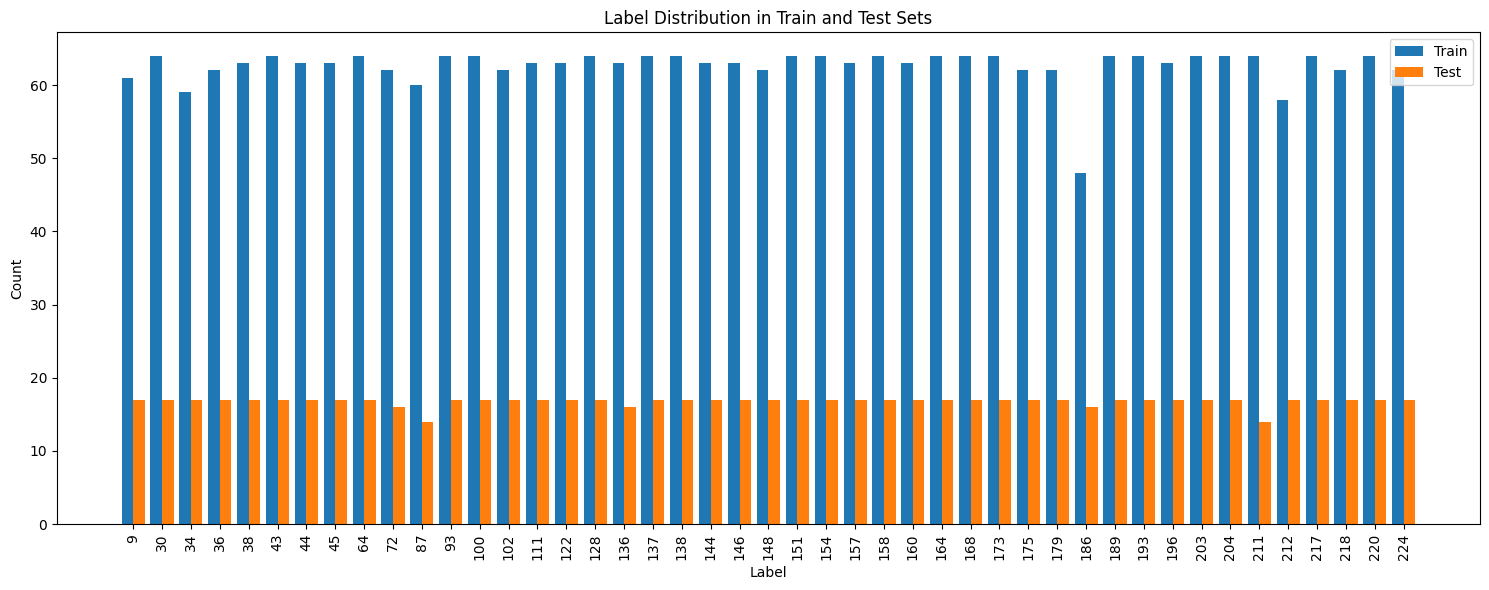

In [13]:
import matplotlib.pyplot as plt
train_counts = train_df_reduced['label'].value_counts().sort_index()
test_counts = test_df_filtered['label'].value_counts().sort_index()

all_labels = sorted(set(train_counts.index).union(set(test_counts.index)))

train_counts = train_counts.reindex(all_labels, fill_value=0)
test_counts = test_counts.reindex(all_labels, fill_value=0)

x = range(len(all_labels))
bar_width = 0.4

plt.figure(figsize=(15, 6))
plt.bar([i - bar_width/2 for i in x], train_counts, width=bar_width, label='Train')
plt.bar([i + bar_width/2 for i in x], test_counts, width=bar_width, label='Test')

plt.xticks(ticks=x, labels=all_labels, rotation=90)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Train and Test Sets')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
train_videos = []
test_videos = []
train_label = []
test_label = []

train_video_path = os.path.join(path, 'train')
test_video_path = os.path.join(path, 'test')

# Add train videos to train_videos list if their names exist in train_df_reduced
for index, row in train_df_reduced.iterrows():
    video_name = row['file name'] + '_color.mp4'
    video_full_path = os.path.join(train_video_path, video_name)
    if os.path.exists(video_full_path):
        train_videos.append(video_full_path)
        train_label.append(row['label'])

# Add test videos to test_videos list if their names exist in test_df_filtered
for index, row in test_df_filtered.iterrows():
    video_name = row['file name'] + '_color.mp4'
    video_full_path = os.path.join(test_video_path, video_name)
    if os.path.exists(video_full_path):
        test_videos.append(video_full_path)
        test_label.append(row['label'])

print(f"\nNumber of training videos found: {len(train_videos)}")
print(f"Number of testing videos found: {len(test_videos)}")



Number of training videos found: 2819
Number of testing videos found: 756


In [ ]:
train_videos[:10]

['/content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample38_color.mp4',
 '/content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample39_color.mp4',
 '/content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample353_color.mp4',
 '/content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample260_color.mp4',
 '/content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1114_color.mp4',
 '/content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1564_color.mp4',
 '/content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample389_color.mp4',
 '/content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample589_color.mp4',
 '/content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2230_color.mp4',
 '/content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample765_color.mp4']

## Media Pipe

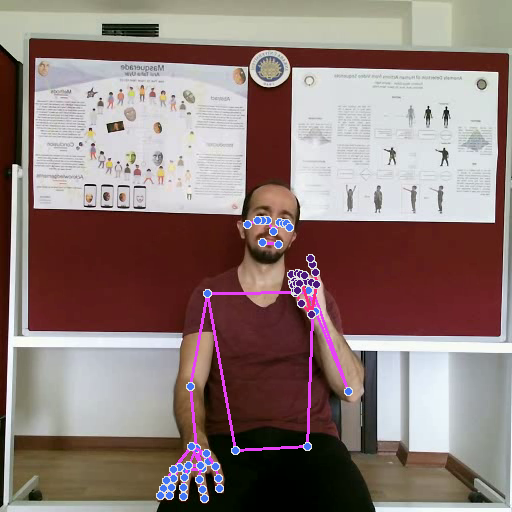

In [ ]:
import random
from google.colab.patches import cv2_imshow

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

first_video_path = train_videos[1000]

cap = cv2.VideoCapture(first_video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)

random_frame_index = random.randint(0, frame_count - 1)

cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame_index)

ret, frame = cap.read()

if ret:
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    with mp_holistic.Holistic(static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        results = holistic.process(image_rgb)

        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
            )
        if results.left_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                results.left_hand_landmarks,
                mp_holistic.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
            )
        if results.right_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                results.right_hand_landmarks,
                mp_holistic.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
            )


    cv2_imshow(frame)
else:
    print(f"Failed to read frame {random_frame_index} from the video.")

cap.release()


In [ ]:


mp_holistic = mp.solutions.holistic

def extract_features_from_video(video_path, max_frames=50, verbose_level=1):
    if verbose_level >= 1:
        print(f"Processing: {video_path}")

    holistic = mp_holistic.Holistic(static_image_mode=False)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Failed to open video: {video_path}")
        return np.zeros((max_frames, 150))

    landmarks_seq = []

    while True:
        ret, frame = cap.read()
        if not ret:
            if verbose_level >= 2:
                print(f"No ret for {video_path}")
            break
        if frame is None:
            print(f"No frame for {video_path}")
            continue  # boş frame atla

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)
        frame_landmarks = []

        # Pose
        if results.pose_landmarks:
            for lm in results.pose_landmarks.landmark:
                frame_landmarks.extend([lm.x, lm.y])
        else:
            print(f"There is no pose for {video_path}")
            frame_landmarks.extend([0] * 33 * 2)

        # Left Hand
        if results.left_hand_landmarks:
            for lm in results.left_hand_landmarks.landmark:
                frame_landmarks.extend([lm.x, lm.y])
        else:
            print(f"There is no left hand for {video_path}")
            frame_landmarks.extend([0] * 21 * 2)

        # Right Hand
        if results.right_hand_landmarks:
            for lm in results.right_hand_landmarks.landmark:
                frame_landmarks.extend([lm.x, lm.y])
        else:
            print(f"There is right hand for {video_path}")
            frame_landmarks.extend([0] * 21 * 2)

        landmarks_seq.append(frame_landmarks)

    cap.release()
    holistic.close()

    landmarks_seq = np.array(landmarks_seq)

    if len(landmarks_seq) == 0:
        if verbose_level >= 1:
            print(f"No landmarks extracted for: {video_path}")
        return np.zeros((max_frames, 150))  # default boş vektör döndür

    # Interpolate
    x_old = np.linspace(0, 1, num=len(landmarks_seq))
    x_new = np.linspace(0, 1, num=max_frames)
    interpolator = interp1d(x_old, np.array(landmarks_seq), axis=0, kind='linear', fill_value='extrapolate')
    return interpolator(x_new)

def create_dataset(video_paths, labels, max_frames=50):
    X = []
    y = []

    for i in tqdm(range(len(video_paths)), desc="Extracting Features"):
        video_path = video_paths[i]
        label = labels[i]
        print(f"\nProcessing: {video_path}")
        features = extract_features_from_video(video_path, max_frames=max_frames)
        X.append(features)
        y.append(label)

    return np.array(X), np.array(y)



# Train set
X_train, y_train = create_dataset(train_videos, train_label)

# Test set
X_test, y_test = create_dataset(test_videos, test_label)

# Sonuçları yazdır
print("\nTrain data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Extracting Features:   0%|          | 0/2819 [00:00<?, ?it/s]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample38_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample38_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample38_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample38_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample38_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample38_color.mp4


Extracting Features:   0%|          | 1/2819 [00:05<4:05:17,  5.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample39_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample39_color.mp4


Extracting Features:   0%|          | 2/2819 [00:09<3:35:17,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample353_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample353_color.mp4
There is no left 

Extracting Features:   0%|          | 3/2819 [00:15<4:01:20,  5.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample260_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample260_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample260_color.mp4


Extracting Features:   0%|          | 4/2819 [00:20<3:57:18,  5.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1114_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1114_color.mp4


Extracting Features:   0%|          | 5/2819 [00:23<3:31:48,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1564_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1564_color.mp4
There is right hand for

Extracting Features:   0%|          | 6/2819 [00:27<3:21:24,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample389_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample389_color.mp4
There i

Extracting Features:   0%|          | 7/2819 [00:32<3:32:34,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample589_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample589_color.mp4


Extracting Features:   0%|          | 8/2819 [00:36<3:19:39,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2230_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2230_color.mp4


Extracting Features:   0%|          | 9/2819 [00:40<3:27:00,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample765_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample765_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample765_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample765_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample765_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample765_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample765_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample765_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample765_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample765_color.mp4
There i

Extracting Features:   0%|          | 10/2819 [00:46<3:39:19,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample630_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample630_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample630_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample630_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample630_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample630_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample630_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample630_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample630_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample630_color.mp4
There i

Extracting Features:   0%|          | 11/2819 [00:50<3:36:34,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample532_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample532_color.mp4


Extracting Features:   0%|          | 12/2819 [00:55<3:36:31,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1083_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1083_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1083_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1083_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1083_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1083_color.mp4


Extracting Features:   0%|          | 13/2819 [01:00<3:40:03,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample491_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample491_color.mp4


Extracting Features:   0%|          | 14/2819 [01:05<3:50:23,  4.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample288_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample288_color.mp4


Extracting Features:   1%|          | 15/2819 [01:11<3:57:26,  5.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1222_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1222_color.mp4


Extracting Features:   1%|          | 16/2819 [01:15<3:46:05,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample570_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample570_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample570_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample570_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample570_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample570_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample570_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample570_color.mp4


Extracting Features:   1%|          | 17/2819 [01:21<3:58:43,  5.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample807_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample807_color.mp4


Extracting Features:   1%|          | 18/2819 [01:26<4:06:40,  5.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample330_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample330_color.mp4


Extracting Features:   1%|          | 19/2819 [01:32<4:05:01,  5.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample193_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample193_color.mp4
There is no left 

Extracting Features:   1%|          | 20/2819 [01:37<4:01:52,  5.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1387_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1387_color.mp4


Extracting Features:   1%|          | 21/2819 [01:43<4:22:38,  5.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2557_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2557_color.mp4
There is right hand for

Extracting Features:   1%|          | 22/2819 [01:47<3:56:28,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1293_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1293_color.m

Extracting Features:   1%|          | 23/2819 [01:52<3:57:26,  5.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample266_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample266_color.mp4


Extracting Features:   1%|          | 24/2819 [01:56<3:40:55,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1129_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1129_color.mp4


Extracting Features:   1%|          | 25/2819 [02:01<3:44:18,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2439_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2439_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2439_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2439_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2439_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2439_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2439_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2439_color.mp4


Extracting Features:   1%|          | 26/2819 [02:06<3:43:50,  4.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample414_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample414_color.mp4


Extracting Features:   1%|          | 27/2819 [02:16<4:53:20,  6.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample553_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample553_color.mp4
There i

Extracting Features:   1%|          | 28/2819 [02:19<4:13:55,  5.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1202_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1202_color.mp4


Extracting Features:   1%|          | 29/2819 [02:27<4:46:24,  6.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample233_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample233_color.mp4
There is right hand f

Extracting Features:   1%|          | 30/2819 [02:33<4:44:42,  6.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample9_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample9_color.mp4


Extracting Features:   1%|          | 31/2819 [02:38<4:28:33,  5.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample64_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample64_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample64_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample64_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample64_color.mp4


Extracting Features:   1%|          | 32/2819 [02:43<4:22:31,  5.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample315_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample315_color.mp4
There i

Extracting Features:   1%|          | 33/2819 [02:48<4:03:52,  5.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample923_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample923_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample923_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample923_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample923_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample923_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample923_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample923_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample923_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample923_color.mp4


Extracting Features:   1%|          | 34/2819 [02:53<3:59:29,  5.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample15_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample15_color.mp4


Extracting Features:   1%|          | 35/2819 [02:58<4:02:46,  5.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample297_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample297_color.mp4
There i

Extracting Features:   1%|▏         | 36/2819 [03:02<3:42:11,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample343_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample343_color.mp4


Extracting Features:   1%|▏         | 37/2819 [03:08<4:02:02,  5.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2204_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2204_color.mp4


Extracting Features:   1%|▏         | 38/2819 [03:13<3:54:01,  5.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample655_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample655_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample655_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample655_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample655_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample655_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample655_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample655_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample655_color.mp4


Extracting Features:   1%|▏         | 39/2819 [03:18<3:54:45,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1256_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1256_color.m

Extracting Features:   1%|▏         | 40/2819 [03:23<3:59:00,  5.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample779_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample779_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample779_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample779_color.mp4


Extracting Features:   1%|▏         | 41/2819 [03:29<4:12:16,  5.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample587_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample587_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample587_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample587_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample587_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample587_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample587_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample587_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample587_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample587_color.mp4


Extracting Features:   1%|▏         | 42/2819 [03:35<4:10:02,  5.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1310_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1310_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1310_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1310_color.mp4


Extracting Features:   2%|▏         | 43/2819 [03:39<4:03:03,  5.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample348_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample348_color.mp4
There i

Extracting Features:   2%|▏         | 44/2819 [03:45<4:10:39,  5.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1601_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1601_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1601_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1601_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1601_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1601_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1601_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1601_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1601_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1601_color.mp4
There i

Extracting Features:   2%|▏         | 45/2819 [03:51<4:11:20,  5.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample587_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample587_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample587_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample587_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample587_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample587_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample587_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample587_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample587_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample587_color.mp4
There i

Extracting Features:   2%|▏         | 46/2819 [03:56<4:05:56,  5.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample283_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample283_color.mp4


Extracting Features:   2%|▏         | 47/2819 [04:02<4:20:54,  5.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1141_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1141_color.mp4
There i

Extracting Features:   2%|▏         | 48/2819 [04:07<4:04:20,  5.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample795_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample795_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample795_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample795_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample795_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample795_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample795_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample795_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample795_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample795_color.mp4
There i

Extracting Features:   2%|▏         | 49/2819 [04:12<4:02:21,  5.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample15_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample15_color.mp4
There is no left 

Extracting Features:   2%|▏         | 50/2819 [04:17<4:08:15,  5.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1459_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1459_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1459_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1459_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1459_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1459_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1459_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1459_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1459_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1459_color.mp4
There is right hand for

Extracting Features:   2%|▏         | 51/2819 [04:22<3:54:00,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample251_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample251_color.mp4


Extracting Features:   2%|▏         | 52/2819 [04:26<3:35:47,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1110_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1110_color.mp4
There is right hand for

Extracting Features:   2%|▏         | 53/2819 [04:30<3:29:40,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample462_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample462_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample462_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample462_color.mp4


Extracting Features:   2%|▏         | 54/2819 [04:36<3:53:24,  5.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1413_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1413_color.m

Extracting Features:   2%|▏         | 55/2819 [04:42<4:02:43,  5.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample928_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample928_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample928_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample928_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample928_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample928_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample928_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample928_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample928_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample928_color.mp4
There is right hand for /content/

Extracting Features:   2%|▏         | 56/2819 [04:46<3:50:21,  5.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample542_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample542_color.mp4


Extracting Features:   2%|▏         | 57/2819 [04:52<4:02:36,  5.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample242_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample242_color.mp4


Extracting Features:   2%|▏         | 58/2819 [05:04<5:34:52,  7.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2521_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2521_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2521_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2521_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2521_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2521_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2521_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2521_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2521_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2521_color.mp4
There is right hand for

Extracting Features:   2%|▏         | 59/2819 [05:08<4:45:57,  6.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample120_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample120_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample120_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample120_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample120_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample120_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample120_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample120_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample120_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample120_color.mp4
There is no left hand

Extracting Features:   2%|▏         | 60/2819 [05:13<4:27:54,  5.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1725_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1725_color.m

Extracting Features:   2%|▏         | 61/2819 [05:17<4:01:58,  5.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2106_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2106_color.mp4


Extracting Features:   2%|▏         | 62/2819 [05:20<3:41:32,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample560_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample560_color.mp4


Extracting Features:   2%|▏         | 63/2819 [05:25<3:36:39,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample534_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample534_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample534_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample534_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample534_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample534_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample534_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample534_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample534_color.mp4
There is right hand f

Extracting Features:   2%|▏         | 64/2819 [05:28<3:15:57,  4.27s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample534_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample534_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample479_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample479_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample479_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample479_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample479_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample479_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample479_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample479_color.mp4
There is no

Extracting Features:   2%|▏         | 65/2819 [05:33<3:20:09,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2629_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2629_color.mp4


Extracting Features:   2%|▏         | 66/2819 [05:36<3:11:06,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample504_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample504_color.mp4
There i

Extracting Features:   2%|▏         | 67/2819 [05:39<2:51:42,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample378_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample378_color.mp4
There is no left ha

Extracting Features:   2%|▏         | 68/2819 [05:43<2:51:28,  3.74s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample378_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample292_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample292_color.mp4


Extracting Features:   2%|▏         | 69/2819 [05:51<3:50:52,  5.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample499_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample499_color.mp4


Extracting Features:   2%|▏         | 70/2819 [05:56<3:52:24,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample430_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample430_color.mp4
There i

Extracting Features:   3%|▎         | 71/2819 [06:01<3:47:57,  4.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample159_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample159_color.mp4
There is no left 

Extracting Features:   3%|▎         | 72/2819 [06:05<3:40:54,  4.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1100_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1100_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1100_color.mp4


Extracting Features:   3%|▎         | 73/2819 [06:09<3:29:40,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample228_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample228_color.mp4


Extracting Features:   3%|▎         | 74/2819 [06:14<3:36:27,  4.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample284_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample284_color.mp4
There i

Extracting Features:   3%|▎         | 75/2819 [06:17<3:11:24,  4.19s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample284_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample866_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample866_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample866_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample866_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample866_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample866_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample866_color.mp4
There is right hand for 

Extracting Features:   3%|▎         | 76/2819 [06:22<3:19:45,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample160_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample160_color.mp4
There i

Extracting Features:   3%|▎         | 77/2819 [06:26<3:06:09,  4.07s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample160_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample296_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample296_color.mp4


Extracting Features:   3%|▎         | 78/2819 [06:30<3:05:50,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample505_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample505_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample505_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample505_color.mp4


Extracting Features:   3%|▎         | 79/2819 [06:34<3:10:30,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1157_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1157_color.mp4


Extracting Features:   3%|▎         | 80/2819 [06:39<3:18:02,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1599_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1599_color.mp4
There is right hand for

Extracting Features:   3%|▎         | 81/2819 [06:42<3:03:15,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1316_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1316_color.mp4


Extracting Features:   3%|▎         | 82/2819 [06:48<3:26:07,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample164_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample164_color.mp4
There i

Extracting Features:   3%|▎         | 83/2819 [06:51<3:06:29,  4.09s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample164_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample303_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample303_color.mp4
There is no l

Extracting Features:   3%|▎         | 84/2819 [06:56<3:15:22,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample181_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample181_color.mp4


Extracting Features:   3%|▎         | 85/2819 [07:00<3:13:01,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample966_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample966_color.mp4


Extracting Features:   3%|▎         | 86/2819 [07:04<3:12:08,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample341_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample341_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample341_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample341_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample341_color.mp4


Extracting Features:   3%|▎         | 87/2819 [07:08<3:09:06,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1955_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1955_color.m

Extracting Features:   3%|▎         | 88/2819 [07:13<3:22:29,  4.45s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1955_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample201_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample201_color.mp4
Ther

Extracting Features:   3%|▎         | 89/2819 [07:17<3:10:27,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample139_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample139_color.mp4
There is no left 

Extracting Features:   3%|▎         | 90/2819 [07:22<3:23:18,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2108_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2108_color.mp4
There is right hand for

Extracting Features:   3%|▎         | 91/2819 [07:27<3:30:44,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2639_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2639_color.mp4


Extracting Features:   3%|▎         | 92/2819 [07:32<3:35:35,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2259_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2259_color.mp4


Extracting Features:   3%|▎         | 93/2819 [07:35<3:18:28,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1402_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1402_color.mp4


Extracting Features:   3%|▎         | 94/2819 [07:39<3:13:16,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample509_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample509_color.mp4
There i

Extracting Features:   3%|▎         | 95/2819 [07:42<2:49:05,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample238_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample238_color.mp4


Extracting Features:   3%|▎         | 96/2819 [07:45<2:44:16,  3.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample181_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample181_color.mp4
There i

Extracting Features:   3%|▎         | 97/2819 [07:49<2:45:32,  3.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample280_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample280_color.mp4


Extracting Features:   3%|▎         | 98/2819 [07:54<3:00:54,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample64_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample64_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample64_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample64_color.mp4


Extracting Features:   4%|▎         | 99/2819 [07:59<3:15:40,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample811_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample811_color.mp4


Extracting Features:   4%|▎         | 100/2819 [08:04<3:24:02,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample388_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample388_color.mp4
There is no left 

Extracting Features:   4%|▎         | 101/2819 [08:07<3:09:56,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample974_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample974_color.mp4
There i

Extracting Features:   4%|▎         | 102/2819 [08:11<3:12:37,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample500_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample500_color.mp4
There is righ

Extracting Features:   4%|▎         | 103/2819 [08:15<3:04:43,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2571_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2571_color.mp4


Extracting Features:   4%|▎         | 104/2819 [08:20<3:11:00,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample387_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample387_color.mp4


Extracting Features:   4%|▎         | 105/2819 [08:24<3:12:15,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1501_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1501_color.m

Extracting Features:   4%|▍         | 106/2819 [08:29<3:25:07,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample829_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample829_color.mp4


Extracting Features:   4%|▍         | 107/2819 [08:34<3:31:33,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample517_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample517_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample517_color.mp4


Extracting Features:   4%|▍         | 108/2819 [08:39<3:35:53,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1496_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1496_color.m

Extracting Features:   4%|▍         | 109/2819 [08:44<3:42:30,  4.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1497_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1497_color.mp4


Extracting Features:   4%|▍         | 110/2819 [08:49<3:31:55,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample191_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample191_color.mp4
There is right hand for

Extracting Features:   4%|▍         | 111/2819 [08:53<3:26:45,  4.58s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample191_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2290_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2290_color.mp4


Extracting Features:   4%|▍         | 112/2819 [08:57<3:18:19,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1068_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1068_color.m

Extracting Features:   4%|▍         | 113/2819 [09:03<3:36:30,  4.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample240_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample240_color.mp4


Extracting Features:   4%|▍         | 114/2819 [09:07<3:31:15,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample328_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample328_color.mp4


Extracting Features:   4%|▍         | 115/2819 [09:12<3:39:11,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1166_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1166_color.mp4


Extracting Features:   4%|▍         | 116/2819 [09:16<3:20:50,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1538_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1538_color.m

Extracting Features:   4%|▍         | 117/2819 [09:21<3:26:01,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample31_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample31_color.mp4
There is no left 

Extracting Features:   4%|▍         | 118/2819 [09:25<3:17:54,  4.40s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample31_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1191_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1191_color.mp4
There is right hand fo

Extracting Features:   4%|▍         | 119/2819 [09:28<3:09:07,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample582_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample582_color.mp4


Extracting Features:   4%|▍         | 120/2819 [09:32<2:57:57,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample598_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample598_color.mp4
There is right hand for /content/

Extracting Features:   4%|▍         | 121/2819 [09:36<3:06:43,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample355_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample355_color.mp4


Extracting Features:   4%|▍         | 122/2819 [09:41<3:15:44,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample338_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample338_color.mp4


Extracting Features:   4%|▍         | 123/2819 [09:46<3:16:05,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample574_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample574_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample574_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample574_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample574_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample574_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample574_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample574_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample574_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample574_color.mp4
There is right hand for /content/

Extracting Features:   4%|▍         | 124/2819 [09:51<3:24:00,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample556_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample556_color.mp4


Extracting Features:   4%|▍         | 125/2819 [09:55<3:26:50,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1660_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1660_color.mp4


Extracting Features:   4%|▍         | 126/2819 [09:59<3:17:56,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample110_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample110_color.mp4
There i

Extracting Features:   5%|▍         | 127/2819 [10:04<3:25:03,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1143_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1143_color.mp4


Extracting Features:   5%|▍         | 128/2819 [10:09<3:25:08,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample43_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample43_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample43_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample43_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample43_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample43_color.mp4
There is no left hand for /content/

Extracting Features:   5%|▍         | 129/2819 [10:16<3:57:12,  5.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1506_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1506_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1506_color.mp4


Extracting Features:   5%|▍         | 130/2819 [10:20<3:40:01,  4.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample562_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample562_color.mp4


Extracting Features:   5%|▍         | 131/2819 [10:26<4:00:49,  5.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample21_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample21_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample21_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample21_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample21_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample21_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample21_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample21_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample21_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample21_color.mp4
There is no left hand for

Extracting Features:   5%|▍         | 132/2819 [10:31<3:50:46,  5.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample947_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample947_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample947_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample947_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample947_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample947_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample947_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample947_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample947_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample947_color.mp4
There is right hand

Extracting Features:   5%|▍         | 133/2819 [10:36<3:55:15,  5.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample623_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample623_color.mp4


Extracting Features:   5%|▍         | 134/2819 [10:43<4:13:12,  5.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample131_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample131_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample131_color.mp4
There is right hand f

Extracting Features:   5%|▍         | 135/2819 [10:47<3:53:01,  5.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample179_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample179_color.mp4
There is right hand for /

Extracting Features:   5%|▍         | 136/2819 [10:54<4:15:58,  5.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample310_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample310_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample310_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample310_color.mp4


Extracting Features:   5%|▍         | 137/2819 [10:59<4:08:55,  5.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1240_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1240_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1240_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1240_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1240_color.mp4
There is no l

Extracting Features:   5%|▍         | 138/2819 [11:04<3:54:00,  5.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample637_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample637_color.mp4
There i

Extracting Features:   5%|▍         | 139/2819 [11:08<3:46:11,  5.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1809_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1809_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1809_color.mp4


Extracting Features:   5%|▍         | 140/2819 [11:13<3:33:57,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2592_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2592_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2592_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2592_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2592_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2592_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2592_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2592_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2592_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2592_color.mp4


Extracting Features:   5%|▌         | 141/2819 [11:17<3:30:34,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample62_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample62_color.mp4
There is no left 

Extracting Features:   5%|▌         | 142/2819 [11:25<4:10:45,  5.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample169_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample169_color.mp4


Extracting Features:   5%|▌         | 143/2819 [11:29<3:45:04,  5.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample424_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample424_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample424_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample424_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample424_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample424_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample424_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample424_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample424_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample424_color.mp4
There i

Extracting Features:   5%|▌         | 144/2819 [11:35<4:03:23,  5.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample36_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample36_color.mp4


Extracting Features:   5%|▌         | 145/2819 [11:41<4:08:44,  5.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample999_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample999_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample999_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample999_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample999_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample999_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample999_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample999_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample999_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample999_color.mp4
There is right 

Extracting Features:   5%|▌         | 146/2819 [11:46<4:00:47,  5.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1739_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1739_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1739_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1739_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1739_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1739_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1739_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1739_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1739_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1739_color.mp4
There is righ

Extracting Features:   5%|▌         | 147/2819 [11:50<3:47:18,  5.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample343_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample343_color.mp4
There i

Extracting Features:   5%|▌         | 148/2819 [11:54<3:35:20,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample715_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample715_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample715_color.mp4


Extracting Features:   5%|▌         | 149/2819 [11:59<3:30:12,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1880_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1880_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1880_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1880_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1880_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1880_color.mp4
There is no lef

Extracting Features:   5%|▌         | 150/2819 [12:03<3:14:50,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample392_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample392_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample392_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample392_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample392_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample392_color.mp4


Extracting Features:   5%|▌         | 151/2819 [12:08<3:27:53,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample119_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample119_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample119_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample119_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample119_color.mp4
There is no left hand f

Extracting Features:   5%|▌         | 152/2819 [12:14<3:43:46,  5.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample232_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample232_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample232_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample232_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample232_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample232_color.mp4
There is right 

Extracting Features:   5%|▌         | 153/2819 [12:19<3:45:28,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample108_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample108_color.mp4


Extracting Features:   5%|▌         | 154/2819 [12:24<3:46:45,  5.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample931_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample931_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample931_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample931_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample931_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample931_color.mp4


Extracting Features:   5%|▌         | 155/2819 [12:28<3:32:45,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1418_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1418_color.mp4
There

Extracting Features:   6%|▌         | 156/2819 [12:33<3:38:43,  4.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample704_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample704_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample704_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample704_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample704_color.mp4


Extracting Features:   6%|▌         | 157/2819 [12:38<3:34:14,  4.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1057_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1057_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1057_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1057_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1057_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1057_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1057_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1057_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1057_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1057_color.mp4
There is righ

Extracting Features:   6%|▌         | 158/2819 [12:42<3:23:46,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1411_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1411_color.mp4
There

Extracting Features:   6%|▌         | 159/2819 [12:47<3:26:22,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample531_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample531_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample531_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample531_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample531_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample531_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample531_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample531_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample531_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample531_color.mp4
There is right hand

Extracting Features:   6%|▌         | 160/2819 [12:51<3:23:58,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2262_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2262_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2262_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2262_color.mp4


Extracting Features:   6%|▌         | 161/2819 [12:57<3:37:38,  4.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample777_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample777_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample777_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample777_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample777_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample777_color.mp4
There is no lef

Extracting Features:   6%|▌         | 162/2819 [13:02<3:36:59,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample398_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample398_color.mp4
There is right 

Extracting Features:   6%|▌         | 163/2819 [13:07<3:39:32,  4.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample745_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample745_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample745_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample745_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample745_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample745_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample745_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample745_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample745_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample745_color.mp4
There is right hand for /

Extracting Features:   6%|▌         | 164/2819 [13:12<3:37:22,  4.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample9_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample9_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample9_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample9_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample9_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample9_color.mp4
There is right hand for /content/drive/MyDriv

Extracting Features:   6%|▌         | 165/2819 [13:16<3:26:52,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample147_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample147_color.mp4
There i

Extracting Features:   6%|▌         | 166/2819 [13:22<3:45:06,  5.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1930_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1930_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1930_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1930_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1930_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1930_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1930_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1930_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1930_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1930_color.mp4
There

Extracting Features:   6%|▌         | 167/2819 [13:27<3:47:48,  5.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2038_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2038_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2038_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2038_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2038_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2038_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2038_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2038_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2038_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2038_color.mp4
There is 

Extracting Features:   6%|▌         | 168/2819 [13:34<4:05:17,  5.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample548_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample548_color.mp4
There is no left hand f

Extracting Features:   6%|▌         | 169/2819 [13:39<3:59:49,  5.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample568_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample568_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample568_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample568_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample568_color.mp4


Extracting Features:   6%|▌         | 170/2819 [13:45<4:07:03,  5.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1330_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1330_color.mp4


Extracting Features:   6%|▌         | 171/2819 [13:48<3:36:29,  4.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample348_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample348_color.mp4
There i

Extracting Features:   6%|▌         | 172/2819 [13:55<4:02:27,  5.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1875_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1875_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1875_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1875_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1875_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1875_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1875_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1875_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1875_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1875_color.mp4
There

Extracting Features:   6%|▌         | 173/2819 [14:00<3:51:01,  5.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1737_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1737_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1737_color.mp4


Extracting Features:   6%|▌         | 174/2819 [14:05<3:55:33,  5.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample353_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample353_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample353_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample353_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample353_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample353_color.mp4
There is right 

Extracting Features:   6%|▌         | 175/2819 [14:09<3:39:55,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample317_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample317_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample317_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample317_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample317_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample317_color.mp4
There is right hand for /

Extracting Features:   6%|▌         | 176/2819 [14:14<3:39:45,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample220_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample220_color.mp4
There is right hand for

Extracting Features:   6%|▋         | 177/2819 [14:21<4:05:17,  5.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1135_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1135_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1135_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1135_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1135_color.mp4
The

Extracting Features:   6%|▋         | 178/2819 [14:25<3:43:51,  5.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample129_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample129_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample129_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample129_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample129_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample129_color.mp4
There is no left hand for

Extracting Features:   6%|▋         | 179/2819 [14:29<3:29:20,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample68_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample68_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample68_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample68_color.mp4


Extracting Features:   6%|▋         | 180/2819 [14:34<3:27:45,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample289_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample289_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample289_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample289_color.mp4


Extracting Features:   6%|▋         | 181/2819 [14:39<3:37:11,  4.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1841_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1841_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1841_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1841_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1841_color.mp4
There is righ

Extracting Features:   6%|▋         | 182/2819 [14:44<3:29:33,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample200_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample200_color.mp4
There i

Extracting Features:   6%|▋         | 183/2819 [14:49<3:39:17,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample520_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample520_color.mp4
There i

Extracting Features:   7%|▋         | 184/2819 [14:55<3:44:30,  5.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample3_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample3_color.mp4


Extracting Features:   7%|▋         | 185/2819 [15:00<3:49:13,  5.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2458_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2458_color.mp4
There is right hand for

Extracting Features:   7%|▋         | 186/2819 [15:04<3:25:42,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample663_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample663_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample663_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample663_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample663_color.mp4


Extracting Features:   7%|▋         | 187/2819 [15:08<3:22:30,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample564_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample564_color.mp4


Extracting Features:   7%|▋         | 188/2819 [15:13<3:26:43,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample832_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample832_color.mp4
There i

Extracting Features:   7%|▋         | 189/2819 [15:18<3:26:30,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample268_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample268_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample268_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample268_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample268_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample268_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample268_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample268_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample268_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample268_color.mp4


Extracting Features:   7%|▋         | 190/2819 [15:21<3:10:44,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1180_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1180_color.mp4


Extracting Features:   7%|▋         | 191/2819 [15:26<3:15:14,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample43_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample43_color.mp4


Extracting Features:   7%|▋         | 192/2819 [15:31<3:18:52,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample35_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample35_color.mp4


Extracting Features:   7%|▋         | 193/2819 [15:36<3:30:49,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1133_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1133_color.mp4


Extracting Features:   7%|▋         | 194/2819 [15:40<3:20:11,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1442_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1442_color.mp4
There i

Extracting Features:   7%|▋         | 195/2819 [15:45<3:30:24,  4.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample470_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample470_color.mp4
There i

Extracting Features:   7%|▋         | 196/2819 [15:50<3:23:59,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2618_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2618_color.mp4
There is right hand for

Extracting Features:   7%|▋         | 197/2819 [15:54<3:24:20,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample189_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample189_color.mp4


Extracting Features:   7%|▋         | 198/2819 [15:59<3:18:43,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample182_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample182_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample182_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample182_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample182_color.mp4


Extracting Features:   7%|▋         | 199/2819 [16:04<3:22:24,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample617_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample617_color.mp4


Extracting Features:   7%|▋         | 200/2819 [16:08<3:14:48,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1292_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1292_color.mp4


Extracting Features:   7%|▋         | 201/2819 [16:13<3:21:13,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample70_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample70_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample70_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample70_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample70_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample70_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample70_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample70_color.mp4


Extracting Features:   7%|▋         | 202/2819 [16:18<3:28:42,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1323_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1323_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1323_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1323_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1323_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1323_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1323_color.mp4


Extracting Features:   7%|▋         | 203/2819 [16:23<3:38:51,  5.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample316_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample316_color.mp4


Extracting Features:   7%|▋         | 204/2819 [16:26<3:12:38,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample395_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample395_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample395_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample395_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample395_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample395_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample395_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample395_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample395_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample395_color.mp4
There is no left 

Extracting Features:   7%|▋         | 205/2819 [16:30<3:05:00,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample648_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample648_color.mp4
There is right hand for

Extracting Features:   7%|▋         | 206/2819 [16:35<3:17:46,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample623_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample623_color.mp4


Extracting Features:   7%|▋         | 207/2819 [16:40<3:22:26,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1185_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1185_color.mp4
There i

Extracting Features:   7%|▋         | 208/2819 [16:46<3:37:12,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2620_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2620_color.mp4


Extracting Features:   7%|▋         | 209/2819 [16:51<3:41:51,  5.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1274_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1274_color.m

Extracting Features:   7%|▋         | 210/2819 [16:57<3:42:12,  5.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample377_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample377_color.mp4


Extracting Features:   7%|▋         | 211/2819 [17:01<3:36:18,  4.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample680_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample680_color.mp4


Extracting Features:   8%|▊         | 212/2819 [17:05<3:24:58,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample113_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample113_color.mp4
There is no left 

Extracting Features:   8%|▊         | 213/2819 [17:11<3:38:43,  5.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer33_sample423_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer33_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer33_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer33_sample423_color.mp4
There is no pose for /content/drive/MyDrive/kaggle_autsl_data/train/signer33_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer33_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer33_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer33_sample423_color.mp4


Extracting Features:   8%|▊         | 214/2819 [17:16<3:38:20,  5.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample244_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample244_color.mp4


Extracting Features:   8%|▊         | 215/2819 [17:21<3:31:43,  4.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample97_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample97_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample97_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample97_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample97_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample97_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample97_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample97_color.mp4
There is no left hand for /co

Extracting Features:   8%|▊         | 216/2819 [17:26<3:44:01,  5.16s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample97_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample97_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1101_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1101_color.mp4
There

Extracting Features:   8%|▊         | 217/2819 [17:30<3:27:20,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample404_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample404_color.mp4


Extracting Features:   8%|▊         | 218/2819 [17:37<3:45:12,  5.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample647_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample647_color.mp4


Extracting Features:   8%|▊         | 219/2819 [17:41<3:32:52,  4.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample455_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample455_color.mp4


Extracting Features:   8%|▊         | 220/2819 [17:46<3:33:28,  4.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1898_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1898_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1898_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1898_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1898_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1898_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1898_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1898_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1898_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1898_color.mp4
There is right hand for

Extracting Features:   8%|▊         | 221/2819 [17:50<3:27:10,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample589_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample589_color.mp4


Extracting Features:   8%|▊         | 222/2819 [17:56<3:40:42,  5.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample163_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample163_color.mp4


Extracting Features:   8%|▊         | 223/2819 [18:01<3:37:50,  5.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2605_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2605_color.mp4


Extracting Features:   8%|▊         | 224/2819 [18:06<3:38:41,  5.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample337_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample337_color.mp4


Extracting Features:   8%|▊         | 225/2819 [18:12<3:47:02,  5.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1037_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1037_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1037_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1037_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1037_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1037_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1037_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1037_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1037_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1037_color.m

Extracting Features:   8%|▊         | 226/2819 [18:17<3:50:02,  5.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1255_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1255_color.mp4


Extracting Features:   8%|▊         | 227/2819 [18:22<3:46:25,  5.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample5_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample5_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample5_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample5_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample5_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample5_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample5_color.mp4


Extracting Features:   8%|▊         | 228/2819 [18:26<3:32:44,  4.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample873_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample873_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample873_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample873_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample873_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample873_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample873_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample873_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample873_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample873_color.mp4
There i

Extracting Features:   8%|▊         | 229/2819 [18:31<3:30:37,  4.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample855_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample855_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample855_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample855_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample855_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample855_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample855_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample855_color.mp4


Extracting Features:   8%|▊         | 230/2819 [18:36<3:25:02,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample364_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample364_color.mp4
There i

Extracting Features:   8%|▊         | 231/2819 [18:40<3:15:11,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1904_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1904_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1904_color.mp4


Extracting Features:   8%|▊         | 232/2819 [18:45<3:26:47,  4.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1154_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1154_color.m

Extracting Features:   8%|▊         | 233/2819 [18:51<3:35:05,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample113_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample113_color.mp4


Extracting Features:   8%|▊         | 234/2819 [18:55<3:28:39,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1257_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1257_color.mp4


Extracting Features:   8%|▊         | 235/2819 [18:59<3:23:10,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1143_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1143_color.m

Extracting Features:   8%|▊         | 236/2819 [19:04<3:21:28,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample431_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample431_color.mp4
There i

Extracting Features:   8%|▊         | 237/2819 [19:09<3:19:59,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1897_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1897_color.mp4


Extracting Features:   8%|▊         | 238/2819 [19:13<3:19:15,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample454_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample454_color.mp4


Extracting Features:   8%|▊         | 239/2819 [19:17<3:06:35,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample400_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample400_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample400_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample400_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample400_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample400_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample400_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample400_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample400_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample400_color.mp4
There is right hand for /content/

Extracting Features:   9%|▊         | 240/2819 [19:22<3:18:06,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample514_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample514_color.mp4


Extracting Features:   9%|▊         | 241/2819 [19:29<3:44:55,  5.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1298_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1298_color.m

Extracting Features:   9%|▊         | 242/2819 [19:35<3:52:41,  5.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample342_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample342_color.mp4
There is right hand for /content/

Extracting Features:   9%|▊         | 243/2819 [19:39<3:38:11,  5.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample551_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample551_color.mp4
There i

Extracting Features:   9%|▊         | 244/2819 [19:43<3:26:46,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample617_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample617_color.mp4


Extracting Features:   9%|▊         | 245/2819 [19:48<3:22:38,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample337_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample337_color.mp4


Extracting Features:   9%|▊         | 246/2819 [19:53<3:29:13,  4.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample22_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample22_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample22_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample22_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample22_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample22_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample22_color.mp4
There is right hand for /co

Extracting Features:   9%|▉         | 247/2819 [19:57<3:15:54,  4.57s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample22_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample460_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample460_color.mp4


Extracting Features:   9%|▉         | 248/2819 [20:02<3:28:30,  4.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample482_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample482_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample482_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample482_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample482_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample482_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample482_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample482_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample482_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample482_color.mp4
There is right hand for

Extracting Features:   9%|▉         | 249/2819 [20:07<3:19:57,  4.67s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample482_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample482_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1508_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1508_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1508_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1508_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1508_color.mp4
There is 

Extracting Features:   9%|▉         | 250/2819 [20:12<3:25:21,  4.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample82_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample82_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample82_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample82_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample82_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample82_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample82_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample82_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample82_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample82_color.mp4
There is right hand for

Extracting Features:   9%|▉         | 251/2819 [20:15<3:11:28,  4.47s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample82_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample82_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample82_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample456_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample456_color.mp4


Extracting Features:   9%|▉         | 252/2819 [20:21<3:26:52,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2527_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2527_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2527_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2527_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2527_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2527_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2527_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2527_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2527_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2527_color.mp4
There is righ

Extracting Features:   9%|▉         | 253/2819 [20:26<3:27:43,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample687_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample687_color.mp4
There is no left 

Extracting Features:   9%|▉         | 254/2819 [20:31<3:35:32,  5.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample238_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample238_color.mp4


Extracting Features:   9%|▉         | 255/2819 [20:36<3:35:51,  5.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2481_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2481_color.mp4
There is righ

Extracting Features:   9%|▉         | 256/2819 [20:41<3:30:15,  4.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample785_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample785_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample785_color.mp4


Extracting Features:   9%|▉         | 257/2819 [20:46<3:26:42,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample467_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample467_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample467_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample467_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample467_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample467_color.mp4
There is no lef

Extracting Features:   9%|▉         | 258/2819 [20:51<3:30:11,  4.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample827_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample827_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample827_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample827_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample827_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample827_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample827_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample827_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample827_color.mp4


Extracting Features:   9%|▉         | 259/2819 [20:55<3:17:20,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample483_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample483_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample483_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample483_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample483_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample483_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample483_color.mp4
There is right ha

Extracting Features:   9%|▉         | 260/2819 [20:59<3:14:05,  4.55s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample483_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample483_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample634_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample634_color.mp4


Extracting Features:   9%|▉         | 261/2819 [21:03<3:10:22,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample364_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample364_color.mp4


Extracting Features:   9%|▉         | 262/2819 [21:09<3:18:38,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample107_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample107_color.mp4


Extracting Features:   9%|▉         | 263/2819 [21:13<3:20:49,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1051_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1051_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1051_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1051_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1051_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1051_color.mp4


Extracting Features:   9%|▉         | 264/2819 [21:19<3:26:56,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample913_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample913_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample913_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample913_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample913_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample913_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample913_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample913_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample913_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample913_color.mp4
There is right ha

Extracting Features:   9%|▉         | 265/2819 [21:23<3:25:55,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1258_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1258_color.mp4


Extracting Features:   9%|▉         | 266/2819 [21:29<3:38:37,  5.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4
There is right hand for /content/dr

Extracting Features:   9%|▉         | 267/2819 [21:33<3:16:07,  4.61s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample31_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1581_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1581_color.mp4


Extracting Features:  10%|▉         | 268/2819 [21:38<3:20:18,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample30_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample30_color.mp4


Extracting Features:  10%|▉         | 269/2819 [21:43<3:25:31,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample150_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample150_color.mp4
There is no left 

Extracting Features:  10%|▉         | 270/2819 [21:47<3:15:25,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1248_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1248_color.mp4


Extracting Features:  10%|▉         | 271/2819 [21:52<3:18:40,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2131_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2131_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2131_color.mp4


Extracting Features:  10%|▉         | 272/2819 [21:55<3:04:14,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1897_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1897_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1897_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1897_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1897_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1897_color.mp4
There

Extracting Features:  10%|▉         | 273/2819 [22:00<3:13:30,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample429_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample429_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample429_color.mp4


Extracting Features:  10%|▉         | 274/2819 [22:06<3:22:40,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample577_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample577_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample577_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample577_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample577_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample577_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample577_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample577_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample577_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample577_color.mp4
There is ri

Extracting Features:  10%|▉         | 275/2819 [22:10<3:24:26,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample580_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample580_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample580_color.mp4


Extracting Features:  10%|▉         | 276/2819 [22:17<3:42:55,  5.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1620_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1620_color.mp4


Extracting Features:  10%|▉         | 277/2819 [22:22<3:42:38,  5.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1225_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1225_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1225_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1225_color.mp4
There is no

Extracting Features:  10%|▉         | 278/2819 [22:27<3:39:21,  5.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample611_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample611_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample611_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample611_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample611_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample611_color.mp4
There is right hand for /

Extracting Features:  10%|▉         | 279/2819 [22:32<3:41:30,  5.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample481_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample481_color.mp4
There is no l

Extracting Features:  10%|▉         | 280/2819 [22:37<3:35:17,  5.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample333_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample333_color.mp4
There is 

Extracting Features:  10%|▉         | 281/2819 [22:43<3:42:28,  5.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample284_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample284_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample284_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample284_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample284_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample284_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample284_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample284_color.mp4
There is right hand for /cont

Extracting Features:  10%|█         | 282/2819 [22:48<3:41:48,  5.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample71_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample71_color.mp4
There is no left hand for

Extracting Features:  10%|█         | 283/2819 [22:52<3:31:45,  5.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample642_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample642_color.mp4


Extracting Features:  10%|█         | 284/2819 [22:57<3:31:18,  5.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2348_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2348_color.mp4


Extracting Features:  10%|█         | 285/2819 [23:02<3:25:10,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1181_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1181_color.mp4
The

Extracting Features:  10%|█         | 286/2819 [23:07<3:22:11,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4
There is right hand for

Extracting Features:  10%|█         | 287/2819 [23:11<3:18:11,  4.70s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample346_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2452_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2452_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2452_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2452_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2452_color.mp4


Extracting Features:  10%|█         | 288/2819 [23:17<3:33:47,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1446_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1446_color.mp4
The

Extracting Features:  10%|█         | 289/2819 [23:22<3:33:48,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample491_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample491_color.mp4
There is ri

Extracting Features:  10%|█         | 290/2819 [23:26<3:23:18,  4.82s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample491_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample802_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample802_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample802_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample802_color.mp4


Extracting Features:  10%|█         | 291/2819 [23:32<3:29:08,  4.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample357_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample357_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample357_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample357_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample357_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample357_color.mp4
There is right hand for /

Extracting Features:  10%|█         | 292/2819 [23:36<3:17:40,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1344_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1344_color.mp4
There

Extracting Features:  10%|█         | 293/2819 [23:40<3:18:34,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1256_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1256_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1256_color.mp4


Extracting Features:  10%|█         | 294/2819 [23:44<3:04:26,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample507_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample507_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample507_color.mp4
There is 

Extracting Features:  10%|█         | 295/2819 [23:49<3:18:03,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1640_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1640_color.mp4


Extracting Features:  11%|█         | 296/2819 [23:54<3:09:48,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample305_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample305_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample305_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample305_color.mp4


Extracting Features:  11%|█         | 297/2819 [23:58<3:09:50,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample305_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample305_color.mp4


Extracting Features:  11%|█         | 298/2819 [24:03<3:12:20,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample942_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample942_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample942_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample942_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample942_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample942_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample942_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample942_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample942_color.mp4


Extracting Features:  11%|█         | 299/2819 [24:07<3:03:03,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1470_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1470_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1470_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1470_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1470_color.mp4
The

Extracting Features:  11%|█         | 300/2819 [24:11<3:06:47,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample176_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample176_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample176_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample176_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample176_color.mp4
There is righ

Extracting Features:  11%|█         | 301/2819 [24:16<3:09:02,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1882_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1882_color.mp4


Extracting Features:  11%|█         | 302/2819 [24:21<3:15:00,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample288_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample288_color.mp4


Extracting Features:  11%|█         | 303/2819 [24:24<2:52:51,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample702_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample702_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample702_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample702_color.mp4


Extracting Features:  11%|█         | 304/2819 [24:28<2:53:09,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample603_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample603_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample603_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample603_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample603_color.mp4
There is no left hand for /

Extracting Features:  11%|█         | 305/2819 [24:33<3:06:50,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample105_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample105_color.mp4
There is no lef

Extracting Features:  11%|█         | 306/2819 [24:38<3:13:32,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample580_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample580_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample580_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample580_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample580_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample580_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample580_color.mp4
There is right hand for /co

Extracting Features:  11%|█         | 307/2819 [24:43<3:10:47,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample248_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample248_color.mp4


Extracting Features:  11%|█         | 308/2819 [24:48<3:18:37,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample629_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample629_color.mp4


Extracting Features:  11%|█         | 309/2819 [24:53<3:26:41,  4.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample895_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample895_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample895_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample895_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample895_color.mp4


Extracting Features:  11%|█         | 310/2819 [25:00<3:47:29,  5.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample320_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample320_color.mp4
There i

Extracting Features:  11%|█         | 311/2819 [25:03<3:20:35,  4.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample549_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample549_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample549_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample549_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample549_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample549_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample549_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample549_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample549_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample549_color.mp4
There is right hand f

Extracting Features:  11%|█         | 312/2819 [25:08<3:18:37,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample960_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample960_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample960_color.mp4


Extracting Features:  11%|█         | 313/2819 [25:12<3:18:39,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2448_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2448_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2448_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2448_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2448_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2448_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2448_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2448_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2448_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2448_color.mp4
There is right hand for

Extracting Features:  11%|█         | 314/2819 [25:18<3:22:47,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample433_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample433_color.mp4
There i

Extracting Features:  11%|█         | 315/2819 [25:20<2:57:31,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample342_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample342_color.mp4
There is right hand f

Extracting Features:  11%|█         | 316/2819 [25:24<2:53:24,  4.16s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample342_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample280_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample280_color.mp4


Extracting Features:  11%|█         | 317/2819 [25:28<2:51:54,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample514_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample514_color.mp4
There i

Extracting Features:  11%|█▏        | 318/2819 [25:33<2:52:40,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample797_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample797_color.mp4
There i

Extracting Features:  11%|█▏        | 319/2819 [25:37<2:58:58,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample218_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample218_color.mp4


Extracting Features:  11%|█▏        | 320/2819 [25:43<3:22:35,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample960_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample960_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample960_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample960_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample960_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample960_color.mp4


Extracting Features:  11%|█▏        | 321/2819 [25:48<3:12:56,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample187_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample187_color.mp4
There is no left 

Extracting Features:  11%|█▏        | 322/2819 [25:54<3:38:04,  5.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample275_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample275_color.mp4
There i

Extracting Features:  11%|█▏        | 323/2819 [25:57<3:11:47,  4.61s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample275_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample488_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample488_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample488_color.mp4


Extracting Features:  11%|█▏        | 324/2819 [26:02<3:15:30,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample83_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample83_color.mp4
There is no left 

Extracting Features:  12%|█▏        | 325/2819 [26:06<3:00:23,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample518_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample518_color.mp4
There is no left 

Extracting Features:  12%|█▏        | 326/2819 [26:11<3:13:03,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample402_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample402_color.mp4


Extracting Features:  12%|█▏        | 327/2819 [26:15<2:58:36,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1045_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1045_color.mp4


Extracting Features:  12%|█▏        | 328/2819 [26:20<3:09:50,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1457_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1457_color.mp4
There is right hand for

Extracting Features:  12%|█▏        | 329/2819 [26:23<2:58:48,  4.31s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1457_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1254_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1254_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1254_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1254_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1254_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1254_color.mp4


Extracting Features:  12%|█▏        | 330/2819 [26:29<3:13:37,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample411_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample411_color.mp4
There i

Extracting Features:  12%|█▏        | 331/2819 [26:33<3:01:29,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample379_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample379_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample379_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample379_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample379_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample379_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample379_color.mp4
There is no left 

Extracting Features:  12%|█▏        | 332/2819 [26:37<2:58:16,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample470_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample470_color.mp4
There i

Extracting Features:  12%|█▏        | 333/2819 [26:42<3:03:56,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample339_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample339_color.mp4


Extracting Features:  12%|█▏        | 334/2819 [26:46<3:02:32,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample510_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample510_color.mp4
There i

Extracting Features:  12%|█▏        | 335/2819 [26:51<3:14:17,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1890_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1890_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1890_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1890_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1890_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1890_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1890_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1890_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1890_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1890_color.m

Extracting Features:  12%|█▏        | 336/2819 [26:56<3:11:12,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample33_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample33_color.mp4
There is no left 

Extracting Features:  12%|█▏        | 337/2819 [27:00<3:05:53,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample351_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample351_color.mp4
There is no left 

Extracting Features:  12%|█▏        | 338/2819 [27:05<3:15:10,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2024_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2024_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2024_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2024_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2024_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2024_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2024_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2024_color.mp4


Extracting Features:  12%|█▏        | 339/2819 [27:10<3:20:54,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1833_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1833_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1833_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1833_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1833_color.mp4


Extracting Features:  12%|█▏        | 340/2819 [27:15<3:17:24,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample904_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample904_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample904_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample904_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample904_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample904_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample904_color.mp4


Extracting Features:  12%|█▏        | 341/2819 [27:19<3:10:45,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample586_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample586_color.mp4
There is no left 

Extracting Features:  12%|█▏        | 342/2819 [27:23<3:05:23,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample573_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample573_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample573_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample573_color.mp4


Extracting Features:  12%|█▏        | 343/2819 [27:29<3:14:10,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample237_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample237_color.mp4
There i

Extracting Features:  12%|█▏        | 344/2819 [27:32<2:55:01,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample45_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample45_color.mp4


Extracting Features:  12%|█▏        | 345/2819 [27:37<3:01:29,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample127_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample127_color.mp4
There is no left 

Extracting Features:  12%|█▏        | 346/2819 [27:42<3:09:41,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample245_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample245_color.mp4
There i

Extracting Features:  12%|█▏        | 347/2819 [27:47<3:14:18,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample171_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample171_color.mp4
There is no left 

Extracting Features:  12%|█▏        | 348/2819 [27:51<3:14:22,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample672_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample672_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample672_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample672_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample672_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample672_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample672_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample672_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample672_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample672_color.mp4
There is no left 

Extracting Features:  12%|█▏        | 349/2819 [27:56<3:14:52,  4.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1417_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1417_color.m

Extracting Features:  12%|█▏        | 350/2819 [28:00<3:07:47,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample482_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample482_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample482_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample482_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample482_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample482_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample482_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample482_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample482_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample482_color.mp4
There i

Extracting Features:  12%|█▏        | 351/2819 [28:03<2:50:14,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1240_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1240_color.mp4
There i

Extracting Features:  12%|█▏        | 352/2819 [28:08<2:51:43,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample246_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample246_color.mp4


Extracting Features:  13%|█▎        | 353/2819 [28:12<2:53:42,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1514_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1514_color.m

Extracting Features:  13%|█▎        | 354/2819 [28:17<3:03:39,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample910_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample910_color.mp4


Extracting Features:  13%|█▎        | 355/2819 [28:23<3:16:17,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample62_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample62_color.mp4


Extracting Features:  13%|█▎        | 356/2819 [28:27<3:18:34,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1486_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1486_color.m

Extracting Features:  13%|█▎        | 357/2819 [28:32<3:14:51,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample669_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample669_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample669_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample669_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample669_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample669_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample669_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample669_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample669_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample669_color.mp4
There is no left 

Extracting Features:  13%|█▎        | 358/2819 [28:37<3:17:06,  4.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample11_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample11_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample11_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample11_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample11_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample11_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample11_color.mp4
There is right hand for /co

Extracting Features:  13%|█▎        | 359/2819 [28:41<3:03:38,  4.48s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample11_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample11_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample907_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample907_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample907_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample907_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample907_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample907_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample907_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample907_color.mp4
There is no left ha

Extracting Features:  13%|█▎        | 360/2819 [28:45<3:07:00,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1357_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1357_color.m

Extracting Features:  13%|█▎        | 361/2819 [28:50<3:06:40,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample47_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample47_color.mp4


Extracting Features:  13%|█▎        | 362/2819 [28:55<3:06:27,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample532_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample532_color.mp4
There i

Extracting Features:  13%|█▎        | 363/2819 [29:00<3:19:14,  4.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1233_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1233_color.mp4
There i

Extracting Features:  13%|█▎        | 364/2819 [29:04<3:08:51,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1763_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1763_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1763_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1763_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1763_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1763_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1763_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1763_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1763_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1763_color.m

Extracting Features:  13%|█▎        | 365/2819 [29:09<3:17:13,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample294_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample294_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample294_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample294_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample294_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample294_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample294_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample294_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample294_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample294_color.mp4
There i

Extracting Features:  13%|█▎        | 366/2819 [29:13<3:04:05,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1083_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1083_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1083_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1083_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1083_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1083_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1083_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1083_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1083_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1083_color.mp4
There is right hand for

Extracting Features:  13%|█▎        | 367/2819 [29:18<3:01:20,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample489_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample489_color.mp4


Extracting Features:  13%|█▎        | 368/2819 [29:22<2:57:12,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample472_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample472_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample472_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample472_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample472_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample472_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample472_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample472_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample472_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample472_color.mp4
There is right hand for /content/

Extracting Features:  13%|█▎        | 369/2819 [29:26<2:59:55,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample227_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample227_color.mp4
There is no left 

Extracting Features:  13%|█▎        | 370/2819 [29:32<3:20:12,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample226_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample226_color.mp4
There i

Extracting Features:  13%|█▎        | 371/2819 [29:38<3:27:09,  5.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample330_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample330_color.mp4
There is right hand for /content/

Extracting Features:  13%|█▎        | 372/2819 [29:41<3:10:16,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample511_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample511_color.mp4


Extracting Features:  13%|█▎        | 373/2819 [29:46<3:14:25,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample44_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample44_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample44_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample44_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample44_color.mp4
There is no left hand f

Extracting Features:  13%|█▎        | 374/2819 [29:51<3:13:11,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample437_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample437_color.mp4
There is no left 

Extracting Features:  13%|█▎        | 375/2819 [29:57<3:32:05,  5.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample578_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample578_color.mp4
There is right hand for

Extracting Features:  13%|█▎        | 376/2819 [30:03<3:33:45,  5.25s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample578_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample937_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample937_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample937_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample937_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample937_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample937_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample937_color.mp4
There is no l

Extracting Features:  13%|█▎        | 377/2819 [30:08<3:29:11,  5.14s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample937_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample937_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample937_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample17_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample17_color.mp4
There is no le

Extracting Features:  13%|█▎        | 378/2819 [30:12<3:16:48,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample397_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample397_color.mp4
There is right hand for

Extracting Features:  13%|█▎        | 379/2819 [30:17<3:16:53,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2622_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2622_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2622_color.mp4


Extracting Features:  13%|█▎        | 380/2819 [30:22<3:21:51,  4.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample771_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample771_color.mp4
There i

Extracting Features:  14%|█▎        | 381/2819 [30:27<3:29:33,  5.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample392_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample392_color.mp4


Extracting Features:  14%|█▎        | 382/2819 [30:32<3:19:53,  4.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2385_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2385_color.mp4
There is right hand for

Extracting Features:  14%|█▎        | 383/2819 [30:36<3:06:29,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample985_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample985_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample985_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample985_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample985_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample985_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample985_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample985_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample985_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample985_color.mp4
There is no left 

Extracting Features:  14%|█▎        | 384/2819 [30:41<3:15:24,  4.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample164_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample164_color.mp4


Extracting Features:  14%|█▎        | 385/2819 [30:47<3:31:03,  5.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample553_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample553_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample553_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample553_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample553_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample553_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample553_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample553_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample553_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample553_color.mp4
There is right hand for /content/

Extracting Features:  14%|█▎        | 386/2819 [30:52<3:23:47,  5.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample29_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample29_color.mp4


Extracting Features:  14%|█▎        | 387/2819 [30:58<3:32:44,  5.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample576_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample576_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample576_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample576_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample576_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample576_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample576_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample576_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample576_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample576_color.mp4
There is right hand for

Extracting Features:  14%|█▍        | 388/2819 [31:02<3:26:13,  5.09s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample576_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample576_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample49_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample49_color.mp4
There is no left hand for /

Extracting Features:  14%|█▍        | 389/2819 [31:08<3:35:08,  5.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample187_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample187_color.mp4


Extracting Features:  14%|█▍        | 390/2819 [31:14<3:44:31,  5.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample794_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample794_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample794_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample794_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample794_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample794_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample794_color.mp4


Extracting Features:  14%|█▍        | 391/2819 [31:19<3:39:07,  5.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1243_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1243_color.m

Extracting Features:  14%|█▍        | 392/2819 [31:24<3:30:55,  5.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1105_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1105_color.mp4
There i

Extracting Features:  14%|█▍        | 393/2819 [31:29<3:29:40,  5.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample78_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample78_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample78_color.mp4
There is no left hand for /co

Extracting Features:  14%|█▍        | 394/2819 [31:34<3:28:55,  5.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1987_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1987_color.mp4
There i

Extracting Features:  14%|█▍        | 395/2819 [31:39<3:18:32,  4.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample281_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample281_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample281_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample281_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample281_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample281_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample281_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample281_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample281_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample281_color.mp4
There is right hand for

Extracting Features:  14%|█▍        | 396/2819 [31:43<3:13:17,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample257_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample257_color.mp4


Extracting Features:  14%|█▍        | 397/2819 [31:47<3:07:59,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1259_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1259_color.mp4


Extracting Features:  14%|█▍        | 398/2819 [31:53<3:16:31,  4.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1555_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1555_color.mp4
There is right hand for

Extracting Features:  14%|█▍        | 399/2819 [31:58<3:16:57,  4.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1406_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1406_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1406_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1406_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1406_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1406_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1406_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1406_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1406_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1406_color.m

Extracting Features:  14%|█▍        | 400/2819 [32:03<3:16:47,  4.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample385_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample385_color.mp4
There is no left 

Extracting Features:  14%|█▍        | 401/2819 [32:09<3:34:49,  5.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample122_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample122_color.mp4
There i

Extracting Features:  14%|█▍        | 402/2819 [32:13<3:20:52,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample498_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample498_color.mp4
There i

Extracting Features:  14%|█▍        | 403/2819 [32:17<3:12:20,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2010_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2010_color.mp4
There i

Extracting Features:  14%|█▍        | 404/2819 [32:22<3:11:43,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1049_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1049_color.mp4


Extracting Features:  14%|█▍        | 405/2819 [32:28<3:20:46,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample132_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample132_color.mp4
There is no left 

Extracting Features:  14%|█▍        | 406/2819 [32:32<3:16:04,  4.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample40_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample40_color.mp4
There is no left 

Extracting Features:  14%|█▍        | 407/2819 [32:37<3:10:06,  4.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample486_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample486_color.mp4


Extracting Features:  14%|█▍        | 408/2819 [32:43<3:25:04,  5.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample169_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample169_color.mp4


Extracting Features:  15%|█▍        | 409/2819 [32:49<3:35:28,  5.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample568_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample568_color.mp4
There i

Extracting Features:  15%|█▍        | 410/2819 [32:53<3:29:07,  5.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample900_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample900_color.mp4
There is no left 

Extracting Features:  15%|█▍        | 411/2819 [32:59<3:27:31,  5.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2036_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2036_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2036_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2036_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2036_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2036_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2036_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2036_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2036_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2036_color.mp4
There is right hand for

Extracting Features:  15%|█▍        | 412/2819 [33:04<3:31:36,  5.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample284_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample284_color.mp4
There i

Extracting Features:  15%|█▍        | 413/2819 [33:09<3:24:56,  5.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample359_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample359_color.mp4
There is right hand for

Extracting Features:  15%|█▍        | 414/2819 [33:14<3:24:04,  5.09s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample359_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2325_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2325_color.mp4


Extracting Features:  15%|█▍        | 415/2819 [33:20<3:32:28,  5.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample731_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample731_color.mp4
There i

Extracting Features:  15%|█▍        | 416/2819 [33:24<3:26:13,  5.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample22_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample22_color.mp4
There is no left 

Extracting Features:  15%|█▍        | 417/2819 [33:29<3:14:40,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample346_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample346_color.mp4
There is no left 

Extracting Features:  15%|█▍        | 418/2819 [33:33<3:13:32,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample64_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample64_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample64_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample64_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample64_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample64_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample64_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample64_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample64_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample64_color.mp4
There is right hand for /content/drive/MyDr

Extracting Features:  15%|█▍        | 419/2819 [33:38<3:10:43,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample721_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample721_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample721_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample721_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample721_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample721_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample721_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample721_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample721_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample721_color.mp4
There i

Extracting Features:  15%|█▍        | 420/2819 [33:43<3:15:55,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1639_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1639_color.mp4


Extracting Features:  15%|█▍        | 421/2819 [33:49<3:23:00,  5.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample417_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample417_color.mp4


Extracting Features:  15%|█▍        | 422/2819 [33:53<3:11:28,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2078_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2078_color.mp4


Extracting Features:  15%|█▌        | 423/2819 [33:58<3:09:51,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample498_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample498_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample498_color.mp4
There is 

Extracting Features:  15%|█▌        | 424/2819 [34:03<3:15:14,  4.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample336_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample336_color.mp4
There i

Extracting Features:  15%|█▌        | 425/2819 [34:07<3:07:00,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1053_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1053_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1053_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1053_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1053_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1053_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1053_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1053_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1053_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1053_color.mp4
There i

Extracting Features:  15%|█▌        | 426/2819 [34:11<3:05:03,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample851_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample851_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample851_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample851_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample851_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample851_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample851_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample851_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample851_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample851_color.mp4
There i

Extracting Features:  15%|█▌        | 427/2819 [34:15<2:56:52,  4.44s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample851_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample851_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample851_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample46_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample46_color.mp4
There is no le

Extracting Features:  15%|█▌        | 428/2819 [34:20<2:53:28,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1293_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1293_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1293_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1293_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1293_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1293_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1293_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1293_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1293_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1293_color.mp4
There is right hand for

Extracting Features:  15%|█▌        | 429/2819 [34:23<2:45:45,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample317_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample317_color.mp4


Extracting Features:  15%|█▌        | 430/2819 [34:27<2:36:15,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample244_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample244_color.mp4
There is right hand for /content/

Extracting Features:  15%|█▌        | 431/2819 [34:31<2:44:02,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample493_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample493_color.mp4


Extracting Features:  15%|█▌        | 432/2819 [34:37<3:00:35,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample168_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample168_color.mp4
There i

Extracting Features:  15%|█▌        | 433/2819 [34:41<2:55:13,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample80_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample80_color.mp4
There is right hand for /content/drive/MyDr

Extracting Features:  15%|█▌        | 434/2819 [34:46<3:01:30,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample468_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample468_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample468_color.mp4


Extracting Features:  15%|█▌        | 435/2819 [34:50<2:59:58,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample302_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample302_color.mp4


Extracting Features:  15%|█▌        | 436/2819 [34:56<3:14:11,  4.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample294_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample294_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample294_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample294_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample294_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample294_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample294_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample294_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample294_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample294_color.mp4
There is no left hand

Extracting Features:  16%|█▌        | 437/2819 [34:59<2:57:30,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample309_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample309_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample309_color.mp4


Extracting Features:  16%|█▌        | 438/2819 [35:04<2:57:04,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample451_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample451_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample451_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample451_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample451_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample451_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample451_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample451_color.mp4


Extracting Features:  16%|█▌        | 439/2819 [35:08<2:47:37,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1922_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1922_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1922_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1922_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1922_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1922_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1922_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1922_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1922_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1922_color.mp4
There i

Extracting Features:  16%|█▌        | 440/2819 [35:11<2:38:04,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample291_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample291_color.mp4
There is no lef

Extracting Features:  16%|█▌        | 441/2819 [35:15<2:36:22,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample519_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample519_color.mp4
There is no lef

Extracting Features:  16%|█▌        | 442/2819 [35:18<2:27:57,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1960_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1960_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1960_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1960_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1960_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1960_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1960_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1960_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1960_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1960_color.mp4
There is no lef

Extracting Features:  16%|█▌        | 443/2819 [35:23<2:39:47,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1117_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1117_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1117_color.mp4


Extracting Features:  16%|█▌        | 444/2819 [35:27<2:46:53,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample68_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample68_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample68_color.mp4


Extracting Features:  16%|█▌        | 445/2819 [35:32<2:54:58,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2551_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2551_color.mp4


Extracting Features:  16%|█▌        | 446/2819 [35:36<2:50:10,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1274_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1274_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1274_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1274_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1274_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1274_color.mp4
There is right 

Extracting Features:  16%|█▌        | 447/2819 [35:40<2:41:39,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample477_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample477_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample477_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample477_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample477_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample477_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample477_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample477_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample477_color.mp4


Extracting Features:  16%|█▌        | 448/2819 [35:46<3:03:02,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample458_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample458_color.mp4
There is no left hand for /

Extracting Features:  16%|█▌        | 449/2819 [35:50<2:57:17,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample556_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample556_color.mp4


Extracting Features:  16%|█▌        | 450/2819 [35:54<2:54:46,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample609_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample609_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample609_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample609_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample609_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample609_color.mp4
There is no lef

Extracting Features:  16%|█▌        | 451/2819 [35:59<2:56:39,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample133_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample133_color.mp4


Extracting Features:  16%|█▌        | 452/2819 [36:04<3:05:11,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample15_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample15_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample15_color.mp4


Extracting Features:  16%|█▌        | 453/2819 [36:08<2:55:37,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1244_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1244_color.mp4


Extracting Features:  16%|█▌        | 454/2819 [36:12<2:55:37,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1618_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1618_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1618_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1618_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1618_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1618_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1618_color.mp4
The

Extracting Features:  16%|█▌        | 455/2819 [36:17<2:51:28,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1248_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1248_color.mp4
There is no l

Extracting Features:  16%|█▌        | 456/2819 [36:21<2:48:59,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample228_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample228_color.mp4
There is right hand for

Extracting Features:  16%|█▌        | 457/2819 [36:26<2:56:42,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample646_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample646_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample646_color.mp4


Extracting Features:  16%|█▌        | 458/2819 [36:30<2:55:12,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample130_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample130_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample130_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample130_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample130_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample130_color.mp4
There is right 

Extracting Features:  16%|█▋        | 459/2819 [36:34<2:50:00,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample481_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample481_color.mp4
There is no left hand for /

Extracting Features:  16%|█▋        | 460/2819 [36:38<2:44:58,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1733_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1733_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1733_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1733_color.mp4


Extracting Features:  16%|█▋        | 461/2819 [36:43<2:50:27,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1307_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1307_color.mp4
There is no lef

Extracting Features:  16%|█▋        | 462/2819 [36:47<2:49:47,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1962_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1962_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1962_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1962_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1962_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1962_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1962_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1962_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1962_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1962_color.mp4
There

Extracting Features:  16%|█▋        | 463/2819 [36:52<2:55:38,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample165_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample165_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample165_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample165_color.mp4


Extracting Features:  16%|█▋        | 464/2819 [36:55<2:39:30,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample620_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample620_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample620_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample620_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample620_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample620_color.mp4
There is right 

Extracting Features:  16%|█▋        | 465/2819 [36:59<2:39:55,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample302_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample302_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample302_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample302_color.mp4
There is no

Extracting Features:  17%|█▋        | 466/2819 [37:03<2:36:35,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample809_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample809_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample809_color.mp4


Extracting Features:  17%|█▋        | 467/2819 [37:07<2:44:07,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample581_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample581_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample581_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample581_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample581_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample581_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample581_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample581_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample581_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample581_color.mp4
There is right hand for /

Extracting Features:  17%|█▋        | 468/2819 [37:11<2:38:35,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample545_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample545_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample545_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample545_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample545_color.mp4
There is no left hand f

Extracting Features:  17%|█▋        | 469/2819 [37:15<2:38:11,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample230_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample230_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample230_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample230_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample230_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample230_color.mp4
There is no lef

Extracting Features:  17%|█▋        | 470/2819 [37:19<2:41:48,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample297_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample297_color.mp4
There is no l

Extracting Features:  17%|█▋        | 471/2819 [37:24<2:40:12,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample464_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample464_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample464_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample464_color.mp4


Extracting Features:  17%|█▋        | 472/2819 [37:29<2:56:29,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample335_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample335_color.mp4
There is right hand

Extracting Features:  17%|█▋        | 473/2819 [37:33<2:50:14,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample389_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample389_color.mp4


Extracting Features:  17%|█▋        | 474/2819 [37:37<2:51:30,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2386_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2386_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2386_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2386_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2386_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2386_color.mp4
There is no lef

Extracting Features:  17%|█▋        | 475/2819 [37:42<2:52:56,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample604_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample604_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample604_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample604_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample604_color.mp4
There is righ

Extracting Features:  17%|█▋        | 476/2819 [37:46<2:53:27,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample437_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample437_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample437_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample437_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample437_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample437_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample437_color.mp4
There is no left 

Extracting Features:  17%|█▋        | 477/2819 [37:51<2:52:38,  4.42s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample437_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1628_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1628_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1628_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1628_color.mp4


Extracting Features:  17%|█▋        | 478/2819 [37:54<2:39:33,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample989_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample989_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample989_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample989_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample989_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample989_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample989_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample989_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample989_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample989_color.mp4
There is right 

Extracting Features:  17%|█▋        | 479/2819 [37:59<2:47:42,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample507_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample507_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample507_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample507_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample507_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample507_color.mp4
There is right 

Extracting Features:  17%|█▋        | 480/2819 [38:02<2:36:34,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1239_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1239_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1239_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1239_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1239_color.mp4


Extracting Features:  17%|█▋        | 481/2819 [38:07<2:44:39,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample320_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample320_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample320_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample320_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample320_color.mp4
There is no left hand f

Extracting Features:  17%|█▋        | 482/2819 [38:11<2:37:37,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample874_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample874_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample874_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample874_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample874_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample874_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample874_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample874_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample874_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample874_color.mp4
There is no lef

Extracting Features:  17%|█▋        | 483/2819 [38:16<2:47:46,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample609_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample609_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample609_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample609_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample609_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample609_color.mp4
There is right hand for /

Extracting Features:  17%|█▋        | 484/2819 [38:19<2:42:18,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample439_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample439_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample439_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample439_color.mp4
There is no

Extracting Features:  17%|█▋        | 485/2819 [38:24<2:49:44,  4.36s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample439_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1345_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1345_color.mp4
There is right 

Extracting Features:  17%|█▋        | 486/2819 [38:29<2:55:52,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample275_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample275_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample275_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample275_color.mp4


Extracting Features:  17%|█▋        | 487/2819 [38:32<2:40:53,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample382_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample382_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample382_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample382_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample382_color.mp4


Extracting Features:  17%|█▋        | 488/2819 [38:36<2:35:52,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1339_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1339_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1339_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1339_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1339_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1339_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1339_color.mp4
There is no left 

Extracting Features:  17%|█▋        | 489/2819 [38:40<2:37:01,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1899_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1899_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1899_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1899_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1899_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1899_color.mp4
There

Extracting Features:  17%|█▋        | 490/2819 [38:45<2:40:53,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample93_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample93_color.mp4
There is right hand f

Extracting Features:  17%|█▋        | 491/2819 [38:49<2:41:23,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1186_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1186_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1186_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1186_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1186_color.mp4
There is righ

Extracting Features:  17%|█▋        | 492/2819 [38:53<2:37:17,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample583_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample583_color.mp4
There is no lef

Extracting Features:  17%|█▋        | 493/2819 [38:56<2:24:27,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample385_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample385_color.mp4
There is right hand for /

Extracting Features:  18%|█▊        | 494/2819 [38:59<2:25:46,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample467_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample467_color.mp4


Extracting Features:  18%|█▊        | 495/2819 [39:05<2:53:16,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample253_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample253_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample253_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample253_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample253_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample253_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample253_color.mp4
There is no left 

Extracting Features:  18%|█▊        | 496/2819 [39:10<2:50:10,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample355_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample355_color.mp4
There is no left hand for /

Extracting Features:  18%|█▊        | 497/2819 [39:13<2:35:22,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample266_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample266_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample266_color.mp4


Extracting Features:  18%|█▊        | 498/2819 [39:17<2:41:06,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample878_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample878_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample878_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample878_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample878_color.mp4


Extracting Features:  18%|█▊        | 499/2819 [39:22<2:51:01,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1480_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1480_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1480_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1480_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1480_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1480_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1480_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1480_color.mp4
There is right hand

Extracting Features:  18%|█▊        | 500/2819 [39:27<2:55:24,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample609_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample609_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample609_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample609_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample609_color.mp4
There is righ

Extracting Features:  18%|█▊        | 501/2819 [39:32<3:01:32,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample500_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample500_color.mp4
There is no lef

Extracting Features:  18%|█▊        | 502/2819 [39:37<3:02:26,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample968_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample968_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample968_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample968_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample968_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample968_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample968_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample968_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample968_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample968_color.mp4
There is ri

Extracting Features:  18%|█▊        | 503/2819 [39:42<3:01:39,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2565_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2565_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2565_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2565_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2565_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2565_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2565_color.mp4
There is no left 

Extracting Features:  18%|█▊        | 504/2819 [39:46<2:54:32,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample413_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample413_color.mp4
There is right 

Extracting Features:  18%|█▊        | 505/2819 [39:49<2:42:13,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample430_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample430_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample430_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample430_color.mp4
There is no

Extracting Features:  18%|█▊        | 506/2819 [39:54<2:48:10,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample233_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample233_color.mp4
There is righ

Extracting Features:  18%|█▊        | 507/2819 [39:58<2:42:07,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample419_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample419_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample419_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample419_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample419_color.mp4
There is righ

Extracting Features:  18%|█▊        | 508/2819 [40:02<2:39:53,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample413_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample413_color.mp4
There is no lef

Extracting Features:  18%|█▊        | 509/2819 [40:06<2:38:21,  4.11s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample413_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample135_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample135_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample135_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample135_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample135_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample135_color.mp4
There is right hand for /co

Extracting Features:  18%|█▊        | 510/2819 [40:12<2:59:51,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample878_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample878_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample878_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample878_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample878_color.mp4
There is no left hand f

Extracting Features:  18%|█▊        | 511/2819 [40:15<2:42:02,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample185_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample185_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample185_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample185_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample185_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample185_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample185_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample185_color.mp4
There is no left hand for /co

Extracting Features:  18%|█▊        | 512/2819 [40:21<3:00:03,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample111_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample111_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample111_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample111_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample111_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample111_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample111_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample111_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample111_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample111_color.mp4
There is no left 

Extracting Features:  18%|█▊        | 513/2819 [40:25<2:52:19,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample762_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample762_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample762_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample762_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample762_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample762_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample762_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample762_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample762_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample762_color.mp4
There is no left hand for

Extracting Features:  18%|█▊        | 514/2819 [40:28<2:42:47,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample59_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample59_color.mp4
There is right hand for /

Extracting Features:  18%|█▊        | 515/2819 [40:32<2:37:51,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample291_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample291_color.mp4
There is right hand for /co

Extracting Features:  18%|█▊        | 516/2819 [40:38<2:54:30,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample183_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample183_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample183_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample183_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample183_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample183_color.mp4
There is no lef

Extracting Features:  18%|█▊        | 517/2819 [40:41<2:43:39,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1124_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1124_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1124_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1124_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1124_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1124_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1124_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1124_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1124_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1124_color.mp4
There is right 

Extracting Features:  18%|█▊        | 518/2819 [40:47<2:59:28,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1211_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1211_color.mp4
There is no left 

Extracting Features:  18%|█▊        | 519/2819 [40:51<2:51:04,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1188_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1188_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1188_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1188_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1188_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1188_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1188_color.mp4
There is right ha

Extracting Features:  18%|█▊        | 520/2819 [40:55<2:48:53,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample251_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample251_color.mp4
There is no lef

Extracting Features:  18%|█▊        | 521/2819 [40:59<2:39:17,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample237_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample237_color.mp4
There is no lef

Extracting Features:  19%|█▊        | 522/2819 [41:04<2:47:31,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample136_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample136_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample136_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample136_color.mp4
There is right hand

Extracting Features:  19%|█▊        | 523/2819 [41:10<3:02:57,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample190_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample190_color.mp4
There is no left hand for

Extracting Features:  19%|█▊        | 524/2819 [41:13<2:42:51,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample192_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample192_color.mp4
There is right 

Extracting Features:  19%|█▊        | 525/2819 [41:18<2:53:27,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1831_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1831_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1831_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1831_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1831_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1831_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1831_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1831_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1831_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1831_color.mp4
The

Extracting Features:  19%|█▊        | 526/2819 [41:22<2:52:15,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample101_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample101_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample101_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample101_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample101_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample101_color.mp4
There is right 

Extracting Features:  19%|█▊        | 527/2819 [41:27<2:52:49,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample453_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample453_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample453_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample453_color.mp4


Extracting Features:  19%|█▊        | 528/2819 [41:31<2:50:52,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1275_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1275_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1275_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1275_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1275_color.mp4
There is righ

Extracting Features:  19%|█▉        | 529/2819 [41:36<2:51:38,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2551_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2551_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2551_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2551_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2551_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2551_color.mp4
There is right 

Extracting Features:  19%|█▉        | 530/2819 [41:40<2:44:49,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1672_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1672_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1672_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1672_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1672_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1672_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1672_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1672_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1672_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1672_color.mp4
There is no left 

Extracting Features:  19%|█▉        | 531/2819 [41:45<2:52:20,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1038_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1038_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1038_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1038_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1038_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1038_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1038_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1038_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1038_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1038_color.mp4
There is no left 

Extracting Features:  19%|█▉        | 532/2819 [41:49<2:47:58,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample571_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample571_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample571_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample571_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample571_color.mp4


Extracting Features:  19%|█▉        | 533/2819 [41:54<3:00:47,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample534_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample534_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample534_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample534_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample534_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample534_color.mp4
There is no lef

Extracting Features:  19%|█▉        | 534/2819 [41:58<2:52:41,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample206_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample206_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample206_color.mp4


Extracting Features:  19%|█▉        | 535/2819 [42:05<3:13:15,  5.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample114_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample114_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample114_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample114_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample114_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample114_color.mp4
There is right hand for /

Extracting Features:  19%|█▉        | 536/2819 [42:10<3:16:18,  5.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample59_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample59_color.mp4
There is no left hand for

Extracting Features:  19%|█▉        | 537/2819 [42:15<3:20:20,  5.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample829_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample829_color.mp4
There is no left hand for /co

Extracting Features:  19%|█▉        | 538/2819 [42:20<3:16:31,  5.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample338_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample338_color.mp4
There is right hand for /co

Extracting Features:  19%|█▉        | 539/2819 [42:27<3:27:02,  5.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample961_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample961_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample961_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample961_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample961_color.mp4
There is righ

Extracting Features:  19%|█▉        | 540/2819 [42:30<3:08:37,  4.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample497_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample497_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample497_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample497_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample497_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample497_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample497_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample497_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample497_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample497_color.mp4
There i

Extracting Features:  19%|█▉        | 541/2819 [42:35<3:00:36,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2460_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2460_color.mp4
There is right 

Extracting Features:  19%|█▉        | 542/2819 [42:39<2:52:28,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample401_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample401_color.mp4
There is right ha

Extracting Features:  19%|█▉        | 543/2819 [42:44<2:58:33,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1673_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1673_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1673_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1673_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1673_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1673_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1673_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1673_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1673_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1673_color.mp4
There

Extracting Features:  19%|█▉        | 544/2819 [42:48<2:54:02,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample980_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample980_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample980_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample980_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample980_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample980_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample980_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample980_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample980_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample980_color.mp4
There is right hand for

Extracting Features:  19%|█▉        | 545/2819 [42:53<2:56:01,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample138_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample138_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample138_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample138_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample138_color.mp4
There is right hand for

Extracting Features:  19%|█▉        | 546/2819 [42:57<2:47:16,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
There

Extracting Features:  19%|█▉        | 547/2819 [43:01<2:50:50,  4.51s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1345_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1081_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1081_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1081_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1081_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1081_color.mp4
There is r

Extracting Features:  19%|█▉        | 548/2819 [43:05<2:39:12,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample337_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample337_color.mp4
There is no lef

Extracting Features:  19%|█▉        | 549/2819 [43:10<2:44:08,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1702_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1702_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1702_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1702_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1702_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1702_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1702_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1702_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1702_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1702_color.mp4
There is right 

Extracting Features:  20%|█▉        | 550/2819 [43:14<2:44:25,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1761_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1761_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1761_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1761_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1761_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1761_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1761_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1761_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1761_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1761_color.mp4
The

Extracting Features:  20%|█▉        | 551/2819 [43:19<2:48:16,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample144_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample144_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample144_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample144_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample144_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample144_color.mp4
There is right 

Extracting Features:  20%|█▉        | 552/2819 [43:23<2:42:50,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample622_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample622_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample622_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample622_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample622_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample622_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample622_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample622_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample622_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample622_color.mp4
There is no lef

Extracting Features:  20%|█▉        | 553/2819 [43:27<2:45:10,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1307_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1307_color.mp4
There is right hand f

Extracting Features:  20%|█▉        | 554/2819 [43:37<3:41:11,  5.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1737_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1737_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1737_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1737_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1737_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1737_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1737_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1737_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1737_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1737_color.mp4
There

Extracting Features:  20%|█▉        | 555/2819 [43:41<3:27:38,  5.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample154_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample154_color.mp4
There is right 

Extracting Features:  20%|█▉        | 556/2819 [43:45<3:10:04,  5.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample848_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample848_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample848_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample848_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample848_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample848_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample848_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample848_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample848_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample848_color.mp4
There is no left hand f

Extracting Features:  20%|█▉        | 557/2819 [43:49<2:59:23,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample32_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample32_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample32_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample32_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample32_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample32_color.mp4
There is no left hand for

Extracting Features:  20%|█▉        | 558/2819 [43:52<2:42:15,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample599_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample599_color.mp4
There is right hand for /co

Extracting Features:  20%|█▉        | 559/2819 [43:56<2:35:34,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample148_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample148_color.mp4
There is right hand for /co

Extracting Features:  20%|█▉        | 560/2819 [44:01<2:47:51,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample123_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample123_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample123_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample123_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample123_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample123_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample123_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample123_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample123_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample123_color.mp4
There is right 

Extracting Features:  20%|█▉        | 561/2819 [44:05<2:40:04,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample425_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample425_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample425_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample425_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample425_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample425_color.mp4
There is no left hand for

Extracting Features:  20%|█▉        | 562/2819 [44:09<2:38:16,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample589_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample589_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample589_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample589_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample589_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample589_color.mp4
There is right 

Extracting Features:  20%|█▉        | 563/2819 [44:14<2:40:58,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample75_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample75_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample75_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample75_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample75_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample75_color.mp4


Extracting Features:  20%|██        | 564/2819 [44:19<2:51:54,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2287_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2287_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2287_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2287_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2287_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2287_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2287_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2287_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2287_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2287_color.mp4
There is no left hand

Extracting Features:  20%|██        | 565/2819 [44:23<2:48:53,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1360_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1360_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1360_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1360_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1360_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1360_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1360_color.mp4
There is no left 

Extracting Features:  20%|██        | 566/2819 [44:28<2:48:42,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample72_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample72_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample72_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample72_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample72_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample72_color.mp4
There is right hand for /

Extracting Features:  20%|██        | 567/2819 [44:33<3:00:33,  4.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample585_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample585_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample585_color.mp4
There is 

Extracting Features:  20%|██        | 568/2819 [44:39<3:09:09,  5.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample411_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample411_color.mp4


Extracting Features:  20%|██        | 569/2819 [44:43<3:01:42,  4.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample778_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample778_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample778_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample778_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample778_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample778_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample778_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample778_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample778_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample778_color.mp4
There is no l

Extracting Features:  20%|██        | 570/2819 [44:49<3:09:25,  5.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample244_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample244_color.mp4
There is right ha

Extracting Features:  20%|██        | 571/2819 [44:54<3:10:18,  5.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample131_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample131_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample131_color.mp4
There is right hand f

Extracting Features:  20%|██        | 572/2819 [45:00<3:20:08,  5.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample909_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample909_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample909_color.mp4


Extracting Features:  20%|██        | 573/2819 [45:05<3:19:43,  5.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2090_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2090_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2090_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2090_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2090_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2090_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2090_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2090_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2090_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2090_color.mp4
There is no l

Extracting Features:  20%|██        | 574/2819 [45:10<3:12:41,  5.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample259_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample259_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample259_color.mp4
There is 

Extracting Features:  20%|██        | 575/2819 [45:15<3:11:11,  5.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2634_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2634_color.mp4
There is no left 

Extracting Features:  20%|██        | 576/2819 [45:19<2:54:13,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample378_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample378_color.mp4
There is right 

Extracting Features:  20%|██        | 577/2819 [45:23<2:48:38,  4.51s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample378_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample128_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample128_color.mp4


Extracting Features:  21%|██        | 578/2819 [45:28<3:01:26,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample211_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample211_color.mp4
There is right 

Extracting Features:  21%|██        | 579/2819 [45:34<3:07:20,  5.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample759_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample759_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample759_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample759_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample759_color.mp4


Extracting Features:  21%|██        | 580/2819 [45:39<3:09:23,  5.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample46_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample46_color.mp4
There is right hand for /

Extracting Features:  21%|██        | 581/2819 [45:44<3:10:51,  5.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample932_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample932_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample932_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample932_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample932_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample932_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample932_color.mp4


Extracting Features:  21%|██        | 582/2819 [45:49<3:10:39,  5.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample545_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample545_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample545_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample545_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample545_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample545_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample545_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample545_color.mp4
There is right hand

Extracting Features:  21%|██        | 583/2819 [45:53<2:55:15,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample447_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample447_color.mp4
There is no left hand for

Extracting Features:  21%|██        | 584/2819 [45:57<2:47:05,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample638_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample638_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample638_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample638_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample638_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample638_color.mp4
There is no lef

Extracting Features:  21%|██        | 585/2819 [46:02<2:49:59,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample213_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample213_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample213_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample213_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample213_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample213_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample213_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample213_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample213_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample213_color.mp4
There is no left hand for

Extracting Features:  21%|██        | 586/2819 [46:07<2:52:34,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1861_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1861_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1861_color.mp4


Extracting Features:  21%|██        | 587/2819 [46:11<2:53:52,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2453_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2453_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2453_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2453_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2453_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2453_color.mp4


Extracting Features:  21%|██        | 588/2819 [46:16<2:54:27,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1844_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1844_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1844_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1844_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1844_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1844_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1844_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1844_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1844_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1844_color.mp4
There

Extracting Features:  21%|██        | 589/2819 [46:22<3:07:12,  5.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample303_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample303_color.mp4


Extracting Features:  21%|██        | 590/2819 [46:26<2:51:36,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1700_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1700_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1700_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1700_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1700_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1700_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1700_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1700_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1700_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1700_color.mp4
There is righ

Extracting Features:  21%|██        | 591/2819 [46:30<2:50:36,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample285_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample285_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample285_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample285_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample285_color.mp4
There is right hand for

Extracting Features:  21%|██        | 592/2819 [46:35<2:48:49,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample288_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample288_color.mp4
There is righ

Extracting Features:  21%|██        | 593/2819 [46:39<2:43:11,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
There is no left ha

Extracting Features:  21%|██        | 594/2819 [46:42<2:30:57,  4.07s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample566_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample377_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample377_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample377_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample377_color.mp4
There is no left 

Extracting Features:  21%|██        | 595/2819 [46:47<2:41:40,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1253_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1253_color.m

Extracting Features:  21%|██        | 596/2819 [46:52<2:50:49,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample419_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample419_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample419_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample419_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample419_color.mp4


Extracting Features:  21%|██        | 597/2819 [46:58<3:08:24,  5.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample510_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample510_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample510_color.mp4
There is 

Extracting Features:  21%|██        | 598/2819 [47:04<3:09:07,  5.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1488_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1488_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1488_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1488_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1488_color.mp4
There is no l

Extracting Features:  21%|██        | 599/2819 [47:08<3:06:52,  5.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2016_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2016_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2016_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2016_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2016_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2016_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2016_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2016_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2016_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2016_color.mp4
There is right ha

Extracting Features:  21%|██▏       | 600/2819 [47:14<3:14:53,  5.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample5_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample5_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample5_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample5_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample5_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample5_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample5_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample5_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample5_color.mp4


Extracting Features:  21%|██▏       | 601/2819 [47:18<3:00:00,  4.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample143_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample143_color.mp4
There is no

Extracting Features:  21%|██▏       | 602/2819 [47:23<3:02:31,  4.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2367_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2367_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2367_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2367_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2367_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2367_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2367_color.mp4


Extracting Features:  21%|██▏       | 603/2819 [47:28<2:58:57,  4.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample624_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample624_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample624_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample624_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample624_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample624_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample624_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample624_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample624_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample624_color.mp4
There is no l

Extracting Features:  21%|██▏       | 604/2819 [47:32<2:53:28,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample613_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample613_color.mp4


Extracting Features:  21%|██▏       | 605/2819 [47:38<2:59:36,  4.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample394_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample394_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample394_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample394_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample394_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample394_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample394_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample394_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample394_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample394_color.mp4
There is right hand f

Extracting Features:  21%|██▏       | 606/2819 [47:42<2:54:38,  4.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample48_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample48_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample48_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample48_color.mp4
There is right hand for /conten

Extracting Features:  22%|██▏       | 607/2819 [47:47<2:57:11,  4.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample685_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample685_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample685_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample685_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample685_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample685_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample685_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample685_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample685_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample685_color.mp4
There is no

Extracting Features:  22%|██▏       | 608/2819 [47:52<2:58:19,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1744_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1744_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1744_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1744_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1744_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1744_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1744_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1744_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1744_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1744_color.mp4
There is no left 

Extracting Features:  22%|██▏       | 609/2819 [47:57<3:02:22,  4.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample6_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample6_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample6_color.mp4
There is right hand for /cont

Extracting Features:  22%|██▏       | 610/2819 [48:03<3:11:04,  5.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2174_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2174_color.mp4
There i

Extracting Features:  22%|██▏       | 611/2819 [48:08<3:11:28,  5.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1513_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1513_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1513_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1513_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1513_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1513_color.mp4
There

Extracting Features:  22%|██▏       | 612/2819 [48:13<3:06:35,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample607_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample607_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample607_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample607_color.mp4


Extracting Features:  22%|██▏       | 613/2819 [48:17<2:59:14,  4.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1181_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1181_color.mp4
There is ri

Extracting Features:  22%|██▏       | 614/2819 [48:22<2:53:07,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1481_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1481_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1481_color.mp4
The

Extracting Features:  22%|██▏       | 615/2819 [48:27<2:59:50,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample159_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample159_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample159_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample159_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample159_color.mp4
There is righ

Extracting Features:  22%|██▏       | 616/2819 [48:32<3:07:25,  5.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1753_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1753_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1753_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1753_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1753_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1753_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1753_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1753_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1753_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1753_color.mp4
There is no left 

Extracting Features:  22%|██▏       | 617/2819 [48:37<3:05:03,  5.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample407_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample407_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample407_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample407_color.mp4
There is ri

Extracting Features:  22%|██▏       | 618/2819 [48:41<2:50:57,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample819_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample819_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample819_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample819_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample819_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample819_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample819_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample819_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample819_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample819_color.mp4
There is no left hand for

Extracting Features:  22%|██▏       | 619/2819 [48:46<2:50:02,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample571_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample571_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample571_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample571_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample571_color.mp4


Extracting Features:  22%|██▏       | 620/2819 [48:52<3:07:36,  5.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1993_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1993_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1993_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1993_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1993_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1993_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1993_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1993_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1993_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1993_color.mp4
The

Extracting Features:  22%|██▏       | 621/2819 [48:58<3:17:35,  5.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample154_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample154_color.mp4
There is right hand for /

Extracting Features:  22%|██▏       | 622/2819 [49:02<3:05:02,  5.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample627_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample627_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample627_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample627_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample627_color.mp4
There is no l

Extracting Features:  22%|██▏       | 623/2819 [49:07<2:58:20,  4.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample200_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample200_color.mp4


Extracting Features:  22%|██▏       | 624/2819 [49:11<2:56:22,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample593_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample593_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample593_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample593_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample593_color.mp4
There is no l

Extracting Features:  22%|██▏       | 625/2819 [49:18<3:10:29,  5.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1976_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1976_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1976_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1976_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1976_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1976_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1976_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1976_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1976_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1976_color.mp4
There is right hand for

Extracting Features:  22%|██▏       | 626/2819 [49:21<2:53:20,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample639_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample639_color.mp4


Extracting Features:  22%|██▏       | 627/2819 [49:26<2:48:36,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample823_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample823_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample823_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample823_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample823_color.mp4


Extracting Features:  22%|██▏       | 628/2819 [49:30<2:46:58,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample614_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample614_color.mp4
There i

Extracting Features:  22%|██▏       | 629/2819 [49:34<2:44:20,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1042_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1042_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1042_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1042_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1042_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1042_color.mp4


Extracting Features:  22%|██▏       | 630/2819 [49:39<2:45:05,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1661_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1661_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1661_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1661_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1661_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1661_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1661_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1661_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1661_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1661_color.m

Extracting Features:  22%|██▏       | 631/2819 [49:44<2:50:23,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample434_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample434_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample434_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample434_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample434_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample434_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample434_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample434_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample434_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample434_color.mp4
There is right 

Extracting Features:  22%|██▏       | 632/2819 [49:49<2:54:15,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1040_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1040_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1040_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1040_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1040_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1040_color.mp4


Extracting Features:  22%|██▏       | 633/2819 [49:55<3:05:08,  5.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1313_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1313_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1313_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1313_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1313_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1313_color.mp4


Extracting Features:  22%|██▏       | 634/2819 [50:01<3:19:31,  5.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample84_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample84_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample84_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample84_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample84_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample84_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample84_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample84_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample84_color.mp4


Extracting Features:  23%|██▎       | 635/2819 [50:04<2:52:03,  4.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample102_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample102_color.mp4
There is no left 

Extracting Features:  23%|██▎       | 636/2819 [50:09<2:57:00,  4.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.m

Extracting Features:  23%|██▎       | 637/2819 [50:15<3:00:52,  4.97s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1380_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1238_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1238_color.mp4
The

Extracting Features:  23%|██▎       | 638/2819 [50:20<3:00:50,  4.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample583_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample583_color.mp4


Extracting Features:  23%|██▎       | 639/2819 [50:24<2:50:20,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample585_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample585_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample585_color.mp4
There i

Extracting Features:  23%|██▎       | 640/2819 [50:27<2:42:02,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample188_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample188_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample188_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample188_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample188_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample188_color.mp4
There is no lef

Extracting Features:  23%|██▎       | 641/2819 [50:32<2:44:34,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample226_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample226_color.mp4
There is no left ha

Extracting Features:  23%|██▎       | 642/2819 [50:37<2:42:51,  4.49s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample226_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample98_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample98_color.mp4


Extracting Features:  23%|██▎       | 643/2819 [50:41<2:37:12,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample378_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample378_color.mp4


Extracting Features:  23%|██▎       | 644/2819 [50:44<2:22:20,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample88_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample88_color.mp4
There is right ha

Extracting Features:  23%|██▎       | 645/2819 [50:48<2:29:00,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1794_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1794_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1794_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1794_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1794_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1794_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1794_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1794_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1794_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1794_color.m

Extracting Features:  23%|██▎       | 646/2819 [50:52<2:27:02,  4.06s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1794_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample85_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample85_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample85_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample85_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample85_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample85_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample85_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample85_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample85_color.mp4
There is no left hand fo

Extracting Features:  23%|██▎       | 647/2819 [50:56<2:29:55,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2562_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2562_color.mp4


Extracting Features:  23%|██▎       | 648/2819 [51:00<2:23:37,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample441_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample441_color.mp4
There i

Extracting Features:  23%|██▎       | 649/2819 [51:05<2:34:04,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1584_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1584_color.mp4


Extracting Features:  23%|██▎       | 650/2819 [51:09<2:29:37,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample314_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample314_color.mp4


Extracting Features:  23%|██▎       | 651/2819 [51:13<2:29:57,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample141_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample141_color.mp4


Extracting Features:  23%|██▎       | 652/2819 [51:18<2:44:58,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample583_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample583_color.mp4


Extracting Features:  23%|██▎       | 653/2819 [51:23<2:45:20,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample621_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample621_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample621_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample621_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample621_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample621_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample621_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample621_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample621_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample621_color.mp4
There is no left ha

Extracting Features:  23%|██▎       | 654/2819 [51:28<2:53:03,  4.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample347_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample347_color.mp4


Extracting Features:  23%|██▎       | 655/2819 [51:33<2:54:09,  4.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample840_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample840_color.mp4


Extracting Features:  23%|██▎       | 656/2819 [51:37<2:44:33,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample607_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample607_color.mp4


Extracting Features:  23%|██▎       | 657/2819 [51:42<2:49:36,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample408_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample408_color.mp4


Extracting Features:  23%|██▎       | 658/2819 [51:46<2:42:24,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample274_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample274_color.mp4


Extracting Features:  23%|██▎       | 659/2819 [51:50<2:37:45,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample949_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample949_color.mp4


Extracting Features:  23%|██▎       | 660/2819 [51:55<2:42:46,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample280_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample280_color.mp4
There is right hand

Extracting Features:  23%|██▎       | 661/2819 [52:00<2:44:29,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2515_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2515_color.mp4


Extracting Features:  23%|██▎       | 662/2819 [52:04<2:41:28,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample259_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample259_color.mp4
There i

Extracting Features:  24%|██▎       | 663/2819 [52:08<2:38:51,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample274_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample274_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample274_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample274_color.mp4
There is ri

Extracting Features:  24%|██▎       | 664/2819 [52:14<2:50:05,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample931_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample931_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample931_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample931_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample931_color.mp4


Extracting Features:  24%|██▎       | 665/2819 [52:19<2:56:27,  4.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample72_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample72_color.mp4
There is right hand for /content/drive/MyDr

Extracting Features:  24%|██▎       | 666/2819 [52:23<2:46:10,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample862_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample862_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample862_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample862_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample862_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample862_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample862_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample862_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample862_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample862_color.mp4


Extracting Features:  24%|██▎       | 667/2819 [52:28<2:45:10,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample377_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample377_color.mp4
There i

Extracting Features:  24%|██▎       | 668/2819 [52:32<2:45:01,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1664_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1664_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1664_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1664_color.mp4


Extracting Features:  24%|██▎       | 669/2819 [52:37<2:40:43,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample322_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample322_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample322_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample322_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample322_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample322_color.mp4
There is no lef

Extracting Features:  24%|██▍       | 670/2819 [52:41<2:37:01,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample667_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample667_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample667_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample667_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample667_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample667_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample667_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample667_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample667_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample667_color.mp4
There is ri

Extracting Features:  24%|██▍       | 671/2819 [52:45<2:39:30,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1341_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1341_color.mp4
There i

Extracting Features:  24%|██▍       | 672/2819 [52:49<2:32:42,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample604_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample604_color.mp4
There i

Extracting Features:  24%|██▍       | 673/2819 [52:54<2:41:20,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1872_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1872_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1872_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1872_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1872_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1872_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1872_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1872_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1872_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1872_color.m

Extracting Features:  24%|██▍       | 674/2819 [52:59<2:46:00,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1193_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1193_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1193_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1193_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1193_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1193_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1193_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1193_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1193_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1193_color.mp4
There is right hand for

Extracting Features:  24%|██▍       | 675/2819 [53:03<2:35:10,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample460_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample460_color.mp4


Extracting Features:  24%|██▍       | 676/2819 [53:06<2:25:43,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample541_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample541_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample541_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample541_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample541_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample541_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample541_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample541_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample541_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample541_color.mp4
There is right hand for /content/

Extracting Features:  24%|██▍       | 677/2819 [53:10<2:20:35,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample491_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample491_color.mp4


Extracting Features:  24%|██▍       | 678/2819 [53:15<2:34:49,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1858_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1858_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1858_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1858_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1858_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1858_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1858_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1858_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1858_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1858_color.m

Extracting Features:  24%|██▍       | 679/2819 [53:20<2:41:37,  4.53s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1858_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1858_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample525_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample525_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample525_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample525_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample525_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample525_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample525_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample525_color.mp4
There is right hand for /

Extracting Features:  24%|██▍       | 680/2819 [53:25<2:41:26,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample142_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample142_color.mp4


Extracting Features:  24%|██▍       | 681/2819 [53:30<2:48:32,  4.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample671_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample671_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample671_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample671_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample671_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample671_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample671_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample671_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample671_color.mp4


Extracting Features:  24%|██▍       | 682/2819 [53:35<2:48:50,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1755_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1755_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1755_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1755_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1755_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1755_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1755_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1755_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1755_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1755_color.mp4
There is right hand for

Extracting Features:  24%|██▍       | 683/2819 [53:39<2:44:36,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample285_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample285_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample285_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample285_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample285_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample285_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample285_color.mp4
There is right ha

Extracting Features:  24%|██▍       | 684/2819 [53:44<2:49:03,  4.75s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample285_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1865_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1865_color.mp

Extracting Features:  24%|██▍       | 685/2819 [53:49<2:46:11,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1600_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1600_color.mp4


Extracting Features:  24%|██▍       | 686/2819 [53:53<2:48:33,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample215_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample215_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample215_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample215_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample215_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample215_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample215_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample215_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample215_color.mp4


Extracting Features:  24%|██▍       | 687/2819 [53:58<2:43:28,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample471_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample471_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample471_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample471_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample471_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample471_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample471_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample471_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample471_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample471_color.mp4
There is right hand for

Extracting Features:  24%|██▍       | 688/2819 [54:02<2:43:59,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample894_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample894_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample894_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample894_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample894_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample894_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample894_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample894_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample894_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample894_color.mp4
There i

Extracting Features:  24%|██▍       | 689/2819 [54:06<2:35:15,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2237_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2237_color.mp4


Extracting Features:  24%|██▍       | 690/2819 [54:09<2:23:28,  4.04s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2237_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample373_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample373_color.mp4
There is 

Extracting Features:  25%|██▍       | 691/2819 [54:13<2:22:32,  4.02s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample373_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample443_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample443_color.mp4
There is right ha

Extracting Features:  25%|██▍       | 692/2819 [54:18<2:26:46,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample446_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample446_color.mp4


Extracting Features:  25%|██▍       | 693/2819 [54:22<2:28:34,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample524_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample524_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample524_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample524_color.mp4


Extracting Features:  25%|██▍       | 694/2819 [54:26<2:23:11,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample291_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample291_color.mp4


Extracting Features:  25%|██▍       | 695/2819 [54:30<2:26:23,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample185_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample185_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample185_color.mp4


Extracting Features:  25%|██▍       | 696/2819 [54:35<2:28:21,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample858_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample858_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample858_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample858_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample858_color.mp4


Extracting Features:  25%|██▍       | 697/2819 [54:38<2:21:15,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample53_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample53_color.mp4


Extracting Features:  25%|██▍       | 698/2819 [54:42<2:23:05,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample141_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample141_color.mp4
There i

Extracting Features:  25%|██▍       | 699/2819 [54:46<2:20:25,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample707_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample707_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample707_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample707_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample707_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample707_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample707_color.mp4


Extracting Features:  25%|██▍       | 700/2819 [54:49<2:14:58,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample7_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample7_color.mp4
There is no left hand for /

Extracting Features:  25%|██▍       | 701/2819 [54:54<2:19:05,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample245_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample245_color.mp4


Extracting Features:  25%|██▍       | 702/2819 [54:59<2:29:50,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample329_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample329_color.mp4


Extracting Features:  25%|██▍       | 703/2819 [55:07<3:07:46,  5.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1058_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1058_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1058_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1058_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1058_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1058_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1058_color.mp4


Extracting Features:  25%|██▍       | 704/2819 [55:12<3:12:10,  5.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1178_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1178_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1178_color.mp4


Extracting Features:  25%|██▌       | 705/2819 [55:17<3:00:26,  5.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1142_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1142_color.mp4


Extracting Features:  25%|██▌       | 706/2819 [55:22<3:05:50,  5.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample224_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample224_color.mp4


Extracting Features:  25%|██▌       | 707/2819 [55:26<2:47:42,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample511_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample511_color.mp4
There i

Extracting Features:  25%|██▌       | 708/2819 [55:31<2:50:20,  4.84s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample511_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample488_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample488_color.mp4


Extracting Features:  25%|██▌       | 709/2819 [55:36<2:48:52,  4.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample335_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample335_color.mp4


Extracting Features:  25%|██▌       | 710/2819 [55:39<2:38:26,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample534_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample534_color.mp4
There i

Extracting Features:  25%|██▌       | 711/2819 [55:45<2:51:11,  4.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1994_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1994_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1994_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1994_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1994_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1994_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1994_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1994_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1994_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1994_color.m

Extracting Features:  25%|██▌       | 712/2819 [55:49<2:37:51,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample4_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample4_color.mp4
There is no left hand for /

Extracting Features:  25%|██▌       | 713/2819 [55:53<2:35:57,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample307_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample307_color.mp4


Extracting Features:  25%|██▌       | 714/2819 [55:58<2:36:53,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2186_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2186_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2186_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2186_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2186_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2186_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2186_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2186_color.mp4


Extracting Features:  25%|██▌       | 715/2819 [56:01<2:25:36,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2517_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2517_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2517_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2517_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2517_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2517_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2517_color.mp4


Extracting Features:  25%|██▌       | 716/2819 [56:06<2:37:11,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1898_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1898_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1898_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1898_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1898_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1898_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1898_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1898_color.mp4


Extracting Features:  25%|██▌       | 717/2819 [56:10<2:28:07,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1114_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1114_color.mp4


Extracting Features:  25%|██▌       | 718/2819 [56:15<2:37:25,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample640_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample640_color.mp4


Extracting Features:  26%|██▌       | 719/2819 [56:19<2:28:43,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample115_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample115_color.mp4


Extracting Features:  26%|██▌       | 720/2819 [56:22<2:23:34,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample374_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample374_color.mp4


Extracting Features:  26%|██▌       | 721/2819 [56:27<2:28:20,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample60_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample60_color.mp4


Extracting Features:  26%|██▌       | 722/2819 [56:32<2:37:45,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample478_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample478_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample478_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample478_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample478_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample478_color.mp4


Extracting Features:  26%|██▌       | 723/2819 [56:37<2:43:03,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample435_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample435_color.mp4


Extracting Features:  26%|██▌       | 724/2819 [56:41<2:38:53,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample461_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample461_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample461_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample461_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample461_color.mp4


Extracting Features:  26%|██▌       | 725/2819 [56:46<2:42:13,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample468_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample468_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample468_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample468_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample468_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample468_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample468_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample468_color.mp4


Extracting Features:  26%|██▌       | 726/2819 [56:50<2:29:24,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample599_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample599_color.mp4
There is no left 

Extracting Features:  26%|██▌       | 727/2819 [56:55<2:36:11,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2135_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2135_color.mp4


Extracting Features:  26%|██▌       | 728/2819 [56:59<2:31:27,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample358_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample358_color.mp4


Extracting Features:  26%|██▌       | 729/2819 [57:05<2:48:15,  4.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample982_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample982_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample982_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample982_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample982_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample982_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample982_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample982_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample982_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample982_color.mp4


Extracting Features:  26%|██▌       | 730/2819 [57:08<2:32:09,  4.37s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample982_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample982_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample982_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample950_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample950_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample950_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample950_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample950_color.mp4


Extracting Features:  26%|██▌       | 731/2819 [57:13<2:40:39,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample14_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample14_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample14_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample14_color.mp4


Extracting Features:  26%|██▌       | 732/2819 [57:18<2:41:43,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample516_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample516_color.mp4
There i

Extracting Features:  26%|██▌       | 733/2819 [57:21<2:30:41,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1171_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1171_color.mp4


Extracting Features:  26%|██▌       | 734/2819 [57:25<2:22:10,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample333_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample333_color.mp4
There is right ha

Extracting Features:  26%|██▌       | 735/2819 [57:29<2:23:02,  4.12s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample333_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2032_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2032_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2032_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2032_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2032_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2032_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2032_color.mp4


Extracting Features:  26%|██▌       | 736/2819 [57:33<2:20:17,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1192_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1192_color.m

Extracting Features:  26%|██▌       | 737/2819 [57:37<2:21:35,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample88_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample88_color.mp4


Extracting Features:  26%|██▌       | 738/2819 [57:42<2:24:58,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample703_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample703_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample703_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample703_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample703_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample703_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample703_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample703_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample703_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample703_color.mp4
There i

Extracting Features:  26%|██▌       | 739/2819 [57:46<2:31:48,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1177_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1177_color.mp4


Extracting Features:  26%|██▋       | 740/2819 [57:50<2:22:27,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1247_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1247_color.mp4


Extracting Features:  26%|██▋       | 741/2819 [57:53<2:14:32,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample49_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample49_color.mp4


Extracting Features:  26%|██▋       | 742/2819 [57:58<2:20:14,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1088_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1088_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1088_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1088_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1088_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1088_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1088_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1088_color.mp4


Extracting Features:  26%|██▋       | 743/2819 [58:02<2:22:53,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample552_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample552_color.mp4


Extracting Features:  26%|██▋       | 744/2819 [58:05<2:14:56,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample651_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample651_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample651_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample651_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample651_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample651_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample651_color.mp4


Extracting Features:  26%|██▋       | 745/2819 [58:09<2:07:13,  3.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample159_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample159_color.mp4


Extracting Features:  26%|██▋       | 746/2819 [58:13<2:11:33,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample370_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample370_color.mp4
There i

Extracting Features:  26%|██▋       | 747/2819 [58:16<2:07:11,  3.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample588_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample588_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample588_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample588_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample588_color.mp4


Extracting Features:  27%|██▋       | 748/2819 [58:22<2:25:03,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample538_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample538_color.mp4


Extracting Features:  27%|██▋       | 749/2819 [58:26<2:27:33,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1743_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1743_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1743_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1743_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1743_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1743_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1743_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1743_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1743_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1743_color.mp4
There i

Extracting Features:  27%|██▋       | 750/2819 [58:31<2:31:53,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample270_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample270_color.mp4
There i

Extracting Features:  27%|██▋       | 751/2819 [58:35<2:32:05,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample590_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample590_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample590_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample590_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample590_color.mp4


Extracting Features:  27%|██▋       | 752/2819 [58:40<2:32:44,  4.43s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample590_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample810_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample810_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample810_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample810_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample810_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample810_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample810_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample810_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample810_color.mp4


Extracting Features:  27%|██▋       | 753/2819 [58:43<2:23:30,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2682_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2682_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2682_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2682_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2682_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2682_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2682_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2682_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2682_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2682_color.mp4
There is right hand for

Extracting Features:  27%|██▋       | 754/2819 [58:48<2:25:42,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample418_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample418_color.mp4
There i

Extracting Features:  27%|██▋       | 755/2819 [58:51<2:17:39,  4.00s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample418_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample368_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample368_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample368_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample368_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample368_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample368_color.mp4


Extracting Features:  27%|██▋       | 756/2819 [58:54<2:05:10,  3.64s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample368_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample368_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample368_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample529_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample529_color.mp4
There is no l

Extracting Features:  27%|██▋       | 757/2819 [58:58<2:12:16,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample520_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample520_color.mp4
There i

Extracting Features:  27%|██▋       | 758/2819 [59:02<2:12:46,  3.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample553_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample553_color.mp4
There i

Extracting Features:  27%|██▋       | 759/2819 [59:06<2:09:45,  3.78s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample553_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample47_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample47_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample47_color.mp4
There is no left hand for

Extracting Features:  27%|██▋       | 760/2819 [59:10<2:18:21,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample689_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample689_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample689_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample689_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample689_color.mp4


Extracting Features:  27%|██▋       | 761/2819 [59:15<2:30:41,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample176_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample176_color.mp4


Extracting Features:  27%|██▋       | 762/2819 [59:20<2:33:24,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample396_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample396_color.mp4
There i

Extracting Features:  27%|██▋       | 763/2819 [59:24<2:22:39,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample337_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample337_color.mp4
There is right hand for /content/

Extracting Features:  27%|██▋       | 764/2819 [59:27<2:12:54,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample178_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample178_color.mp4
There i

Extracting Features:  27%|██▋       | 765/2819 [59:31<2:12:43,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample177_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample177_color.mp4


Extracting Features:  27%|██▋       | 766/2819 [59:35<2:16:42,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample605_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample605_color.mp4


Extracting Features:  27%|██▋       | 767/2819 [59:39<2:21:47,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample782_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample782_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample782_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample782_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample782_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample782_color.mp4


Extracting Features:  27%|██▋       | 768/2819 [59:44<2:21:36,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1349_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1349_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1349_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1349_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1349_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1349_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1349_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1349_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1349_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1349_color.mp4
There is right hand for

Extracting Features:  27%|██▋       | 769/2819 [59:47<2:12:19,  3.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample972_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample972_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample972_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample972_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample972_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample972_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample972_color.mp4


Extracting Features:  27%|██▋       | 770/2819 [59:52<2:25:38,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample545_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample545_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample545_color.mp4


Extracting Features:  27%|██▋       | 771/2819 [59:55<2:14:03,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample433_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample433_color.mp4
There i

Extracting Features:  27%|██▋       | 772/2819 [59:58<2:05:57,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample285_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample285_color.mp4


Extracting Features:  27%|██▋       | 773/2819 [1:00:04<2:24:07,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample52_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample52_color.mp4


Extracting Features:  27%|██▋       | 774/2819 [1:00:09<2:29:56,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample433_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample433_color.mp4


Extracting Features:  27%|██▋       | 775/2819 [1:00:11<2:15:00,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1749_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1749_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1749_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1749_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1749_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1749_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1749_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1749_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1749_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1749_color.m

Extracting Features:  28%|██▊       | 776/2819 [1:00:15<2:07:54,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample115_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample115_color.mp4
There i

Extracting Features:  28%|██▊       | 777/2819 [1:00:19<2:17:48,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample168_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample168_color.mp4


Extracting Features:  28%|██▊       | 778/2819 [1:00:24<2:23:19,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1991_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1991_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1991_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1991_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1991_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1991_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1991_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1991_color.mp4


Extracting Features:  28%|██▊       | 779/2819 [1:00:29<2:27:37,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2602_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2602_color.mp4
There i

Extracting Features:  28%|██▊       | 780/2819 [1:00:33<2:25:55,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1916_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1916_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1916_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1916_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1916_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1916_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1916_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1916_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1916_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1916_color.mp4
There i

Extracting Features:  28%|██▊       | 781/2819 [1:00:37<2:18:47,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1302_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1302_color.mp4


Extracting Features:  28%|██▊       | 782/2819 [1:00:41<2:19:59,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample634_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample634_color.mp4


Extracting Features:  28%|██▊       | 783/2819 [1:00:44<2:14:15,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample119_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample119_color.mp4


Extracting Features:  28%|██▊       | 784/2819 [1:00:46<1:56:07,  3.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample263_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample263_color.mp4


Extracting Features:  28%|██▊       | 785/2819 [1:00:51<2:02:52,  3.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample93_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample93_color.mp4
There is no left hand for /

Extracting Features:  28%|██▊       | 786/2819 [1:01:08<4:26:40,  7.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample96_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample96_color.mp4


Extracting Features:  28%|██▊       | 787/2819 [1:01:14<4:01:54,  7.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample796_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample796_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample796_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample796_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample796_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample796_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample796_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample796_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample796_color.mp4


Extracting Features:  28%|██▊       | 788/2819 [1:01:17<3:24:55,  6.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample539_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample539_color.mp4
There is no left ha

Extracting Features:  28%|██▊       | 789/2819 [1:01:21<3:03:25,  5.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample752_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample752_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample752_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample752_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample752_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample752_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample752_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample752_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample752_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample752_color.mp4
There i

Extracting Features:  28%|██▊       | 790/2819 [1:01:26<2:53:49,  5.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample503_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample503_color.mp4
There i

Extracting Features:  28%|██▊       | 791/2819 [1:01:30<2:47:24,  4.95s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample503_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2291_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2291_color.mp4


Extracting Features:  28%|██▊       | 792/2819 [1:01:33<2:29:15,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample391_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample391_color.mp4


Extracting Features:  28%|██▊       | 793/2819 [1:01:38<2:30:48,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1444_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1444_color.m

Extracting Features:  28%|██▊       | 794/2819 [1:01:42<2:24:06,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample734_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample734_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample734_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample734_color.mp4


Extracting Features:  28%|██▊       | 795/2819 [1:01:47<2:35:46,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample136_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample136_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample136_color.mp4
There is right hand for /content/

Extracting Features:  28%|██▊       | 796/2819 [1:01:51<2:24:13,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample912_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample912_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample912_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample912_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample912_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample912_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample912_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample912_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample912_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample912_color.mp4
There i

Extracting Features:  28%|██▊       | 797/2819 [1:01:56<2:34:00,  4.57s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample912_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample912_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1492_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1492_color.mp4


Extracting Features:  28%|██▊       | 798/2819 [1:01:59<2:23:13,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample221_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample221_color.mp4
There is right hand for

Extracting Features:  28%|██▊       | 799/2819 [1:02:02<2:06:56,  3.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1983_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1983_color.mp4


Extracting Features:  28%|██▊       | 800/2819 [1:02:06<2:03:17,  3.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1052_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1052_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1052_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1052_color.mp4


Extracting Features:  28%|██▊       | 801/2819 [1:02:10<2:12:03,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample484_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample484_color.mp4


Extracting Features:  28%|██▊       | 802/2819 [1:02:15<2:22:39,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample370_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample370_color.mp4
There i

Extracting Features:  28%|██▊       | 803/2819 [1:02:19<2:17:52,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample696_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample696_color.mp4


Extracting Features:  29%|██▊       | 804/2819 [1:02:22<2:13:12,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1705_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1705_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1705_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1705_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1705_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1705_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1705_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1705_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1705_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1705_color.m

Extracting Features:  29%|██▊       | 805/2819 [1:02:26<2:11:31,  3.92s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1705_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1705_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample24_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample24_color.mp4
There is no l

Extracting Features:  29%|██▊       | 806/2819 [1:02:30<2:09:26,  3.86s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample24_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample24_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1121_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1121_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1121_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1121_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1121_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1121_color.mp4


Extracting Features:  29%|██▊       | 807/2819 [1:02:35<2:17:14,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample386_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample386_color.mp4


Extracting Features:  29%|██▊       | 808/2819 [1:02:39<2:15:21,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample243_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample243_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample243_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample243_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample243_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample243_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample243_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample243_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample243_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample243_color.mp4
There is right hand for /content/

Extracting Features:  29%|██▊       | 809/2819 [1:02:42<2:10:19,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample415_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample415_color.mp4
There is no left 

Extracting Features:  29%|██▊       | 810/2819 [1:02:47<2:21:35,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample202_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample202_color.mp4
There i

Extracting Features:  29%|██▉       | 811/2819 [1:02:51<2:16:11,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample228_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample228_color.mp4
There is right hand for /content/

Extracting Features:  29%|██▉       | 812/2819 [1:02:55<2:14:13,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample593_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample593_color.mp4


Extracting Features:  29%|██▉       | 813/2819 [1:02:59<2:21:37,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample46_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample46_color.mp4
There is right hand for /content/drive/My

Extracting Features:  29%|██▉       | 814/2819 [1:03:05<2:36:11,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1967_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1967_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1967_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1967_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1967_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1967_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1967_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1967_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1967_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1967_color.mp4
There is right hand f

Extracting Features:  29%|██▉       | 815/2819 [1:03:11<2:43:34,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample521_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample521_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample521_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample521_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample521_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample521_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample521_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample521_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample521_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample521_color.mp4
There is no left hand for /

Extracting Features:  29%|██▉       | 816/2819 [1:03:15<2:35:20,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample582_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample582_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample582_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample582_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample582_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample582_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample582_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample582_color.mp4
There is right hand

Extracting Features:  29%|██▉       | 817/2819 [1:03:20<2:41:38,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample775_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample775_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample775_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample775_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample775_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample775_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample775_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample775_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample775_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample775_color.mp4
There is no lef

Extracting Features:  29%|██▉       | 818/2819 [1:03:24<2:35:54,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample234_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample234_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample234_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample234_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample234_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample234_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample234_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample234_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample234_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample234_color.mp4
There is no l

Extracting Features:  29%|██▉       | 819/2819 [1:03:30<2:48:50,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1300_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1300_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1300_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1300_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1300_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1300_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1300_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1300_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1300_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1300_color.m

Extracting Features:  29%|██▉       | 820/2819 [1:03:35<2:42:27,  4.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample178_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample178_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample178_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample178_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample178_color.mp4
There is no l

Extracting Features:  29%|██▉       | 821/2819 [1:03:42<3:04:31,  5.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample623_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample623_color.mp4
There is no lef

Extracting Features:  29%|██▉       | 822/2819 [1:03:48<3:14:33,  5.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1043_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1043_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1043_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1043_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1043_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1043_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1043_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1043_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1043_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1043_color.mp4
There is no l

Extracting Features:  29%|██▉       | 823/2819 [1:03:52<2:56:24,  5.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1617_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1617_color.mp4
There is right 

Extracting Features:  29%|██▉       | 824/2819 [1:03:58<2:59:21,  5.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample52_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample52_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample52_color.mp4


Extracting Features:  29%|██▉       | 825/2819 [1:04:02<2:46:06,  5.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2197_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2197_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2197_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2197_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2197_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2197_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2197_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2197_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2197_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2197_color.mp4
There is right 

Extracting Features:  29%|██▉       | 826/2819 [1:04:07<2:43:02,  4.91s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2197_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample143_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample143_color.mp4
There is righ

Extracting Features:  29%|██▉       | 827/2819 [1:04:11<2:36:15,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample108_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample108_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample108_color.mp4
There is right hand for /conten

Extracting Features:  29%|██▉       | 828/2819 [1:04:17<2:51:26,  5.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample420_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample420_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample420_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample420_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample420_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample420_color.mp4
There is no lef

Extracting Features:  29%|██▉       | 829/2819 [1:04:24<3:04:42,  5.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample867_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample867_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample867_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample867_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample867_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample867_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample867_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample867_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample867_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample867_color.mp4


Extracting Features:  29%|██▉       | 830/2819 [1:04:30<3:11:28,  5.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample236_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample236_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample236_color.mp4
There is 

Extracting Features:  29%|██▉       | 831/2819 [1:04:36<3:13:00,  5.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1189_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1189_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1189_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1189_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1189_color.mp4
There is no l

Extracting Features:  30%|██▉       | 832/2819 [1:04:41<3:08:44,  5.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample236_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample236_color.mp4


Extracting Features:  30%|██▉       | 833/2819 [1:04:49<3:26:11,  6.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample595_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample595_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample595_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample595_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample595_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample595_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample595_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample595_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample595_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample595_color.mp4
There is no left hand for /co

Extracting Features:  30%|██▉       | 834/2819 [1:04:54<3:11:15,  5.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample454_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample454_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample454_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample454_color.mp4
There is ri

Extracting Features:  30%|██▉       | 835/2819 [1:04:59<3:11:36,  5.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample9_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample9_color.mp4


Extracting Features:  30%|██▉       | 836/2819 [1:05:05<3:05:31,  5.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1530_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1530_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1530_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1530_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1530_color.mp4
There is righ

Extracting Features:  30%|██▉       | 837/2819 [1:05:10<2:59:55,  5.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2086_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2086_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2086_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2086_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2086_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2086_color.mp4


Extracting Features:  30%|██▉       | 838/2819 [1:05:14<2:47:28,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1392_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1392_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1392_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1392_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1392_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1392_color.mp4
There

Extracting Features:  30%|██▉       | 839/2819 [1:05:18<2:39:03,  4.82s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1392_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1392_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample149_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample149_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample149_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample149_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample149_color.mp4
There is no left ha

Extracting Features:  30%|██▉       | 840/2819 [1:05:23<2:42:16,  4.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample932_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample932_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample932_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample932_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample932_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample932_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample932_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample932_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample932_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample932_color.mp4
There is right hand f

Extracting Features:  30%|██▉       | 841/2819 [1:05:27<2:31:33,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample287_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample287_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample287_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample287_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample287_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample287_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample287_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample287_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample287_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample287_color.mp4
There is no left hand for

Extracting Features:  30%|██▉       | 842/2819 [1:05:32<2:34:31,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample93_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample93_color.mp4
There is right hand for /

Extracting Features:  30%|██▉       | 843/2819 [1:05:38<2:47:32,  5.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample74_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample74_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample74_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample74_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample74_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample74_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample74_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample74_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample74_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample74_color.mp4
There is right hand for /co

Extracting Features:  30%|██▉       | 844/2819 [1:05:45<3:02:44,  5.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample330_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample330_color.mp4
There is right 

Extracting Features:  30%|██▉       | 845/2819 [1:05:49<2:51:07,  5.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1008_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1008_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1008_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1008_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1008_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1008_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1008_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1008_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1008_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1008_color.mp4
T

Extracting Features:  30%|███       | 846/2819 [1:05:54<2:45:55,  5.05s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1008_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample6_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample6_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample6_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample6_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample6_color.mp4
There is no left hand for /content/drive/

Extracting Features:  30%|███       | 847/2819 [1:05:58<2:42:31,  4.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample303_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample303_color.mp4
There i

Extracting Features:  30%|███       | 848/2819 [1:06:06<3:04:44,  5.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample645_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample645_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample645_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample645_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample645_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample645_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample645_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample645_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample645_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample645_color.mp4
There is right hand

Extracting Features:  30%|███       | 849/2819 [1:06:09<2:47:15,  5.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1698_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1698_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1698_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1698_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1698_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1698_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1698_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1698_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1698_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1698_color.mp4
There is no lef

Extracting Features:  30%|███       | 850/2819 [1:06:13<2:34:23,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample54_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample54_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample54_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample54_color.mp4
There is no left hand for /co

Extracting Features:  30%|███       | 851/2819 [1:06:19<2:40:17,  4.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample44_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample44_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample44_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample44_color.mp4
There is no left hand

Extracting Features:  30%|███       | 852/2819 [1:06:24<2:48:01,  5.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1935_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1935_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1935_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1935_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1935_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1935_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1935_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1935_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1935_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1935_color.mp4
There is no l

Extracting Features:  30%|███       | 853/2819 [1:06:28<2:34:23,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample80_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample80_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample80_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample80_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample80_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample80_color.mp4
There is no left hand for

Extracting Features:  30%|███       | 854/2819 [1:06:33<2:38:00,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1265_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1265_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1265_color.mp4

Extracting Features:  30%|███       | 855/2819 [1:06:37<2:33:12,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample838_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample838_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample838_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample838_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample838_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample838_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample838_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample838_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample838_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample838_color.mp4
There is no left hand for

Extracting Features:  30%|███       | 856/2819 [1:06:44<2:47:45,  5.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample209_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample209_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample209_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample209_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample209_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample209_color.mp4
There is right hand for /

Extracting Features:  30%|███       | 857/2819 [1:06:47<2:32:43,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is no l

Extracting Features:  30%|███       | 858/2819 [1:06:52<2:32:00,  4.65s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample529_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample992_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample992_color.mp4
There is right ha

Extracting Features:  30%|███       | 859/2819 [1:06:57<2:39:44,  4.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample170_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample170_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample170_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample170_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample170_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample170_color.mp4
There is no lef

Extracting Features:  31%|███       | 860/2819 [1:07:03<2:45:52,  5.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1829_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1829_color.mp4


Extracting Features:  31%|███       | 861/2819 [1:07:07<2:38:56,  4.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1368_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1368_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1368_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1368_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1368_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1368_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1368_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1368_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1368_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1368_color.m

Extracting Features:  31%|███       | 862/2819 [1:07:11<2:31:59,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample58_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample58_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample58_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample58_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample58_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample58_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample58_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample58_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample58_color.mp4
There is right hand for /conten

Extracting Features:  31%|███       | 863/2819 [1:07:18<2:49:36,  5.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1292_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1292_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1292_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1292_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1292_color.mp4
There is no l

Extracting Features:  31%|███       | 864/2819 [1:07:22<2:39:37,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1228_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1228_color.mp4
The

Extracting Features:  31%|███       | 865/2819 [1:07:27<2:37:34,  4.84s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1228_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample258_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample258_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample258_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample258_color.mp4
There is n

Extracting Features:  31%|███       | 866/2819 [1:07:32<2:47:19,  5.14s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample258_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1623_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1623_color.mp4
There is right 

Extracting Features:  31%|███       | 867/2819 [1:07:37<2:42:54,  5.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample250_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample250_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample250_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample250_color.mp4


Extracting Features:  31%|███       | 868/2819 [1:07:41<2:35:50,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample412_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample412_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample412_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample412_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample412_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample412_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample412_color.mp4
There is right hand for /co

Extracting Features:  31%|███       | 869/2819 [1:07:45<2:26:11,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample94_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample94_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample94_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample94_color.mp4
There is no left hand for /cont

Extracting Features:  31%|███       | 870/2819 [1:07:51<2:39:04,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There

Extracting Features:  31%|███       | 871/2819 [1:07:55<2:28:32,  4.57s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1430_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample219_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample219_color.mp4
There is no

Extracting Features:  31%|███       | 872/2819 [1:08:00<2:37:41,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample288_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample288_color.mp4


Extracting Features:  31%|███       | 873/2819 [1:08:07<2:58:31,  5.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample548_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample548_color.mp4


Extracting Features:  31%|███       | 874/2819 [1:08:14<3:04:27,  5.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample567_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample567_color.mp4
There i

Extracting Features:  31%|███       | 875/2819 [1:08:19<3:05:48,  5.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample54_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample54_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample54_color.mp4
There is no left hand for /cont

Extracting Features:  31%|███       | 876/2819 [1:08:23<2:49:29,  5.23s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample54_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample54_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample242_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample242_color.mp4
There is no left hand f

Extracting Features:  31%|███       | 877/2819 [1:08:28<2:46:31,  5.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample601_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample601_color.mp4


Extracting Features:  31%|███       | 878/2819 [1:08:33<2:43:17,  5.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1981_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1981_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1981_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1981_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1981_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1981_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1981_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1981_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1981_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1981_color.m

Extracting Features:  31%|███       | 879/2819 [1:08:37<2:31:44,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample46_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample46_color.mp4
There is no left 

Extracting Features:  31%|███       | 880/2819 [1:08:42<2:29:28,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample484_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample484_color.mp4


Extracting Features:  31%|███▏      | 881/2819 [1:08:47<2:37:52,  4.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1860_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1860_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1860_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1860_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1860_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1860_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1860_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1860_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1860_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1860_color.mp4
There i

Extracting Features:  31%|███▏      | 882/2819 [1:08:51<2:30:30,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample239_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample239_color.mp4


Extracting Features:  31%|███▏      | 883/2819 [1:08:55<2:21:53,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample264_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample264_color.mp4


Extracting Features:  31%|███▏      | 884/2819 [1:08:59<2:22:43,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2420_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2420_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2420_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2420_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2420_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2420_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2420_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2420_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2420_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2420_color.mp4
There is right hand for

Extracting Features:  31%|███▏      | 885/2819 [1:09:03<2:11:47,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1084_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1084_color.mp4


Extracting Features:  31%|███▏      | 886/2819 [1:09:07<2:09:58,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample95_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample95_color.mp4
There is no left hand for /cont

Extracting Features:  31%|███▏      | 887/2819 [1:09:11<2:08:42,  4.00s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample95_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample466_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample466_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample466_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample466_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample466_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample466_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample466_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample466_color.mp4
There is right hand for /content/

Extracting Features:  32%|███▏      | 888/2819 [1:09:16<2:20:17,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample361_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample361_color.mp4


Extracting Features:  32%|███▏      | 889/2819 [1:09:20<2:14:28,  4.18s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample361_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample361_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample544_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample544_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample544_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample544_color.mp4


Extracting Features:  32%|███▏      | 890/2819 [1:09:25<2:24:15,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample159_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample159_color.mp4


Extracting Features:  32%|███▏      | 891/2819 [1:09:30<2:35:01,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample162_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample162_color.mp4


Extracting Features:  32%|███▏      | 892/2819 [1:09:35<2:34:11,  4.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1155_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1155_color.mp4


Extracting Features:  32%|███▏      | 893/2819 [1:09:40<2:37:08,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1120_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1120_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1120_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1120_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1120_color.mp4


Extracting Features:  32%|███▏      | 894/2819 [1:09:44<2:26:11,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1210_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1210_color.mp4


Extracting Features:  32%|███▏      | 895/2819 [1:09:48<2:24:28,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample51_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample51_color.mp4


Extracting Features:  32%|███▏      | 896/2819 [1:09:53<2:21:48,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample978_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample978_color.mp4
There is no left 

Extracting Features:  32%|███▏      | 897/2819 [1:09:58<2:29:31,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample73_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample73_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample73_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample73_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample73_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample73_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample73_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample73_color.mp4


Extracting Features:  32%|███▏      | 898/2819 [1:10:02<2:27:55,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample317_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample317_color.mp4
There is no left 

Extracting Features:  32%|███▏      | 899/2819 [1:10:06<2:18:49,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1285_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1285_color.m

Extracting Features:  32%|███▏      | 900/2819 [1:10:11<2:20:40,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1566_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1566_color.mp4


Extracting Features:  32%|███▏      | 901/2819 [1:10:15<2:18:26,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2018_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2018_color.m

Extracting Features:  32%|███▏      | 902/2819 [1:10:20<2:25:39,  4.56s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2018_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample236_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample236_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample236_color.mp4


Extracting Features:  32%|███▏      | 903/2819 [1:10:24<2:25:05,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample349_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample349_color.mp4
There i

Extracting Features:  32%|███▏      | 904/2819 [1:10:28<2:19:38,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample379_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample379_color.mp4


Extracting Features:  32%|███▏      | 905/2819 [1:10:33<2:23:40,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1179_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1179_color.mp4


Extracting Features:  32%|███▏      | 906/2819 [1:10:38<2:28:09,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample949_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample949_color.mp4
There is no left 

Extracting Features:  32%|███▏      | 907/2819 [1:10:42<2:18:42,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample541_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample541_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample541_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample541_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample541_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample541_color.mp4


Extracting Features:  32%|███▏      | 908/2819 [1:10:46<2:19:20,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample304_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample304_color.mp4


Extracting Features:  32%|███▏      | 909/2819 [1:10:49<2:01:58,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample290_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample290_color.mp4
There i

Extracting Features:  32%|███▏      | 910/2819 [1:10:54<2:15:03,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample20_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample20_color.mp4


Extracting Features:  32%|███▏      | 911/2819 [1:10:59<2:22:46,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample559_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample559_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample559_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample559_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample559_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample559_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample559_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample559_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample559_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample559_color.mp4
There i

Extracting Features:  32%|███▏      | 912/2819 [1:11:03<2:19:15,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample596_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample596_color.mp4


Extracting Features:  32%|███▏      | 913/2819 [1:11:07<2:11:37,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2057_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2057_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2057_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2057_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2057_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2057_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2057_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2057_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2057_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2057_color.mp4
There is right hand for

Extracting Features:  32%|███▏      | 914/2819 [1:11:11<2:14:58,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4
There i

Extracting Features:  32%|███▏      | 915/2819 [1:11:15<2:10:19,  4.11s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample360_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample290_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample290_color.mp4


Extracting Features:  32%|███▏      | 916/2819 [1:11:20<2:16:43,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1641_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1641_color.mp4
There i

Extracting Features:  33%|███▎      | 917/2819 [1:11:25<2:23:58,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1174_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1174_color.m

Extracting Features:  33%|███▎      | 918/2819 [1:11:29<2:23:46,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample270_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample270_color.mp4
There i

Extracting Features:  33%|███▎      | 919/2819 [1:11:33<2:17:38,  4.35s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample270_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample986_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample986_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample986_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample986_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample986_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample986_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample986_color.mp4


Extracting Features:  33%|███▎      | 920/2819 [1:11:39<2:27:59,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample352_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample352_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample352_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample352_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample352_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample352_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample352_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample352_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample352_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample352_color.mp4
There is right hand for /content/

Extracting Features:  33%|███▎      | 921/2819 [1:11:42<2:17:50,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1141_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1141_color.m

Extracting Features:  33%|███▎      | 922/2819 [1:11:46<2:15:04,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample961_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample961_color.mp4


Extracting Features:  33%|███▎      | 923/2819 [1:11:51<2:21:53,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample413_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample413_color.mp4
There i

Extracting Features:  33%|███▎      | 924/2819 [1:11:56<2:18:06,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1282_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1282_color.mp4


Extracting Features:  33%|███▎      | 925/2819 [1:12:00<2:20:22,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample405_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample405_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample405_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample405_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample405_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample405_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample405_color.mp4


Extracting Features:  33%|███▎      | 926/2819 [1:12:04<2:16:10,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample118_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample118_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample118_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample118_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample118_color.mp4


Extracting Features:  33%|███▎      | 927/2819 [1:12:08<2:15:36,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1187_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1187_color.mp4
There i

Extracting Features:  33%|███▎      | 928/2819 [1:12:12<2:09:56,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1476_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1476_color.m

Extracting Features:  33%|███▎      | 929/2819 [1:12:17<2:14:07,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample88_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample88_color.mp4


Extracting Features:  33%|███▎      | 930/2819 [1:12:21<2:14:14,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample634_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample634_color.mp4
There is right hand for /content/

Extracting Features:  33%|███▎      | 931/2819 [1:12:25<2:09:03,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample378_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample378_color.mp4


Extracting Features:  33%|███▎      | 932/2819 [1:12:28<1:58:32,  3.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample460_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample460_color.mp4
There is right hand for /content/

Extracting Features:  33%|███▎      | 933/2819 [1:12:32<2:04:22,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample144_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample144_color.mp4


Extracting Features:  33%|███▎      | 934/2819 [1:12:37<2:13:58,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample67_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample67_color.mp4
There is no left 

Extracting Features:  33%|███▎      | 935/2819 [1:12:42<2:20:55,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample429_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample429_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample429_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample429_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample429_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample429_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample429_color.mp4


Extracting Features:  33%|███▎      | 936/2819 [1:12:46<2:14:57,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample303_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample303_color.mp4


Extracting Features:  33%|███▎      | 937/2819 [1:12:51<2:20:49,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample506_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample506_color.mp4


Extracting Features:  33%|███▎      | 938/2819 [1:12:56<2:29:38,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample105_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample105_color.mp4
There is no left hand

Extracting Features:  33%|███▎      | 939/2819 [1:13:00<2:19:39,  4.46s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample105_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample592_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample592_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample592_color.mp4


Extracting Features:  33%|███▎      | 940/2819 [1:13:06<2:29:24,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample257_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample257_color.mp4
There is right hand for

Extracting Features:  33%|███▎      | 941/2819 [1:13:10<2:22:49,  4.56s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample257_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1798_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1798_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1798_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1798_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1798_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1798_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1798_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1798_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1798_color.mp4


Extracting Features:  33%|███▎      | 942/2819 [1:13:13<2:13:14,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample40_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample40_color.mp4
There is no left 

Extracting Features:  33%|███▎      | 943/2819 [1:13:16<2:02:55,  3.93s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample40_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample391_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample391_color.mp4
There is 

Extracting Features:  33%|███▎      | 944/2819 [1:13:21<2:05:08,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2350_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2350_color.mp4


Extracting Features:  34%|███▎      | 945/2819 [1:13:24<1:59:08,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample758_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample758_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample758_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample758_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample758_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample758_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample758_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample758_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample758_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample758_color.mp4
There i

Extracting Features:  34%|███▎      | 946/2819 [1:13:29<2:07:52,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample10_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample10_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample10_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample10_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample10_color.mp4


Extracting Features:  34%|███▎      | 947/2819 [1:13:33<2:05:44,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2680_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2680_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2680_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2680_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2680_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2680_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2680_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2680_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2680_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2680_color.mp4
There is right hand for

Extracting Features:  34%|███▎      | 948/2819 [1:13:36<1:56:49,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1092_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1092_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1092_color.mp4


Extracting Features:  34%|███▎      | 949/2819 [1:13:40<1:58:55,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample551_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample551_color.mp4


Extracting Features:  34%|███▎      | 950/2819 [1:13:43<1:57:44,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample497_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample497_color.mp4
There is right hand for /content/

Extracting Features:  34%|███▎      | 951/2819 [1:13:47<1:55:00,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample217_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample217_color.mp4
There is right hand for

Extracting Features:  34%|███▍      | 952/2819 [1:13:51<1:56:25,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample483_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample483_color.mp4


Extracting Features:  34%|███▍      | 953/2819 [1:13:55<2:06:05,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample485_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample485_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample485_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample485_color.mp4


Extracting Features:  34%|███▍      | 954/2819 [1:14:00<2:08:19,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample104_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample104_color.mp4


Extracting Features:  34%|███▍      | 955/2819 [1:14:04<2:08:49,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1036_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1036_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1036_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1036_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1036_color.mp4


Extracting Features:  34%|███▍      | 956/2819 [1:14:09<2:14:11,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample931_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample931_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample931_color.mp4


Extracting Features:  34%|███▍      | 957/2819 [1:14:14<2:21:10,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1333_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1333_color.mp4


Extracting Features:  34%|███▍      | 958/2819 [1:14:18<2:20:01,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample127_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample127_color.mp4
There is no left 

Extracting Features:  34%|███▍      | 959/2819 [1:14:22<2:17:08,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1396_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1396_color.mp4


Extracting Features:  34%|███▍      | 960/2819 [1:14:26<2:13:34,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample360_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample360_color.mp4


Extracting Features:  34%|███▍      | 961/2819 [1:14:31<2:12:43,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample48_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample48_color.mp4


Extracting Features:  34%|███▍      | 962/2819 [1:14:35<2:15:15,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1034_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1034_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1034_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1034_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1034_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1034_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1034_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1034_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1034_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1034_color.m

Extracting Features:  34%|███▍      | 963/2819 [1:14:40<2:14:25,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1333_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1333_color.mp4


Extracting Features:  34%|███▍      | 964/2819 [1:14:43<2:08:07,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1973_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1973_color.m

Extracting Features:  34%|███▍      | 965/2819 [1:14:48<2:12:37,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample255_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample255_color.mp4


Extracting Features:  34%|███▍      | 966/2819 [1:14:52<2:08:15,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample513_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample513_color.mp4
There i

Extracting Features:  34%|███▍      | 967/2819 [1:14:55<2:02:48,  3.98s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample513_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample441_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample441_color.mp4
There i

Extracting Features:  34%|███▍      | 968/2819 [1:15:00<2:08:30,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1776_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1776_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1776_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1776_color.mp4


Extracting Features:  34%|███▍      | 969/2819 [1:15:03<2:01:53,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample983_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample983_color.mp4


Extracting Features:  34%|███▍      | 970/2819 [1:15:07<1:55:31,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample299_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample299_color.mp4
There is no left 

Extracting Features:  34%|███▍      | 971/2819 [1:15:10<1:56:28,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample278_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample278_color.mp4
There i

Extracting Features:  34%|███▍      | 972/2819 [1:15:14<1:52:00,  3.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample187_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample187_color.mp4


Extracting Features:  35%|███▍      | 973/2819 [1:15:18<1:56:22,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample29_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample29_color.mp4
There is no left hand for /

Extracting Features:  35%|███▍      | 974/2819 [1:15:23<2:05:38,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample1_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample1_color.mp4
There is no left hand for /

Extracting Features:  35%|███▍      | 975/2819 [1:15:27<2:03:56,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample718_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample718_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample718_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample718_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample718_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample718_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample718_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample718_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample718_color.mp4


Extracting Features:  35%|███▍      | 976/2819 [1:15:30<1:59:57,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1980_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1980_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1980_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1980_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1980_color.mp4


Extracting Features:  35%|███▍      | 977/2819 [1:15:34<1:59:48,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample304_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample304_color.mp4
There i

Extracting Features:  35%|███▍      | 978/2819 [1:15:39<2:04:42,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample201_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample201_color.mp4
There is right hand for

Extracting Features:  35%|███▍      | 979/2819 [1:15:43<2:09:17,  4.22s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample201_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2321_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2321_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2321_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2321_color.mp4


Extracting Features:  35%|███▍      | 980/2819 [1:15:47<2:03:26,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1140_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1140_color.m

Extracting Features:  35%|███▍      | 981/2819 [1:15:50<2:00:16,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample292_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample292_color.mp4
There i

Extracting Features:  35%|███▍      | 982/2819 [1:15:54<1:56:43,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample486_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample486_color.mp4


Extracting Features:  35%|███▍      | 983/2819 [1:15:59<2:06:19,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample148_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample148_color.mp4


Extracting Features:  35%|███▍      | 984/2819 [1:16:02<1:55:28,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1079_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1079_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1079_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1079_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1079_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1079_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1079_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1079_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1079_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1079_color.m

Extracting Features:  35%|███▍      | 985/2819 [1:16:07<2:05:47,  4.12s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1079_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1079_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1079_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1286_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1286_color.mp4
Ther

Extracting Features:  35%|███▍      | 986/2819 [1:16:10<1:58:27,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample568_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample568_color.mp4


Extracting Features:  35%|███▌      | 987/2819 [1:16:13<1:47:37,  3.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1859_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1859_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1859_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1859_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1859_color.mp4


Extracting Features:  35%|███▌      | 988/2819 [1:16:17<1:54:52,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample402_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample402_color.mp4


Extracting Features:  35%|███▌      | 989/2819 [1:16:21<2:01:48,  3.99s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample402_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample255_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample255_color.mp4


Extracting Features:  35%|███▌      | 990/2819 [1:16:27<2:13:41,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1226_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1226_color.mp4


Extracting Features:  35%|███▌      | 991/2819 [1:16:31<2:14:47,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1588_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1588_color.m

Extracting Features:  35%|███▌      | 992/2819 [1:16:36<2:16:10,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample193_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample193_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample193_color.mp4
There i

Extracting Features:  35%|███▌      | 993/2819 [1:16:40<2:14:20,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1251_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1251_color.mp4
There is right hand for

Extracting Features:  35%|███▌      | 994/2819 [1:16:44<2:04:31,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample471_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample471_color.mp4


Extracting Features:  35%|███▌      | 995/2819 [1:16:47<2:00:55,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample375_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample375_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample375_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample375_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample375_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample375_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample375_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample375_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample375_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample375_color.mp4
There is right hand for /content/

Extracting Features:  35%|███▌      | 996/2819 [1:16:51<1:57:03,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample219_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample219_color.mp4


Extracting Features:  35%|███▌      | 997/2819 [1:16:55<2:03:16,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample170_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample170_color.mp4
There i

Extracting Features:  35%|███▌      | 998/2819 [1:17:00<2:06:40,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample226_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample226_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample226_color.mp4
There is right hand for /content/

Extracting Features:  35%|███▌      | 999/2819 [1:17:03<1:58:13,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample436_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample436_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample436_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample436_color.mp4


Extracting Features:  35%|███▌      | 1000/2819 [1:17:08<2:05:41,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample313_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample313_color.mp4


Extracting Features:  36%|███▌      | 1001/2819 [1:17:13<2:11:51,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample793_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample793_color.mp4


Extracting Features:  36%|███▌      | 1002/2819 [1:17:17<2:08:30,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample623_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample623_color.mp4
There is righ

Extracting Features:  36%|███▌      | 1003/2819 [1:17:20<2:02:18,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample449_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample449_color.mp4


Extracting Features:  36%|███▌      | 1004/2819 [1:17:23<1:48:57,  3.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1155_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1155_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1155_color.mp4

Extracting Features:  36%|███▌      | 1005/2819 [1:17:27<1:52:40,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2038_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2038_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2038_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2038_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2038_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2038_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2038_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2038_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2038_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2038_color.mp4
There is right hand

Extracting Features:  36%|███▌      | 1006/2819 [1:17:31<1:53:10,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample458_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample458_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample458_color.mp4
There is 

Extracting Features:  36%|███▌      | 1007/2819 [1:17:34<1:50:23,  3.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample229_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample229_color.mp4


Extracting Features:  36%|███▌      | 1008/2819 [1:17:38<1:53:01,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample510_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample510_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample510_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample510_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample510_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample510_color.mp4
There is right 

Extracting Features:  36%|███▌      | 1009/2819 [1:17:43<2:04:00,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample494_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample494_color.mp4
There i

Extracting Features:  36%|███▌      | 1010/2819 [1:17:47<2:01:23,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4
There is no l

Extracting Features:  36%|███▌      | 1011/2819 [1:17:51<2:03:25,  4.10s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample791_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample237_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample237_color.mp4
There is no lef

Extracting Features:  36%|███▌      | 1012/2819 [1:17:55<2:04:35,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1205_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1205_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1205_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1205_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1205_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1205_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1205_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1205_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1205_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1205_color.mp4
There is no

Extracting Features:  36%|███▌      | 1013/2819 [1:17:59<1:57:18,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample14_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample14_color.mp4


Extracting Features:  36%|███▌      | 1014/2819 [1:18:04<2:11:57,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample404_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample404_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample404_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample404_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample404_color.mp4
There is righ

Extracting Features:  36%|███▌      | 1015/2819 [1:18:07<2:02:34,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample602_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample602_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample602_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample602_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample602_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample602_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample602_color.mp4
There is right hand for /co

Extracting Features:  36%|███▌      | 1016/2819 [1:18:11<1:53:44,  3.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample383_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample383_color.mp4
There i

Extracting Features:  36%|███▌      | 1017/2819 [1:18:13<1:45:00,  3.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample355_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample355_color.mp4


Extracting Features:  36%|███▌      | 1018/2819 [1:18:19<2:00:54,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample499_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample499_color.mp4
There is 

Extracting Features:  36%|███▌      | 1019/2819 [1:18:22<1:55:37,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1161_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1161_color.mp4


Extracting Features:  36%|███▌      | 1020/2819 [1:18:23<1:28:14,  2.94s/it]

Failed to open video: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1161_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1052_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1052_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1052_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1052_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1052_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1052_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1052_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1052_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1052_color.mp4
There is right hand for

Extracting Features:  36%|███▌      | 1021/2819 [1:18:26<1:31:11,  3.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1336_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1336_color.mp4


Extracting Features:  36%|███▋      | 1022/2819 [1:18:32<1:53:32,  3.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample338_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample338_color.mp4
There is righ

Extracting Features:  36%|███▋      | 1023/2819 [1:18:36<1:55:12,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample386_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample386_color.mp4
There i

Extracting Features:  36%|███▋      | 1024/2819 [1:18:40<1:58:21,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample642_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample642_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample642_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample642_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample642_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample642_color.mp4
There is right 

Extracting Features:  36%|███▋      | 1025/2819 [1:18:44<2:03:54,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample244_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample244_color.mp4


Extracting Features:  36%|███▋      | 1026/2819 [1:18:47<1:53:16,  3.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample647_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample647_color.mp4
There is no

Extracting Features:  36%|███▋      | 1027/2819 [1:18:53<2:09:39,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1949_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1949_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1949_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1949_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1949_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1949_color.mp4
There

Extracting Features:  36%|███▋      | 1028/2819 [1:18:56<2:00:37,  4.04s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1949_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1949_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1949_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample107_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample107_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample107_color.mp4
There is

Extracting Features:  37%|███▋      | 1029/2819 [1:19:01<2:04:33,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample237_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample237_color.mp4
There is no left 

Extracting Features:  37%|███▋      | 1030/2819 [1:19:05<2:03:00,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1896_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1896_color.mp4


Extracting Features:  37%|███▋      | 1031/2819 [1:19:10<2:08:09,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2257_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2257_color.mp4


Extracting Features:  37%|███▋      | 1032/2819 [1:19:13<1:59:04,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample908_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample908_color.mp4
There is no left 

Extracting Features:  37%|███▋      | 1033/2819 [1:19:16<1:55:00,  3.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample479_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample479_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample479_color.mp4


Extracting Features:  37%|███▋      | 1034/2819 [1:19:21<1:57:34,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample436_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample436_color.mp4


Extracting Features:  37%|███▋      | 1035/2819 [1:19:25<2:01:03,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample432_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample432_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample432_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample432_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample432_color.mp4
There is righ

Extracting Features:  37%|███▋      | 1036/2819 [1:19:29<1:58:14,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample343_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample343_color.mp4


Extracting Features:  37%|███▋      | 1037/2819 [1:19:33<1:59:36,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample43_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample43_color.mp4
There is no left hand for /

Extracting Features:  37%|███▋      | 1038/2819 [1:19:37<2:03:53,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample267_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample267_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample267_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample267_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample267_color.mp4
There is righ

Extracting Features:  37%|███▋      | 1039/2819 [1:19:42<2:06:05,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample115_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample115_color.mp4


Extracting Features:  37%|███▋      | 1040/2819 [1:19:46<2:02:23,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample563_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample563_color.mp4


Extracting Features:  37%|███▋      | 1041/2819 [1:19:49<1:58:10,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample868_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample868_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample868_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample868_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample868_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample868_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample868_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample868_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample868_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample868_color.mp4
There i

Extracting Features:  37%|███▋      | 1042/2819 [1:19:53<1:54:28,  3.87s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample868_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample620_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample620_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample620_color.mp4
There is 

Extracting Features:  37%|███▋      | 1043/2819 [1:19:57<1:55:18,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2199_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2199_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2199_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2199_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2199_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2199_color.mp4


Extracting Features:  37%|███▋      | 1044/2819 [1:20:02<2:04:11,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample561_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample561_color.mp4


Extracting Features:  37%|███▋      | 1045/2819 [1:20:07<2:12:05,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1106_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1106_color.m

Extracting Features:  37%|███▋      | 1046/2819 [1:20:10<2:01:42,  4.12s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1106_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1106_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1129_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1129_color.mp4
Ther

Extracting Features:  37%|███▋      | 1047/2819 [1:20:15<2:06:47,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample101_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample101_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample101_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample101_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample101_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample101_color.mp4
There is no left hand for

Extracting Features:  37%|███▋      | 1048/2819 [1:20:18<1:56:19,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample878_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample878_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample878_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample878_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample878_color.mp4
There is ri

Extracting Features:  37%|███▋      | 1049/2819 [1:20:22<1:58:10,  4.01s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample878_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample791_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample791_color.mp4


Extracting Features:  37%|███▋      | 1050/2819 [1:20:26<1:54:25,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is no left hand for /content/drive/My

Extracting Features:  37%|███▋      | 1051/2819 [1:20:29<1:53:00,  3.84s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample4_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1722_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1722_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1722_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1722_color.mp4


Extracting Features:  37%|███▋      | 1052/2819 [1:20:33<1:53:09,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1159_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1159_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1159_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1159_color.mp4


Extracting Features:  37%|███▋      | 1053/2819 [1:20:37<1:52:07,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample220_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample220_color.mp4
There i

Extracting Features:  37%|███▋      | 1054/2819 [1:20:42<1:59:11,  4.05s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample220_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample945_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample945_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample945_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample945_color.mp4


Extracting Features:  37%|███▋      | 1055/2819 [1:20:46<1:57:49,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1325_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1325_color.mp4


Extracting Features:  37%|███▋      | 1056/2819 [1:20:49<1:49:36,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1186_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1186_color.m

Extracting Features:  37%|███▋      | 1057/2819 [1:20:53<1:55:19,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample336_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample336_color.mp4
There i

Extracting Features:  38%|███▊      | 1058/2819 [1:20:57<1:57:01,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample995_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample995_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample995_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample995_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample995_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample995_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample995_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample995_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample995_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample995_color.mp4
There is right hand for /cont

Extracting Features:  38%|███▊      | 1059/2819 [1:21:01<1:51:49,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample509_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample509_color.mp4


Extracting Features:  38%|███▊      | 1060/2819 [1:21:04<1:45:19,  3.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample347_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample347_color.mp4
There is right hand for /conten

Extracting Features:  38%|███▊      | 1061/2819 [1:21:07<1:41:02,  3.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample297_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample297_color.mp4
There is no left 

Extracting Features:  38%|███▊      | 1062/2819 [1:21:11<1:48:51,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample288_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample288_color.mp4
There is righ

Extracting Features:  38%|███▊      | 1063/2819 [1:21:16<1:57:43,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample128_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample128_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample128_color.mp4


Extracting Features:  38%|███▊      | 1064/2819 [1:21:19<1:51:47,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample577_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample577_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample577_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample577_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample577_color.mp4


Extracting Features:  38%|███▊      | 1065/2819 [1:21:22<1:45:20,  3.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample46_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample46_color.mp4
There is right hand for /content/

Extracting Features:  38%|███▊      | 1066/2819 [1:21:26<1:43:23,  3.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample386_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample386_color.mp4


Extracting Features:  38%|███▊      | 1067/2819 [1:21:30<1:51:30,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample632_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample632_color.mp4
There is right hand for

Extracting Features:  38%|███▊      | 1068/2819 [1:21:34<1:54:53,  3.94s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample632_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1709_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1709_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1709_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1709_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1709_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1709_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1709_color.mp4
There 

Extracting Features:  38%|███▊      | 1069/2819 [1:21:38<1:55:22,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample78_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample78_color.mp4
There is no left 

Extracting Features:  38%|███▊      | 1070/2819 [1:21:42<1:50:25,  3.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample243_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample243_color.mp4


Extracting Features:  38%|███▊      | 1071/2819 [1:21:46<1:57:47,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2407_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2407_color.mp4
There i

Extracting Features:  38%|███▊      | 1072/2819 [1:21:50<1:52:59,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample923_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample923_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample923_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample923_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample923_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample923_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample923_color.mp4


Extracting Features:  38%|███▊      | 1073/2819 [1:21:54<1:50:34,  3.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample323_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample323_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample323_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample323_color.mp4


Extracting Features:  38%|███▊      | 1074/2819 [1:21:57<1:50:47,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2487_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2487_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2487_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2487_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2487_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2487_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2487_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2487_color.mp4


Extracting Features:  38%|███▊      | 1075/2819 [1:22:00<1:43:39,  3.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1262_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1262_color.mp4


Extracting Features:  38%|███▊      | 1076/2819 [1:22:04<1:40:26,  3.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample421_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample421_color.mp4


Extracting Features:  38%|███▊      | 1077/2819 [1:22:06<1:35:46,  3.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample851_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample851_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample851_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample851_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample851_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample851_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample851_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample851_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample851_color.mp4


Extracting Features:  38%|███▊      | 1078/2819 [1:22:10<1:37:56,  3.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample440_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample440_color.mp4


Extracting Features:  38%|███▊      | 1079/2819 [1:22:13<1:38:28,  3.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample429_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample429_color.mp4


Extracting Features:  38%|███▊      | 1080/2819 [1:22:17<1:43:38,  3.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample129_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample129_color.mp4


Extracting Features:  38%|███▊      | 1081/2819 [1:22:23<1:59:00,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample49_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample49_color.mp4


Extracting Features:  38%|███▊      | 1082/2819 [1:22:26<1:55:04,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample660_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample660_color.mp4


Extracting Features:  38%|███▊      | 1083/2819 [1:22:30<1:53:52,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1168_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1168_color.mp4


Extracting Features:  38%|███▊      | 1084/2819 [1:22:34<1:53:01,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample921_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample921_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample921_color.mp4


Extracting Features:  38%|███▊      | 1085/2819 [1:22:40<2:08:18,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample257_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample257_color.mp4


Extracting Features:  39%|███▊      | 1086/2819 [1:22:45<2:13:09,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1433_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1433_color.mp4


Extracting Features:  39%|███▊      | 1087/2819 [1:22:48<2:02:19,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample191_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample191_color.mp4


Extracting Features:  39%|███▊      | 1088/2819 [1:22:53<2:06:40,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample127_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample127_color.mp4


Extracting Features:  39%|███▊      | 1089/2819 [1:22:56<1:56:58,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1189_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1189_color.mp4


Extracting Features:  39%|███▊      | 1090/2819 [1:23:00<1:55:29,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1644_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1644_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1644_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1644_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1644_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1644_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1644_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1644_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1644_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1644_color.mp4


Extracting Features:  39%|███▊      | 1091/2819 [1:23:03<1:48:04,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1812_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1812_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1812_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1812_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1812_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1812_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1812_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1812_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1812_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1812_color.m

Extracting Features:  39%|███▊      | 1092/2819 [1:23:07<1:44:44,  3.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample250_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample250_color.mp4


Extracting Features:  39%|███▉      | 1093/2819 [1:23:12<1:59:38,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample404_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample404_color.mp4
There i

Extracting Features:  39%|███▉      | 1094/2819 [1:23:15<1:47:22,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample418_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample418_color.mp4


Extracting Features:  39%|███▉      | 1095/2819 [1:23:19<1:51:11,  3.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1974_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1974_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1974_color.mp4


Extracting Features:  39%|███▉      | 1096/2819 [1:23:22<1:46:40,  3.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample952_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample952_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample952_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample952_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample952_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample952_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample952_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample952_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample952_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample952_color.mp4
There is no left 

Extracting Features:  39%|███▉      | 1097/2819 [1:23:26<1:49:00,  3.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample652_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample652_color.mp4
There is no left 

Extracting Features:  39%|███▉      | 1098/2819 [1:23:30<1:51:43,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample307_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample307_color.mp4
There i

Extracting Features:  39%|███▉      | 1099/2819 [1:23:33<1:42:33,  3.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample10_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample10_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample10_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample10_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample10_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample10_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample10_color.mp4


Extracting Features:  39%|███▉      | 1100/2819 [1:23:38<1:53:58,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample204_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample204_color.mp4


Extracting Features:  39%|███▉      | 1101/2819 [1:23:42<1:55:33,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample426_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample426_color.mp4


Extracting Features:  39%|███▉      | 1102/2819 [1:23:46<1:50:49,  3.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample283_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample283_color.mp4
There is no left 

Extracting Features:  39%|███▉      | 1103/2819 [1:23:50<1:49:44,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1815_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1815_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1815_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1815_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1815_color.mp4


Extracting Features:  39%|███▉      | 1104/2819 [1:23:53<1:47:08,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1072_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1072_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1072_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1072_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1072_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1072_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1072_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1072_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1072_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1072_color.m

Extracting Features:  39%|███▉      | 1105/2819 [1:23:57<1:49:20,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample599_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample599_color.mp4
There is right hand for

Extracting Features:  39%|███▉      | 1106/2819 [1:24:01<1:46:24,  3.73s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample599_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2359_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2359_color.mp4


Extracting Features:  39%|███▉      | 1107/2819 [1:24:05<1:52:25,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1521_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1521_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1521_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1521_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1521_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1521_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1521_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1521_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1521_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1521_color.m

Extracting Features:  39%|███▉      | 1108/2819 [1:24:08<1:45:19,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample98_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample98_color.mp4
There is no left 

Extracting Features:  39%|███▉      | 1109/2819 [1:24:12<1:44:24,  3.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample381_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample381_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample381_color.mp4


Extracting Features:  39%|███▉      | 1110/2819 [1:24:16<1:49:27,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample227_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample227_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample227_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample227_color.mp4


Extracting Features:  39%|███▉      | 1111/2819 [1:24:20<1:48:38,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1308_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1308_color.m

Extracting Features:  39%|███▉      | 1112/2819 [1:24:24<1:53:12,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1085_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1085_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1085_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1085_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1085_color.mp4


Extracting Features:  39%|███▉      | 1113/2819 [1:24:28<1:50:34,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample386_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample386_color.mp4


Extracting Features:  40%|███▉      | 1114/2819 [1:24:31<1:46:56,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2039_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2039_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2039_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2039_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2039_color.mp4


Extracting Features:  40%|███▉      | 1115/2819 [1:24:35<1:46:57,  3.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample235_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample235_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample235_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample235_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample235_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample235_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample235_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample235_color.mp4
There is no left ha

Extracting Features:  40%|███▉      | 1116/2819 [1:24:39<1:47:05,  3.77s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample235_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample254_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample254_color.mp4


Extracting Features:  40%|███▉      | 1117/2819 [1:24:43<1:50:33,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1269_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1269_color.mp4


Extracting Features:  40%|███▉      | 1118/2819 [1:24:47<1:49:55,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1627_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1627_color.m

Extracting Features:  40%|███▉      | 1119/2819 [1:24:50<1:43:05,  3.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample232_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample232_color.mp4
There i

Extracting Features:  40%|███▉      | 1120/2819 [1:24:54<1:43:09,  3.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1504_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1504_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1504_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1504_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1504_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1504_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1504_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1504_color.mp4


Extracting Features:  40%|███▉      | 1121/2819 [1:24:56<1:35:15,  3.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample93_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample93_color.mp4


Extracting Features:  40%|███▉      | 1122/2819 [1:24:59<1:29:11,  3.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample600_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample600_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample600_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample600_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample600_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample600_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample600_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample600_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample600_color.mp4


Extracting Features:  40%|███▉      | 1123/2819 [1:25:02<1:31:33,  3.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample242_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample242_color.mp4


Extracting Features:  40%|███▉      | 1124/2819 [1:25:06<1:34:47,  3.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample61_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample61_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample61_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample61_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample61_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample61_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample61_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample61_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample61_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample61_color.mp4
There is no left 

Extracting Features:  40%|███▉      | 1125/2819 [1:25:11<1:47:43,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample440_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample440_color.mp4


Extracting Features:  40%|███▉      | 1126/2819 [1:25:14<1:40:31,  3.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample124_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample124_color.mp4


Extracting Features:  40%|███▉      | 1127/2819 [1:25:19<1:52:55,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample178_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample178_color.mp4


Extracting Features:  40%|████      | 1128/2819 [1:25:23<1:56:26,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1223_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1223_color.mp4


Extracting Features:  40%|████      | 1129/2819 [1:25:27<1:47:40,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample650_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample650_color.mp4
There is right 

Extracting Features:  40%|████      | 1130/2819 [1:25:30<1:48:03,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample546_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample546_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample546_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample546_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample546_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample546_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample546_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample546_color.mp4


Extracting Features:  40%|████      | 1131/2819 [1:25:33<1:39:25,  3.53s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample546_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample546_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1627_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1627_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1627_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1627_color.mp4
There i

Extracting Features:  40%|████      | 1132/2819 [1:25:37<1:40:06,  3.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2600_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2600_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2600_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2600_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2600_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2600_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2600_color.mp4
There is right ha

Extracting Features:  40%|████      | 1133/2819 [1:25:40<1:38:31,  3.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample454_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample454_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample454_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample454_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample454_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample454_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample454_color.mp4
There is right ha

Extracting Features:  40%|████      | 1134/2819 [1:25:43<1:33:31,  3.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample328_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample328_color.mp4
There is no left hand

Extracting Features:  40%|████      | 1135/2819 [1:25:47<1:38:06,  3.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample92_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample92_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample92_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample92_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample92_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample92_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample92_color.mp4
There is no left hand for /

Extracting Features:  40%|████      | 1136/2819 [1:25:51<1:42:22,  3.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample443_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample443_color.mp4


Extracting Features:  40%|████      | 1137/2819 [1:25:55<1:44:02,  3.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample337_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample337_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample337_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample337_color.mp4
There is no l

Extracting Features:  40%|████      | 1138/2819 [1:26:00<1:52:39,  4.02s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample337_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample59_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample59_color.mp4
There is right hand for /content/

Extracting Features:  40%|████      | 1139/2819 [1:26:04<1:57:56,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample783_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample783_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample783_color.mp4
There is no left ha

Extracting Features:  40%|████      | 1140/2819 [1:26:08<1:50:50,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample338_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample338_color.mp4


Extracting Features:  40%|████      | 1141/2819 [1:26:12<1:54:56,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample220_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample220_color.mp4
There is righ

Extracting Features:  41%|████      | 1142/2819 [1:26:16<1:52:37,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample880_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample880_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample880_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample880_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample880_color.mp4


Extracting Features:  41%|████      | 1143/2819 [1:26:20<1:50:44,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample72_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample72_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample72_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample72_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample72_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample72_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample72_color.mp4
There is no left hand f

Extracting Features:  41%|████      | 1144/2819 [1:26:23<1:47:29,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample506_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample506_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample506_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample506_color.mp4


Extracting Features:  41%|████      | 1145/2819 [1:26:28<1:54:37,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample660_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample660_color.mp4
There is no left 

Extracting Features:  41%|████      | 1146/2819 [1:26:31<1:48:38,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample902_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample902_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample902_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample902_color.mp4


Extracting Features:  41%|████      | 1147/2819 [1:26:36<1:52:41,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2154_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2154_color.mp4
There is right ha

Extracting Features:  41%|████      | 1148/2819 [1:26:39<1:42:47,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1169_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1169_color.mp4


Extracting Features:  41%|████      | 1149/2819 [1:26:43<1:49:56,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4
There i

Extracting Features:  41%|████      | 1150/2819 [1:26:47<1:47:17,  3.86s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample201_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample509_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample509_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample509_color.mp4
There is no left 

Extracting Features:  41%|████      | 1151/2819 [1:26:50<1:44:19,  3.75s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample509_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample509_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample509_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample449_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample449_color.mp4
There is no

Extracting Features:  41%|████      | 1152/2819 [1:26:57<2:04:00,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample315_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample315_color.mp4
There is no left 

Extracting Features:  41%|████      | 1153/2819 [1:27:02<2:09:02,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample579_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample579_color.mp4


Extracting Features:  41%|████      | 1154/2819 [1:27:06<2:10:28,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1991_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1991_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1991_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1991_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1991_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1991_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1991_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1991_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1991_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1991_color.mp4
T

Extracting Features:  41%|████      | 1155/2819 [1:27:11<2:10:23,  4.70s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1991_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample62_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample62_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample62_color.mp4
There is right ha

Extracting Features:  41%|████      | 1156/2819 [1:27:16<2:08:43,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample25_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample25_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample25_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample25_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample25_color.mp4


Extracting Features:  41%|████      | 1157/2819 [1:27:21<2:10:29,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2233_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2233_color.mp4
There is right hand

Extracting Features:  41%|████      | 1158/2819 [1:27:24<1:57:43,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2553_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2553_color.mp4


Extracting Features:  41%|████      | 1159/2819 [1:27:28<2:00:06,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1252_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1252_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1252_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1252_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1252_color.mp4
There is righ

Extracting Features:  41%|████      | 1160/2819 [1:27:32<1:50:56,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample641_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample641_color.mp4


Extracting Features:  41%|████      | 1161/2819 [1:27:36<1:51:21,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample480_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample480_color.mp4


Extracting Features:  41%|████      | 1162/2819 [1:27:40<1:56:01,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample91_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample91_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample91_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample91_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample91_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample91_color.mp4


Extracting Features:  41%|████▏     | 1163/2819 [1:27:43<1:43:51,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample5_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample5_color.mp4


Extracting Features:  41%|████▏     | 1164/2819 [1:27:48<1:50:52,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample44_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample44_color.mp4


Extracting Features:  41%|████▏     | 1165/2819 [1:27:52<1:56:33,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample194_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample194_color.mp4
There i

Extracting Features:  41%|████▏     | 1166/2819 [1:27:58<2:10:15,  4.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample366_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample366_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample366_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample366_color.mp4


Extracting Features:  41%|████▏     | 1167/2819 [1:28:02<2:00:40,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample435_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample435_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample435_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample435_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample435_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample435_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample435_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample435_color.mp4
There is no left hand for /co

Extracting Features:  41%|████▏     | 1168/2819 [1:28:05<1:52:50,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample760_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample760_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample760_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample760_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample760_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample760_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample760_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample760_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample760_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample760_color.mp4
There is no left 

Extracting Features:  41%|████▏     | 1169/2819 [1:28:09<1:46:23,  3.87s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample760_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample574_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample574_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample574_color.mp4
There is 

Extracting Features:  42%|████▏     | 1170/2819 [1:28:13<1:48:32,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2550_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2550_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2550_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2550_color.mp4


Extracting Features:  42%|████▏     | 1171/2819 [1:28:16<1:41:32,  3.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample491_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample491_color.mp4


Extracting Features:  42%|████▏     | 1172/2819 [1:28:21<1:58:00,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1648_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1648_color.mp4
There i

Extracting Features:  42%|████▏     | 1173/2819 [1:28:25<1:53:12,  4.13s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1648_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample751_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample751_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample751_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample751_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample751_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample751_color.mp4


Extracting Features:  42%|████▏     | 1174/2819 [1:28:31<2:05:14,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample3_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample3_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample3_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample3_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample3_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample3_color.mp4
There is right hand for /content/drive/MyDriv

Extracting Features:  42%|████▏     | 1175/2819 [1:28:34<1:52:32,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1346_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1346_color.mp4
The

Extracting Features:  42%|████▏     | 1176/2819 [1:28:39<1:59:22,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1216_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1216_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1216_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1216_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1216_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1216_color.mp4


Extracting Features:  42%|████▏     | 1177/2819 [1:28:42<1:51:45,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4
There is right hand for

Extracting Features:  42%|████▏     | 1178/2819 [1:28:47<1:58:44,  4.34s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample423_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1365_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1365_color.mp4


Extracting Features:  42%|████▏     | 1179/2819 [1:28:51<1:55:53,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1668_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1668_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1668_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1668_color.mp4


Extracting Features:  42%|████▏     | 1180/2819 [1:28:55<1:50:20,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample29_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample29_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample29_color.mp4


Extracting Features:  42%|████▏     | 1181/2819 [1:28:59<1:54:15,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1051_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1051_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1051_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1051_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1051_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1051_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1051_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1051_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1051_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1051_color.mp4

Extracting Features:  42%|████▏     | 1182/2819 [1:29:03<1:52:24,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1074_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1074_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1074_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1074_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1074_color.mp4


Extracting Features:  42%|████▏     | 1183/2819 [1:29:07<1:47:31,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1870_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1870_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1870_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1870_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1870_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1870_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1870_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1870_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1870_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1870_color.mp4
The

Extracting Features:  42%|████▏     | 1184/2819 [1:29:12<1:57:56,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample88_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample88_color.mp4


Extracting Features:  42%|████▏     | 1185/2819 [1:29:15<1:44:01,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1835_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1835_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1835_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1835_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1835_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1835_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1835_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1835_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1835_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1835_color.mp4
There is right hand f

Extracting Features:  42%|████▏     | 1186/2819 [1:29:19<1:47:22,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample214_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample214_color.mp4


Extracting Features:  42%|████▏     | 1187/2819 [1:29:22<1:41:53,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample413_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample413_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample413_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample413_color.mp4
There is no left hand for /cont

Extracting Features:  42%|████▏     | 1188/2819 [1:29:25<1:38:49,  3.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample211_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample211_color.mp4


Extracting Features:  42%|████▏     | 1189/2819 [1:29:30<1:47:17,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample141_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample141_color.mp4
There is right ha

Extracting Features:  42%|████▏     | 1190/2819 [1:29:34<1:45:41,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample403_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample403_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample403_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample403_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample403_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample403_color.mp4
There is no left hand for

Extracting Features:  42%|████▏     | 1191/2819 [1:29:37<1:42:52,  3.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample602_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample602_color.mp4


Extracting Features:  42%|████▏     | 1192/2819 [1:29:41<1:42:15,  3.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1850_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1850_color.mp4


Extracting Features:  42%|████▏     | 1193/2819 [1:29:45<1:41:24,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample649_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample649_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample649_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample649_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample649_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample649_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample649_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample649_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample649_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample649_color.mp4
There is righ

Extracting Features:  42%|████▏     | 1194/2819 [1:29:49<1:40:47,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample555_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample555_color.mp4
There is right hand

Extracting Features:  42%|████▏     | 1195/2819 [1:29:52<1:39:30,  3.68s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample555_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1290_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1290_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1290_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1290_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1290_color.mp4
There is 

Extracting Features:  42%|████▏     | 1196/2819 [1:29:56<1:38:36,  3.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2670_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2670_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2670_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2670_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2670_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2670_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2670_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2670_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2670_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2670_color.mp4
There is righ

Extracting Features:  42%|████▏     | 1197/2819 [1:29:59<1:32:44,  3.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample627_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample627_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample627_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample627_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample627_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample627_color.mp4
There is right 

Extracting Features:  42%|████▏     | 1198/2819 [1:30:02<1:35:41,  3.54s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample627_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample192_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample192_color.mp4
There is no left hand f

Extracting Features:  43%|████▎     | 1199/2819 [1:30:07<1:41:26,  3.76s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample192_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample77_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample77_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample77_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample77_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample77_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample77_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample77_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample77_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample77_color.mp4
There is no left hand fo

Extracting Features:  43%|████▎     | 1200/2819 [1:30:13<2:05:09,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample296_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample296_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample296_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample296_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample296_color.mp4
There is righ

Extracting Features:  43%|████▎     | 1201/2819 [1:30:17<1:57:22,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample881_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample881_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample881_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample881_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample881_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample881_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample881_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample881_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample881_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample881_color.mp4
There is no l

Extracting Features:  43%|████▎     | 1202/2819 [1:30:21<1:53:43,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample202_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample202_color.mp4
There is right hand for /

Extracting Features:  43%|████▎     | 1203/2819 [1:30:26<1:58:04,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1026_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1026_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1026_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1026_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1026_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1026_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1026_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1026_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1026_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1026_color.mp4
There is no l

Extracting Features:  43%|████▎     | 1204/2819 [1:30:30<1:54:54,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample94_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample94_color.mp4


Extracting Features:  43%|████▎     | 1205/2819 [1:30:34<1:56:18,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample248_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample248_color.mp4
There is right 

Extracting Features:  43%|████▎     | 1206/2819 [1:30:38<1:55:42,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample910_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample910_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample910_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample910_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample910_color.mp4
There is no left hand f

Extracting Features:  43%|████▎     | 1207/2819 [1:30:41<1:45:18,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample36_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample36_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample36_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample36_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample36_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample36_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample36_color.mp4
There is right hand for /co

Extracting Features:  43%|████▎     | 1208/2819 [1:30:45<1:40:28,  3.74s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample36_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample36_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample175_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample175_color.mp4


Extracting Features:  43%|████▎     | 1209/2819 [1:30:49<1:43:25,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample471_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample471_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample471_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample471_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample471_color.mp4


Extracting Features:  43%|████▎     | 1210/2819 [1:30:53<1:41:57,  3.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample589_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample589_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample589_color.mp4


Extracting Features:  43%|████▎     | 1211/2819 [1:30:57<1:50:22,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1983_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1983_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1983_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1983_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1983_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1983_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1983_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1983_color.mp4
There is no left 

Extracting Features:  43%|████▎     | 1212/2819 [1:31:01<1:43:03,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1280_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1280_color.mp4
There is no l

Extracting Features:  43%|████▎     | 1213/2819 [1:31:06<1:56:56,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample113_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample113_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample113_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample113_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample113_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample113_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample113_color.mp4
There is right ha

Extracting Features:  43%|████▎     | 1214/2819 [1:31:09<1:43:22,  3.86s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample113_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample309_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample309_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample309_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample309_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample309_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample309_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample309_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample309_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample309_color.mp4
There is no lef

Extracting Features:  43%|████▎     | 1215/2819 [1:31:13<1:41:23,  3.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample414_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample414_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample414_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample414_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample414_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample414_color.mp4
There is right 

Extracting Features:  43%|████▎     | 1216/2819 [1:31:18<1:51:59,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample217_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample217_color.mp4


Extracting Features:  43%|████▎     | 1217/2819 [1:31:23<1:58:11,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample629_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample629_color.mp4
There is no left ha

Extracting Features:  43%|████▎     | 1218/2819 [1:31:27<1:55:21,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1926_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1926_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1926_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1926_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1926_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1926_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1926_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1926_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1926_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1926_color.mp4
The

Extracting Features:  43%|████▎     | 1219/2819 [1:31:33<2:08:57,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample171_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample171_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample171_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample171_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample171_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample171_color.mp4
There is no lef

Extracting Features:  43%|████▎     | 1220/2819 [1:31:37<2:02:58,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample29_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample29_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample29_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample29_color.mp4


Extracting Features:  43%|████▎     | 1221/2819 [1:31:42<2:04:29,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2133_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2133_color.mp4
There is right 

Extracting Features:  43%|████▎     | 1222/2819 [1:31:45<1:51:38,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2644_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2644_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2644_color.mp4


Extracting Features:  43%|████▎     | 1223/2819 [1:31:49<1:52:46,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1856_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1856_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1856_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1856_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1856_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1856_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1856_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1856_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1856_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1856_color.mp4
There is right ha

Extracting Features:  43%|████▎     | 1224/2819 [1:31:53<1:47:26,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample682_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample682_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample682_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample682_color.mp4


Extracting Features:  43%|████▎     | 1225/2819 [1:31:56<1:43:35,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample553_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample553_color.mp4


Extracting Features:  43%|████▎     | 1226/2819 [1:32:00<1:39:25,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample592_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample592_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample592_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample592_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample592_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample592_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample592_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample592_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample592_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample592_color.mp4
There is right 

Extracting Features:  44%|████▎     | 1227/2819 [1:32:03<1:34:35,  3.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample334_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample334_color.mp4


Extracting Features:  44%|████▎     | 1228/2819 [1:32:07<1:39:21,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample37_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample37_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample37_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample37_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample37_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample37_color.mp4
There is no left hand for /content/

Extracting Features:  44%|████▎     | 1229/2819 [1:32:11<1:43:16,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample189_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample189_color.mp4


Extracting Features:  44%|████▎     | 1230/2819 [1:32:16<1:46:51,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample191_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample191_color.mp4


Extracting Features:  44%|████▎     | 1231/2819 [1:32:19<1:41:40,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample477_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample477_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample477_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample477_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample477_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample477_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample477_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample477_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample477_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample477_color.mp4
There is no left hand for /

Extracting Features:  44%|████▎     | 1232/2819 [1:32:24<1:49:58,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1109_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1109_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1109_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1109_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1109_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1109_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1109_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1109_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1109_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1109_color.mp4
There

Extracting Features:  44%|████▎     | 1233/2819 [1:32:28<1:45:58,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample378_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample378_color.mp4
There is right 

Extracting Features:  44%|████▍     | 1234/2819 [1:32:31<1:44:28,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2532_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2532_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2532_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2532_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2532_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2532_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2532_color.mp4
There is no left 

Extracting Features:  44%|████▍     | 1235/2819 [1:32:35<1:39:41,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample489_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample489_color.mp4


Extracting Features:  44%|████▍     | 1236/2819 [1:32:38<1:37:31,  3.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1220_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1220_color.mp4
There

Extracting Features:  44%|████▍     | 1237/2819 [1:32:42<1:41:39,  3.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample528_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample528_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample528_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample528_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample528_color.mp4
There is right hand for

Extracting Features:  44%|████▍     | 1238/2819 [1:32:46<1:41:11,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample169_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample169_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample169_color.mp4


Extracting Features:  44%|████▍     | 1239/2819 [1:32:49<1:32:31,  3.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1126_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1126_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1126_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1126_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1126_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1126_color.mp4
There

Extracting Features:  44%|████▍     | 1240/2819 [1:32:53<1:32:55,  3.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1177_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1177_color.mp4


Extracting Features:  44%|████▍     | 1241/2819 [1:32:56<1:33:39,  3.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample204_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample204_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample204_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample204_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample204_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample204_color.mp4
There is right 

Extracting Features:  44%|████▍     | 1242/2819 [1:33:00<1:34:29,  3.59s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample204_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2147_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2147_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2147_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2147_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2147_color.mp4


Extracting Features:  44%|████▍     | 1243/2819 [1:33:04<1:40:07,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1377_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1377_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1377_color.mp4


Extracting Features:  44%|████▍     | 1244/2819 [1:33:08<1:41:02,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample25_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample25_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample25_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample25_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample25_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample25_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample25_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample25_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample25_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample25_color.mp4
There is no left hand for

Extracting Features:  44%|████▍     | 1245/2819 [1:33:13<1:48:41,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample762_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample762_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample762_color.mp4


Extracting Features:  44%|████▍     | 1246/2819 [1:33:18<1:51:55,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1080_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1080_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1080_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1080_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1080_color.mp4


Extracting Features:  44%|████▍     | 1247/2819 [1:33:22<1:55:18,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1894_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1894_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1894_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1894_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1894_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1894_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1894_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1894_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1894_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1894_color.mp4
There

Extracting Features:  44%|████▍     | 1248/2819 [1:33:26<1:47:54,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample59_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample59_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample59_color.mp4
There is right hand for /conten

Extracting Features:  44%|████▍     | 1249/2819 [1:33:29<1:45:10,  4.02s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample59_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1656_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1656_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1656_color.mp4


Extracting Features:  44%|████▍     | 1250/2819 [1:33:33<1:43:53,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample524_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample524_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample524_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample524_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample524_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample524_color.mp4


Extracting Features:  44%|████▍     | 1251/2819 [1:33:37<1:37:24,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample491_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample491_color.mp4
There is right hand for /

Extracting Features:  44%|████▍     | 1252/2819 [1:33:40<1:36:32,  3.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample104_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample104_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample104_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample104_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample104_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample104_color.mp4
There is no left hand for

Extracting Features:  44%|████▍     | 1253/2819 [1:33:45<1:46:00,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample437_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample437_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample437_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample437_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample437_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample437_color.mp4
There is right 

Extracting Features:  44%|████▍     | 1254/2819 [1:33:50<1:53:36,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample291_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample291_color.mp4


Extracting Features:  45%|████▍     | 1255/2819 [1:33:53<1:45:27,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample519_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample519_color.mp4


Extracting Features:  45%|████▍     | 1256/2819 [1:33:58<1:50:15,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample89_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample89_color.mp4
There is no left 

Extracting Features:  45%|████▍     | 1257/2819 [1:34:02<1:44:09,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample345_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample345_color.mp4


Extracting Features:  45%|████▍     | 1258/2819 [1:34:06<1:45:51,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample475_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample475_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample475_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample475_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample475_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample475_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample475_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample475_color.mp4
There is no left ha

Extracting Features:  45%|████▍     | 1259/2819 [1:34:11<1:55:31,  4.44s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample475_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample475_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1339_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1339_color.mp4
The

Extracting Features:  45%|████▍     | 1260/2819 [1:34:15<1:51:33,  4.29s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1339_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample522_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample522_color.mp4
There

Extracting Features:  45%|████▍     | 1261/2819 [1:34:19<1:46:36,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample244_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample244_color.mp4
There is right hand for

Extracting Features:  45%|████▍     | 1262/2819 [1:34:23<1:51:22,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1682_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1682_color.mp4


Extracting Features:  45%|████▍     | 1263/2819 [1:34:28<1:55:25,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample273_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample273_color.mp4
There i

Extracting Features:  45%|████▍     | 1264/2819 [1:34:33<1:55:49,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample150_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample150_color.mp4
There i

Extracting Features:  45%|████▍     | 1265/2819 [1:34:37<1:52:43,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2416_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2416_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2416_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2416_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2416_color.mp4


Extracting Features:  45%|████▍     | 1266/2819 [1:34:41<1:52:25,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample668_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample668_color.mp4


Extracting Features:  45%|████▍     | 1267/2819 [1:34:45<1:49:23,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample616_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample616_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample616_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample616_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample616_color.mp4
There is no l

Extracting Features:  45%|████▍     | 1268/2819 [1:34:48<1:40:53,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1084_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1084_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1084_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1084_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1084_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1084_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1084_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1084_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1084_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1084_color.mp4
There is right hand for

Extracting Features:  45%|████▌     | 1269/2819 [1:34:52<1:40:36,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample221_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample221_color.mp4
There i

Extracting Features:  45%|████▌     | 1270/2819 [1:34:57<1:45:57,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample325_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample325_color.mp4
There is right hand for

Extracting Features:  45%|████▌     | 1271/2819 [1:35:02<1:51:03,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample273_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample273_color.mp4


Extracting Features:  45%|████▌     | 1272/2819 [1:35:06<1:51:28,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample33_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample33_color.mp4


Extracting Features:  45%|████▌     | 1273/2819 [1:35:10<1:52:25,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1027_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1027_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1027_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1027_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1027_color.mp4


Extracting Features:  45%|████▌     | 1274/2819 [1:35:15<1:51:53,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample507_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample507_color.mp4
There i

Extracting Features:  45%|████▌     | 1275/2819 [1:35:19<1:48:20,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1170_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1170_color.mp4


Extracting Features:  45%|████▌     | 1276/2819 [1:35:23<1:49:30,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample76_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample76_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample76_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample76_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample76_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample76_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample76_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample76_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample76_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample76_color.mp4
There is no left hand for /

Extracting Features:  45%|████▌     | 1277/2819 [1:35:26<1:42:28,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1001_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1001_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1001_color.mp4


Extracting Features:  45%|████▌     | 1278/2819 [1:35:31<1:50:57,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample179_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample179_color.mp4
There is right hand for

Extracting Features:  45%|████▌     | 1279/2819 [1:35:36<1:49:45,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample81_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample81_color.mp4


Extracting Features:  45%|████▌     | 1280/2819 [1:35:39<1:45:31,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample523_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample523_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample523_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample523_color.mp4


Extracting Features:  45%|████▌     | 1281/2819 [1:35:44<1:48:21,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1808_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1808_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1808_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1808_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1808_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1808_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1808_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1808_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1808_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1808_color.mp4
There is right hand for

Extracting Features:  45%|████▌     | 1282/2819 [1:35:47<1:42:10,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1427_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1427_color.m

Extracting Features:  46%|████▌     | 1283/2819 [1:35:52<1:50:35,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample127_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample127_color.mp4


Extracting Features:  46%|████▌     | 1284/2819 [1:35:56<1:44:52,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample308_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample308_color.mp4
There i

Extracting Features:  46%|████▌     | 1285/2819 [1:35:59<1:40:23,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample374_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample374_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample374_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample374_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample374_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample374_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample374_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample374_color.mp4


Extracting Features:  46%|████▌     | 1286/2819 [1:36:04<1:46:19,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1125_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1125_color.mp4


Extracting Features:  46%|████▌     | 1287/2819 [1:36:08<1:43:36,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample797_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample797_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample797_color.mp4
There is no left 

Extracting Features:  46%|████▌     | 1288/2819 [1:36:11<1:38:34,  3.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample493_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample493_color.mp4


Extracting Features:  46%|████▌     | 1289/2819 [1:36:16<1:42:19,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample180_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample180_color.mp4
There i

Extracting Features:  46%|████▌     | 1290/2819 [1:36:19<1:39:09,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample223_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample223_color.mp4


Extracting Features:  46%|████▌     | 1291/2819 [1:36:24<1:43:15,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample167_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample167_color.mp4


Extracting Features:  46%|████▌     | 1292/2819 [1:36:28<1:46:39,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample204_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample204_color.mp4
There i

Extracting Features:  46%|████▌     | 1293/2819 [1:36:33<1:48:06,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample92_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample92_color.mp4


Extracting Features:  46%|████▌     | 1294/2819 [1:36:36<1:42:54,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2025_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2025_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2025_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2025_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2025_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2025_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2025_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2025_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2025_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2025_color.mp4
There is right hand for

Extracting Features:  46%|████▌     | 1295/2819 [1:36:40<1:39:05,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample818_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample818_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample818_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample818_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample818_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample818_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample818_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample818_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample818_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample818_color.mp4
There i

Extracting Features:  46%|████▌     | 1296/2819 [1:36:43<1:35:42,  3.77s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample818_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample818_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample93_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample93_color.mp4
There is right hand for /co

Extracting Features:  46%|████▌     | 1297/2819 [1:36:48<1:41:20,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1663_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1663_color.mp4
There i

Extracting Features:  46%|████▌     | 1298/2819 [1:36:51<1:38:35,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1024_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1024_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1024_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1024_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1024_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1024_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1024_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1024_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1024_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1024_color.m

Extracting Features:  46%|████▌     | 1299/2819 [1:36:55<1:38:18,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample574_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample574_color.mp4
There i

Extracting Features:  46%|████▌     | 1300/2819 [1:36:59<1:35:06,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample899_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample899_color.mp4


Extracting Features:  46%|████▌     | 1301/2819 [1:37:05<1:50:29,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample637_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample637_color.mp4
There is right hand for /content/

Extracting Features:  46%|████▌     | 1302/2819 [1:37:08<1:44:48,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample915_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample915_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample915_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample915_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample915_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample915_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample915_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample915_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample915_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample915_color.mp4
There i

Extracting Features:  46%|████▌     | 1303/2819 [1:37:13<1:46:27,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample879_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample879_color.mp4
There is no left 

Extracting Features:  46%|████▋     | 1304/2819 [1:37:16<1:41:34,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample542_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample542_color.mp4


Extracting Features:  46%|████▋     | 1305/2819 [1:37:19<1:34:35,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1331_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1331_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1331_color.mp4


Extracting Features:  46%|████▋     | 1306/2819 [1:37:23<1:36:15,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample408_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample408_color.mp4


Extracting Features:  46%|████▋     | 1307/2819 [1:37:27<1:36:42,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample655_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample655_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample655_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample655_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample655_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample655_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample655_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample655_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample655_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample655_color.mp4
There i

Extracting Features:  46%|████▋     | 1308/2819 [1:37:30<1:33:28,  3.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample986_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample986_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample986_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample986_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample986_color.mp4


Extracting Features:  46%|████▋     | 1309/2819 [1:37:34<1:28:49,  3.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1128_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1128_color.m

Extracting Features:  46%|████▋     | 1310/2819 [1:37:37<1:29:31,  3.56s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1128_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample112_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample112_color.mp4


Extracting Features:  47%|████▋     | 1311/2819 [1:37:41<1:31:19,  3.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1539_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1539_color.mp4
There is right hand for

Extracting Features:  47%|████▋     | 1312/2819 [1:37:45<1:30:21,  3.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample458_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample458_color.mp4


Extracting Features:  47%|████▋     | 1313/2819 [1:37:47<1:24:47,  3.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1067_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1067_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1067_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1067_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1067_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1067_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1067_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1067_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1067_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1067_color.mp4
There is right hand for

Extracting Features:  47%|████▋     | 1314/2819 [1:37:51<1:24:19,  3.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample437_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample437_color.mp4


Extracting Features:  47%|████▋     | 1315/2819 [1:37:56<1:40:57,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample161_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample161_color.mp4
There i

Extracting Features:  47%|████▋     | 1316/2819 [1:38:00<1:40:15,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample984_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample984_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample984_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample984_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample984_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample984_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample984_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample984_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample984_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample984_color.mp4
There is right hand for /content/

Extracting Features:  47%|████▋     | 1317/2819 [1:38:04<1:41:23,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample434_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample434_color.mp4


Extracting Features:  47%|████▋     | 1318/2819 [1:38:09<1:44:03,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample558_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample558_color.mp4


Extracting Features:  47%|████▋     | 1319/2819 [1:38:14<1:54:04,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample187_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample187_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample187_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample187_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample187_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample187_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample187_color.mp4
There is no left 

Extracting Features:  47%|████▋     | 1320/2819 [1:38:18<1:45:06,  4.21s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample187_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample582_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample582_color.mp4
There is no left h

Extracting Features:  47%|████▋     | 1321/2819 [1:38:23<1:53:16,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample311_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample311_color.mp4
There i

Extracting Features:  47%|████▋     | 1322/2819 [1:38:28<1:57:33,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1412_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1412_color.m

Extracting Features:  47%|████▋     | 1323/2819 [1:38:32<1:48:11,  4.34s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1412_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample64_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample64_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample64_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample64_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample64_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample64_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample64_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample64_color.mp4
There is no l

Extracting Features:  47%|████▋     | 1324/2819 [1:38:36<1:45:37,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample275_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample275_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample275_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample275_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample275_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample275_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample275_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample275_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample275_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample275_color.mp4
There is right hand for

Extracting Features:  47%|████▋     | 1325/2819 [1:38:41<1:50:35,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2405_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2405_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2405_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2405_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2405_color.mp4


Extracting Features:  47%|████▋     | 1326/2819 [1:38:45<1:48:07,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample471_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample471_color.mp4
There i

Extracting Features:  47%|████▋     | 1327/2819 [1:38:49<1:49:09,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample414_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample414_color.mp4


Extracting Features:  47%|████▋     | 1328/2819 [1:38:53<1:46:54,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2691_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2691_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2691_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2691_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2691_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2691_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2691_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2691_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2691_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2691_color.mp4
There is right hand for

Extracting Features:  47%|████▋     | 1329/2819 [1:38:57<1:39:51,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample807_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample807_color.mp4
There is no left 

Extracting Features:  47%|████▋     | 1330/2819 [1:39:00<1:33:53,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample279_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample279_color.mp4


Extracting Features:  47%|████▋     | 1331/2819 [1:39:02<1:24:31,  3.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1431_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1431_color.mp4
There is right hand for

Extracting Features:  47%|████▋     | 1332/2819 [1:39:06<1:22:34,  3.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample210_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample210_color.mp4
There i

Extracting Features:  47%|████▋     | 1333/2819 [1:39:11<1:38:11,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample567_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample567_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample567_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample567_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample567_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample567_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample567_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample567_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample567_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample567_color.mp4
There is right hand for

Extracting Features:  47%|████▋     | 1334/2819 [1:39:17<1:50:11,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample414_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample414_color.mp4
There is no left 

Extracting Features:  47%|████▋     | 1335/2819 [1:39:22<1:54:55,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample384_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample384_color.mp4


Extracting Features:  47%|████▋     | 1336/2819 [1:39:26<1:52:27,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1225_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1225_color.mp4


Extracting Features:  47%|████▋     | 1337/2819 [1:39:31<1:59:00,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1125_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1125_color.m

Extracting Features:  47%|████▋     | 1338/2819 [1:39:35<1:51:44,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1343_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1343_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1343_color.mp4
There i

Extracting Features:  47%|████▋     | 1339/2819 [1:39:41<1:57:51,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample223_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample223_color.mp4
There is no left 

Extracting Features:  48%|████▊     | 1340/2819 [1:39:44<1:48:53,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1330_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1330_color.mp4
There i

Extracting Features:  48%|████▊     | 1341/2819 [1:39:49<1:51:37,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample248_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample248_color.mp4
There is right hand for

Extracting Features:  48%|████▊     | 1342/2819 [1:39:54<1:52:06,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample75_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample75_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample75_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample75_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample75_color.mp4


Extracting Features:  48%|████▊     | 1343/2819 [1:39:57<1:39:54,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1367_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1367_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1367_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1367_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1367_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1367_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1367_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1367_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1367_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1367_color.m

Extracting Features:  48%|████▊     | 1344/2819 [1:40:00<1:37:43,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2478_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2478_color.mp4
There is right hand for

Extracting Features:  48%|████▊     | 1345/2819 [1:40:03<1:29:49,  3.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1861_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1861_color.m

Extracting Features:  48%|████▊     | 1346/2819 [1:40:07<1:31:04,  3.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample90_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample90_color.mp4


Extracting Features:  48%|████▊     | 1347/2819 [1:40:12<1:39:52,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample454_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample454_color.mp4
There i

Extracting Features:  48%|████▊     | 1348/2819 [1:40:16<1:41:52,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample230_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample230_color.mp4
There i

Extracting Features:  48%|████▊     | 1349/2819 [1:40:21<1:42:50,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1379_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1379_color.mp4
There i

Extracting Features:  48%|████▊     | 1350/2819 [1:40:26<1:53:50,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1288_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1288_color.mp4
There i

Extracting Features:  48%|████▊     | 1351/2819 [1:40:30<1:50:02,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample339_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample339_color.mp4


Extracting Features:  48%|████▊     | 1352/2819 [1:40:35<1:49:52,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample147_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample147_color.mp4
There i

Extracting Features:  48%|████▊     | 1353/2819 [1:40:38<1:37:42,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample3_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample3_color.mp4


Extracting Features:  48%|████▊     | 1354/2819 [1:40:43<1:44:44,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample100_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample100_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample100_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample100_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample100_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample100_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample100_color.mp4


Extracting Features:  48%|████▊     | 1355/2819 [1:40:47<1:47:58,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample582_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample582_color.mp4
There i

Extracting Features:  48%|████▊     | 1356/2819 [1:40:51<1:43:24,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample885_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample885_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample885_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample885_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample885_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample885_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample885_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample885_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample885_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample885_color.mp4
There is no left 

Extracting Features:  48%|████▊     | 1357/2819 [1:40:55<1:37:38,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2620_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2620_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2620_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2620_color.mp4


Extracting Features:  48%|████▊     | 1358/2819 [1:40:59<1:42:17,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample435_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample435_color.mp4
There i

Extracting Features:  48%|████▊     | 1359/2819 [1:41:03<1:36:27,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample237_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample237_color.mp4
There is right hand for

Extracting Features:  48%|████▊     | 1360/2819 [1:41:09<1:50:21,  4.54s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample237_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1965_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1965_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1965_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1965_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1965_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1965_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1965_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1965_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1965_color.mp4


Extracting Features:  48%|████▊     | 1361/2819 [1:41:14<1:52:59,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample809_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample809_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample809_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample809_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample809_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample809_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample809_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample809_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample809_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample809_color.mp4
There i

Extracting Features:  48%|████▊     | 1362/2819 [1:41:19<1:56:08,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample409_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample409_color.mp4
There i

Extracting Features:  48%|████▊     | 1363/2819 [1:41:21<1:41:32,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1052_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1052_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1052_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1052_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1052_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1052_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1052_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1052_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1052_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1052_color.mp4


Extracting Features:  48%|████▊     | 1364/2819 [1:41:28<1:59:09,  4.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample182_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample182_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample182_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample182_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample182_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample182_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample182_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample182_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample182_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample182_color.mp4
There is right hand for /content/

Extracting Features:  48%|████▊     | 1365/2819 [1:41:31<1:45:09,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample588_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample588_color.mp4
There i

Extracting Features:  48%|████▊     | 1366/2819 [1:41:35<1:40:55,  4.17s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample588_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1316_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1316_color.mp4


Extracting Features:  48%|████▊     | 1367/2819 [1:41:39<1:40:43,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample332_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample332_color.mp4


Extracting Features:  49%|████▊     | 1368/2819 [1:41:43<1:38:47,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1746_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1746_color.mp4
There i

Extracting Features:  49%|████▊     | 1369/2819 [1:41:46<1:34:28,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample354_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample354_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample354_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample354_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample354_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample354_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample354_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample354_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample354_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample354_color.mp4
There is right hand f

Extracting Features:  49%|████▊     | 1370/2819 [1:41:51<1:41:02,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample604_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample604_color.mp4
There i

Extracting Features:  49%|████▊     | 1371/2819 [1:41:55<1:35:17,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1115_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1115_color.mp4
There i

Extracting Features:  49%|████▊     | 1372/2819 [1:41:58<1:29:32,  3.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample918_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample918_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample918_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample918_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample918_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample918_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample918_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample918_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample918_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample918_color.mp4
There i

Extracting Features:  49%|████▊     | 1373/2819 [1:42:03<1:39:28,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample142_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample142_color.mp4
There i

Extracting Features:  49%|████▊     | 1374/2819 [1:42:07<1:41:22,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2198_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2198_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2198_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2198_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2198_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2198_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2198_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2198_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2198_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2198_color.mp4


Extracting Features:  49%|████▉     | 1375/2819 [1:42:11<1:37:39,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample519_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample519_color.mp4


Extracting Features:  49%|████▉     | 1376/2819 [1:42:14<1:29:34,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample378_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample378_color.mp4
There is right hand for /content/

Extracting Features:  49%|████▉     | 1377/2819 [1:42:19<1:39:23,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample176_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample176_color.mp4


Extracting Features:  49%|████▉     | 1378/2819 [1:42:23<1:40:52,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample90_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample90_color.mp4
There is no left 

Extracting Features:  49%|████▉     | 1379/2819 [1:42:27<1:39:53,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample234_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample234_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample234_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample234_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample234_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample234_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample234_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample234_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample234_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample234_color.mp4
There is right hand for /content/

Extracting Features:  49%|████▉     | 1380/2819 [1:42:31<1:32:26,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample532_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample532_color.mp4


Extracting Features:  49%|████▉     | 1381/2819 [1:42:35<1:38:26,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample881_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample881_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample881_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample881_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample881_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample881_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample881_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample881_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample881_color.mp4


Extracting Features:  49%|████▉     | 1382/2819 [1:42:40<1:43:38,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample212_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample212_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample212_color.mp4


Extracting Features:  49%|████▉     | 1383/2819 [1:42:46<1:53:38,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1393_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1393_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1393_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1393_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1393_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1393_color.mp4


Extracting Features:  49%|████▉     | 1384/2819 [1:42:52<2:00:13,  5.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample604_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample604_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample604_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample604_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample604_color.mp4


Extracting Features:  49%|████▉     | 1385/2819 [1:42:56<1:55:40,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample112_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample112_color.mp4


Extracting Features:  49%|████▉     | 1386/2819 [1:43:03<2:11:42,  5.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample565_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample565_color.mp4
There i

Extracting Features:  49%|████▉     | 1387/2819 [1:43:07<1:59:35,  5.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample62_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample62_color.mp4


Extracting Features:  49%|████▉     | 1388/2819 [1:43:10<1:43:02,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1158_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1158_color.m

Extracting Features:  49%|████▉     | 1389/2819 [1:43:14<1:40:20,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample278_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample278_color.mp4
There i

Extracting Features:  49%|████▉     | 1390/2819 [1:43:19<1:48:26,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample214_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample214_color.mp4


Extracting Features:  49%|████▉     | 1391/2819 [1:43:24<1:52:54,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1264_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1264_color.mp4
There i

Extracting Features:  49%|████▉     | 1392/2819 [1:43:28<1:49:42,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1874_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1874_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1874_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1874_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1874_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1874_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1874_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1874_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1874_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1874_color.mp4
There i

Extracting Features:  49%|████▉     | 1393/2819 [1:43:34<1:54:35,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample239_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample239_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample239_color.mp4
There is 

Extracting Features:  49%|████▉     | 1394/2819 [1:43:39<1:58:26,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2694_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2694_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2694_color.mp4


Extracting Features:  49%|████▉     | 1395/2819 [1:43:43<1:53:24,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample83_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample83_color.mp4
There is no left 

Extracting Features:  50%|████▉     | 1396/2819 [1:43:48<1:53:34,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample331_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample331_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample331_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample331_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample331_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample331_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample331_color.mp4


Extracting Features:  50%|████▉     | 1397/2819 [1:43:53<1:54:19,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample228_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample228_color.mp4


Extracting Features:  50%|████▉     | 1398/2819 [1:44:01<2:13:22,  5.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1273_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1273_color.mp4


Extracting Features:  50%|████▉     | 1399/2819 [1:44:06<2:11:49,  5.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample425_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample425_color.mp4


Extracting Features:  50%|████▉     | 1400/2819 [1:44:12<2:13:29,  5.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1308_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1308_color.mp4


Extracting Features:  50%|████▉     | 1401/2819 [1:44:18<2:18:43,  5.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample478_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample478_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample478_color.mp4
There is right hand for

Extracting Features:  50%|████▉     | 1402/2819 [1:44:30<2:57:19,  7.51s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample478_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample580_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample580_color.mp4


Extracting Features:  50%|████▉     | 1403/2819 [1:44:35<2:39:23,  6.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample502_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample502_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample502_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample502_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample502_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample502_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample502_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample502_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample502_color.mp4


Extracting Features:  50%|████▉     | 1404/2819 [1:44:42<2:41:52,  6.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample544_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample544_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample544_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample544_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample544_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample544_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample544_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample544_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample544_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample544_color.mp4
There is no left 

Extracting Features:  50%|████▉     | 1405/2819 [1:44:46<2:20:47,  5.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1865_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1865_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1865_color.mp4


Extracting Features:  50%|████▉     | 1406/2819 [1:44:50<2:10:48,  5.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2483_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2483_color.mp4


Extracting Features:  50%|████▉     | 1407/2819 [1:44:54<1:56:04,  4.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1775_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1775_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1775_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1775_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1775_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1775_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1775_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1775_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1775_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1775_color.m

Extracting Features:  50%|████▉     | 1408/2819 [1:44:59<1:58:07,  5.02s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1775_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1775_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample269_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample269_color.mp4


Extracting Features:  50%|████▉     | 1409/2819 [1:45:04<2:00:35,  5.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1247_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1247_color.mp4


Extracting Features:  50%|█████     | 1410/2819 [1:45:08<1:51:52,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample143_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample143_color.mp4
There is no left 

Extracting Features:  50%|█████     | 1411/2819 [1:45:14<1:56:03,  4.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample212_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample212_color.mp4


Extracting Features:  50%|█████     | 1412/2819 [1:45:17<1:45:40,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample513_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample513_color.mp4


Extracting Features:  50%|█████     | 1413/2819 [1:45:23<1:57:38,  5.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample124_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample124_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample124_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample124_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample124_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample124_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample124_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample124_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample124_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample124_color.mp4
There is no left hand

Extracting Features:  50%|█████     | 1414/2819 [1:45:28<1:58:38,  5.07s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample124_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample124_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample124_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample861_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample861_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample861_color.mp4
There is no l

Extracting Features:  50%|█████     | 1415/2819 [1:45:32<1:51:22,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample71_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample71_color.mp4
There is no left hand for /

Extracting Features:  50%|█████     | 1416/2819 [1:45:39<2:01:07,  5.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample473_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample473_color.mp4
There i

Extracting Features:  50%|█████     | 1417/2819 [1:45:46<2:13:25,  5.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1133_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1133_color.mp4


Extracting Features:  50%|█████     | 1418/2819 [1:45:50<2:01:27,  5.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1355_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1355_color.mp4
There is right hand for

Extracting Features:  50%|█████     | 1419/2819 [1:45:53<1:51:43,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample410_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample410_color.mp4
There is right hand for

Extracting Features:  50%|█████     | 1420/2819 [1:45:58<1:52:25,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample500_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample500_color.mp4
There i

Extracting Features:  50%|█████     | 1421/2819 [1:46:03<1:52:05,  4.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2293_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2293_color.mp4


Extracting Features:  50%|█████     | 1422/2819 [1:46:08<1:49:30,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample183_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample183_color.mp4
There i

Extracting Features:  50%|█████     | 1423/2819 [1:46:11<1:41:24,  4.36s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample183_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample701_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample701_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample701_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample701_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample701_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample701_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample701_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample701_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample701_color.mp4
There i

Extracting Features:  51%|█████     | 1424/2819 [1:46:15<1:38:28,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1195_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1195_color.mp4


Extracting Features:  51%|█████     | 1425/2819 [1:46:20<1:46:18,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample43_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample43_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample43_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample43_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample43_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample43_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample43_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample43_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample43_color.mp4


Extracting Features:  51%|█████     | 1426/2819 [1:46:24<1:39:55,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample682_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample682_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample682_color.mp4
There i

Extracting Features:  51%|█████     | 1427/2819 [1:46:29<1:42:47,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1638_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1638_color.mp4


Extracting Features:  51%|█████     | 1428/2819 [1:46:32<1:34:14,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample81_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample81_color.mp4


Extracting Features:  51%|█████     | 1429/2819 [1:46:36<1:35:47,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1899_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1899_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1899_color.mp4
There i

Extracting Features:  51%|█████     | 1430/2819 [1:46:40<1:34:27,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1607_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1607_color.m

Extracting Features:  51%|█████     | 1431/2819 [1:46:44<1:33:34,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample174_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample174_color.mp4


Extracting Features:  51%|█████     | 1432/2819 [1:46:48<1:32:33,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1317_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1317_color.mp4


Extracting Features:  51%|█████     | 1433/2819 [1:46:53<1:40:13,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1190_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1190_color.m

Extracting Features:  51%|█████     | 1434/2819 [1:46:59<1:46:53,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample285_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample285_color.mp4
There i

Extracting Features:  51%|█████     | 1435/2819 [1:47:04<1:52:24,  4.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1345_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1345_color.mp4


Extracting Features:  51%|█████     | 1436/2819 [1:47:08<1:43:04,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample331_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample331_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample331_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample331_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample331_color.mp4


Extracting Features:  51%|█████     | 1437/2819 [1:47:11<1:36:17,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample241_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample241_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample241_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample241_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample241_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample241_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample241_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample241_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample241_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample241_color.mp4
There is right hand for /content/

Extracting Features:  51%|█████     | 1438/2819 [1:47:14<1:30:55,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample290_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample290_color.mp4
There is no left 

Extracting Features:  51%|█████     | 1439/2819 [1:47:22<1:53:16,  4.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1929_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1929_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1929_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1929_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1929_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1929_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1929_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1929_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1929_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1929_color.m

Extracting Features:  51%|█████     | 1440/2819 [1:47:27<1:55:08,  5.01s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1929_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1929_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1929_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample127_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample127_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample127_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample127_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample127_color.mp4


Extracting Features:  51%|█████     | 1441/2819 [1:47:31<1:49:45,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample564_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample564_color.mp4
There is right hand for

Extracting Features:  51%|█████     | 1442/2819 [1:47:35<1:46:09,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample604_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample604_color.mp4


Extracting Features:  51%|█████     | 1443/2819 [1:47:40<1:47:09,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample625_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample625_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample625_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample625_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample625_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample625_color.mp4


Extracting Features:  51%|█████     | 1444/2819 [1:47:45<1:46:43,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1383_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1383_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1383_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1383_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1383_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1383_color.mp4


Extracting Features:  51%|█████▏    | 1445/2819 [1:47:49<1:45:37,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample578_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample578_color.mp4
There is no lef

Extracting Features:  51%|█████▏    | 1446/2819 [1:47:53<1:39:28,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample291_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample291_color.mp4


Extracting Features:  51%|█████▏    | 1447/2819 [1:47:58<1:43:25,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1370_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1370_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1370_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1370_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1370_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1370_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1370_color.mp4
There

Extracting Features:  51%|█████▏    | 1448/2819 [1:48:03<1:43:34,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2578_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2578_color.mp4
There is right 

Extracting Features:  51%|█████▏    | 1449/2819 [1:48:07<1:41:00,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample554_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample554_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample554_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample554_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample554_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample554_color.mp4
There is no lef

Extracting Features:  51%|█████▏    | 1450/2819 [1:48:11<1:37:41,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample270_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample270_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample270_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample270_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample270_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample270_color.mp4
There is no lef

Extracting Features:  51%|█████▏    | 1451/2819 [1:48:15<1:35:34,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample107_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample107_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample107_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample107_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample107_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample107_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample107_color.mp4
There is right ha

Extracting Features:  52%|█████▏    | 1452/2819 [1:48:21<1:48:45,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample536_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample536_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample536_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample536_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample536_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample536_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample536_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample536_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample536_color.mp4


Extracting Features:  52%|█████▏    | 1453/2819 [1:48:25<1:43:27,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample409_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample409_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample409_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample409_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample409_color.mp4
There is righ

Extracting Features:  52%|█████▏    | 1454/2819 [1:48:29<1:39:26,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample167_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample167_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample167_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample167_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample167_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample167_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample167_color.mp4
There is right hand for /co

Extracting Features:  52%|█████▏    | 1455/2819 [1:48:34<1:42:54,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1033_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1033_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1033_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1033_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1033_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1033_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1033_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1033_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1033_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1033_color.mp4
There is right ha

Extracting Features:  52%|█████▏    | 1456/2819 [1:48:37<1:37:36,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample237_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample237_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample237_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample237_color.mp4


Extracting Features:  52%|█████▏    | 1457/2819 [1:48:44<1:50:40,  4.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample104_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample104_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample104_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample104_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample104_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample104_color.mp4
There is no lef

Extracting Features:  52%|█████▏    | 1458/2819 [1:48:47<1:41:59,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1380_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1380_color.mp4
There is right hand f

Extracting Features:  52%|█████▏    | 1459/2819 [1:48:51<1:37:05,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample38_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample38_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample38_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample38_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample38_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample38_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample38_color.mp4
There is no left hand f

Extracting Features:  52%|█████▏    | 1460/2819 [1:48:54<1:29:46,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample556_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample556_color.mp4
There is right hand for /cont

Extracting Features:  52%|█████▏    | 1461/2819 [1:48:59<1:38:01,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample365_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample365_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample365_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample365_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample365_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample365_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample365_color.mp4
There is no left 

Extracting Features:  52%|█████▏    | 1462/2819 [1:49:04<1:38:17,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample884_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample884_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample884_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample884_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample884_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample884_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample884_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample884_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample884_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample884_color.mp4


Extracting Features:  52%|█████▏    | 1463/2819 [1:49:09<1:47:01,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2001_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2001_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2001_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2001_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2001_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2001_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2001_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2001_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2001_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2001_color.mp4
There is no l

Extracting Features:  52%|█████▏    | 1464/2819 [1:49:14<1:44:21,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1264_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1264_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1264_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1264_color.mp4
There is ri

Extracting Features:  52%|█████▏    | 1465/2819 [1:49:19<1:47:26,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample407_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample407_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample407_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample407_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample407_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample407_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample407_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample407_color.mp4
There is no left 

Extracting Features:  52%|█████▏    | 1466/2819 [1:49:23<1:39:45,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample141_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample141_color.mp4
There is right 

Extracting Features:  52%|█████▏    | 1467/2819 [1:49:28<1:44:42,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample137_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample137_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample137_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample137_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample137_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample137_color.mp4
There is right 

Extracting Features:  52%|█████▏    | 1468/2819 [1:49:33<1:51:34,  4.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample201_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample201_color.mp4
There is right hand for /co

Extracting Features:  52%|█████▏    | 1469/2819 [1:49:38<1:47:36,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample515_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample515_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample515_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample515_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample515_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample515_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample515_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample515_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample515_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample515_color.mp4
There is right ha

Extracting Features:  52%|█████▏    | 1470/2819 [1:49:44<1:57:30,  5.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1302_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1302_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1302_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1302_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1302_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1302_color.mp4
There

Extracting Features:  52%|█████▏    | 1471/2819 [1:49:48<1:49:50,  4.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample34_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample34_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample34_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample34_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample34_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample34_color.mp4
There is right hand for /

Extracting Features:  52%|█████▏    | 1472/2819 [1:49:53<1:49:36,  4.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample33_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample33_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample33_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample33_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample33_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample33_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample33_color.mp4
There is right hand for /content/driv

Extracting Features:  52%|█████▏    | 1473/2819 [1:49:59<1:56:41,  5.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2303_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2303_color.mp4
There is righ

Extracting Features:  52%|█████▏    | 1474/2819 [1:50:03<1:51:15,  4.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2574_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2574_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2574_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2574_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2574_color.mp4
There is righ

Extracting Features:  52%|█████▏    | 1475/2819 [1:50:08<1:48:02,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1529_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1529_color.mp4


Extracting Features:  52%|█████▏    | 1476/2819 [1:50:12<1:45:52,  4.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1228_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1228_color.mp4


Extracting Features:  52%|█████▏    | 1477/2819 [1:50:16<1:39:44,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample575_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample575_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample575_color.mp4


Extracting Features:  52%|█████▏    | 1478/2819 [1:50:22<1:45:53,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample488_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample488_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample488_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample488_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample488_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample488_color.mp4
There is right 

Extracting Features:  52%|█████▏    | 1479/2819 [1:50:27<1:53:48,  5.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample110_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample110_color.mp4


Extracting Features:  53%|█████▎    | 1480/2819 [1:50:33<1:55:40,  5.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample164_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample164_color.mp4
There is right hand for

Extracting Features:  53%|█████▎    | 1481/2819 [1:50:38<1:52:51,  5.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample119_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample119_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample119_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample119_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample119_color.mp4
There is no l

Extracting Features:  53%|█████▎    | 1482/2819 [1:50:44<2:02:54,  5.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample597_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample597_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample597_color.mp4


Extracting Features:  53%|█████▎    | 1483/2819 [1:50:49<1:58:41,  5.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample347_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample347_color.mp4
There is right hand for /cont

Extracting Features:  53%|█████▎    | 1484/2819 [1:50:53<1:51:51,  5.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample647_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample647_color.mp4
There is no lef

Extracting Features:  53%|█████▎    | 1485/2819 [1:50:58<1:48:05,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample317_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample317_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample317_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample317_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample317_color.mp4
There is righ

Extracting Features:  53%|█████▎    | 1486/2819 [1:51:02<1:42:54,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2510_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2510_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2510_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2510_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2510_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2510_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2510_color.mp4
There is right ha

Extracting Features:  53%|█████▎    | 1487/2819 [1:51:07<1:44:30,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample143_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample143_color.mp4


Extracting Features:  53%|█████▎    | 1488/2819 [1:51:11<1:40:23,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1138_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1138_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1138_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1138_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1138_color.mp4
The

Extracting Features:  53%|█████▎    | 1489/2819 [1:51:14<1:32:56,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample675_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample675_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample675_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample675_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample675_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample675_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample675_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample675_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample675_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample675_color.mp4
There is no left hand f

Extracting Features:  53%|█████▎    | 1490/2819 [1:51:20<1:43:21,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample315_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample315_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample315_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample315_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample315_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample315_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample315_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample315_color.mp4
There is right hand for /cont

Extracting Features:  53%|█████▎    | 1491/2819 [1:51:26<1:50:30,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample785_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample785_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample785_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample785_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample785_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample785_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample785_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample785_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample785_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample785_color.mp4
There is no left 

Extracting Features:  53%|█████▎    | 1492/2819 [1:51:30<1:45:05,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1323_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1323_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1323_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1323_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1323_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1323_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1323_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1323_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1323_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1323_color.mp4
There is right 

Extracting Features:  53%|█████▎    | 1493/2819 [1:51:34<1:37:24,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample24_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample24_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample24_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample24_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample24_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample24_color.mp4
There is right hand for /

Extracting Features:  53%|█████▎    | 1494/2819 [1:51:38<1:39:16,  4.50s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample24_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2141_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2141_color.mp4


Extracting Features:  53%|█████▎    | 1495/2819 [1:51:43<1:40:22,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1380_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1380_color.mp4
T

Extracting Features:  53%|█████▎    | 1496/2819 [1:51:49<1:48:28,  4.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample46_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample46_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample46_color.mp4
There is right hand for

Extracting Features:  53%|█████▎    | 1497/2819 [1:51:54<1:49:07,  4.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample368_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample368_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample368_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample368_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample368_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample368_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample368_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample368_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample368_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample368_color.mp4
There is righ

Extracting Features:  53%|█████▎    | 1498/2819 [1:51:59<1:51:32,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1190_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1190_color.mp4


Extracting Features:  53%|█████▎    | 1499/2819 [1:52:02<1:36:59,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1246_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1246_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1246_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1246_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1246_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1246_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1246_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1246_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1246_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1246_color.mp4
The

Extracting Features:  53%|█████▎    | 1500/2819 [1:52:08<1:45:23,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample280_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample280_color.mp4
There is no lef

Extracting Features:  53%|█████▎    | 1501/2819 [1:52:11<1:36:52,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1908_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1908_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1908_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1908_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1908_color.mp4
There is no l

Extracting Features:  53%|█████▎    | 1502/2819 [1:52:16<1:40:57,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample191_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample191_color.mp4


Extracting Features:  53%|█████▎    | 1503/2819 [1:52:20<1:34:23,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1247_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1247_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1247_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1247_color.mp4
There is ri

Extracting Features:  53%|█████▎    | 1504/2819 [1:52:24<1:35:38,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample498_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample498_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample498_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample498_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample498_color.mp4
There is no left hand f

Extracting Features:  53%|█████▎    | 1505/2819 [1:52:30<1:43:37,  4.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample69_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample69_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample69_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample69_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample69_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample69_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample69_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample69_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample69_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample69_color.mp4
There is no left hand for /

Extracting Features:  53%|█████▎    | 1506/2819 [1:52:35<1:43:49,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample508_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample508_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample508_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample508_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample508_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample508_color.mp4
There is no left hand for

Extracting Features:  53%|█████▎    | 1507/2819 [1:52:39<1:38:16,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample274_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample274_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample274_color.mp4


Extracting Features:  53%|█████▎    | 1508/2819 [1:52:44<1:40:35,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1594_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1594_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1594_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1594_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1594_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1594_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1594_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1594_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1594_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1594_color.mp4
There i

Extracting Features:  54%|█████▎    | 1509/2819 [1:52:48<1:36:14,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample632_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample632_color.mp4
There i

Extracting Features:  54%|█████▎    | 1510/2819 [1:52:52<1:35:09,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample523_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample523_color.mp4


Extracting Features:  54%|█████▎    | 1511/2819 [1:52:56<1:34:34,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1094_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1094_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1094_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1094_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1094_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1094_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1094_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1094_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1094_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1094_color.m

Extracting Features:  54%|█████▎    | 1512/2819 [1:53:00<1:30:51,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2640_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2640_color.mp4
There is right hand for

Extracting Features:  54%|█████▎    | 1513/2819 [1:53:05<1:34:04,  4.32s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2640_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample611_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample611_color.mp4
There is 

Extracting Features:  54%|█████▎    | 1514/2819 [1:53:08<1:29:26,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample473_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample473_color.mp4


Extracting Features:  54%|█████▎    | 1515/2819 [1:53:13<1:33:29,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample440_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample440_color.mp4


Extracting Features:  54%|█████▍    | 1516/2819 [1:53:17<1:31:49,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample436_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample436_color.mp4


Extracting Features:  54%|█████▍    | 1517/2819 [1:53:22<1:38:05,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample574_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample574_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample574_color.mp4
There i

Extracting Features:  54%|█████▍    | 1518/2819 [1:53:26<1:33:45,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample456_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample456_color.mp4
There is no left 

Extracting Features:  54%|█████▍    | 1519/2819 [1:53:30<1:28:55,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1068_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1068_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1068_color.mp4


Extracting Features:  54%|█████▍    | 1520/2819 [1:53:33<1:23:55,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample22_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample22_color.mp4


Extracting Features:  54%|█████▍    | 1521/2819 [1:53:39<1:34:33,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample351_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample351_color.mp4
There i

Extracting Features:  54%|█████▍    | 1522/2819 [1:53:42<1:28:58,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1116_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1116_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1116_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1116_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1116_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1116_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1116_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1116_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1116_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1116_color.mp4
There is right hand for

Extracting Features:  54%|█████▍    | 1523/2819 [1:53:47<1:32:33,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample153_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample153_color.mp4
There i

Extracting Features:  54%|█████▍    | 1524/2819 [1:53:50<1:26:54,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample207_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample207_color.mp4


Extracting Features:  54%|█████▍    | 1525/2819 [1:53:56<1:36:44,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample611_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample611_color.mp4


Extracting Features:  54%|█████▍    | 1526/2819 [1:54:01<1:42:15,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1183_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1183_color.mp4


Extracting Features:  54%|█████▍    | 1527/2819 [1:54:05<1:36:14,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1662_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1662_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1662_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1662_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1662_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1662_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1662_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1662_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1662_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1662_color.mp4
There is right hand for

Extracting Features:  54%|█████▍    | 1528/2819 [1:54:09<1:31:48,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1219_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1219_color.mp4


Extracting Features:  54%|█████▍    | 1529/2819 [1:54:13<1:34:38,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample298_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample298_color.mp4
There i

Extracting Features:  54%|█████▍    | 1530/2819 [1:54:17<1:31:57,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4
There is no lef

Extracting Features:  54%|█████▍    | 1531/2819 [1:54:22<1:33:39,  4.36s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample563_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample90_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample90_color.mp4
There is no left hand

Extracting Features:  54%|█████▍    | 1532/2819 [1:54:27<1:36:44,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample44_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample44_color.mp4


Extracting Features:  54%|█████▍    | 1533/2819 [1:54:30<1:31:33,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample476_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample476_color.mp4
There i

Extracting Features:  54%|█████▍    | 1534/2819 [1:54:35<1:32:21,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1913_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1913_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1913_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1913_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1913_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1913_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1913_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1913_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1913_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1913_color.m

Extracting Features:  54%|█████▍    | 1535/2819 [1:54:39<1:29:40,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample103_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample103_color.mp4
There i

Extracting Features:  54%|█████▍    | 1536/2819 [1:54:44<1:36:06,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample102_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample102_color.mp4


Extracting Features:  55%|█████▍    | 1537/2819 [1:54:47<1:28:25,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2029_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2029_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2029_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2029_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2029_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2029_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2029_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2029_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2029_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2029_color.mp4
There is right hand for

Extracting Features:  55%|█████▍    | 1538/2819 [1:54:52<1:32:54,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2386_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2386_color.mp4


Extracting Features:  55%|█████▍    | 1539/2819 [1:54:56<1:31:26,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1642_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1642_color.mp4
There i

Extracting Features:  55%|█████▍    | 1540/2819 [1:55:00<1:29:01,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1207_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1207_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1207_color.mp4
There i

Extracting Features:  55%|█████▍    | 1541/2819 [1:55:04<1:26:53,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample362_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample362_color.mp4


Extracting Features:  55%|█████▍    | 1542/2819 [1:55:09<1:32:13,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample511_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample511_color.mp4
There i

Extracting Features:  55%|█████▍    | 1543/2819 [1:55:13<1:29:24,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample133_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample133_color.mp4


Extracting Features:  55%|█████▍    | 1544/2819 [1:55:18<1:31:56,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample87_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample87_color.mp4
There is no left hand for /

Extracting Features:  55%|█████▍    | 1545/2819 [1:55:23<1:37:47,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample45_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample45_color.mp4
There is no left 

Extracting Features:  55%|█████▍    | 1546/2819 [1:55:28<1:41:37,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample734_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample734_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample734_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample734_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample734_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample734_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample734_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample734_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample734_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample734_color.mp4


Extracting Features:  55%|█████▍    | 1547/2819 [1:55:32<1:35:39,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample634_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample634_color.mp4
There is no left 

Extracting Features:  55%|█████▍    | 1548/2819 [1:55:37<1:40:51,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1085_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1085_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1085_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1085_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1085_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1085_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1085_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1085_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1085_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1085_color.m

Extracting Features:  55%|█████▍    | 1549/2819 [1:55:42<1:41:11,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample586_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample586_color.mp4
There is right hand for

Extracting Features:  55%|█████▍    | 1550/2819 [1:55:45<1:29:43,  4.24s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample586_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2364_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2364_color.mp4
There is no

Extracting Features:  55%|█████▌    | 1551/2819 [1:55:50<1:31:55,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample49_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample49_color.mp4


Extracting Features:  55%|█████▌    | 1552/2819 [1:55:55<1:37:15,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1358_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1358_color.m

Extracting Features:  55%|█████▌    | 1553/2819 [1:56:00<1:39:02,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1179_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1179_color.mp4


Extracting Features:  55%|█████▌    | 1554/2819 [1:56:04<1:38:09,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample242_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample242_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample242_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample242_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample242_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample242_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample242_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample242_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample242_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample242_color.mp4
There is right hand for /content/

Extracting Features:  55%|█████▌    | 1555/2819 [1:56:08<1:32:51,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1261_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1261_color.m

Extracting Features:  55%|█████▌    | 1556/2819 [1:56:13<1:32:57,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1446_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1446_color.mp4


Extracting Features:  55%|█████▌    | 1557/2819 [1:56:16<1:25:25,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample71_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample71_color.mp4
There is right hand for /

Extracting Features:  55%|█████▌    | 1558/2819 [1:56:20<1:27:04,  4.14s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample71_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2084_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2084_color.mp4


Extracting Features:  55%|█████▌    | 1559/2819 [1:56:23<1:20:02,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1146_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1146_color.m

Extracting Features:  55%|█████▌    | 1560/2819 [1:56:27<1:22:36,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample262_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample262_color.mp4
There i

Extracting Features:  55%|█████▌    | 1561/2819 [1:56:32<1:27:14,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample886_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample886_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample886_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample886_color.mp4


Extracting Features:  55%|█████▌    | 1562/2819 [1:56:37<1:33:11,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1117_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1117_color.mp4
There i

Extracting Features:  55%|█████▌    | 1563/2819 [1:56:41<1:26:01,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1641_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1641_color.m

Extracting Features:  55%|█████▌    | 1564/2819 [1:56:44<1:24:24,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample18_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample18_color.mp4
There is no left 

Extracting Features:  56%|█████▌    | 1565/2819 [1:56:48<1:23:26,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1637_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1637_color.mp4
There is right hand for

Extracting Features:  56%|█████▌    | 1566/2819 [1:56:52<1:20:13,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample401_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample401_color.mp4
There i

Extracting Features:  56%|█████▌    | 1567/2819 [1:56:55<1:15:14,  3.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample777_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample777_color.mp4
There is right hand for /content/

Extracting Features:  56%|█████▌    | 1568/2819 [1:56:59<1:21:40,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample552_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample552_color.mp4


Extracting Features:  56%|█████▌    | 1569/2819 [1:57:05<1:29:31,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample188_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample188_color.mp4
There i

Extracting Features:  56%|█████▌    | 1570/2819 [1:57:10<1:36:09,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample639_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample639_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample639_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample639_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample639_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample639_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample639_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample639_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample639_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample639_color.mp4
There is right hand for /content/

Extracting Features:  56%|█████▌    | 1571/2819 [1:57:14<1:34:57,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample550_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample550_color.mp4


Extracting Features:  56%|█████▌    | 1572/2819 [1:57:20<1:40:22,  4.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample175_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample175_color.mp4


Extracting Features:  56%|█████▌    | 1573/2819 [1:57:24<1:35:21,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample171_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample171_color.mp4


Extracting Features:  56%|█████▌    | 1574/2819 [1:57:29<1:37:36,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample348_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample348_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample348_color.mp4


Extracting Features:  56%|█████▌    | 1575/2819 [1:57:35<1:44:45,  5.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1460_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1460_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1460_color.mp4
There

Extracting Features:  56%|█████▌    | 1576/2819 [1:57:40<1:46:00,  5.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample355_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample355_color.mp4
There is ri

Extracting Features:  56%|█████▌    | 1577/2819 [1:57:43<1:35:01,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample350_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample350_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample350_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample350_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample350_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample350_color.mp4
There is no lef

Extracting Features:  56%|█████▌    | 1578/2819 [1:57:48<1:32:08,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2497_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2497_color.mp4


Extracting Features:  56%|█████▌    | 1579/2819 [1:57:52<1:30:15,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample612_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample612_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample612_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample612_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample612_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample612_color.mp4
There is no lef

Extracting Features:  56%|█████▌    | 1580/2819 [1:57:56<1:28:01,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample2_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample2_color.mp4


Extracting Features:  56%|█████▌    | 1581/2819 [1:58:00<1:28:14,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1606_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1606_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1606_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1606_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1606_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1606_color.mp4
There is right 

Extracting Features:  56%|█████▌    | 1582/2819 [1:58:04<1:26:23,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1041_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1041_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1041_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1041_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1041_color.mp4


Extracting Features:  56%|█████▌    | 1583/2819 [1:58:09<1:28:43,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample278_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample278_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample278_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample278_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample278_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample278_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample278_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample278_color.mp4
There is right hand

Extracting Features:  56%|█████▌    | 1584/2819 [1:58:13<1:31:45,  4.46s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample278_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample278_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample843_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample843_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample843_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample843_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample843_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample843_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample843_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample843_color.mp4
There is right hand for /

Extracting Features:  56%|█████▌    | 1585/2819 [1:58:17<1:24:01,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample132_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample132_color.mp4
There is no l

Extracting Features:  56%|█████▋    | 1586/2819 [1:58:19<1:15:52,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample465_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample465_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample465_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample465_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample465_color.mp4
There is righ

Extracting Features:  56%|█████▋    | 1587/2819 [1:58:24<1:24:02,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample57_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample57_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample57_color.mp4


Extracting Features:  56%|█████▋    | 1588/2819 [1:58:29<1:26:33,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample473_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample473_color.mp4


Extracting Features:  56%|█████▋    | 1589/2819 [1:58:35<1:35:25,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1226_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1226_color.mp4
There i

Extracting Features:  56%|█████▋    | 1590/2819 [1:58:39<1:31:43,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1196_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1196_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1196_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1196_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1196_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1196_color.mp4
There

Extracting Features:  56%|█████▋    | 1591/2819 [1:58:43<1:32:39,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1295_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1295_color.mp4


Extracting Features:  56%|█████▋    | 1592/2819 [1:58:49<1:37:19,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample308_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample308_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample308_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample308_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample308_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample308_color.mp4
There is right hand for /

Extracting Features:  57%|█████▋    | 1593/2819 [1:58:52<1:30:40,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1013_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1013_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1013_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1013_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1013_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1013_color.mp4


Extracting Features:  57%|█████▋    | 1594/2819 [1:58:56<1:26:05,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample187_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample187_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample187_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample187_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample187_color.mp4
There is righ

Extracting Features:  57%|█████▋    | 1595/2819 [1:59:00<1:27:09,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample179_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample179_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample179_color.mp4
There is right hand for

Extracting Features:  57%|█████▋    | 1596/2819 [1:59:04<1:24:59,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1288_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1288_color.mp4


Extracting Features:  57%|█████▋    | 1597/2819 [1:59:09<1:27:40,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1160_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1160_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1160_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1160_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1160_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1160_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1160_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1160_color.mp4
There is no left ha

Extracting Features:  57%|█████▋    | 1598/2819 [1:59:13<1:23:47,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1990_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1990_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1990_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1990_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1990_color.mp4
The

Extracting Features:  57%|█████▋    | 1599/2819 [1:59:17<1:27:19,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample315_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample315_color.mp4


Extracting Features:  57%|█████▋    | 1600/2819 [1:59:21<1:23:38,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample450_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample450_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample450_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample450_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample450_color.mp4
There is righ

Extracting Features:  57%|█████▋    | 1601/2819 [1:59:26<1:26:37,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample349_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample349_color.mp4


Extracting Features:  57%|█████▋    | 1602/2819 [1:59:31<1:32:17,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1385_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1385_color.mp4


Extracting Features:  57%|█████▋    | 1603/2819 [1:59:35<1:29:15,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample630_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample630_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample630_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample630_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample630_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample630_color.mp4


Extracting Features:  57%|█████▋    | 1604/2819 [1:59:39<1:29:07,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample514_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample514_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample514_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample514_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample514_color.mp4
There is right hand for

Extracting Features:  57%|█████▋    | 1605/2819 [1:59:44<1:32:21,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample216_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample216_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample216_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample216_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample216_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample216_color.mp4
There is no lef

Extracting Features:  57%|█████▋    | 1606/2819 [1:59:48<1:27:02,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample55_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample55_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample55_color.mp4


Extracting Features:  57%|█████▋    | 1607/2819 [1:59:52<1:26:29,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample316_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample316_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample316_color.mp4


Extracting Features:  57%|█████▋    | 1608/2819 [1:59:57<1:29:19,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample78_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample78_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample78_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample78_color.mp4
There is no left hand

Extracting Features:  57%|█████▋    | 1609/2819 [2:00:01<1:25:39,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample242_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample242_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample242_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample242_color.mp4


Extracting Features:  57%|█████▋    | 1610/2819 [2:00:05<1:25:30,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1298_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1298_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1298_color.mp4


Extracting Features:  57%|█████▋    | 1611/2819 [2:00:09<1:25:49,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample640_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample640_color.mp4
There is no lef

Extracting Features:  57%|█████▋    | 1612/2819 [2:00:13<1:21:18,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample176_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample176_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample176_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample176_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample176_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample176_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample176_color.mp4


Extracting Features:  57%|█████▋    | 1613/2819 [2:00:17<1:22:27,  4.10s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample176_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2438_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2438_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2438_color.mp4


Extracting Features:  57%|█████▋    | 1614/2819 [2:00:21<1:18:32,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1090_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1090_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1090_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1090_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1090_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1090_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1090_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1090_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1090_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1090_color.mp4
The

Extracting Features:  57%|█████▋    | 1615/2819 [2:00:25<1:19:40,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample618_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample618_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample618_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample618_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample618_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample618_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample618_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample618_color.mp4
There is ri

Extracting Features:  57%|█████▋    | 1616/2819 [2:00:29<1:20:07,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample954_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample954_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample954_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample954_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample954_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample954_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample954_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample954_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample954_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample954_color.mp4


Extracting Features:  57%|█████▋    | 1617/2819 [2:00:34<1:24:44,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample343_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample343_color.mp4


Extracting Features:  57%|█████▋    | 1618/2819 [2:00:37<1:17:55,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample986_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample986_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample986_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample986_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample986_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample986_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample986_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample986_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample986_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample986_color.mp4
There is righ

Extracting Features:  57%|█████▋    | 1619/2819 [2:00:42<1:24:17,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample632_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample632_color.mp4


Extracting Features:  57%|█████▋    | 1620/2819 [2:00:45<1:19:53,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample341_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample341_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample341_color.mp4


Extracting Features:  58%|█████▊    | 1621/2819 [2:00:49<1:22:00,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1808_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1808_color.mp4


Extracting Features:  58%|█████▊    | 1622/2819 [2:00:54<1:23:48,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample481_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample481_color.mp4


Extracting Features:  58%|█████▊    | 1623/2819 [2:00:58<1:21:46,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample499_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample499_color.mp4


Extracting Features:  58%|█████▊    | 1624/2819 [2:01:01<1:19:32,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1156_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1156_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1156_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1156_color.mp4


Extracting Features:  58%|█████▊    | 1625/2819 [2:01:05<1:19:06,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1326_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1326_color.mp4
The

Extracting Features:  58%|█████▊    | 1626/2819 [2:01:10<1:25:04,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample300_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample300_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample300_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample300_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample300_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample300_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample300_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample300_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample300_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample300_color.mp4
There is no l

Extracting Features:  58%|█████▊    | 1627/2819 [2:01:14<1:22:02,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1105_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1105_color.mp4
There is no left ha

Extracting Features:  58%|█████▊    | 1628/2819 [2:01:18<1:22:55,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample173_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample173_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample173_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample173_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample173_color.mp4


Extracting Features:  58%|█████▊    | 1629/2819 [2:01:21<1:12:53,  3.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample562_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample562_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample562_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample562_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample562_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample562_color.mp4
There is right hand for /

Extracting Features:  58%|█████▊    | 1630/2819 [2:01:25<1:15:51,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample339_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample339_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample339_color.mp4


Extracting Features:  58%|█████▊    | 1631/2819 [2:01:30<1:23:48,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample72_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample72_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample72_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample72_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample72_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample72_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample72_color.mp4
There is no left hand for

Extracting Features:  58%|█████▊    | 1632/2819 [2:01:35<1:26:14,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample556_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample556_color.mp4


Extracting Features:  58%|█████▊    | 1633/2819 [2:01:39<1:24:47,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample440_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample440_color.mp4


Extracting Features:  58%|█████▊    | 1634/2819 [2:01:43<1:21:31,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample339_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample339_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample339_color.mp4
There is right hand

Extracting Features:  58%|█████▊    | 1635/2819 [2:01:47<1:20:22,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1199_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1199_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1199_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1199_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1199_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1199_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1199_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1199_color.mp4


Extracting Features:  58%|█████▊    | 1636/2819 [2:01:50<1:17:00,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample485_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample485_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample485_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample485_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample485_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample485_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample485_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample485_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample485_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample485_color.mp4
There i

Extracting Features:  58%|█████▊    | 1637/2819 [2:01:54<1:17:47,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample573_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample573_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample573_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample573_color.mp4


Extracting Features:  58%|█████▊    | 1638/2819 [2:01:59<1:24:18,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample819_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample819_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample819_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample819_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample819_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample819_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample819_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample819_color.mp4


Extracting Features:  58%|█████▊    | 1639/2819 [2:02:04<1:25:50,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2484_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2484_color.mp4


Extracting Features:  58%|█████▊    | 1640/2819 [2:02:10<1:33:32,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample622_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample622_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample622_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample622_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample622_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample622_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample622_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample622_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample622_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample622_color.mp4
There i

Extracting Features:  58%|█████▊    | 1641/2819 [2:02:13<1:27:08,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample445_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample445_color.mp4


Extracting Features:  58%|█████▊    | 1642/2819 [2:02:18<1:29:04,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample169_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample169_color.mp4


Extracting Features:  58%|█████▊    | 1643/2819 [2:02:22<1:25:20,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample635_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample635_color.mp4


Extracting Features:  58%|█████▊    | 1644/2819 [2:02:27<1:25:56,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample415_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample415_color.mp4
There i

Extracting Features:  58%|█████▊    | 1645/2819 [2:02:31<1:23:47,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample53_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample53_color.mp4
There is no left hand for /cont

Extracting Features:  58%|█████▊    | 1646/2819 [2:02:35<1:23:24,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1183_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1183_color.mp4


Extracting Features:  58%|█████▊    | 1647/2819 [2:02:37<1:14:12,  3.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample8_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample8_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample8_color.mp4


Extracting Features:  58%|█████▊    | 1648/2819 [2:02:42<1:19:03,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample437_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample437_color.mp4
There i

Extracting Features:  58%|█████▊    | 1649/2819 [2:02:45<1:14:17,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample748_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample748_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample748_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample748_color.mp4


Extracting Features:  59%|█████▊    | 1650/2819 [2:02:49<1:12:27,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample113_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample113_color.mp4
There i

Extracting Features:  59%|█████▊    | 1651/2819 [2:02:52<1:10:40,  3.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample134_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample134_color.mp4


Extracting Features:  59%|█████▊    | 1652/2819 [2:02:58<1:22:09,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample610_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample610_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample610_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample610_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample610_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample610_color.mp4


Extracting Features:  59%|█████▊    | 1653/2819 [2:03:02<1:23:12,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1093_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1093_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1093_color.mp4


Extracting Features:  59%|█████▊    | 1654/2819 [2:03:08<1:28:51,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1115_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1115_color.mp4
There is right hand for

Extracting Features:  59%|█████▊    | 1655/2819 [2:03:13<1:32:33,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1269_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1269_color.mp4


Extracting Features:  59%|█████▊    | 1656/2819 [2:03:18<1:36:04,  4.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample269_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample269_color.mp4
There i

Extracting Features:  59%|█████▉    | 1657/2819 [2:03:23<1:32:50,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample306_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample306_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample306_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample306_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample306_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample306_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample306_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample306_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample306_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample306_color.mp4
There is no left ha

Extracting Features:  59%|█████▉    | 1658/2819 [2:03:27<1:32:59,  4.81s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample306_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample393_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample393_color.mp4
There is 

Extracting Features:  59%|█████▉    | 1659/2819 [2:03:33<1:35:21,  4.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample688_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample688_color.mp4


Extracting Features:  59%|█████▉    | 1660/2819 [2:03:36<1:23:31,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample436_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample436_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample436_color.mp4
There i

Extracting Features:  59%|█████▉    | 1661/2819 [2:03:41<1:26:49,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1537_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1537_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1537_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1537_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1537_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1537_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1537_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1537_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1537_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1537_color.m

Extracting Features:  59%|█████▉    | 1662/2819 [2:03:45<1:27:49,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample9_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample9_color.mp4
There is no left hand for /

Extracting Features:  59%|█████▉    | 1663/2819 [2:03:50<1:27:49,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample349_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample349_color.mp4


Extracting Features:  59%|█████▉    | 1664/2819 [2:03:53<1:21:57,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1989_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1989_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1989_color.mp4


Extracting Features:  59%|█████▉    | 1665/2819 [2:03:57<1:16:04,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2017_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2017_color.mp4


Extracting Features:  59%|█████▉    | 1666/2819 [2:04:00<1:10:44,  3.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1332_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1332_color.mp4


Extracting Features:  59%|█████▉    | 1667/2819 [2:04:03<1:09:17,  3.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1105_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1105_color.mp4


Extracting Features:  59%|█████▉    | 1668/2819 [2:04:07<1:10:49,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample435_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample435_color.mp4


Extracting Features:  59%|█████▉    | 1669/2819 [2:04:11<1:15:42,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample430_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample430_color.mp4


Extracting Features:  59%|█████▉    | 1670/2819 [2:04:16<1:16:04,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample52_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample52_color.mp4


Extracting Features:  59%|█████▉    | 1671/2819 [2:04:21<1:24:30,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample382_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample382_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample382_color.mp4


Extracting Features:  59%|█████▉    | 1672/2819 [2:04:25<1:24:38,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample65_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample65_color.mp4
There is no left 

Extracting Features:  59%|█████▉    | 1673/2819 [2:04:29<1:22:15,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample841_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample841_color.mp4


Extracting Features:  59%|█████▉    | 1674/2819 [2:04:33<1:18:24,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample401_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample401_color.mp4
There is no left 

Extracting Features:  59%|█████▉    | 1675/2819 [2:04:37<1:16:39,  4.02s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample401_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample978_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample978_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample978_color.mp4
There is

Extracting Features:  59%|█████▉    | 1676/2819 [2:04:41<1:19:40,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample362_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample362_color.mp4
There is no left ha

Extracting Features:  59%|█████▉    | 1677/2819 [2:04:45<1:17:48,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1903_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1903_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1903_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1903_color.mp4


Extracting Features:  60%|█████▉    | 1678/2819 [2:04:48<1:12:27,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample156_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample156_color.mp4


Extracting Features:  60%|█████▉    | 1679/2819 [2:04:53<1:15:41,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1172_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1172_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1172_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1172_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1172_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1172_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1172_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1172_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1172_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1172_color.m

Extracting Features:  60%|█████▉    | 1680/2819 [2:04:57<1:14:22,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1019_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1019_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1019_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1019_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1019_color.mp4


Extracting Features:  60%|█████▉    | 1681/2819 [2:05:01<1:17:55,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample297_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample297_color.mp4
There is right hand for /content/

Extracting Features:  60%|█████▉    | 1682/2819 [2:05:05<1:18:23,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1113_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1113_color.m

Extracting Features:  60%|█████▉    | 1683/2819 [2:05:10<1:22:22,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1134_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1134_color.mp4


Extracting Features:  60%|█████▉    | 1684/2819 [2:05:14<1:17:39,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample259_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample259_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample259_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample259_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample259_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample259_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample259_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample259_color.mp4
There is no left ha

Extracting Features:  60%|█████▉    | 1685/2819 [2:05:18<1:18:33,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1619_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1619_color.mp4


Extracting Features:  60%|█████▉    | 1686/2819 [2:05:21<1:11:48,  3.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1000_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1000_color.mp4


Extracting Features:  60%|█████▉    | 1687/2819 [2:05:25<1:15:23,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample145_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample145_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample145_color.mp4


Extracting Features:  60%|█████▉    | 1688/2819 [2:05:29<1:15:17,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample606_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample606_color.mp4


Extracting Features:  60%|█████▉    | 1689/2819 [2:05:34<1:19:38,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1309_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1309_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1309_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1309_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1309_color.mp4


Extracting Features:  60%|█████▉    | 1690/2819 [2:05:37<1:11:34,  3.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1317_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1317_color.m

Extracting Features:  60%|█████▉    | 1691/2819 [2:05:41<1:10:00,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample158_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample158_color.mp4


Extracting Features:  60%|██████    | 1692/2819 [2:05:45<1:14:49,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample853_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample853_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample853_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample853_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample853_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample853_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample853_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample853_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample853_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample853_color.mp4
There is right hand for /content/

Extracting Features:  60%|██████    | 1693/2819 [2:05:49<1:11:51,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample151_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample151_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample151_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample151_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample151_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample151_color.mp4


Extracting Features:  60%|██████    | 1694/2819 [2:05:52<1:08:35,  3.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample726_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample726_color.mp4
There is right hand for /content/

Extracting Features:  60%|██████    | 1695/2819 [2:05:56<1:12:09,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample417_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample417_color.mp4


Extracting Features:  60%|██████    | 1696/2819 [2:06:02<1:21:38,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample398_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample398_color.mp4
There i

Extracting Features:  60%|██████    | 1697/2819 [2:06:06<1:21:47,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample499_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample499_color.mp4
There is right hand for /content/

Extracting Features:  60%|██████    | 1698/2819 [2:06:10<1:18:44,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample569_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample569_color.mp4


Extracting Features:  60%|██████    | 1699/2819 [2:06:14<1:19:37,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
There is right hand for

Extracting Features:  60%|██████    | 1700/2819 [2:06:19<1:20:26,  4.31s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample283_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample199_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample199_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample199_color.mp4


Extracting Features:  60%|██████    | 1701/2819 [2:06:24<1:27:14,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample603_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample603_color.mp4
There is right hand for

Extracting Features:  60%|██████    | 1702/2819 [2:06:31<1:36:39,  5.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1807_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1807_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1807_color.m

Extracting Features:  60%|██████    | 1703/2819 [2:06:35<1:31:52,  4.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample195_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample195_color.mp4
There i

Extracting Features:  60%|██████    | 1704/2819 [2:06:38<1:22:16,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample364_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample364_color.mp4
There is right hand for

Extracting Features:  60%|██████    | 1705/2819 [2:06:43<1:24:14,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2224_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2224_color.mp4


Extracting Features:  61%|██████    | 1706/2819 [2:06:48<1:28:32,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample210_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample210_color.mp4
There i

Extracting Features:  61%|██████    | 1707/2819 [2:06:54<1:31:04,  4.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample314_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample314_color.mp4


Extracting Features:  61%|██████    | 1708/2819 [2:07:00<1:36:34,  5.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2362_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2362_color.mp4
There is right hand for

Extracting Features:  61%|██████    | 1709/2819 [2:07:04<1:31:29,  4.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample885_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample885_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample885_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample885_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample885_color.mp4


Extracting Features:  61%|██████    | 1710/2819 [2:07:08<1:25:00,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample628_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample628_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample628_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample628_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample628_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample628_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample628_color.mp4


Extracting Features:  61%|██████    | 1711/2819 [2:07:11<1:18:13,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample837_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample837_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample837_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample837_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample837_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample837_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample837_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample837_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample837_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample837_color.mp4
There is right hand for /content/

Extracting Features:  61%|██████    | 1712/2819 [2:07:16<1:21:43,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample348_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample348_color.mp4


Extracting Features:  61%|██████    | 1713/2819 [2:07:20<1:18:56,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample178_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample178_color.mp4


Extracting Features:  61%|██████    | 1714/2819 [2:07:26<1:28:13,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample92_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample92_color.mp4


Extracting Features:  61%|██████    | 1715/2819 [2:07:31<1:30:39,  4.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample582_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample582_color.mp4


Extracting Features:  61%|██████    | 1716/2819 [2:07:34<1:21:28,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample990_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample990_color.mp4


Extracting Features:  61%|██████    | 1717/2819 [2:07:40<1:25:34,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample364_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample364_color.mp4
There i

Extracting Features:  61%|██████    | 1718/2819 [2:07:44<1:24:02,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1010_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1010_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1010_color.mp4


Extracting Features:  61%|██████    | 1719/2819 [2:07:48<1:19:45,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample122_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample122_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample122_color.mp4
There is no left ha

Extracting Features:  61%|██████    | 1720/2819 [2:07:52<1:19:19,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample959_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample959_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample959_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample959_color.mp4


Extracting Features:  61%|██████    | 1721/2819 [2:07:56<1:15:28,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample225_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample225_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample225_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample225_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample225_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample225_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample225_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample225_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample225_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample225_color.mp4
There is right hand for

Extracting Features:  61%|██████    | 1722/2819 [2:08:01<1:23:09,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample11_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample11_color.mp4


Extracting Features:  61%|██████    | 1723/2819 [2:08:05<1:17:40,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample549_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample549_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample549_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample549_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample549_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample549_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample549_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample549_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample549_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample549_color.mp4
There i

Extracting Features:  61%|██████    | 1724/2819 [2:08:09<1:19:26,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1384_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1384_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1384_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1384_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1384_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1384_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1384_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1384_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1384_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1384_color.mp4
There is right hand for

Extracting Features:  61%|██████    | 1725/2819 [2:08:14<1:17:53,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1933_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1933_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1933_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1933_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1933_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1933_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1933_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1933_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1933_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1933_color.m

Extracting Features:  61%|██████    | 1726/2819 [2:08:18<1:17:29,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample198_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample198_color.mp4


Extracting Features:  61%|██████▏   | 1727/2819 [2:08:22<1:19:14,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample616_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample616_color.mp4
There i

Extracting Features:  61%|██████▏   | 1728/2819 [2:08:26<1:17:52,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample218_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample218_color.mp4


Extracting Features:  61%|██████▏   | 1729/2819 [2:08:32<1:24:18,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1564_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1564_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1564_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1564_color.mp4


Extracting Features:  61%|██████▏   | 1730/2819 [2:08:37<1:26:36,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample566_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample566_color.mp4


Extracting Features:  61%|██████▏   | 1731/2819 [2:08:42<1:27:29,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample616_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample616_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample616_color.mp4
There is no left ha

Extracting Features:  61%|██████▏   | 1732/2819 [2:08:46<1:21:02,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample591_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample591_color.mp4
There i

Extracting Features:  61%|██████▏   | 1733/2819 [2:08:50<1:19:55,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample163_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample163_color.mp4


Extracting Features:  62%|██████▏   | 1734/2819 [2:08:55<1:23:14,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample135_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample135_color.mp4


Extracting Features:  62%|██████▏   | 1735/2819 [2:09:01<1:28:43,  4.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample180_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample180_color.mp4
There i

Extracting Features:  62%|██████▏   | 1736/2819 [2:09:06<1:32:51,  5.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample259_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample259_color.mp4


Extracting Features:  62%|██████▏   | 1737/2819 [2:09:11<1:30:15,  5.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1966_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1966_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1966_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1966_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1966_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1966_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1966_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1966_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1966_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1966_color.mp4
There is right hand for

Extracting Features:  62%|██████▏   | 1738/2819 [2:09:15<1:24:52,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample841_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample841_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample841_color.mp4
There i

Extracting Features:  62%|██████▏   | 1739/2819 [2:09:20<1:25:17,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample581_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample581_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample581_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample581_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample581_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample581_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample581_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample581_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample581_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample581_color.mp4
There is right hand for

Extracting Features:  62%|██████▏   | 1740/2819 [2:09:26<1:31:44,  5.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2146_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2146_color.mp4


Extracting Features:  62%|██████▏   | 1741/2819 [2:09:31<1:31:29,  5.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1129_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1129_color.m

Extracting Features:  62%|██████▏   | 1742/2819 [2:09:35<1:27:03,  4.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample612_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample612_color.mp4
There i

Extracting Features:  62%|██████▏   | 1743/2819 [2:09:39<1:22:52,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample892_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample892_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample892_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample892_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample892_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample892_color.mp4


Extracting Features:  62%|██████▏   | 1744/2819 [2:09:43<1:20:21,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample7_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample7_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample7_color.mp4


Extracting Features:  62%|██████▏   | 1745/2819 [2:09:48<1:21:30,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample880_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample880_color.mp4
There i

Extracting Features:  62%|██████▏   | 1746/2819 [2:09:53<1:22:15,  4.60s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample880_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample677_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample677_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample677_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample677_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample677_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample677_color.mp4


Extracting Features:  62%|██████▏   | 1747/2819 [2:09:57<1:22:21,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample571_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample571_color.mp4
There i

Extracting Features:  62%|██████▏   | 1748/2819 [2:10:02<1:21:55,  4.59s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample571_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1799_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1799_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1799_color.mp4


Extracting Features:  62%|██████▏   | 1749/2819 [2:10:06<1:21:42,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample609_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample609_color.mp4


Extracting Features:  62%|██████▏   | 1750/2819 [2:10:11<1:22:01,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample475_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample475_color.mp4


Extracting Features:  62%|██████▏   | 1751/2819 [2:10:15<1:20:06,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1334_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1334_color.mp4


Extracting Features:  62%|██████▏   | 1752/2819 [2:10:19<1:17:15,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1286_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1286_color.m

Extracting Features:  62%|██████▏   | 1753/2819 [2:10:24<1:16:42,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample14_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample14_color.mp4
There is no left 

Extracting Features:  62%|██████▏   | 1754/2819 [2:10:28<1:15:21,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1221_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1221_color.mp4
There is right hand for

Extracting Features:  62%|██████▏   | 1755/2819 [2:10:32<1:14:17,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample13_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample13_color.mp4


Extracting Features:  62%|██████▏   | 1756/2819 [2:10:34<1:04:38,  3.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample474_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample474_color.mp4


Extracting Features:  62%|██████▏   | 1757/2819 [2:10:38<1:07:21,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample473_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample473_color.mp4


Extracting Features:  62%|██████▏   | 1758/2819 [2:10:45<1:23:28,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample140_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample140_color.mp4
There i

Extracting Features:  62%|██████▏   | 1759/2819 [2:10:49<1:21:21,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample446_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample446_color.mp4
There is right hand for /content/

Extracting Features:  62%|██████▏   | 1760/2819 [2:10:53<1:14:51,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample421_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample421_color.mp4


Extracting Features:  62%|██████▏   | 1761/2819 [2:10:57<1:13:37,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample149_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample149_color.mp4


Extracting Features:  63%|██████▎   | 1762/2819 [2:11:01<1:14:37,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample621_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample621_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample621_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample621_color.mp4


Extracting Features:  63%|██████▎   | 1763/2819 [2:11:06<1:16:17,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample493_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample493_color.mp4
There i

Extracting Features:  63%|██████▎   | 1764/2819 [2:11:09<1:12:30,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample586_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample586_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample586_color.mp4
There is right hand for

Extracting Features:  63%|██████▎   | 1765/2819 [2:11:14<1:12:30,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample792_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample792_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample792_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample792_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample792_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample792_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample792_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample792_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample792_color.mp4


Extracting Features:  63%|██████▎   | 1766/2819 [2:11:19<1:19:19,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2340_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2340_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2340_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2340_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2340_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2340_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2340_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2340_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2340_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2340_color.mp4
There is right hand for

Extracting Features:  63%|██████▎   | 1767/2819 [2:11:23<1:16:30,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample376_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample376_color.mp4
There i

Extracting Features:  63%|██████▎   | 1768/2819 [2:11:27<1:13:23,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample267_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample267_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample267_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample267_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample267_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample267_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample267_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample267_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample267_color.mp4
There is right hand f

Extracting Features:  63%|██████▎   | 1769/2819 [2:11:32<1:18:05,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample527_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample527_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample527_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample527_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample527_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample527_color.mp4


Extracting Features:  63%|██████▎   | 1770/2819 [2:11:38<1:28:54,  5.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample163_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample163_color.mp4


Extracting Features:  63%|██████▎   | 1771/2819 [2:11:41<1:17:37,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample319_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample319_color.mp4
There i

Extracting Features:  63%|██████▎   | 1772/2819 [2:11:47<1:21:18,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample248_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample248_color.mp4
There is no left 

Extracting Features:  63%|██████▎   | 1773/2819 [2:11:51<1:22:07,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample829_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample829_color.mp4


Extracting Features:  63%|██████▎   | 1774/2819 [2:11:55<1:14:55,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample106_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample106_color.mp4


Extracting Features:  63%|██████▎   | 1775/2819 [2:12:00<1:21:07,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample35_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample35_color.mp4
There is no left 

Extracting Features:  63%|██████▎   | 1776/2819 [2:12:04<1:15:30,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample613_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample613_color.mp4
There is right hand for /content/

Extracting Features:  63%|██████▎   | 1777/2819 [2:12:10<1:22:42,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample16_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample16_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample16_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample16_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample16_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample16_color.mp4


Extracting Features:  63%|██████▎   | 1778/2819 [2:12:13<1:13:08,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample186_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample186_color.mp4


Extracting Features:  63%|██████▎   | 1779/2819 [2:12:18<1:19:13,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample470_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample470_color.mp4


Extracting Features:  63%|██████▎   | 1780/2819 [2:12:22<1:15:55,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1166_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1166_color.mp4


Extracting Features:  63%|██████▎   | 1781/2819 [2:12:27<1:22:05,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2055_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2055_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2055_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2055_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2055_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2055_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2055_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2055_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2055_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2055_color.mp4
There is right hand for

Extracting Features:  63%|██████▎   | 1782/2819 [2:12:32<1:22:31,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1299_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1299_color.mp4


Extracting Features:  63%|██████▎   | 1783/2819 [2:12:37<1:21:54,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample289_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample289_color.mp4


Extracting Features:  63%|██████▎   | 1784/2819 [2:12:41<1:18:01,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample411_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample411_color.mp4
There is no lef

Extracting Features:  63%|██████▎   | 1785/2819 [2:12:44<1:12:10,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample338_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample338_color.mp4


Extracting Features:  63%|██████▎   | 1786/2819 [2:12:49<1:14:30,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample227_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample227_color.mp4


Extracting Features:  63%|██████▎   | 1787/2819 [2:12:53<1:11:05,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample404_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample404_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample404_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample404_color.mp4


Extracting Features:  63%|██████▎   | 1788/2819 [2:12:57<1:13:55,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1910_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1910_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1910_color.m

Extracting Features:  63%|██████▎   | 1789/2819 [2:13:02<1:15:50,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample1_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample1_color.mp4
There is no left hand for /

Extracting Features:  63%|██████▎   | 1790/2819 [2:13:08<1:21:32,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample140_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample140_color.mp4


Extracting Features:  64%|██████▎   | 1791/2819 [2:13:13<1:22:57,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2249_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2249_color.mp4
There is right hand for

Extracting Features:  64%|██████▎   | 1792/2819 [2:13:17<1:18:23,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2316_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2316_color.mp4


Extracting Features:  64%|██████▎   | 1793/2819 [2:13:22<1:22:09,  4.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample785_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample785_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample785_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample785_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample785_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample785_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample785_color.mp4


Extracting Features:  64%|██████▎   | 1794/2819 [2:13:27<1:21:55,  4.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample406_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample406_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample406_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample406_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample406_color.mp4


Extracting Features:  64%|██████▎   | 1795/2819 [2:13:35<1:37:00,  5.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample454_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample454_color.mp4


Extracting Features:  64%|██████▎   | 1796/2819 [2:13:39<1:28:15,  5.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample305_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample305_color.mp4
There i

Extracting Features:  64%|██████▎   | 1797/2819 [2:13:43<1:24:55,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample1_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample1_color.mp4


Extracting Features:  64%|██████▍   | 1798/2819 [2:13:46<1:13:53,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample146_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample146_color.mp4


Extracting Features:  64%|██████▍   | 1799/2819 [2:13:52<1:21:47,  4.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample110_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample110_color.mp4


Extracting Features:  64%|██████▍   | 1800/2819 [2:13:57<1:21:18,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample280_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample280_color.mp4


Extracting Features:  64%|██████▍   | 1801/2819 [2:14:02<1:23:02,  4.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample643_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample643_color.mp4
There is no left 

Extracting Features:  64%|██████▍   | 1802/2819 [2:14:06<1:19:37,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1095_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1095_color.m

Extracting Features:  64%|██████▍   | 1803/2819 [2:14:11<1:23:56,  4.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample439_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample439_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample439_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample439_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample439_color.mp4
There is no l

Extracting Features:  64%|██████▍   | 1804/2819 [2:14:14<1:13:44,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2274_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2274_color.mp4


Extracting Features:  64%|██████▍   | 1805/2819 [2:14:19<1:12:05,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample199_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample199_color.mp4


Extracting Features:  64%|██████▍   | 1806/2819 [2:14:24<1:16:33,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1687_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1687_color.m

Extracting Features:  64%|██████▍   | 1807/2819 [2:14:29<1:18:09,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample901_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample901_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample901_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample901_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample901_color.mp4


Extracting Features:  64%|██████▍   | 1808/2819 [2:14:34<1:24:20,  5.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample377_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample377_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample377_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample377_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample377_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample377_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample377_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample377_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample377_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample377_color.mp4
There is right hand for /content/

Extracting Features:  64%|██████▍   | 1809/2819 [2:14:39<1:20:52,  4.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1616_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1616_color.m

Extracting Features:  64%|██████▍   | 1810/2819 [2:14:44<1:23:18,  4.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample476_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample476_color.mp4


Extracting Features:  64%|██████▍   | 1811/2819 [2:14:49<1:21:41,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample6_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample6_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample6_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample6_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample6_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample6_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample6_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample6_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample6_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample6_color.mp4
There is right hand for /content/drive/MyDr

Extracting Features:  64%|██████▍   | 1812/2819 [2:14:53<1:18:03,  4.65s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample6_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample6_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1524_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1524_color.mp4


Extracting Features:  64%|██████▍   | 1813/2819 [2:14:59<1:23:36,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1330_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1330_color.m

Extracting Features:  64%|██████▍   | 1814/2819 [2:15:04<1:26:00,  5.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample259_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample259_color.mp4


Extracting Features:  64%|██████▍   | 1815/2819 [2:15:09<1:27:04,  5.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample578_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample578_color.mp4
There i

Extracting Features:  64%|██████▍   | 1816/2819 [2:15:14<1:25:53,  5.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1000_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1000_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1000_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1000_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1000_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1000_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1000_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1000_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1000_color.mp4


Extracting Features:  64%|██████▍   | 1817/2819 [2:15:19<1:20:24,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1771_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1771_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1771_color.m

Extracting Features:  64%|██████▍   | 1818/2819 [2:15:23<1:19:42,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample13_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample13_color.mp4


Extracting Features:  65%|██████▍   | 1819/2819 [2:15:27<1:15:36,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1955_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1955_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1955_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1955_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1955_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1955_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1955_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1955_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1955_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1955_color.mp4
There is right hand for

Extracting Features:  65%|██████▍   | 1820/2819 [2:15:32<1:14:44,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample628_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample628_color.mp4


Extracting Features:  65%|██████▍   | 1821/2819 [2:15:35<1:10:23,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample611_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample611_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample611_color.mp4


Extracting Features:  65%|██████▍   | 1822/2819 [2:15:40<1:14:02,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample453_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample453_color.mp4


Extracting Features:  65%|██████▍   | 1823/2819 [2:15:45<1:16:10,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample355_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample355_color.mp4
There i

Extracting Features:  65%|██████▍   | 1824/2819 [2:15:50<1:18:54,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample557_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample557_color.mp4
There is right hand for /content/

Extracting Features:  65%|██████▍   | 1825/2819 [2:15:54<1:13:18,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample338_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample338_color.mp4


Extracting Features:  65%|██████▍   | 1826/2819 [2:15:58<1:13:13,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1503_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1503_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1503_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1503_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1503_color.mp4


Extracting Features:  65%|██████▍   | 1827/2819 [2:16:02<1:07:17,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample357_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample357_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample357_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample357_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample357_color.mp4
There is righ

Extracting Features:  65%|██████▍   | 1828/2819 [2:16:06<1:06:52,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample322_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample322_color.mp4


Extracting Features:  65%|██████▍   | 1829/2819 [2:16:09<1:04:41,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1296_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1296_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1296_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1296_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1296_color.mp4
The

Extracting Features:  65%|██████▍   | 1830/2819 [2:16:13<1:05:35,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2462_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2462_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2462_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2462_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2462_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2462_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2462_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2462_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2462_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2462_color.mp4
There is no l

Extracting Features:  65%|██████▍   | 1831/2819 [2:16:17<1:02:06,  3.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample500_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample500_color.mp4
There is no lef

Extracting Features:  65%|██████▍   | 1832/2819 [2:16:20<1:01:38,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample287_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample287_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample287_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample287_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample287_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample287_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample287_color.mp4


Extracting Features:  65%|██████▌   | 1833/2819 [2:16:24<1:00:14,  3.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample295_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample295_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample295_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample295_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample295_color.mp4
There is no l

Extracting Features:  65%|██████▌   | 1834/2819 [2:16:29<1:06:10,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample329_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample329_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample329_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample329_color.mp4
There is ri

Extracting Features:  65%|██████▌   | 1835/2819 [2:16:33<1:05:37,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample901_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample901_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample901_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample901_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample901_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample901_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample901_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample901_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample901_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample901_color.mp4
There is no l

Extracting Features:  65%|██████▌   | 1836/2819 [2:16:37<1:08:45,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample498_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample498_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample498_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample498_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample498_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample498_color.mp4
There is right hand for /

Extracting Features:  65%|██████▌   | 1837/2819 [2:16:42<1:11:54,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample988_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample988_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample988_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample988_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample988_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample988_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample988_color.mp4


Extracting Features:  65%|██████▌   | 1838/2819 [2:16:45<1:04:09,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample174_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample174_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample174_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample174_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample174_color.mp4
There is no left hand f

Extracting Features:  65%|██████▌   | 1839/2819 [2:16:50<1:10:22,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample362_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample362_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample362_color.mp4
There is no lef

Extracting Features:  65%|██████▌   | 1840/2819 [2:16:53<1:03:17,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample537_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample537_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample537_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample537_color.mp4


Extracting Features:  65%|██████▌   | 1841/2819 [2:16:57<1:06:08,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample217_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample217_color.mp4
There is no lef

Extracting Features:  65%|██████▌   | 1842/2819 [2:17:01<1:04:59,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample564_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample564_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample564_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample564_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample564_color.mp4


Extracting Features:  65%|██████▌   | 1843/2819 [2:17:08<1:19:36,  4.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample519_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample519_color.mp4
There is right hand

Extracting Features:  65%|██████▌   | 1844/2819 [2:17:13<1:19:50,  4.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1141_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1141_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1141_color.mp4
There is righ

Extracting Features:  65%|██████▌   | 1845/2819 [2:17:18<1:19:08,  4.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample687_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample687_color.mp4
There is no left hand for /

Extracting Features:  65%|██████▌   | 1846/2819 [2:17:21<1:11:45,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1341_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1341_color.mp4


Extracting Features:  66%|██████▌   | 1847/2819 [2:17:26<1:11:55,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample220_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample220_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample220_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample220_color.mp4
There is no lef

Extracting Features:  66%|██████▌   | 1848/2819 [2:17:30<1:09:57,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample608_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample608_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample608_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample608_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample608_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample608_color.mp4


Extracting Features:  66%|██████▌   | 1849/2819 [2:17:34<1:11:04,  4.40s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample608_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample312_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample312_color.mp4
There is righ

Extracting Features:  66%|██████▌   | 1850/2819 [2:17:39<1:10:33,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample153_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample153_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample153_color.mp4


Extracting Features:  66%|██████▌   | 1851/2819 [2:17:42<1:05:01,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample584_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample584_color.mp4
There is righ

Extracting Features:  66%|██████▌   | 1852/2819 [2:17:46<1:04:56,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1904_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1904_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1904_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1904_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1904_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1904_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1904_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1904_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1904_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1904_color.mp4
There i

Extracting Features:  66%|██████▌   | 1853/2819 [2:17:50<1:03:52,  3.97s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1904_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1904_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample74_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample74_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample74_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample74_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample74_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample74_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample74_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample74_color.mp4
There is right hand for

Extracting Features:  66%|██████▌   | 1854/2819 [2:17:55<1:08:03,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample180_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample180_color.mp4


Extracting Features:  66%|██████▌   | 1855/2819 [2:18:00<1:11:56,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1497_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1497_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1497_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1497_color.mp4
There is no left ha

Extracting Features:  66%|██████▌   | 1856/2819 [2:18:04<1:10:43,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2542_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2542_color.mp4


Extracting Features:  66%|██████▌   | 1857/2819 [2:18:09<1:12:23,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1514_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1514_color.mp4


Extracting Features:  66%|██████▌   | 1858/2819 [2:18:12<1:07:43,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1279_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1279_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1279_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1279_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1279_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1279_color.mp4


Extracting Features:  66%|██████▌   | 1859/2819 [2:18:16<1:04:00,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample451_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample451_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample451_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample451_color.mp4


Extracting Features:  66%|██████▌   | 1860/2819 [2:18:19<1:01:58,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample95_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample95_color.mp4
There is no left hand for

Extracting Features:  66%|██████▌   | 1861/2819 [2:18:24<1:06:13,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample124_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample124_color.mp4


Extracting Features:  66%|██████▌   | 1862/2819 [2:18:27<1:00:01,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample362_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample362_color.mp4


Extracting Features:  66%|██████▌   | 1863/2819 [2:18:32<1:05:03,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample51_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample51_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample51_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample51_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample51_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample51_color.mp4
There is no left hand for

Extracting Features:  66%|██████▌   | 1864/2819 [2:18:37<1:07:44,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample78_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample78_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample78_color.mp4


Extracting Features:  66%|██████▌   | 1865/2819 [2:18:40<1:03:53,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample651_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample651_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample651_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample651_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample651_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample651_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample651_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample651_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample651_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample651_color.mp4
There is right hand for /

Extracting Features:  66%|██████▌   | 1866/2819 [2:18:44<1:05:16,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1168_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1168_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1168_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1168_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1168_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1168_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1168_color.mp4
There i

Extracting Features:  66%|██████▌   | 1867/2819 [2:18:48<1:02:51,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample627_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample627_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample627_color.mp4


Extracting Features:  66%|██████▋   | 1868/2819 [2:18:52<1:02:21,  3.93s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample627_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2241_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2241_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2241_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2241_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2241_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2241_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2241_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2241_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2241_color.mp4
There is no l

Extracting Features:  66%|██████▋   | 1869/2819 [2:18:56<1:01:42,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample201_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample201_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample201_color.mp4


Extracting Features:  66%|██████▋   | 1870/2819 [2:19:00<1:01:46,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1746_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1746_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1746_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1746_color.mp4
T

Extracting Features:  66%|██████▋   | 1871/2819 [2:19:04<1:06:36,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample624_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample624_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample624_color.mp4


Extracting Features:  66%|██████▋   | 1872/2819 [2:19:09<1:09:36,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample34_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample34_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample34_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample34_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample34_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample34_color.mp4
There is no left hand for /content/

Extracting Features:  66%|██████▋   | 1873/2819 [2:19:12<1:03:25,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4
The

Extracting Features:  66%|██████▋   | 1874/2819 [2:19:17<1:05:38,  4.17s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1719_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1482_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1482_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1482_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1482_color.mp4


Extracting Features:  67%|██████▋   | 1875/2819 [2:19:21<1:04:16,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample110_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample110_color.mp4
There is no left hand f

Extracting Features:  67%|██████▋   | 1876/2819 [2:19:25<1:04:14,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1556_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1556_color.mp4


Extracting Features:  67%|██████▋   | 1877/2819 [2:19:28<1:00:09,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1737_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1737_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1737_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1737_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1737_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1737_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1737_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1737_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1737_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1737_color.mp4
There

Extracting Features:  67%|██████▋   | 1878/2819 [2:19:33<1:03:55,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample227_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample227_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample227_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample227_color.mp4


Extracting Features:  67%|██████▋   | 1879/2819 [2:19:37<1:03:03,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample769_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample769_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample769_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample769_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample769_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample769_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample769_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample769_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample769_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample769_color.mp4
There is right 

Extracting Features:  67%|██████▋   | 1880/2819 [2:19:41<1:03:39,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1261_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1261_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1261_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1261_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1261_color.mp4
There is righ

Extracting Features:  67%|██████▋   | 1881/2819 [2:19:45<1:05:10,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1793_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1793_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1793_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1793_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1793_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1793_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1793_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1793_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1793_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1793_color.mp4
The

Extracting Features:  67%|██████▋   | 1882/2819 [2:19:50<1:09:44,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample63_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample63_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample63_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample63_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample63_color.mp4
There is no left hand f

Extracting Features:  67%|██████▋   | 1883/2819 [2:19:54<1:05:45,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample671_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample671_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample671_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample671_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample671_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample671_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample671_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample671_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample671_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample671_color.mp4
There is right hand for /co

Extracting Features:  67%|██████▋   | 1884/2819 [2:19:58<1:03:02,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample17_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample17_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample17_color.mp4
There is no left ha

Extracting Features:  67%|██████▋   | 1885/2819 [2:20:01<57:43,  3.71s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample305_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample305_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample305_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample305_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample305_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample305_color.mp4
There is no left hand for

Extracting Features:  67%|██████▋   | 1886/2819 [2:20:05<59:44,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample604_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample604_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample604_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample604_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample604_color.mp4


Extracting Features:  67%|██████▋   | 1887/2819 [2:20:10<1:07:07,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample200_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample200_color.mp4
There is right ha

Extracting Features:  67%|██████▋   | 1888/2819 [2:20:16<1:12:38,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample143_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample143_color.mp4
There is right hand for /

Extracting Features:  67%|██████▋   | 1889/2819 [2:20:20<1:09:42,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample470_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample470_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample470_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample470_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample470_color.mp4


Extracting Features:  67%|██████▋   | 1890/2819 [2:20:24<1:07:33,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1259_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1259_color.mp4


Extracting Features:  67%|██████▋   | 1891/2819 [2:20:30<1:16:07,  4.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample638_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample638_color.mp4
There i

Extracting Features:  67%|██████▋   | 1892/2819 [2:20:35<1:13:50,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample306_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample306_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample306_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample306_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample306_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample306_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample306_color.mp4


Extracting Features:  67%|██████▋   | 1893/2819 [2:20:39<1:10:37,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample957_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample957_color.mp4
There i

Extracting Features:  67%|██████▋   | 1894/2819 [2:20:43<1:11:18,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2181_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2181_color.mp4
There is right hand for

Extracting Features:  67%|██████▋   | 1895/2819 [2:20:47<1:06:16,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample319_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample319_color.mp4
There i

Extracting Features:  67%|██████▋   | 1896/2819 [2:20:52<1:08:48,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample92_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample92_color.mp4


Extracting Features:  67%|██████▋   | 1897/2819 [2:20:56<1:09:31,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample125_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample125_color.mp4
There i

Extracting Features:  67%|██████▋   | 1898/2819 [2:21:02<1:13:57,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample243_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample243_color.mp4


Extracting Features:  67%|██████▋   | 1899/2819 [2:21:07<1:13:24,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample189_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample189_color.mp4
There i

Extracting Features:  67%|██████▋   | 1900/2819 [2:21:11<1:12:20,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample244_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample244_color.mp4
There is no left 

Extracting Features:  67%|██████▋   | 1901/2819 [2:21:15<1:07:46,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1069_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1069_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1069_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1069_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1069_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1069_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1069_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1069_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1069_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1069_color.mp4
There i

Extracting Features:  67%|██████▋   | 1902/2819 [2:21:19<1:03:47,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample116_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample116_color.mp4
There is no left 

Extracting Features:  68%|██████▊   | 1903/2819 [2:21:25<1:12:35,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample171_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample171_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample171_color.mp4
There i

Extracting Features:  68%|██████▊   | 1904/2819 [2:21:28<1:07:47,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample886_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample886_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample886_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample886_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample886_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample886_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample886_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample886_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample886_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample886_color.mp4
There is right hand for /content/

Extracting Features:  68%|██████▊   | 1905/2819 [2:21:33<1:09:53,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample63_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample63_color.mp4
There is no left 

Extracting Features:  68%|██████▊   | 1906/2819 [2:21:37<1:04:48,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample230_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample230_color.mp4
There is no left 

Extracting Features:  68%|██████▊   | 1907/2819 [2:21:43<1:13:43,  4.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample579_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample579_color.mp4
There i

Extracting Features:  68%|██████▊   | 1908/2819 [2:21:48<1:13:46,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1218_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1218_color.mp4
There i

Extracting Features:  68%|██████▊   | 1909/2819 [2:21:53<1:13:08,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1544_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1544_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1544_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1544_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1544_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1544_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1544_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1544_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1544_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1544_color.mp4
There is right hand for

Extracting Features:  68%|██████▊   | 1910/2819 [2:21:56<1:06:38,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1282_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1282_color.mp4
There i

Extracting Features:  68%|██████▊   | 1911/2819 [2:22:02<1:12:07,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample397_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample397_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample397_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample397_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample397_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample397_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample397_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample397_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample397_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample397_color.mp4
There i

Extracting Features:  68%|██████▊   | 1912/2819 [2:22:05<1:06:10,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample489_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample489_color.mp4
There is 

Extracting Features:  68%|██████▊   | 1913/2819 [2:22:11<1:10:58,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample286_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample286_color.mp4
There i

Extracting Features:  68%|██████▊   | 1914/2819 [2:22:17<1:16:38,  5.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample49_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample49_color.mp4
There is no left hand for /

Extracting Features:  68%|██████▊   | 1915/2819 [2:22:21<1:11:18,  4.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample444_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample444_color.mp4
There i

Extracting Features:  68%|██████▊   | 1916/2819 [2:22:26<1:14:05,  4.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1961_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1961_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1961_color.m

Extracting Features:  68%|██████▊   | 1917/2819 [2:22:30<1:09:50,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample187_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample187_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample187_color.mp4
There i

Extracting Features:  68%|██████▊   | 1918/2819 [2:22:36<1:16:54,  5.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample31_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample31_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample31_color.mp4


Extracting Features:  68%|██████▊   | 1919/2819 [2:22:41<1:15:28,  5.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1988_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1988_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1988_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1988_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1988_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1988_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1988_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1988_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1988_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1988_color.mp4
There is right hand for

Extracting Features:  68%|██████▊   | 1920/2819 [2:22:45<1:10:08,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2365_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2365_color.mp4
There i

Extracting Features:  68%|██████▊   | 1921/2819 [2:22:48<1:04:05,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1455_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1455_color.mp4
There i

Extracting Features:  68%|██████▊   | 1922/2819 [2:22:52<1:02:09,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample503_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample503_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample503_color.mp4
There is no left 

Extracting Features:  68%|██████▊   | 1923/2819 [2:22:56<1:00:18,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample398_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample398_color.mp4


Extracting Features:  68%|██████▊   | 1924/2819 [2:23:02<1:08:36,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample554_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample554_color.mp4
There i

Extracting Features:  68%|██████▊   | 1925/2819 [2:23:07<1:09:44,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample227_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample227_color.mp4


Extracting Features:  68%|██████▊   | 1926/2819 [2:23:11<1:09:50,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample157_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample157_color.mp4


Extracting Features:  68%|██████▊   | 1927/2819 [2:23:16<1:11:05,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample240_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample240_color.mp4
There i

Extracting Features:  68%|██████▊   | 1928/2819 [2:23:22<1:14:20,  5.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample351_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample351_color.mp4
There is no left 

Extracting Features:  68%|██████▊   | 1929/2819 [2:23:26<1:09:49,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample613_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample613_color.mp4
There is no left 

Extracting Features:  68%|██████▊   | 1930/2819 [2:23:30<1:07:34,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample266_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample266_color.mp4
There i

Extracting Features:  68%|██████▊   | 1931/2819 [2:23:35<1:08:57,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample564_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample564_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample564_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample564_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample564_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample564_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample564_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample564_color.mp4
There is no l

Extracting Features:  69%|██████▊   | 1932/2819 [2:23:40<1:10:20,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2201_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2201_color.mp4
There i

Extracting Features:  69%|██████▊   | 1933/2819 [2:23:44<1:07:32,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample498_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample498_color.mp4


Extracting Features:  69%|██████▊   | 1934/2819 [2:23:48<1:06:19,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4
There i

Extracting Features:  69%|██████▊   | 1935/2819 [2:23:52<1:03:58,  4.34s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample344_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1139_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1139_color.mp4
There i

Extracting Features:  69%|██████▊   | 1936/2819 [2:23:58<1:09:13,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample218_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample218_color.mp4
There is right hand for /content/

Extracting Features:  69%|██████▊   | 1937/2819 [2:24:02<1:05:17,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample317_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample317_color.mp4
There i

Extracting Features:  69%|██████▊   | 1938/2819 [2:24:05<1:02:01,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample772_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample772_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample772_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample772_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample772_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample772_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample772_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample772_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample772_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample772_color.mp4
There is no left 

Extracting Features:  69%|██████▉   | 1939/2819 [2:24:09<1:00:36,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample189_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample189_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample189_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample189_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample189_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample189_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample189_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample189_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample189_color.mp4
There is right hand f

Extracting Features:  69%|██████▉   | 1940/2819 [2:24:14<1:00:45,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1909_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1909_color.mp4
There i

Extracting Features:  69%|██████▉   | 1941/2819 [2:24:17<59:34,  4.07s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1128_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1128_color.m

Extracting Features:  69%|██████▉   | 1942/2819 [2:24:21<57:09,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample48_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample48_color.mp4
There is no left 

Extracting Features:  69%|██████▉   | 1943/2819 [2:24:27<1:04:20,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample380_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample380_color.mp4
There i

Extracting Features:  69%|██████▉   | 1944/2819 [2:24:31<1:06:10,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1119_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1119_color.mp4
There i

Extracting Features:  69%|██████▉   | 1945/2819 [2:24:36<1:05:10,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1399_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1399_color.m

Extracting Features:  69%|██████▉   | 1946/2819 [2:24:40<1:05:45,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample284_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample284_color.mp4
There i

Extracting Features:  69%|██████▉   | 1947/2819 [2:24:44<1:01:43,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1532_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1532_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1532_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1532_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1532_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1532_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1532_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1532_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1532_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1532_color.mp4


Extracting Features:  69%|██████▉   | 1948/2819 [2:24:48<59:46,  4.12s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample350_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample350_color.mp4
There i

Extracting Features:  69%|██████▉   | 1949/2819 [2:24:51<56:38,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample836_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample836_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample836_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample836_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample836_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample836_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample836_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample836_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample836_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample836_color.mp4
There is right hand for /content/

Extracting Features:  69%|██████▉   | 1950/2819 [2:24:55<54:18,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample371_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample371_color.mp4


Extracting Features:  69%|██████▉   | 1951/2819 [2:24:59<59:08,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample369_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample369_color.mp4
There i

Extracting Features:  69%|██████▉   | 1952/2819 [2:25:04<1:02:39,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample338_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample338_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample338_color.mp4
There is right hand for /content/

Extracting Features:  69%|██████▉   | 1953/2819 [2:25:09<1:03:36,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample615_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample615_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample615_color.mp4


Extracting Features:  69%|██████▉   | 1954/2819 [2:25:14<1:04:27,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample88_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample88_color.mp4


Extracting Features:  69%|██████▉   | 1955/2819 [2:25:18<1:02:51,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1962_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1962_color.mp4


Extracting Features:  69%|██████▉   | 1956/2819 [2:25:21<57:37,  4.01s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample161_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample161_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample161_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample161_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample161_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample161_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample161_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample161_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample161_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample161_color.mp4
There is right hand for /content/

Extracting Features:  69%|██████▉   | 1957/2819 [2:25:25<59:00,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample500_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample500_color.mp4


Extracting Features:  69%|██████▉   | 1958/2819 [2:25:30<1:02:26,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1077_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1077_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1077_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1077_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1077_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1077_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1077_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1077_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1077_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1077_color.m

Extracting Features:  69%|██████▉   | 1959/2819 [2:25:34<59:27,  4.15s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample477_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample477_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample477_color.mp4


Extracting Features:  70%|██████▉   | 1960/2819 [2:25:38<59:48,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1534_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1534_color.mp4


Extracting Features:  70%|██████▉   | 1961/2819 [2:25:42<1:00:09,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample412_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample412_color.mp4


Extracting Features:  70%|██████▉   | 1962/2819 [2:25:47<1:03:36,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample386_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample386_color.mp4


Extracting Features:  70%|██████▉   | 1963/2819 [2:25:52<1:04:35,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1098_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1098_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1098_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1098_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1098_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1098_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1098_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1098_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1098_color.mp4


Extracting Features:  70%|██████▉   | 1964/2819 [2:25:56<1:00:13,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample880_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample880_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample880_color.mp4


Extracting Features:  70%|██████▉   | 1965/2819 [2:26:00<59:42,  4.19s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample418_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample418_color.mp4


Extracting Features:  70%|██████▉   | 1966/2819 [2:26:04<1:01:44,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2645_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2645_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2645_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2645_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2645_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2645_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2645_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2645_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2645_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2645_color.mp4
There is right hand for

Extracting Features:  70%|██████▉   | 1967/2819 [2:26:08<58:48,  4.14s/it]  

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2645_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample188_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample188_color.mp4


Extracting Features:  70%|██████▉   | 1968/2819 [2:26:11<55:07,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample100_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample100_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample100_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample100_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample100_color.mp4


Extracting Features:  70%|██████▉   | 1969/2819 [2:26:15<52:44,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample370_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample370_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample370_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample370_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample370_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample370_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample370_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample370_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample370_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample370_color.mp4
There is right hand for

Extracting Features:  70%|██████▉   | 1970/2819 [2:26:19<56:30,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample466_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample466_color.mp4


Extracting Features:  70%|██████▉   | 1971/2819 [2:26:24<59:24,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample156_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample156_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample156_color.mp4


Extracting Features:  70%|██████▉   | 1972/2819 [2:26:29<1:02:00,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample650_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample650_color.mp4


Extracting Features:  70%|██████▉   | 1973/2819 [2:26:34<1:04:35,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample248_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample248_color.mp4


Extracting Features:  70%|███████   | 1974/2819 [2:26:39<1:08:58,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample589_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample589_color.mp4


Extracting Features:  70%|███████   | 1975/2819 [2:26:44<1:05:23,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample373_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample373_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample373_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample373_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample373_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample373_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample373_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample373_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample373_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample373_color.mp4
There is right hand for

Extracting Features:  70%|███████   | 1976/2819 [2:26:48<1:05:21,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample88_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample88_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample88_color.mp4


Extracting Features:  70%|███████   | 1977/2819 [2:26:52<1:00:55,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample736_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample736_color.mp4


Extracting Features:  70%|███████   | 1978/2819 [2:26:56<1:00:38,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1838_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1838_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1838_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1838_color.mp4


Extracting Features:  70%|███████   | 1979/2819 [2:27:00<59:27,  4.25s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1480_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1480_color.m

Extracting Features:  70%|███████   | 1980/2819 [2:27:05<1:01:05,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample89_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample89_color.mp4


Extracting Features:  70%|███████   | 1981/2819 [2:27:10<1:02:21,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample440_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample440_color.mp4


Extracting Features:  70%|███████   | 1982/2819 [2:27:13<59:09,  4.24s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample121_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample121_color.mp4


Extracting Features:  70%|███████   | 1983/2819 [2:27:17<57:01,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample138_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample138_color.mp4
There i

Extracting Features:  70%|███████   | 1984/2819 [2:27:20<53:56,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample349_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample349_color.mp4


Extracting Features:  70%|███████   | 1985/2819 [2:27:24<51:59,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4
There is righ

Extracting Features:  70%|███████   | 1986/2819 [2:27:28<52:40,  3.79s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample514_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample597_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample597_color.mp4
There is no lef

Extracting Features:  70%|███████   | 1987/2819 [2:27:32<55:26,  4.00s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample597_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample209_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample209_color.mp4


Extracting Features:  71%|███████   | 1988/2819 [2:27:38<1:01:24,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample425_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample425_color.mp4


Extracting Features:  71%|███████   | 1989/2819 [2:27:41<58:20,  4.22s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample263_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample263_color.mp4


Extracting Features:  71%|███████   | 1990/2819 [2:27:45<57:10,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1489_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1489_color.mp4


Extracting Features:  71%|███████   | 1991/2819 [2:27:49<53:50,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample104_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample104_color.mp4


Extracting Features:  71%|███████   | 1992/2819 [2:27:53<57:23,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample577_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample577_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample577_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample577_color.mp4


Extracting Features:  71%|███████   | 1993/2819 [2:27:57<54:38,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1836_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1836_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1836_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1836_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1836_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1836_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1836_color.mp4


Extracting Features:  71%|███████   | 1994/2819 [2:28:00<50:46,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample393_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample393_color.mp4


Extracting Features:  71%|███████   | 1995/2819 [2:28:03<46:41,  3.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1215_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1215_color.mp4


Extracting Features:  71%|███████   | 1996/2819 [2:28:06<47:29,  3.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample415_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample415_color.mp4


Extracting Features:  71%|███████   | 1997/2819 [2:28:11<54:06,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample19_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample19_color.mp4
There is right hand for /content/drive/MyDr

Extracting Features:  71%|███████   | 1998/2819 [2:28:15<51:02,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample471_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample471_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample471_color.mp4
There i

Extracting Features:  71%|███████   | 1999/2819 [2:28:19<53:45,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample506_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample506_color.mp4


Extracting Features:  71%|███████   | 2000/2819 [2:28:23<53:28,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample326_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample326_color.mp4
There i

Extracting Features:  71%|███████   | 2001/2819 [2:28:27<54:01,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1100_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1100_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1100_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1100_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1100_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1100_color.mp4


Extracting Features:  71%|███████   | 2002/2819 [2:28:31<52:35,  3.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1211_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1211_color.m

Extracting Features:  71%|███████   | 2003/2819 [2:28:36<57:02,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample528_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample528_color.mp4


Extracting Features:  71%|███████   | 2004/2819 [2:28:40<58:42,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1312_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1312_color.mp4
There i

Extracting Features:  71%|███████   | 2005/2819 [2:28:45<59:11,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample909_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample909_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample909_color.mp4
There i

Extracting Features:  71%|███████   | 2006/2819 [2:28:48<56:28,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample303_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample303_color.mp4
There i

Extracting Features:  71%|███████   | 2007/2819 [2:28:53<57:55,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1366_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1366_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1366_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1366_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1366_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1366_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1366_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1366_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1366_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1366_color.mp4
There is right hand for

Extracting Features:  71%|███████   | 2008/2819 [2:28:57<57:27,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample227_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample227_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample227_color.mp4


Extracting Features:  71%|███████▏  | 2009/2819 [2:29:00<52:22,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample132_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample132_color.mp4
There is right hand for /content/

Extracting Features:  71%|███████▏  | 2010/2819 [2:29:04<51:16,  3.80s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample132_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample380_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample380_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample380_color.mp4


Extracting Features:  71%|███████▏  | 2011/2819 [2:29:09<55:25,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.m

Extracting Features:  71%|███████▏  | 2012/2819 [2:29:13<55:20,  4.11s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1957_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample81_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample81_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample81_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample81_color.mp4


Extracting Features:  71%|███████▏  | 2013/2819 [2:29:16<53:14,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample492_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample492_color.mp4


Extracting Features:  71%|███████▏  | 2014/2819 [2:29:21<56:56,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample234_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample234_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample234_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample234_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample234_color.mp4


Extracting Features:  71%|███████▏  | 2015/2819 [2:29:26<58:23,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample532_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample532_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample532_color.mp4


Extracting Features:  72%|███████▏  | 2016/2819 [2:29:30<57:29,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample424_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample424_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample424_color.mp4


Extracting Features:  72%|███████▏  | 2017/2819 [2:29:35<1:01:56,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2247_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2247_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2247_color.mp4


Extracting Features:  72%|███████▏  | 2018/2819 [2:29:40<1:01:44,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample856_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample856_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample856_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample856_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample856_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample856_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample856_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample856_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample856_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample856_color.mp4
There is right hand for /content/

Extracting Features:  72%|███████▏  | 2019/2819 [2:29:45<1:04:11,  4.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample29_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample29_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample29_color.mp4
There is no left 

Extracting Features:  72%|███████▏  | 2020/2819 [2:29:50<1:02:22,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample389_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample389_color.mp4


Extracting Features:  72%|███████▏  | 2021/2819 [2:29:56<1:07:26,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample599_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample599_color.mp4


Extracting Features:  72%|███████▏  | 2022/2819 [2:30:01<1:08:00,  5.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample555_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample555_color.mp4
There i

Extracting Features:  72%|███████▏  | 2023/2819 [2:30:06<1:08:14,  5.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample317_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample317_color.mp4


Extracting Features:  72%|███████▏  | 2024/2819 [2:30:11<1:08:18,  5.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample37_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample37_color.mp4
There is no left 

Extracting Features:  72%|███████▏  | 2025/2819 [2:30:15<1:01:22,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1063_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1063_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1063_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1063_color.mp4


Extracting Features:  72%|███████▏  | 2026/2819 [2:30:18<57:59,  4.39s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2006_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2006_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2006_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2006_color.mp4


Extracting Features:  72%|███████▏  | 2027/2819 [2:30:23<58:51,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample167_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample167_color.mp4


Extracting Features:  72%|███████▏  | 2028/2819 [2:30:28<58:53,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2687_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2687_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2687_color.mp4
There is right hand for

Extracting Features:  72%|███████▏  | 2029/2819 [2:30:32<59:21,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample219_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample219_color.mp4
There i

Extracting Features:  72%|███████▏  | 2030/2819 [2:30:36<56:00,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample537_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample537_color.mp4


Extracting Features:  72%|███████▏  | 2031/2819 [2:30:41<59:58,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample156_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample156_color.mp4


Extracting Features:  72%|███████▏  | 2032/2819 [2:30:45<59:01,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample911_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample911_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample911_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample911_color.mp4


Extracting Features:  72%|███████▏  | 2033/2819 [2:30:52<1:06:07,  5.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample79_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample79_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample79_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample79_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample79_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample79_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample79_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample79_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample79_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample79_color.mp4
There is no left hand

Extracting Features:  72%|███████▏  | 2034/2819 [2:30:56<1:01:53,  4.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1138_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1138_color.mp4


Extracting Features:  72%|███████▏  | 2035/2819 [2:31:01<1:02:31,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample308_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample308_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample308_color.mp4


Extracting Features:  72%|███████▏  | 2036/2819 [2:31:05<1:01:03,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample398_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample398_color.mp4


Extracting Features:  72%|███████▏  | 2037/2819 [2:31:09<58:20,  4.48s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample85_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample85_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample85_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample85_color.mp4


Extracting Features:  72%|███████▏  | 2038/2819 [2:31:14<1:01:29,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample285_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample285_color.mp4


Extracting Features:  72%|███████▏  | 2039/2819 [2:31:19<1:00:32,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1853_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1853_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1853_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1853_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1853_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1853_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1853_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1853_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1853_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1853_color.mp4
There i

Extracting Features:  72%|███████▏  | 2040/2819 [2:31:23<57:40,  4.44s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2231_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2231_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2231_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2231_color.mp4


Extracting Features:  72%|███████▏  | 2041/2819 [2:31:28<1:01:03,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2017_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2017_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2017_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2017_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2017_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2017_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2017_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2017_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2017_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2017_color.m

Extracting Features:  72%|███████▏  | 2042/2819 [2:31:33<1:02:05,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample230_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample230_color.mp4


Extracting Features:  72%|███████▏  | 2043/2819 [2:31:39<1:04:12,  4.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample851_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample851_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample851_color.mp4


Extracting Features:  73%|███████▎  | 2044/2819 [2:31:44<1:04:58,  5.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample136_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample136_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample136_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample136_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample136_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample136_color.mp4


Extracting Features:  73%|███████▎  | 2045/2819 [2:31:48<1:02:32,  4.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample112_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample112_color.mp4


Extracting Features:  73%|███████▎  | 2046/2819 [2:31:52<59:42,  4.63s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample580_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample580_color.mp4


Extracting Features:  73%|███████▎  | 2047/2819 [2:31:57<1:01:03,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample93_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample93_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample93_color.mp4
There is right hand for /cont

Extracting Features:  73%|███████▎  | 2048/2819 [2:32:01<56:47,  4.42s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1696_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1696_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1696_color.m

Extracting Features:  73%|███████▎  | 2049/2819 [2:32:05<55:34,  4.33s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1696_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample322_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample322_color.mp4


Extracting Features:  73%|███████▎  | 2050/2819 [2:32:10<59:29,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample491_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample491_color.mp4
There i

Extracting Features:  73%|███████▎  | 2051/2819 [2:32:16<1:01:52,  4.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample418_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample418_color.mp4


Extracting Features:  73%|███████▎  | 2052/2819 [2:32:21<1:01:37,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1522_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1522_color.mp4
There is right hand for

Extracting Features:  73%|███████▎  | 2053/2819 [2:32:25<58:17,  4.57s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample221_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample221_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample221_color.mp4


Extracting Features:  73%|███████▎  | 2054/2819 [2:32:28<53:47,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample270_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample270_color.mp4


Extracting Features:  73%|███████▎  | 2055/2819 [2:32:33<56:04,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2213_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2213_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2213_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2213_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2213_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2213_color.mp4


Extracting Features:  73%|███████▎  | 2056/2819 [2:32:38<1:00:01,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample167_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample167_color.mp4
There i

Extracting Features:  73%|███████▎  | 2057/2819 [2:32:41<53:48,  4.24s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample494_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample494_color.mp4
There i

Extracting Features:  73%|███████▎  | 2058/2819 [2:32:47<58:54,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample894_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample894_color.mp4


Extracting Features:  73%|███████▎  | 2059/2819 [2:32:52<1:00:07,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample38_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample38_color.mp4
There is right hand for /content/drive/MyDr

Extracting Features:  73%|███████▎  | 2060/2819 [2:32:56<57:42,  4.56s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample361_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample361_color.mp4
There i

Extracting Features:  73%|███████▎  | 2061/2819 [2:33:01<57:57,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1087_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1087_color.mp4


Extracting Features:  73%|███████▎  | 2062/2819 [2:33:05<58:40,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample362_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample362_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample362_color.mp4


Extracting Features:  73%|███████▎  | 2063/2819 [2:33:10<57:39,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2020_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2020_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2020_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2020_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2020_color.mp4


Extracting Features:  73%|███████▎  | 2064/2819 [2:33:15<58:26,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1783_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1783_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1783_color.m

Extracting Features:  73%|███████▎  | 2065/2819 [2:33:20<1:00:11,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample167_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample167_color.mp4


Extracting Features:  73%|███████▎  | 2066/2819 [2:33:25<1:01:31,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1234_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1234_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1234_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1234_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1234_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1234_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1234_color.mp4


Extracting Features:  73%|███████▎  | 2067/2819 [2:33:30<1:00:44,  4.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1724_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1724_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1724_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1724_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1724_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1724_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1724_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1724_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1724_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1724_color.m

Extracting Features:  73%|███████▎  | 2068/2819 [2:33:35<1:02:04,  4.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample389_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample389_color.mp4
There i

Extracting Features:  73%|███████▎  | 2069/2819 [2:33:41<1:05:18,  5.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1157_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1157_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1157_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1157_color.mp4


Extracting Features:  73%|███████▎  | 2070/2819 [2:33:45<59:52,  4.80s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample432_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample432_color.mp4


Extracting Features:  73%|███████▎  | 2071/2819 [2:33:48<56:18,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample708_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample708_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample708_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample708_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample708_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample708_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample708_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample708_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample708_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample708_color.mp4
There is right hand for /content/

Extracting Features:  74%|███████▎  | 2072/2819 [2:33:53<57:42,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample443_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample443_color.mp4


Extracting Features:  74%|███████▎  | 2073/2819 [2:33:59<1:01:15,  4.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2022_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2022_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2022_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2022_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2022_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2022_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2022_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2022_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2022_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2022_color.m

Extracting Features:  74%|███████▎  | 2074/2819 [2:34:04<1:00:55,  4.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample566_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample566_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample566_color.mp4
There is right hand for /content/

Extracting Features:  74%|███████▎  | 2075/2819 [2:34:09<1:01:26,  4.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample415_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample415_color.mp4


Extracting Features:  74%|███████▎  | 2076/2819 [2:34:14<1:03:37,  5.14s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample415_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample752_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample752_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample752_color.mp4


Extracting Features:  74%|███████▎  | 2077/2819 [2:34:19<1:03:08,  5.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample311_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample311_color.mp4


Extracting Features:  74%|███████▎  | 2078/2819 [2:34:24<1:01:37,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample646_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample646_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample646_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample646_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample646_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample646_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample646_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample646_color.mp4


Extracting Features:  74%|███████▎  | 2079/2819 [2:34:27<53:32,  4.34s/it]  


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer33_sample608_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer33_sample608_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer33_sample608_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer33_sample608_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer33_sample608_color.mp4


Extracting Features:  74%|███████▍  | 2080/2819 [2:34:30<49:29,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample355_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample355_color.mp4


Extracting Features:  74%|███████▍  | 2081/2819 [2:34:34<47:28,  3.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample307_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample307_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample307_color.mp4


Extracting Features:  74%|███████▍  | 2082/2819 [2:34:38<49:05,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample135_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample135_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample135_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample135_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample135_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample135_color.mp4
There is no lef

Extracting Features:  74%|███████▍  | 2083/2819 [2:34:42<48:15,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample423_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample423_color.mp4
There is right 

Extracting Features:  74%|███████▍  | 2084/2819 [2:34:45<46:14,  3.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample46_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample46_color.mp4


Extracting Features:  74%|███████▍  | 2085/2819 [2:34:49<45:50,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample230_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample230_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample230_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample230_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample230_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample230_color.mp4
There is right 

Extracting Features:  74%|███████▍  | 2086/2819 [2:34:53<45:03,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample119_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample119_color.mp4


Extracting Features:  74%|███████▍  | 2087/2819 [2:34:56<45:42,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample987_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample987_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample987_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample987_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample987_color.mp4
There is right hand for

Extracting Features:  74%|███████▍  | 2088/2819 [2:35:00<46:32,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample139_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample139_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample139_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample139_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample139_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample139_color.mp4
There is right 

Extracting Features:  74%|███████▍  | 2089/2819 [2:35:04<46:08,  3.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample264_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample264_color.mp4


Extracting Features:  74%|███████▍  | 2090/2819 [2:35:07<43:56,  3.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample443_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample443_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample443_color.mp4
There is no left hand f

Extracting Features:  74%|███████▍  | 2091/2819 [2:35:10<42:00,  3.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample835_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample835_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample835_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample835_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample835_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample835_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample835_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample835_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample835_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample835_color.mp4
There is no left hand for /

Extracting Features:  74%|███████▍  | 2092/2819 [2:35:14<43:19,  3.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample360_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample360_color.mp4


Extracting Features:  74%|███████▍  | 2093/2819 [2:35:18<43:03,  3.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2519_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2519_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2519_color.mp4
There is right 

Extracting Features:  74%|███████▍  | 2094/2819 [2:35:22<45:02,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample228_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample228_color.mp4


Extracting Features:  74%|███████▍  | 2095/2819 [2:35:27<49:51,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1018_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1018_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1018_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1018_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1018_color.mp4


Extracting Features:  74%|███████▍  | 2096/2819 [2:35:31<49:49,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample351_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample351_color.mp4


Extracting Features:  74%|███████▍  | 2097/2819 [2:35:36<54:08,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample296_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample296_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample296_color.mp4


Extracting Features:  74%|███████▍  | 2098/2819 [2:35:40<49:20,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample421_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample421_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample421_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample421_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample421_color.mp4
There is no l

Extracting Features:  74%|███████▍  | 2099/2819 [2:35:44<51:29,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample484_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample484_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample484_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample484_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample484_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample484_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample484_color.mp4
There is right ha

Extracting Features:  74%|███████▍  | 2100/2819 [2:35:47<44:34,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample202_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample202_color.mp4
There is right hand for /co

Extracting Features:  75%|███████▍  | 2101/2819 [2:35:51<47:05,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample520_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample520_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample520_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample520_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample520_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample520_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample520_color.mp4
There is right ha

Extracting Features:  75%|███████▍  | 2102/2819 [2:35:54<44:39,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample225_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample225_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample225_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample225_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample225_color.mp4
There is righ

Extracting Features:  75%|███████▍  | 2103/2819 [2:35:58<45:00,  3.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample677_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample677_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample677_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample677_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample677_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample677_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample677_color.mp4


Extracting Features:  75%|███████▍  | 2104/2819 [2:36:03<48:21,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample358_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample358_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample358_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample358_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample358_color.mp4
There is righ

Extracting Features:  75%|███████▍  | 2105/2819 [2:36:07<46:47,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1314_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1314_color.mp4


Extracting Features:  75%|███████▍  | 2106/2819 [2:36:12<50:54,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample571_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample571_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample571_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample571_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample571_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample571_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample571_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample571_color.mp4
There is no left ha

Extracting Features:  75%|███████▍  | 2107/2819 [2:36:17<52:25,  4.42s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample571_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample376_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample376_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample376_color.mp4


Extracting Features:  75%|███████▍  | 2108/2819 [2:36:20<47:58,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample286_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample286_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample286_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample286_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample286_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample286_color.mp4
There is no left hand for

Extracting Features:  75%|███████▍  | 2109/2819 [2:36:24<50:08,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample33_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample33_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample33_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample33_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample33_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample33_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample33_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample33_color.mp4


Extracting Features:  75%|███████▍  | 2110/2819 [2:36:28<46:23,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample121_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample121_color.mp4


Extracting Features:  75%|███████▍  | 2111/2819 [2:36:33<50:16,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1263_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1263_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1263_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1263_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1263_color.mp4
There is no l

Extracting Features:  75%|███████▍  | 2112/2819 [2:36:37<49:17,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4
There is no left hand

Extracting Features:  75%|███████▍  | 2113/2819 [2:36:41<48:39,  4.13s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample563_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample190_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample190_color.mp4


Extracting Features:  75%|███████▍  | 2114/2819 [2:36:43<43:52,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample450_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample450_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample450_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample450_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample450_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample450_color.mp4
There is right 

Extracting Features:  75%|███████▌  | 2115/2819 [2:36:48<45:34,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample390_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample390_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample390_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample390_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample390_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample390_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample390_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample390_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample390_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample390_color.mp4
There is right hand for

Extracting Features:  75%|███████▌  | 2116/2819 [2:36:52<46:48,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample252_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample252_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample252_color.mp4


Extracting Features:  75%|███████▌  | 2117/2819 [2:36:56<45:37,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample346_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample346_color.mp4
There is right 

Extracting Features:  75%|███████▌  | 2118/2819 [2:36:59<44:51,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample292_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample292_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample292_color.mp4


Extracting Features:  75%|███████▌  | 2119/2819 [2:37:04<47:12,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample341_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample341_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample341_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample341_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample341_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample341_color.mp4
There is no lef

Extracting Features:  75%|███████▌  | 2120/2819 [2:37:07<44:46,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample224_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample224_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample224_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample224_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample224_color.mp4
There is right hand for

Extracting Features:  75%|███████▌  | 2121/2819 [2:37:10<42:40,  3.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample820_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample820_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample820_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample820_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample820_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample820_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample820_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample820_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample820_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample820_color.mp4
There is no left hand for

Extracting Features:  75%|███████▌  | 2122/2819 [2:37:14<43:15,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample373_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample373_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample373_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample373_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample373_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample373_color.mp4
There is no lef

Extracting Features:  75%|███████▌  | 2123/2819 [2:37:18<43:15,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1722_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1722_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1722_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1722_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1722_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1722_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1722_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1722_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1722_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1722_color.mp4
There is righ

Extracting Features:  75%|███████▌  | 2124/2819 [2:37:22<43:18,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample432_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample432_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample432_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample432_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample432_color.mp4
There is no l

Extracting Features:  75%|███████▌  | 2125/2819 [2:37:26<43:18,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample304_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample304_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample304_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample304_color.mp4
There is no left hand

Extracting Features:  75%|███████▌  | 2126/2819 [2:37:31<48:38,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1432_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1432_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1432_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1432_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1432_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1432_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1432_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1432_color.mp4


Extracting Features:  75%|███████▌  | 2127/2819 [2:37:34<46:27,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample333_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample333_color.mp4
There is no lef

Extracting Features:  75%|███████▌  | 2128/2819 [2:37:40<51:00,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample577_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample577_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample577_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample577_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample577_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample577_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample577_color.mp4


Extracting Features:  76%|███████▌  | 2129/2819 [2:37:45<54:29,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1455_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1455_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1455_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1455_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1455_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1455_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1455_color.mp4
There i

Extracting Features:  76%|███████▌  | 2130/2819 [2:37:49<51:58,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2616_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2616_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2616_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2616_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2616_color.mp4
There is righ

Extracting Features:  76%|███████▌  | 2131/2819 [2:37:52<46:15,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample192_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample192_color.mp4
There is right 

Extracting Features:  76%|███████▌  | 2132/2819 [2:37:56<46:32,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample551_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample551_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample551_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample551_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample551_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample551_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample551_color.mp4
There is no lef

Extracting Features:  76%|███████▌  | 2133/2819 [2:38:02<52:56,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample121_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample121_color.mp4


Extracting Features:  76%|███████▌  | 2134/2819 [2:38:07<54:41,  4.79s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample121_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample121_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample453_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample453_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample453_color.mp4


Extracting Features:  76%|███████▌  | 2135/2819 [2:38:12<52:17,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1061_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1061_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1061_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1061_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1061_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1061_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1061_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1061_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1061_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1061_color.mp4
The

Extracting Features:  76%|███████▌  | 2136/2819 [2:38:15<48:50,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample75_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample75_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample75_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample75_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample75_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample75_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample75_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample75_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample75_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample75_color.mp4
There is no left hand for /content/

Extracting Features:  76%|███████▌  | 2137/2819 [2:38:20<50:45,  4.47s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample75_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample75_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample735_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample735_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample735_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample735_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample735_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample735_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample735_color.mp4


Extracting Features:  76%|███████▌  | 2138/2819 [2:38:24<49:14,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample151_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample151_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample151_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample151_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample151_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample151_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample151_color.mp4


Extracting Features:  76%|███████▌  | 2139/2819 [2:38:30<54:30,  4.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample122_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample122_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample122_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample122_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample122_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample122_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample122_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample122_color.mp4
There is no left ha

Extracting Features:  76%|███████▌  | 2140/2819 [2:38:34<50:58,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1164_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1164_color.mp4
There is righ

Extracting Features:  76%|███████▌  | 2141/2819 [2:38:37<47:03,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample24_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample24_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample24_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample24_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample24_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample24_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample24_color.mp4
There is no left hand for /

Extracting Features:  76%|███████▌  | 2142/2819 [2:38:41<45:15,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample272_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample272_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample272_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample272_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample272_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample272_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample272_color.mp4


Extracting Features:  76%|███████▌  | 2143/2819 [2:38:46<48:39,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample651_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample651_color.mp4


Extracting Features:  76%|███████▌  | 2144/2819 [2:38:50<46:32,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample804_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample804_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample804_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample804_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample804_color.mp4


Extracting Features:  76%|███████▌  | 2145/2819 [2:38:55<49:11,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1939_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1939_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1939_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1939_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1939_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1939_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1939_color.mp4


Extracting Features:  76%|███████▌  | 2146/2819 [2:38:59<48:34,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1113_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1113_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1113_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1113_color.mp4


Extracting Features:  76%|███████▌  | 2147/2819 [2:39:03<47:36,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample303_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample303_color.mp4


Extracting Features:  76%|███████▌  | 2148/2819 [2:39:06<43:33,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample276_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample276_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample276_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample276_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample276_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample276_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample276_color.mp4
There is right ha

Extracting Features:  76%|███████▌  | 2149/2819 [2:39:09<41:32,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample451_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample451_color.mp4


Extracting Features:  76%|███████▋  | 2150/2819 [2:39:14<45:29,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample51_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample51_color.mp4


Extracting Features:  76%|███████▋  | 2151/2819 [2:39:19<47:33,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample461_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample461_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample461_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample461_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample461_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample461_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample461_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample461_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample461_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample461_color.mp4
There is no left hand f

Extracting Features:  76%|███████▋  | 2152/2819 [2:39:24<49:35,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1791_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1791_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1791_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1791_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1791_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1791_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1791_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1791_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1791_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1791_color.mp4
There

Extracting Features:  76%|███████▋  | 2153/2819 [2:39:28<47:51,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample180_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample180_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample180_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample180_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample180_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample180_color.mp4
There is righ

Extracting Features:  76%|███████▋  | 2154/2819 [2:39:32<47:47,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample70_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample70_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample70_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample70_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample70_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample70_color.mp4


Extracting Features:  76%|███████▋  | 2155/2819 [2:39:37<50:57,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2377_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2377_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2377_color.mp4


Extracting Features:  76%|███████▋  | 2156/2819 [2:39:41<47:43,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2114_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2114_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2114_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2114_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2114_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2114_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2114_color.mp4


Extracting Features:  77%|███████▋  | 2157/2819 [2:39:45<47:39,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1597_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1597_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1597_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1597_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1597_color.mp4
There is no l

Extracting Features:  77%|███████▋  | 2158/2819 [2:39:50<48:45,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample542_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample542_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample542_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample542_color.mp4


Extracting Features:  77%|███████▋  | 2159/2819 [2:39:54<47:42,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample595_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample595_color.mp4


Extracting Features:  77%|███████▋  | 2160/2819 [2:39:58<46:48,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample328_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample328_color.mp4
There is no lef

Extracting Features:  77%|███████▋  | 2161/2819 [2:40:02<46:32,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample31_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample31_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample31_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample31_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample31_color.mp4


Extracting Features:  77%|███████▋  | 2162/2819 [2:40:08<49:53,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample147_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample147_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample147_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample147_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample147_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample147_color.mp4


Extracting Features:  77%|███████▋  | 2163/2819 [2:40:12<50:00,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample61_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample61_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample61_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample61_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample61_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample61_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample61_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample61_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample61_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample61_color.mp4
There is right hand for /co

Extracting Features:  77%|███████▋  | 2164/2819 [2:40:18<54:20,  4.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample217_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample217_color.mp4
There is right hand for

Extracting Features:  77%|███████▋  | 2165/2819 [2:40:22<50:42,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample538_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample538_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample538_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample538_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample538_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample538_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample538_color.mp4
There is right hand for /co

Extracting Features:  77%|███████▋  | 2166/2819 [2:40:27<50:52,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1191_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1191_color.mp4
There i

Extracting Features:  77%|███████▋  | 2167/2819 [2:40:31<50:17,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample310_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample310_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample310_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample310_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample310_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample310_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample310_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample310_color.mp4


Extracting Features:  77%|███████▋  | 2168/2819 [2:40:35<48:18,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1872_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1872_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1872_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1872_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1872_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1872_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1872_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1872_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1872_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1872_color.mp4
There is righ

Extracting Features:  77%|███████▋  | 2169/2819 [2:40:39<44:08,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample205_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample205_color.mp4


Extracting Features:  77%|███████▋  | 2170/2819 [2:40:44<49:54,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1565_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1565_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1565_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1565_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1565_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1565_color.mp4
There

Extracting Features:  77%|███████▋  | 2171/2819 [2:40:48<46:22,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample656_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample656_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample656_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample656_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample656_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample656_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample656_color.mp4


Extracting Features:  77%|███████▋  | 2172/2819 [2:40:53<49:09,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample389_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample389_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample389_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample389_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample389_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample389_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample389_color.mp4
There is right hand for /co

Extracting Features:  77%|███████▋  | 2173/2819 [2:40:56<45:03,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1325_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1325_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1325_color.mp4
The

Extracting Features:  77%|███████▋  | 2174/2819 [2:41:00<44:10,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1263_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1263_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1263_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1263_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1263_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1263_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1263_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1263_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1263_color.mp4
There is right hand f

Extracting Features:  77%|███████▋  | 2175/2819 [2:41:04<42:37,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample76_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample76_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample76_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample76_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample76_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample76_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample76_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample76_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample76_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample76_color.mp4
There is right hand for /co

Extracting Features:  77%|███████▋  | 2176/2819 [2:41:08<42:53,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1789_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1789_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1789_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1789_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1789_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1789_color.mp4


Extracting Features:  77%|███████▋  | 2177/2819 [2:41:12<41:20,  3.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1647_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1647_color.mp4
The

Extracting Features:  77%|███████▋  | 2178/2819 [2:41:16<42:12,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample105_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample105_color.mp4


Extracting Features:  77%|███████▋  | 2179/2819 [2:41:22<48:35,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample593_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample593_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample593_color.mp4


Extracting Features:  77%|███████▋  | 2180/2819 [2:41:27<49:03,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1027_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1027_color.mp4


Extracting Features:  77%|███████▋  | 2181/2819 [2:41:31<47:26,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1726_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1726_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1726_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1726_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1726_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1726_color.mp4
There

Extracting Features:  77%|███████▋  | 2182/2819 [2:41:34<44:49,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample249_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample249_color.mp4


Extracting Features:  77%|███████▋  | 2183/2819 [2:41:39<45:17,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1725_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1725_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1725_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1725_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1725_color.mp4
There is no l

Extracting Features:  77%|███████▋  | 2184/2819 [2:41:43<44:19,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample310_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample310_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample310_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample310_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample310_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample310_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample310_color.mp4


Extracting Features:  78%|███████▊  | 2185/2819 [2:41:45<39:54,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample538_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample538_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample538_color.mp4


Extracting Features:  78%|███████▊  | 2186/2819 [2:41:49<39:28,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample333_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample333_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample333_color.mp4


Extracting Features:  78%|███████▊  | 2187/2819 [2:41:57<51:47,  4.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample204_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample204_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample204_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample204_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample204_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample204_color.mp4
There is no lef

Extracting Features:  78%|███████▊  | 2188/2819 [2:42:02<51:29,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample417_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample417_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample417_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample417_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample417_color.mp4
There is right hand for

Extracting Features:  78%|███████▊  | 2189/2819 [2:42:05<45:52,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample331_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample331_color.mp4


Extracting Features:  78%|███████▊  | 2190/2819 [2:42:11<52:21,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1088_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1088_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1088_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1088_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1088_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1088_color.mp4


Extracting Features:  78%|███████▊  | 2191/2819 [2:42:15<48:36,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample642_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample642_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample642_color.mp4
There i

Extracting Features:  78%|███████▊  | 2192/2819 [2:42:20<49:48,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample604_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample604_color.mp4


Extracting Features:  78%|███████▊  | 2193/2819 [2:42:25<50:32,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1137_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1137_color.m

Extracting Features:  78%|███████▊  | 2194/2819 [2:42:30<49:10,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2678_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2678_color.mp4
There is right hand for

Extracting Features:  78%|███████▊  | 2195/2819 [2:42:34<47:34,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample316_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample316_color.mp4
There i

Extracting Features:  78%|███████▊  | 2196/2819 [2:42:38<44:50,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample525_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample525_color.mp4
There i

Extracting Features:  78%|███████▊  | 2197/2819 [2:42:43<48:03,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample342_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample342_color.mp4
There i

Extracting Features:  78%|███████▊  | 2198/2819 [2:42:47<46:33,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample466_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample466_color.mp4
There i

Extracting Features:  78%|███████▊  | 2199/2819 [2:42:51<44:48,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample379_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample379_color.mp4
There i

Extracting Features:  78%|███████▊  | 2200/2819 [2:42:56<45:19,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample34_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample34_color.mp4
There is no left hand for /

Extracting Features:  78%|███████▊  | 2201/2819 [2:43:00<44:20,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1153_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1153_color.mp4


Extracting Features:  78%|███████▊  | 2202/2819 [2:43:03<39:56,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample63_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample63_color.mp4


Extracting Features:  78%|███████▊  | 2203/2819 [2:43:08<44:29,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample290_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample290_color.mp4
There i

Extracting Features:  78%|███████▊  | 2204/2819 [2:43:11<40:30,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample732_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample732_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample732_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample732_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample732_color.mp4


Extracting Features:  78%|███████▊  | 2205/2819 [2:43:15<41:59,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample107_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample107_color.mp4
There i

Extracting Features:  78%|███████▊  | 2206/2819 [2:43:19<40:45,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample608_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample608_color.mp4


Extracting Features:  78%|███████▊  | 2207/2819 [2:43:24<43:44,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample640_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample640_color.mp4


Extracting Features:  78%|███████▊  | 2208/2819 [2:43:28<42:59,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1070_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1070_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1070_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1070_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1070_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1070_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1070_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1070_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1070_color.mp4


Extracting Features:  78%|███████▊  | 2209/2819 [2:43:32<42:51,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2045_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2045_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2045_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2045_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2045_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2045_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2045_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2045_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2045_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2045_color.mp4
There is right hand for

Extracting Features:  78%|███████▊  | 2210/2819 [2:43:36<40:41,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1257_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1257_color.mp4


Extracting Features:  78%|███████▊  | 2211/2819 [2:43:40<40:59,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample388_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample388_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample388_color.mp4
There i

Extracting Features:  78%|███████▊  | 2212/2819 [2:43:46<45:27,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample89_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample89_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample89_color.mp4


Extracting Features:  79%|███████▊  | 2213/2819 [2:43:49<41:48,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample359_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample359_color.mp4
There is right hand for

Extracting Features:  79%|███████▊  | 2214/2819 [2:43:54<44:38,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample134_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample134_color.mp4


Extracting Features:  79%|███████▊  | 2215/2819 [2:43:59<45:32,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample549_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample549_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample549_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample549_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample549_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample549_color.mp4


Extracting Features:  79%|███████▊  | 2216/2819 [2:44:03<45:09,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1829_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1829_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1829_color.m

Extracting Features:  79%|███████▊  | 2217/2819 [2:44:07<43:34,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample189_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample189_color.mp4
There i

Extracting Features:  79%|███████▊  | 2218/2819 [2:44:12<43:18,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample34_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample34_color.mp4


Extracting Features:  79%|███████▊  | 2219/2819 [2:44:15<41:08,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2335_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2335_color.mp4
There is right hand for

Extracting Features:  79%|███████▉  | 2220/2819 [2:44:19<39:33,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2387_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2387_color.mp4


Extracting Features:  79%|███████▉  | 2221/2819 [2:44:23<41:07,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1145_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1145_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1145_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1145_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1145_color.mp4


Extracting Features:  79%|███████▉  | 2222/2819 [2:44:27<39:15,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample936_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample936_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample936_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample936_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample936_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample936_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample936_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample936_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample936_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample936_color.mp4
There is no left 

Extracting Features:  79%|███████▉  | 2223/2819 [2:44:31<38:45,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample555_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample555_color.mp4


Extracting Features:  79%|███████▉  | 2224/2819 [2:44:35<41:21,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample400_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample400_color.mp4
There i

Extracting Features:  79%|███████▉  | 2225/2819 [2:44:39<41:02,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample255_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample255_color.mp4


Extracting Features:  79%|███████▉  | 2226/2819 [2:44:43<38:38,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample185_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample185_color.mp4


Extracting Features:  79%|███████▉  | 2227/2819 [2:44:48<42:04,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample88_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample88_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample88_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample88_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample88_color.mp4


Extracting Features:  79%|███████▉  | 2228/2819 [2:44:52<42:57,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample331_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample331_color.mp4


Extracting Features:  79%|███████▉  | 2229/2819 [2:44:57<43:42,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample668_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample668_color.mp4


Extracting Features:  79%|███████▉  | 2230/2819 [2:45:02<44:52,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample877_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample877_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample877_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample877_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample877_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample877_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample877_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample877_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample877_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample877_color.mp4
There i

Extracting Features:  79%|███████▉  | 2231/2819 [2:45:06<43:51,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample611_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample611_color.mp4


Extracting Features:  79%|███████▉  | 2232/2819 [2:45:11<44:41,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1912_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1912_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1912_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1912_color.mp4


Extracting Features:  79%|███████▉  | 2233/2819 [2:45:17<49:13,  5.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample364_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample364_color.mp4


Extracting Features:  79%|███████▉  | 2234/2819 [2:45:21<46:21,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1185_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1185_color.m

Extracting Features:  79%|███████▉  | 2235/2819 [2:45:25<42:58,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample927_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample927_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample927_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample927_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample927_color.mp4


Extracting Features:  79%|███████▉  | 2236/2819 [2:45:30<44:29,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample140_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample140_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample140_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample140_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample140_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample140_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample140_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample140_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample140_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample140_color.mp4
There is right hand for /content/

Extracting Features:  79%|███████▉  | 2237/2819 [2:45:33<40:43,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample879_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample879_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample879_color.mp4
There i

Extracting Features:  79%|███████▉  | 2238/2819 [2:45:37<40:56,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1008_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1008_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1008_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1008_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1008_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1008_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1008_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1008_color.mp4


Extracting Features:  79%|███████▉  | 2239/2819 [2:45:41<39:53,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample130_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample130_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample130_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample130_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample130_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample130_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample130_color.mp4
There is no left 

Extracting Features:  79%|███████▉  | 2240/2819 [2:45:45<39:06,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1192_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1192_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1192_color.mp4
There i

Extracting Features:  79%|███████▉  | 2241/2819 [2:45:49<37:44,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1412_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1412_color.m

Extracting Features:  80%|███████▉  | 2242/2819 [2:45:52<36:22,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample257_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample257_color.mp4


Extracting Features:  80%|███████▉  | 2243/2819 [2:45:57<38:49,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample951_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample951_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample951_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample951_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample951_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample951_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample951_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample951_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample951_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample951_color.mp4
There i

Extracting Features:  80%|███████▉  | 2244/2819 [2:46:02<40:59,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1348_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1348_color.mp4


Extracting Features:  80%|███████▉  | 2245/2819 [2:46:06<40:47,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1320_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1320_color.m

Extracting Features:  80%|███████▉  | 2246/2819 [2:46:10<38:52,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample60_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample60_color.mp4
There is no left 

Extracting Features:  80%|███████▉  | 2247/2819 [2:46:14<38:47,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1401_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1401_color.mp4
There is right hand for

Extracting Features:  80%|███████▉  | 2248/2819 [2:46:17<36:44,  3.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample307_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample307_color.mp4


Extracting Features:  80%|███████▉  | 2249/2819 [2:46:20<34:55,  3.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample554_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample554_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample554_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample554_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample554_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample554_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample554_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample554_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample554_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample554_color.mp4
There is right hand for /content/

Extracting Features:  80%|███████▉  | 2250/2819 [2:46:24<34:02,  3.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample328_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample328_color.mp4


Extracting Features:  80%|███████▉  | 2251/2819 [2:46:29<38:44,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample219_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample219_color.mp4
There i

Extracting Features:  80%|███████▉  | 2252/2819 [2:46:34<41:15,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample192_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample192_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample192_color.mp4
There is right hand for /content/

Extracting Features:  80%|███████▉  | 2253/2819 [2:46:38<39:13,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample588_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample588_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample588_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample588_color.mp4


Extracting Features:  80%|███████▉  | 2254/2819 [2:46:43<41:19,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample416_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample416_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample416_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample416_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample416_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample416_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample416_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample416_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample416_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample416_color.mp4
There is ri

Extracting Features:  80%|███████▉  | 2255/2819 [2:46:48<43:50,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample255_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample255_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample255_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample255_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample255_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample255_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample255_color.mp4
There is no left hand for /

Extracting Features:  80%|████████  | 2256/2819 [2:46:53<46:15,  4.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample455_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample455_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample455_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample455_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample455_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample455_color.mp4


Extracting Features:  80%|████████  | 2257/2819 [2:46:59<48:28,  5.18s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample455_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample455_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1742_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1742_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1742_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1742_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1742_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1742_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1742_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1742_color.mp4
There is 

Extracting Features:  80%|████████  | 2258/2819 [2:47:04<47:15,  5.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample233_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample233_color.mp4
There is righ

Extracting Features:  80%|████████  | 2259/2819 [2:47:09<47:09,  5.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample459_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample459_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample459_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample459_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample459_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample459_color.mp4
There is right 

Extracting Features:  80%|████████  | 2260/2819 [2:47:14<47:31,  5.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2178_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2178_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2178_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2178_color.mp4
There is no

Extracting Features:  80%|████████  | 2261/2819 [2:47:19<46:59,  5.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample465_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample465_color.mp4


Extracting Features:  80%|████████  | 2262/2819 [2:47:24<46:31,  5.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample138_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample138_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample138_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample138_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample138_color.mp4
There is righ

Extracting Features:  80%|████████  | 2263/2819 [2:47:30<47:53,  5.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2643_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2643_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2643_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2643_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2643_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2643_color.mp4


Extracting Features:  80%|████████  | 2264/2819 [2:47:34<44:46,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1346_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1346_color.mp4
There is no lef

Extracting Features:  80%|████████  | 2265/2819 [2:47:38<44:18,  4.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample152_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample152_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample152_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample152_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample152_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample152_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample152_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample152_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample152_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample152_color.mp4
There is no l

Extracting Features:  80%|████████  | 2266/2819 [2:47:42<42:14,  4.58s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample152_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample259_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample259_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample259_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample259_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample259_color.mp4
There is no left hand 

Extracting Features:  80%|████████  | 2267/2819 [2:47:47<41:57,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample291_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample291_color.mp4
There is no lef

Extracting Features:  80%|████████  | 2268/2819 [2:47:51<39:32,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample509_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample509_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample509_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample509_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample509_color.mp4
There is righ

Extracting Features:  80%|████████  | 2269/2819 [2:47:56<41:50,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample120_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample120_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample120_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample120_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample120_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample120_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample120_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample120_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample120_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample120_color.mp4
There is no left hand for

Extracting Features:  81%|████████  | 2270/2819 [2:48:01<44:12,  4.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample302_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample302_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample302_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample302_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample302_color.mp4
There is no l

Extracting Features:  81%|████████  | 2271/2819 [2:48:07<45:20,  4.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample908_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample908_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample908_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample908_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample908_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample908_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample908_color.mp4


Extracting Features:  81%|████████  | 2272/2819 [2:48:11<42:50,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample793_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample793_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample793_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample793_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample793_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample793_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample793_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample793_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample793_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample793_color.mp4
There is no lef

Extracting Features:  81%|████████  | 2273/2819 [2:48:16<44:56,  4.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1356_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1356_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1356_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1356_color.mp4


Extracting Features:  81%|████████  | 2274/2819 [2:48:21<45:42,  5.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample87_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample87_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample87_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample87_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample87_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample87_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample87_color.mp4
There is right hand for /content/driv

Extracting Features:  81%|████████  | 2275/2819 [2:48:27<45:57,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1583_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1583_color.mp4
There is ri

Extracting Features:  81%|████████  | 2276/2819 [2:48:31<44:18,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample450_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample450_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample450_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample450_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample450_color.mp4
There is no l

Extracting Features:  81%|████████  | 2277/2819 [2:48:37<46:25,  5.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample565_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample565_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample565_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample565_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample565_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample565_color.mp4
There is right hand for

Extracting Features:  81%|████████  | 2278/2819 [2:48:41<43:08,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample884_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample884_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample884_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample884_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample884_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample884_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample884_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample884_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample884_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample884_color.mp4
There is righ

Extracting Features:  81%|████████  | 2279/2819 [2:48:46<44:48,  4.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample940_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample940_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample940_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample940_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample940_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample940_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample940_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample940_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample940_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample940_color.mp4
There is no left hand for /

Extracting Features:  81%|████████  | 2280/2819 [2:48:51<43:39,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1942_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1942_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1942_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1942_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1942_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1942_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1942_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1942_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1942_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1942_color.mp4
The

Extracting Features:  81%|████████  | 2281/2819 [2:48:56<44:22,  4.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample412_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample412_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample412_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample412_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample412_color.mp4


Extracting Features:  81%|████████  | 2282/2819 [2:49:01<45:54,  5.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample196_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample196_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample196_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample196_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample196_color.mp4
There is righ

Extracting Features:  81%|████████  | 2283/2819 [2:49:07<46:18,  5.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample499_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample499_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample499_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample499_color.mp4
There is right ha

Extracting Features:  81%|████████  | 2284/2819 [2:49:12<47:20,  5.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1677_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1677_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1677_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1677_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1677_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1677_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1677_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1677_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1677_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1677_color.mp4
There is right ha

Extracting Features:  81%|████████  | 2285/2819 [2:49:17<46:22,  5.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1411_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1411_color.mp4
There is righ

Extracting Features:  81%|████████  | 2286/2819 [2:49:21<42:18,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample531_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample531_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample531_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample531_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample531_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample531_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample531_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample531_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample531_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample531_color.mp4
There is right hand for

Extracting Features:  81%|████████  | 2287/2819 [2:49:27<44:51,  5.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample117_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample117_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample117_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample117_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample117_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample117_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample117_color.mp4
There is no left 

Extracting Features:  81%|████████  | 2288/2819 [2:49:32<44:48,  5.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample2_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample2_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample2_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample2_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample2_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample2_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample2_color.mp4
There is right hand for /content/driv

Extracting Features:  81%|████████  | 2289/2819 [2:49:38<47:58,  5.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample83_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample83_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample83_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample83_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample83_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample83_color.mp4


Extracting Features:  81%|████████  | 2290/2819 [2:49:43<47:37,  5.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample252_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample252_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample252_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample252_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample252_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample252_color.mp4
There is right 

Extracting Features:  81%|████████▏ | 2291/2819 [2:49:48<45:28,  5.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample209_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample209_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample209_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample209_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample209_color.mp4
There is right hand for

Extracting Features:  81%|████████▏ | 2292/2819 [2:49:53<43:39,  4.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2302_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2302_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2302_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2302_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2302_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2302_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2302_color.mp4
There is right 

Extracting Features:  81%|████████▏ | 2293/2819 [2:49:56<39:55,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample725_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample725_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample725_color.mp4
There is 

Extracting Features:  81%|████████▏ | 2294/2819 [2:50:02<42:20,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample177_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer38_sample177_color.mp4


Extracting Features:  81%|████████▏ | 2295/2819 [2:50:07<42:14,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2025_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2025_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2025_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2025_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2025_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2025_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2025_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2025_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2025_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2025_color.mp4
There i

Extracting Features:  81%|████████▏ | 2296/2819 [2:50:11<40:21,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample940_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample940_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample940_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample940_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample940_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample940_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample940_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample940_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample940_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample940_color.mp4
There is no l

Extracting Features:  81%|████████▏ | 2297/2819 [2:50:16<41:29,  4.77s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample940_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample940_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample572_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample572_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample572_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample572_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample572_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample572_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample572_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample572_color.mp4
There is righ

Extracting Features:  82%|████████▏ | 2298/2819 [2:50:20<40:29,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample699_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample699_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample699_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample699_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample699_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample699_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample699_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample699_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample699_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample699_color.mp4
There is no left hand for /

Extracting Features:  82%|████████▏ | 2299/2819 [2:50:25<41:45,  4.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample18_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample18_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample18_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample18_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample18_color.mp4
There is right hand for /content/

Extracting Features:  82%|████████▏ | 2300/2819 [2:50:29<38:16,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample893_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample893_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample893_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample893_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample893_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample893_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample893_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample893_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample893_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample893_color.mp4
There is right 

Extracting Features:  82%|████████▏ | 2301/2819 [2:50:34<39:46,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1484_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1484_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1484_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1484_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1484_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1484_color.mp4
There is no l

Extracting Features:  82%|████████▏ | 2302/2819 [2:50:39<40:08,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample609_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample609_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample609_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample609_color.mp4
There is no

Extracting Features:  82%|████████▏ | 2303/2819 [2:50:44<43:00,  5.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1683_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1683_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1683_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1683_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1683_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1683_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1683_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1683_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1683_color.mp4


Extracting Features:  82%|████████▏ | 2304/2819 [2:50:48<39:46,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample224_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample224_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample224_color.mp4


Extracting Features:  82%|████████▏ | 2305/2819 [2:50:54<42:48,  5.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample143_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample143_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample143_color.mp4


Extracting Features:  82%|████████▏ | 2306/2819 [2:50:58<40:21,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1350_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1350_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1350_color.mp4


Extracting Features:  82%|████████▏ | 2307/2819 [2:51:04<42:35,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1248_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1248_color.mp4
The

Extracting Features:  82%|████████▏ | 2308/2819 [2:51:10<46:04,  5.41s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1248_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample48_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample48_color.mp4
There is ri

Extracting Features:  82%|████████▏ | 2309/2819 [2:51:15<44:21,  5.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample774_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample774_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample774_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample774_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample774_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample774_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample774_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample774_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample774_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample774_color.mp4
There is no left hand for

Extracting Features:  82%|████████▏ | 2310/2819 [2:51:19<42:14,  4.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample156_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample156_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample156_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample156_color.mp4


Extracting Features:  82%|████████▏ | 2311/2819 [2:51:23<38:53,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample222_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample222_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample222_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample222_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample222_color.mp4
There is right hand for

Extracting Features:  82%|████████▏ | 2312/2819 [2:51:28<39:24,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample356_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample356_color.mp4


Extracting Features:  82%|████████▏ | 2313/2819 [2:51:33<41:18,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample153_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample153_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample153_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample153_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample153_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample153_color.mp4
There is no lef

Extracting Features:  82%|████████▏ | 2314/2819 [2:51:39<42:07,  5.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample174_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample174_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample174_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample174_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample174_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample174_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample174_color.mp4


Extracting Features:  82%|████████▏ | 2315/2819 [2:51:43<40:34,  4.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample623_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample623_color.mp4
There is right hand for

Extracting Features:  82%|████████▏ | 2316/2819 [2:51:48<39:53,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample418_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample418_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample418_color.mp4


Extracting Features:  82%|████████▏ | 2317/2819 [2:51:53<41:47,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1074_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1074_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1074_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1074_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1074_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1074_color.mp4


Extracting Features:  82%|████████▏ | 2318/2819 [2:51:57<38:21,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample634_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample634_color.mp4


Extracting Features:  82%|████████▏ | 2319/2819 [2:52:00<34:03,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample380_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample380_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample380_color.mp4
There is right hand for

Extracting Features:  82%|████████▏ | 2320/2819 [2:52:04<35:25,  4.26s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample380_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1334_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1334_color.mp4


Extracting Features:  82%|████████▏ | 2321/2819 [2:52:08<33:34,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2346_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2346_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2346_color.mp4
There is right hand for

Extracting Features:  82%|████████▏ | 2322/2819 [2:52:13<34:51,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample276_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample276_color.mp4
There i

Extracting Features:  82%|████████▏ | 2323/2819 [2:52:16<33:43,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample292_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample292_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample292_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample292_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample292_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample292_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample292_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample292_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample292_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample292_color.mp4
There is right hand f

Extracting Features:  82%|████████▏ | 2324/2819 [2:52:21<35:57,  4.36s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample292_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample292_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample473_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample473_color.mp4


Extracting Features:  82%|████████▏ | 2325/2819 [2:52:27<38:48,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample580_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample580_color.mp4


Extracting Features:  83%|████████▎ | 2326/2819 [2:52:30<34:30,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample257_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample257_color.mp4
There i

Extracting Features:  83%|████████▎ | 2327/2819 [2:52:34<34:16,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample149_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample149_color.mp4
There is no left 

Extracting Features:  83%|████████▎ | 2328/2819 [2:52:39<35:04,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1031_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1031_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1031_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1031_color.mp4


Extracting Features:  83%|████████▎ | 2329/2819 [2:52:42<32:37,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample234_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample234_color.mp4


Extracting Features:  83%|████████▎ | 2330/2819 [2:52:47<35:39,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample134_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample134_color.mp4
There i

Extracting Features:  83%|████████▎ | 2331/2819 [2:52:51<34:44,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1071_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1071_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1071_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1071_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1071_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1071_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1071_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1071_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1071_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1071_color.mp4
There is right hand for

Extracting Features:  83%|████████▎ | 2332/2819 [2:52:56<35:57,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample58_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample58_color.mp4
There is no left 

Extracting Features:  83%|████████▎ | 2333/2819 [2:53:00<34:33,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample550_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample550_color.mp4


Extracting Features:  83%|████████▎ | 2334/2819 [2:53:05<37:50,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample633_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample633_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample633_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample633_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample633_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample633_color.mp4


Extracting Features:  83%|████████▎ | 2335/2819 [2:53:10<36:55,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample939_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample939_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample939_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample939_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample939_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample939_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample939_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample939_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample939_color.mp4


Extracting Features:  83%|████████▎ | 2336/2819 [2:53:15<38:57,  4.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1447_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1447_color.mp4
There is right hand for

Extracting Features:  83%|████████▎ | 2337/2819 [2:53:19<36:12,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1117_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1117_color.mp4


Extracting Features:  83%|████████▎ | 2338/2819 [2:53:24<38:21,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample267_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample267_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample267_color.mp4
There i

Extracting Features:  83%|████████▎ | 2339/2819 [2:53:29<36:43,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample299_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample299_color.mp4


Extracting Features:  83%|████████▎ | 2340/2819 [2:53:33<36:10,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample19_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample19_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample19_color.mp4
There is right hand for /content/

Extracting Features:  83%|████████▎ | 2341/2819 [2:53:38<37:25,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample739_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample739_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample739_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample739_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample739_color.mp4


Extracting Features:  83%|████████▎ | 2342/2819 [2:53:43<37:08,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample650_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample650_color.mp4
There is right hand for

Extracting Features:  83%|████████▎ | 2343/2819 [2:53:48<38:35,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1330_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1330_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1330_color.m

Extracting Features:  83%|████████▎ | 2344/2819 [2:53:53<39:41,  5.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample78_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample78_color.mp4
There is no left 

Extracting Features:  83%|████████▎ | 2345/2819 [2:53:58<39:26,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample26_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample26_color.mp4
There is no left hand for /

Extracting Features:  83%|████████▎ | 2346/2819 [2:54:03<38:23,  4.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1881_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1881_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1881_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1881_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1881_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1881_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1881_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1881_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1881_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1881_color.mp4
There is right hand for

Extracting Features:  83%|████████▎ | 2347/2819 [2:54:06<34:59,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2563_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2563_color.mp4


Extracting Features:  83%|████████▎ | 2348/2819 [2:54:11<35:56,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1652_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1652_color.mp4


Extracting Features:  83%|████████▎ | 2349/2819 [2:54:15<33:34,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample722_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample722_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample722_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample722_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample722_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample722_color.mp4


Extracting Features:  83%|████████▎ | 2350/2819 [2:54:19<34:20,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample504_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample504_color.mp4


Extracting Features:  83%|████████▎ | 2351/2819 [2:54:24<33:37,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample285_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample285_color.mp4
There i

Extracting Features:  83%|████████▎ | 2352/2819 [2:54:28<33:17,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample37_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample37_color.mp4


Extracting Features:  83%|████████▎ | 2353/2819 [2:54:33<34:36,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample56_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample56_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample56_color.mp4


Extracting Features:  84%|████████▎ | 2354/2819 [2:54:38<35:29,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample8_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample8_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample8_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample8_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample8_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample8_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample8_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample8_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample8_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample8_color.mp4
There is right hand for /content/drive/MyDr

Extracting Features:  84%|████████▎ | 2355/2819 [2:54:44<38:56,  5.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample453_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample453_color.mp4
There is no left 

Extracting Features:  84%|████████▎ | 2356/2819 [2:54:48<38:08,  4.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample637_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample637_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample637_color.mp4
There is no left ha

Extracting Features:  84%|████████▎ | 2357/2819 [2:54:52<36:12,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample467_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample467_color.mp4
There i

Extracting Features:  84%|████████▎ | 2358/2819 [2:54:57<34:54,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample393_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample393_color.mp4


Extracting Features:  84%|████████▎ | 2359/2819 [2:55:01<33:48,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2533_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2533_color.mp4
There i

Extracting Features:  84%|████████▎ | 2360/2819 [2:55:05<33:10,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample208_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample208_color.mp4


Extracting Features:  84%|████████▍ | 2361/2819 [2:55:10<34:33,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1029_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1029_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1029_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1029_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1029_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1029_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1029_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1029_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1029_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1029_color.m

Extracting Features:  84%|████████▍ | 2362/2819 [2:55:15<34:50,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample883_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample883_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample883_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample883_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample883_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample883_color.mp4


Extracting Features:  84%|████████▍ | 2363/2819 [2:55:20<35:54,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample303_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample303_color.mp4


Extracting Features:  84%|████████▍ | 2364/2819 [2:55:25<36:09,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample840_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample840_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample840_color.mp4
There i

Extracting Features:  84%|████████▍ | 2365/2819 [2:55:29<34:49,  4.60s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample840_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample782_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample782_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample782_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample782_color.mp4


Extracting Features:  84%|████████▍ | 2366/2819 [2:55:33<33:51,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample32_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample32_color.mp4
There is right hand for /content/

Extracting Features:  84%|████████▍ | 2367/2819 [2:55:37<33:23,  4.43s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample32_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1970_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1970_color.mp4


Extracting Features:  84%|████████▍ | 2368/2819 [2:55:42<33:57,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1376_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1376_color.m

Extracting Features:  84%|████████▍ | 2369/2819 [2:55:46<33:31,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample400_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample400_color.mp4


Extracting Features:  84%|████████▍ | 2370/2819 [2:55:51<34:23,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample619_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample619_color.mp4
There i

Extracting Features:  84%|████████▍ | 2371/2819 [2:55:55<33:22,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1122_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1122_color.mp4
There i

Extracting Features:  84%|████████▍ | 2372/2819 [2:56:00<32:50,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1229_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1229_color.m

Extracting Features:  84%|████████▍ | 2373/2819 [2:56:05<34:26,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample97_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample97_color.mp4
There is no left 

Extracting Features:  84%|████████▍ | 2374/2819 [2:56:09<32:20,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1398_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1398_color.mp4
There is right hand for

Extracting Features:  84%|████████▍ | 2375/2819 [2:56:12<30:57,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample311_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample311_color.mp4
There i

Extracting Features:  84%|████████▍ | 2376/2819 [2:56:16<29:27,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample742_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample742_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample742_color.mp4


Extracting Features:  84%|████████▍ | 2377/2819 [2:56:21<31:34,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample179_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample179_color.mp4


Extracting Features:  84%|████████▍ | 2378/2819 [2:56:26<33:15,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample91_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample91_color.mp4
There is no left 

Extracting Features:  84%|████████▍ | 2379/2819 [2:56:31<33:36,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample646_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample646_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample646_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample646_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample646_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample646_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample646_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample646_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample646_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample646_color.mp4
There is right hand for /content/

Extracting Features:  84%|████████▍ | 2380/2819 [2:56:34<31:18,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample342_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample342_color.mp4


Extracting Features:  84%|████████▍ | 2381/2819 [2:56:38<31:17,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample975_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample975_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample975_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample975_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample975_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample975_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample975_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample975_color.mp4


Extracting Features:  84%|████████▍ | 2382/2819 [2:56:42<29:06,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample643_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample643_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample643_color.mp4
There i

Extracting Features:  85%|████████▍ | 2383/2819 [2:56:45<27:53,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample315_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample315_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample315_color.mp4


Extracting Features:  85%|████████▍ | 2384/2819 [2:56:49<28:33,  3.94s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample315_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample967_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample967_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample967_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample967_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample967_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample967_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample967_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample967_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample967_color.mp4
There is 

Extracting Features:  85%|████████▍ | 2385/2819 [2:56:54<30:39,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2561_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2561_color.mp4
There is right hand for

Extracting Features:  85%|████████▍ | 2386/2819 [2:56:58<28:58,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample626_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample626_color.mp4
There i

Extracting Features:  85%|████████▍ | 2387/2819 [2:57:02<28:10,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample90_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample90_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample90_color.mp4


Extracting Features:  85%|████████▍ | 2388/2819 [2:57:07<31:32,  4.39s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample90_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample403_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample403_color.mp4
There is n

Extracting Features:  85%|████████▍ | 2389/2819 [2:57:12<32:05,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample313_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample313_color.mp4
There i

Extracting Features:  85%|████████▍ | 2390/2819 [2:57:15<29:53,  4.18s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample313_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample365_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample365_color.mp4
There i

Extracting Features:  85%|████████▍ | 2391/2819 [2:57:20<32:00,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample5_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample5_color.mp4
There is no left hand for /content/dr

Extracting Features:  85%|████████▍ | 2392/2819 [2:57:24<29:16,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample600_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample600_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample600_color.mp4
There is no left 

Extracting Features:  85%|████████▍ | 2393/2819 [2:57:27<27:54,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample196_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample196_color.mp4


Extracting Features:  85%|████████▍ | 2394/2819 [2:57:32<28:50,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample606_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample606_color.mp4
There i

Extracting Features:  85%|████████▍ | 2395/2819 [2:57:35<28:23,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample949_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample949_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample949_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample949_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample949_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample949_color.mp4


Extracting Features:  85%|████████▍ | 2396/2819 [2:57:40<30:18,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample584_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample584_color.mp4
There i

Extracting Features:  85%|████████▌ | 2397/2819 [2:57:44<28:23,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample607_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample607_color.mp4


Extracting Features:  85%|████████▌ | 2398/2819 [2:57:48<27:54,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample495_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample495_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample495_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample495_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample495_color.mp4


Extracting Features:  85%|████████▌ | 2399/2819 [2:57:51<26:36,  3.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1284_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1284_color.mp4
There i

Extracting Features:  85%|████████▌ | 2400/2819 [2:57:56<28:23,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1661_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1661_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1661_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1661_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1661_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1661_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1661_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1661_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1661_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1661_color.mp4
There is right hand for

Extracting Features:  85%|████████▌ | 2401/2819 [2:58:00<28:13,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1320_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1320_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1320_color.mp4
There i

Extracting Features:  85%|████████▌ | 2402/2819 [2:58:05<29:51,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample384_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample384_color.mp4


Extracting Features:  85%|████████▌ | 2403/2819 [2:58:08<26:55,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample428_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample428_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample428_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample428_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample428_color.mp4


Extracting Features:  85%|████████▌ | 2404/2819 [2:58:10<24:46,  3.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample522_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample522_color.mp4
There is right hand for

Extracting Features:  85%|████████▌ | 2405/2819 [2:58:16<28:06,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample115_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample115_color.mp4


Extracting Features:  85%|████████▌ | 2406/2819 [2:58:19<25:45,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample597_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample597_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample597_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample597_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample597_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample597_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample597_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample597_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample597_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample597_color.mp4
There is right hand for

Extracting Features:  85%|████████▌ | 2407/2819 [2:58:24<28:17,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1680_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1680_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1680_color.m

Extracting Features:  85%|████████▌ | 2408/2819 [2:58:27<27:14,  3.98s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1680_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample206_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample206_color.mp4


Extracting Features:  85%|████████▌ | 2409/2819 [2:58:32<28:12,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample53_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample53_color.mp4


Extracting Features:  85%|████████▌ | 2410/2819 [2:58:36<29:12,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2206_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2206_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2206_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2206_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2206_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2206_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2206_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2206_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2206_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2206_color.mp4
There is right hand for

Extracting Features:  86%|████████▌ | 2411/2819 [2:58:40<27:39,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1924_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1924_color.mp4


Extracting Features:  86%|████████▌ | 2412/2819 [2:58:44<27:46,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1007_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1007_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1007_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1007_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1007_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1007_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1007_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1007_color.mp4


Extracting Features:  86%|████████▌ | 2413/2819 [2:58:48<26:32,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample459_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample459_color.mp4


Extracting Features:  86%|████████▌ | 2414/2819 [2:58:52<26:25,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample557_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample557_color.mp4


Extracting Features:  86%|████████▌ | 2415/2819 [2:58:57<28:26,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample420_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample420_color.mp4
There i

Extracting Features:  86%|████████▌ | 2416/2819 [2:59:00<26:35,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample185_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample185_color.mp4
There i

Extracting Features:  86%|████████▌ | 2417/2819 [2:59:04<26:54,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample223_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample223_color.mp4


Extracting Features:  86%|████████▌ | 2418/2819 [2:59:09<29:11,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample56_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample56_color.mp4
There is right hand for /content/

Extracting Features:  86%|████████▌ | 2419/2819 [2:59:14<30:11,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample441_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample441_color.mp4


Extracting Features:  86%|████████▌ | 2420/2819 [2:59:18<28:51,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample467_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample467_color.mp4


Extracting Features:  86%|████████▌ | 2421/2819 [2:59:22<27:30,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample695_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample695_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample695_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample695_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample695_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample695_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample695_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample695_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample695_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample695_color.mp4
There i

Extracting Features:  86%|████████▌ | 2422/2819 [2:59:25<26:03,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample557_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample557_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample557_color.mp4
There is 

Extracting Features:  86%|████████▌ | 2423/2819 [2:59:28<24:04,  3.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1863_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1863_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1863_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1863_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1863_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1863_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1863_color.mp4


Extracting Features:  86%|████████▌ | 2424/2819 [2:59:32<25:16,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample269_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample269_color.mp4
There i

Extracting Features:  86%|████████▌ | 2425/2819 [2:59:37<26:03,  3.97s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample269_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample987_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample987_color.mp4
There i

Extracting Features:  86%|████████▌ | 2426/2819 [2:59:41<26:12,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1214_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1214_color.mp4
There i

Extracting Features:  86%|████████▌ | 2427/2819 [2:59:45<27:06,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample729_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample729_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample729_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample729_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample729_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample729_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample729_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample729_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample729_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample729_color.mp4
There is right hand for /content/

Extracting Features:  86%|████████▌ | 2428/2819 [2:59:49<26:35,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample924_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample924_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample924_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample924_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample924_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample924_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample924_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample924_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample924_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample924_color.mp4
There i

Extracting Features:  86%|████████▌ | 2429/2819 [2:59:54<27:30,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample871_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample871_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample871_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample871_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample871_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample871_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample871_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample871_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample871_color.mp4


Extracting Features:  86%|████████▌ | 2430/2819 [2:59:58<27:46,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample108_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample108_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample108_color.mp4
There is right hand for

Extracting Features:  86%|████████▌ | 2431/2819 [3:00:02<26:19,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1164_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1164_color.mp4


Extracting Features:  86%|████████▋ | 2432/2819 [3:00:06<27:37,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1071_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1071_color.mp4


Extracting Features:  86%|████████▋ | 2433/2819 [3:00:10<26:54,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample286_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample286_color.mp4
There i

Extracting Features:  86%|████████▋ | 2434/2819 [3:00:15<27:04,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample788_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample788_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample788_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample788_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample788_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample788_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample788_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample788_color.mp4


Extracting Features:  86%|████████▋ | 2435/2819 [3:00:19<27:57,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample958_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample958_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample958_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample958_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample958_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample958_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample958_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample958_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample958_color.mp4


Extracting Features:  86%|████████▋ | 2436/2819 [3:00:23<26:16,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1410_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1410_color.m

Extracting Features:  86%|████████▋ | 2437/2819 [3:00:27<26:48,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample305_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample305_color.mp4
There i

Extracting Features:  86%|████████▋ | 2438/2819 [3:00:32<26:29,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1474_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1474_color.mp4
There is right hand for

Extracting Features:  87%|████████▋ | 2439/2819 [3:00:35<25:41,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample322_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample322_color.mp4
There i

Extracting Features:  87%|████████▋ | 2440/2819 [3:00:39<24:09,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample803_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample803_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample803_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample803_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample803_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample803_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample803_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample803_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample803_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample803_color.mp4
There is right hand for /content/

Extracting Features:  87%|████████▋ | 2441/2819 [3:00:43<24:50,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample277_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample277_color.mp4


Extracting Features:  87%|████████▋ | 2442/2819 [3:00:48<26:38,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample276_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample276_color.mp4


Extracting Features:  87%|████████▋ | 2443/2819 [3:00:49<20:12,  3.22s/it]

Failed to open video: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample276_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample745_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample745_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample745_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample745_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample745_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample745_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample745_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample745_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample745_color.mp4
There is right hand for /content/d

Extracting Features:  87%|████████▋ | 2444/2819 [3:00:52<20:03,  3.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample319_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample319_color.mp4
There i

Extracting Features:  87%|████████▋ | 2445/2819 [3:00:57<24:15,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1753_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1753_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1753_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1753_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1753_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1753_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1753_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1753_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1753_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1753_color.mp4
There is no left ha

Extracting Features:  87%|████████▋ | 2446/2819 [3:01:01<23:15,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample467_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample467_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample467_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample467_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample467_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample467_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample467_color.mp4
There is right ha

Extracting Features:  87%|████████▋ | 2447/2819 [3:01:05<23:28,  3.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample626_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample626_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample626_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample626_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample626_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample626_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample626_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample626_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample626_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample626_color.mp4
There is right hand for

Extracting Features:  87%|████████▋ | 2448/2819 [3:01:08<21:55,  3.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1076_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1076_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1076_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1076_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1076_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1076_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1076_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1076_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1076_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1076_color.mp4
There is 

Extracting Features:  87%|████████▋ | 2449/2819 [3:01:11<21:32,  3.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2263_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2263_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2263_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2263_color.mp4
There is no

Extracting Features:  87%|████████▋ | 2450/2819 [3:01:15<22:31,  3.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample91_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample91_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample91_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample91_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample91_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample91_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample91_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample91_color.mp4
There is right hand for /cont

Extracting Features:  87%|████████▋ | 2451/2819 [3:01:19<22:36,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample502_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample502_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample502_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample502_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample502_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample502_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample502_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample502_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample502_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample502_color.mp4
There is no left hand

Extracting Features:  87%|████████▋ | 2452/2819 [3:01:24<24:43,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample385_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample385_color.mp4


Extracting Features:  87%|████████▋ | 2453/2819 [3:01:28<26:07,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample631_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample631_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample631_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample631_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample631_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample631_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample631_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample631_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample631_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample631_color.mp4
There is right hand f

Extracting Features:  87%|████████▋ | 2454/2819 [3:01:33<27:27,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample464_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample464_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample464_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample464_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample464_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample464_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample464_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample464_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample464_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample464_color.mp4
There is no left 

Extracting Features:  87%|████████▋ | 2455/2819 [3:01:39<28:28,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample387_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample387_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample387_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample387_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample387_color.mp4
There is no left hand f

Extracting Features:  87%|████████▋ | 2456/2819 [3:01:43<27:36,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample932_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample932_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample932_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample932_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample932_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample932_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample932_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample932_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample932_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample932_color.mp4
There is right hand for /cont

Extracting Features:  87%|████████▋ | 2457/2819 [3:01:47<26:02,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample42_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample42_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample42_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample42_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample42_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample42_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample42_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample42_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample42_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample42_color.mp4
There is right hand for /content/drive/

Extracting Features:  87%|████████▋ | 2458/2819 [3:01:52<27:54,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample89_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample89_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample89_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample89_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample89_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample89_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample89_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample89_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample89_color.mp4
There is no left hand for /cont

Extracting Features:  87%|████████▋ | 2459/2819 [3:01:56<26:08,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample539_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample539_color.mp4
There is right hand f

Extracting Features:  87%|████████▋ | 2460/2819 [3:02:00<26:10,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample86_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample86_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample86_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample86_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample86_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample86_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample86_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample86_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample86_color.mp4
There is no left hand for /cont

Extracting Features:  87%|████████▋ | 2461/2819 [3:02:04<25:24,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample312_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample312_color.mp4
There is right hand for /conten

Extracting Features:  87%|████████▋ | 2462/2819 [3:02:09<26:23,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample578_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample578_color.mp4
There is right hand f

Extracting Features:  87%|████████▋ | 2463/2819 [3:02:14<27:09,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1071_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1071_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1071_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1071_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1071_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1071_color.mp4


Extracting Features:  87%|████████▋ | 2464/2819 [3:02:18<26:49,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1886_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1886_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1886_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1886_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1886_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1886_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1886_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1886_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1886_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1886_color.mp4
There is no lef

Extracting Features:  87%|████████▋ | 2465/2819 [3:02:21<24:19,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1084_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1084_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1084_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1084_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1084_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1084_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1084_color.mp4
There is right 

Extracting Features:  87%|████████▋ | 2466/2819 [3:02:26<25:19,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample165_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample165_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample165_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample165_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample165_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample165_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample165_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample165_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample165_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample165_color.mp4
There is no left ha

Extracting Features:  88%|████████▊ | 2467/2819 [3:02:28<21:40,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample396_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample396_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample396_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample396_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample396_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample396_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample396_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample396_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample396_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample396_color.mp4
There is right hand for

Extracting Features:  88%|████████▊ | 2468/2819 [3:02:31<19:26,  3.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample213_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample213_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample213_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample213_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample213_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample213_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample213_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample213_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample213_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample213_color.mp4
There is no left ha

Extracting Features:  88%|████████▊ | 2469/2819 [3:02:36<22:31,  3.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample238_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample238_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample238_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample238_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample238_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample238_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample238_color.mp4
There is right hand for /co

Extracting Features:  88%|████████▊ | 2470/2819 [3:02:40<22:20,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample306_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample306_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample306_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample306_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample306_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample306_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample306_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample306_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample306_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample306_color.mp4
There is right hand

Extracting Features:  88%|████████▊ | 2471/2819 [3:02:44<23:16,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1777_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1777_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1777_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1777_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1777_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1777_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1777_color.mp4
There

Extracting Features:  88%|████████▊ | 2472/2819 [3:02:49<24:36,  4.26s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1777_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample238_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample238_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample238_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample238_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample238_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample238_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample238_color.mp4
There is no le

Extracting Features:  88%|████████▊ | 2473/2819 [3:02:53<24:19,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample154_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample154_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample154_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample154_color.mp4


Extracting Features:  88%|████████▊ | 2474/2819 [3:02:57<24:22,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2167_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2167_color.mp4


Extracting Features:  88%|████████▊ | 2475/2819 [3:03:01<23:55,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2247_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2247_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2247_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2247_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2247_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2247_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2247_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2247_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2247_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2247_color.mp4
There is right hand for

Extracting Features:  88%|████████▊ | 2476/2819 [3:03:07<26:07,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1897_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1897_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1897_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1897_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1897_color.mp4


Extracting Features:  88%|████████▊ | 2477/2819 [3:03:10<24:11,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1603_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1603_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1603_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1603_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1603_color.mp4


Extracting Features:  88%|████████▊ | 2478/2819 [3:03:15<25:19,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample71_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample71_color.mp4
There is right hand for /conten

Extracting Features:  88%|████████▊ | 2479/2819 [3:03:20<25:48,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample156_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample156_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample156_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample156_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample156_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample156_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample156_color.mp4
There is no left 

Extracting Features:  88%|████████▊ | 2480/2819 [3:03:24<24:46,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample56_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample56_color.mp4
There is right hand for /content/

Extracting Features:  88%|████████▊ | 2481/2819 [3:03:27<22:44,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample158_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample158_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample158_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample158_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample158_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample158_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample158_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample158_color.mp4
There is right hand for /cont

Extracting Features:  88%|████████▊ | 2482/2819 [3:03:33<25:05,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample26_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample26_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample26_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample26_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample26_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample26_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample26_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample26_color.mp4
There is no left hand for /co

Extracting Features:  88%|████████▊ | 2483/2819 [3:03:37<24:50,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample726_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample726_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample726_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample726_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample726_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample726_color.mp4
There is right hand for /co

Extracting Features:  88%|████████▊ | 2484/2819 [3:03:42<24:43,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample446_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample446_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample446_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample446_color.mp4
There is no left hand f

Extracting Features:  88%|████████▊ | 2485/2819 [3:03:46<24:42,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample664_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample664_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample664_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample664_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample664_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample664_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample664_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample664_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample664_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample664_color.mp4
There is right 

Extracting Features:  88%|████████▊ | 2486/2819 [3:03:50<24:32,  4.42s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample664_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample466_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample466_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample466_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample466_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample466_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample466_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample466_color.mp4
There is right hand

Extracting Features:  88%|████████▊ | 2487/2819 [3:03:55<23:58,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2203_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2203_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2203_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2203_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2203_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2203_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2203_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2203_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2203_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2203_color.mp4
There is right hand for

Extracting Features:  88%|████████▊ | 2488/2819 [3:03:58<22:47,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample448_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample448_color.mp4


Extracting Features:  88%|████████▊ | 2489/2819 [3:04:03<23:08,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1163_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1163_color.mp4
There i

Extracting Features:  88%|████████▊ | 2490/2819 [3:04:06<22:11,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1034_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1034_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1034_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1034_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1034_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1034_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1034_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1034_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1034_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1034_color.mp4
There is right hand f

Extracting Features:  88%|████████▊ | 2491/2819 [3:04:11<22:22,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample183_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample183_color.mp4


Extracting Features:  88%|████████▊ | 2492/2819 [3:04:16<23:46,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample845_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample845_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample845_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample845_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample845_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample845_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample845_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample845_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample845_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample845_color.mp4
There is right hand

Extracting Features:  88%|████████▊ | 2493/2819 [3:04:19<21:58,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1618_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1618_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1618_color.mp4
There is right hand for

Extracting Features:  88%|████████▊ | 2494/2819 [3:04:23<22:18,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample53_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample53_color.mp4
There is right hand for /content/

Extracting Features:  89%|████████▊ | 2495/2819 [3:04:28<23:02,  4.27s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample53_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2007_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2007_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2007_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2007_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2007_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2007_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2007_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2007_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2007_color.mp4
There is right hand for 

Extracting Features:  89%|████████▊ | 2496/2819 [3:04:33<23:57,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1142_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1142_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1142_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1142_color.mp4


Extracting Features:  89%|████████▊ | 2497/2819 [3:04:36<22:09,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample190_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample190_color.mp4


Extracting Features:  89%|████████▊ | 2498/2819 [3:04:41<23:22,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample524_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample524_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample524_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample524_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample524_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample524_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample524_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample524_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample524_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample524_color.mp4
There is righ

Extracting Features:  89%|████████▊ | 2499/2819 [3:04:45<22:25,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample955_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample955_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample955_color.mp4


Extracting Features:  89%|████████▊ | 2500/2819 [3:04:48<21:20,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1632_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1632_color.mp4
There i

Extracting Features:  89%|████████▊ | 2501/2819 [3:04:53<22:25,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample48_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample48_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample48_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample48_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample48_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample48_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample48_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample48_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample48_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample48_color.mp4
There is right hand for /content/

Extracting Features:  89%|████████▉ | 2502/2819 [3:04:57<22:12,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1427_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1427_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1427_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1427_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1427_color.mp4
There is no l

Extracting Features:  89%|████████▉ | 2503/2819 [3:05:01<20:46,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample563_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample563_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample563_color.mp4
There is right hand f

Extracting Features:  89%|████████▉ | 2504/2819 [3:05:04<20:21,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample344_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample344_color.mp4
There is right hand f

Extracting Features:  89%|████████▉ | 2505/2819 [3:05:08<19:24,  3.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample390_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample390_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample390_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample390_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample390_color.mp4


Extracting Features:  89%|████████▉ | 2506/2819 [3:05:13<21:59,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample270_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample270_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample270_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample270_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample270_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample270_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample270_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample270_color.mp4
There is no left 

Extracting Features:  89%|████████▉ | 2507/2819 [3:05:17<22:01,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample195_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample195_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample195_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample195_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample195_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample195_color.mp4
There is right hand for /

Extracting Features:  89%|████████▉ | 2508/2819 [3:05:21<20:51,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample463_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample463_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample463_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample463_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample463_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample463_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample463_color.mp4


Extracting Features:  89%|████████▉ | 2509/2819 [3:05:25<21:49,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2660_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2660_color.mp4


Extracting Features:  89%|████████▉ | 2510/2819 [3:05:30<21:51,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1054_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1054_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1054_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1054_color.mp4


Extracting Features:  89%|████████▉ | 2511/2819 [3:05:33<20:56,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample351_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample351_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample351_color.mp4


Extracting Features:  89%|████████▉ | 2512/2819 [3:05:37<20:05,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2149_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2149_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2149_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2149_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2149_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2149_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2149_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2149_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2149_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2149_color.mp4
There is right hand for

Extracting Features:  89%|████████▉ | 2513/2819 [3:05:41<19:30,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1259_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1259_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1259_color.mp4


Extracting Features:  89%|████████▉ | 2514/2819 [3:05:45<20:33,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample247_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample247_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample247_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample247_color.mp4


Extracting Features:  89%|████████▉ | 2515/2819 [3:05:53<25:45,  5.08s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample247_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample254_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample254_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample254_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample254_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample254_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample254_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample254_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample254_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample254_color.mp4
There is 

Extracting Features:  89%|████████▉ | 2516/2819 [3:05:56<22:53,  4.53s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer17_sample254_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample45_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample45_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample45_color.mp4


Extracting Features:  89%|████████▉ | 2517/2819 [3:06:01<23:30,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample890_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample890_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample890_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample890_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample890_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample890_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample890_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample890_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample890_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample890_color.mp4
There is right hand for /content/

Extracting Features:  89%|████████▉ | 2518/2819 [3:06:04<21:14,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1298_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1298_color.mp4


Extracting Features:  89%|████████▉ | 2519/2819 [3:06:08<21:09,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2069_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2069_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2069_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2069_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2069_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2069_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2069_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2069_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2069_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2069_color.mp4
There is right hand for

Extracting Features:  89%|████████▉ | 2520/2819 [3:06:11<19:23,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1637_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1637_color.mp4


Extracting Features:  89%|████████▉ | 2521/2819 [3:06:16<19:41,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample369_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample369_color.mp4


Extracting Features:  89%|████████▉ | 2522/2819 [3:06:20<20:36,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample141_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample141_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample141_color.mp4
There i

Extracting Features:  89%|████████▉ | 2523/2819 [3:06:24<19:45,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample67_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample67_color.mp4


Extracting Features:  90%|████████▉ | 2524/2819 [3:06:29<21:05,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample53_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample53_color.mp4


Extracting Features:  90%|████████▉ | 2525/2819 [3:06:32<19:45,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1066_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1066_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1066_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1066_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1066_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1066_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1066_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1066_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1066_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1066_color.m

Extracting Features:  90%|████████▉ | 2526/2819 [3:06:36<19:08,  3.92s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1066_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1066_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1066_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample417_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample417_color.mp4
Ther

Extracting Features:  90%|████████▉ | 2527/2819 [3:06:40<20:05,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample219_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample219_color.mp4
There i

Extracting Features:  90%|████████▉ | 2528/2819 [3:06:46<22:16,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample570_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample570_color.mp4
There i

Extracting Features:  90%|████████▉ | 2529/2819 [3:06:50<20:38,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1953_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1953_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1953_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1953_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1953_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1953_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1953_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1953_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1953_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1953_color.m

Extracting Features:  90%|████████▉ | 2530/2819 [3:06:55<21:32,  4.47s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1953_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1953_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1953_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample520_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample520_color.mp4


Extracting Features:  90%|████████▉ | 2531/2819 [3:07:00<22:18,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample219_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample219_color.mp4


Extracting Features:  90%|████████▉ | 2532/2819 [3:07:04<22:05,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample44_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample44_color.mp4


Extracting Features:  90%|████████▉ | 2533/2819 [3:07:09<21:43,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample121_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample121_color.mp4


Extracting Features:  90%|████████▉ | 2534/2819 [3:07:13<21:28,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample196_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample196_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample196_color.mp4
There i

Extracting Features:  90%|████████▉ | 2535/2819 [3:07:17<20:05,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2232_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2232_color.mp4


Extracting Features:  90%|████████▉ | 2536/2819 [3:07:21<20:04,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1166_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1166_color.mp4


Extracting Features:  90%|████████▉ | 2537/2819 [3:07:25<19:08,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1179_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1179_color.mp4


Extracting Features:  90%|█████████ | 2538/2819 [3:07:29<19:34,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample460_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample460_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample460_color.mp4


Extracting Features:  90%|█████████ | 2539/2819 [3:07:34<19:52,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample119_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample119_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample119_color.mp4


Extracting Features:  90%|█████████ | 2540/2819 [3:07:38<20:18,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1425_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1425_color.m

Extracting Features:  90%|█████████ | 2541/2819 [3:07:45<24:05,  5.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample563_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample563_color.mp4
There i

Extracting Features:  90%|█████████ | 2542/2819 [3:07:52<26:30,  5.74s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample563_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2076_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2076_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2076_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2076_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2076_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2076_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2076_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2076_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2076_color.mp4
There i

Extracting Features:  90%|█████████ | 2543/2819 [3:07:56<23:31,  5.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample47_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample47_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample47_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample47_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample47_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample47_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample47_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample47_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample47_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample47_color.mp4
There is right hand for /content/

Extracting Features:  90%|█████████ | 2544/2819 [3:08:01<24:03,  5.25s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample47_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample47_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample599_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample599_color.mp4


Extracting Features:  90%|█████████ | 2545/2819 [3:08:05<21:52,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1001_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1001_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1001_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1001_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1001_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1001_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1001_color.mp4


Extracting Features:  90%|█████████ | 2546/2819 [3:08:11<22:53,  5.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample286_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample286_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample286_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample286_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample286_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample286_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample286_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample286_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample286_color.mp4


Extracting Features:  90%|█████████ | 2547/2819 [3:08:15<22:02,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample562_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample562_color.mp4


Extracting Features:  90%|█████████ | 2548/2819 [3:08:21<22:35,  5.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1835_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1835_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1835_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1835_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1835_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1835_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1835_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1835_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1835_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1835_color.m

Extracting Features:  90%|█████████ | 2549/2819 [3:08:25<21:56,  4.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1765_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1765_color.mp4


Extracting Features:  90%|█████████ | 2550/2819 [3:08:29<20:41,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample105_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample105_color.mp4


Extracting Features:  90%|█████████ | 2551/2819 [3:08:33<19:05,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample530_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample530_color.mp4
There i

Extracting Features:  91%|█████████ | 2552/2819 [3:08:36<18:03,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1195_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1195_color.mp4


Extracting Features:  91%|█████████ | 2553/2819 [3:08:41<18:25,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample153_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample153_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample153_color.mp4


Extracting Features:  91%|█████████ | 2554/2819 [3:08:44<17:28,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1442_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1442_color.m

Extracting Features:  91%|█████████ | 2555/2819 [3:08:48<16:59,  3.86s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1442_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1812_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1812_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1812_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1812_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1812_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1812_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1812_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1812_color.mp4


Extracting Features:  91%|█████████ | 2556/2819 [3:08:52<16:58,  3.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample829_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample829_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample829_color.mp4
There is right hand for /content/

Extracting Features:  91%|█████████ | 2557/2819 [3:08:55<16:03,  3.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample258_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample258_color.mp4


Extracting Features:  91%|█████████ | 2558/2819 [3:09:00<17:26,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1401_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1401_color.m

Extracting Features:  91%|█████████ | 2559/2819 [3:09:04<18:22,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample328_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample328_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample328_color.mp4
There is right hand for /content/

Extracting Features:  91%|█████████ | 2560/2819 [3:09:08<17:51,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample987_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample987_color.mp4


Extracting Features:  91%|█████████ | 2561/2819 [3:09:12<17:01,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample296_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample296_color.mp4


Extracting Features:  91%|█████████ | 2562/2819 [3:09:16<17:34,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2401_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2401_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2401_color.mp4
There is right hand for

Extracting Features:  91%|█████████ | 2563/2819 [3:09:20<16:24,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample277_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample277_color.mp4


Extracting Features:  91%|█████████ | 2564/2819 [3:09:24<17:26,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample299_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample299_color.mp4
There i

Extracting Features:  91%|█████████ | 2565/2819 [3:09:29<18:08,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1715_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1715_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1715_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1715_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1715_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1715_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1715_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1715_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1715_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1715_color.mp4
There i

Extracting Features:  91%|█████████ | 2566/2819 [3:09:34<18:36,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample513_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample513_color.mp4


Extracting Features:  91%|█████████ | 2567/2819 [3:09:39<19:30,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample987_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample987_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample987_color.mp4
There is no left 

Extracting Features:  91%|█████████ | 2568/2819 [3:09:42<17:48,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample621_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample621_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample621_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample621_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample621_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample621_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample621_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample621_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample621_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample621_color.mp4
There i

Extracting Features:  91%|█████████ | 2569/2819 [3:09:46<16:50,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample450_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample450_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample450_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample450_color.mp4
There is 

Extracting Features:  91%|█████████ | 2570/2819 [3:09:50<17:31,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample856_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample856_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample856_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample856_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample856_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample856_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample856_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample856_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample856_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample856_color.mp4
There i

Extracting Features:  91%|█████████ | 2571/2819 [3:09:55<18:23,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2508_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2508_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2508_color.mp4
There is right hand for

Extracting Features:  91%|█████████ | 2572/2819 [3:10:00<18:49,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is no lef

Extracting Features:  91%|█████████▏| 2573/2819 [3:10:04<17:30,  4.27s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample595_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample401_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample401_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample401_color.mp4
There is righ

Extracting Features:  91%|█████████▏| 2574/2819 [3:10:07<16:42,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample112_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample112_color.mp4


Extracting Features:  91%|█████████▏| 2575/2819 [3:10:12<17:21,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample530_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample530_color.mp4
There i

Extracting Features:  91%|█████████▏| 2576/2819 [3:10:16<16:43,  4.13s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample530_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample745_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample745_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample745_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample745_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample745_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample745_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample745_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample745_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample745_color.mp4
There i

Extracting Features:  91%|█████████▏| 2577/2819 [3:10:20<16:59,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample35_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample35_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample35_color.mp4
There is no left hand for /

Extracting Features:  91%|█████████▏| 2578/2819 [3:10:24<15:58,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample977_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample977_color.mp4


Extracting Features:  91%|█████████▏| 2579/2819 [3:10:27<15:34,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample18_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample18_color.mp4
There is no left hand for /

Extracting Features:  92%|█████████▏| 2580/2819 [3:10:33<17:02,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample344_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample344_color.mp4
There is no left ha

Extracting Features:  92%|█████████▏| 2581/2819 [3:10:36<15:38,  3.94s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample344_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1077_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1077_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1077_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1077_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1077_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1077_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1077_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1077_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1077_color.mp4
There is right hand for

Extracting Features:  92%|█████████▏| 2582/2819 [3:10:39<14:46,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4
There i

Extracting Features:  92%|█████████▏| 2583/2819 [3:10:43<15:07,  3.84s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample314_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample628_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample628_color.mp4
There is no left 

Extracting Features:  92%|█████████▏| 2584/2819 [3:10:48<16:26,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample599_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample599_color.mp4


Extracting Features:  92%|█████████▏| 2585/2819 [3:10:52<16:09,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1303_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1303_color.mp4


Extracting Features:  92%|█████████▏| 2586/2819 [3:10:57<17:04,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1353_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1353_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1353_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1353_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1353_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1353_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1353_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1353_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1353_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1353_color.mp4
There is right hand for

Extracting Features:  92%|█████████▏| 2587/2819 [3:11:01<15:50,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1319_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1319_color.mp4


Extracting Features:  92%|█████████▏| 2588/2819 [3:11:06<16:44,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample257_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample257_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample257_color.mp4
There is no left hand

Extracting Features:  92%|█████████▏| 2589/2819 [3:11:10<16:14,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample293_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample293_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample293_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample293_color.mp4
There is ri

Extracting Features:  92%|█████████▏| 2590/2819 [3:11:14<15:58,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample311_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample311_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample311_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample311_color.mp4
There is ri

Extracting Features:  92%|█████████▏| 2591/2819 [3:11:19<17:09,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample126_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample126_color.mp4
There is no left 

Extracting Features:  92%|█████████▏| 2592/2819 [3:11:23<16:28,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample644_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample644_color.mp4
There i

Extracting Features:  92%|█████████▏| 2593/2819 [3:11:28<17:16,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1511_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1511_color.m

Extracting Features:  92%|█████████▏| 2594/2819 [3:11:33<17:20,  4.62s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1511_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample163_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample163_color.mp4
There

Extracting Features:  92%|█████████▏| 2595/2819 [3:11:37<16:38,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample155_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample155_color.mp4
There is no left 

Extracting Features:  92%|█████████▏| 2596/2819 [3:11:42<17:06,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2411_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2411_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2411_color.mp4
There is right hand for

Extracting Features:  92%|█████████▏| 2597/2819 [3:11:45<15:33,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2040_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2040_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2040_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2040_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2040_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2040_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2040_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2040_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2040_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2040_color.mp4
There i

Extracting Features:  92%|█████████▏| 2598/2819 [3:11:48<14:43,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1004_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1004_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1004_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1004_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1004_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1004_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1004_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1004_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1004_color.mp4


Extracting Features:  92%|█████████▏| 2599/2819 [3:11:52<14:06,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample950_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample950_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample950_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample950_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample950_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample950_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample950_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample950_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample950_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample950_color.mp4
There is no left 

Extracting Features:  92%|█████████▏| 2600/2819 [3:11:56<14:17,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample628_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample628_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample628_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample628_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample628_color.mp4
There is no l

Extracting Features:  92%|█████████▏| 2601/2819 [3:12:00<13:57,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample429_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample429_color.mp4
There i

Extracting Features:  92%|█████████▏| 2602/2819 [3:12:05<15:02,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample342_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample342_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample342_color.mp4
There is no

Extracting Features:  92%|█████████▏| 2603/2819 [3:12:09<15:16,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample214_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample214_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample214_color.mp4


Extracting Features:  92%|█████████▏| 2604/2819 [3:12:14<15:35,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample2_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample2_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample2_color.mp4
There is right hand for /co

Extracting Features:  92%|█████████▏| 2605/2819 [3:12:19<16:30,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample288_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample288_color.mp4


Extracting Features:  92%|█████████▏| 2606/2819 [3:12:23<16:16,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample609_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample609_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample609_color.mp4
There is no left 

Extracting Features:  92%|█████████▏| 2607/2819 [3:12:27<14:52,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample977_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample977_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample977_color.mp4
There i

Extracting Features:  93%|█████████▎| 2608/2819 [3:12:32<15:25,  4.39s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample977_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample297_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample297_color.mp4
There is right ha

Extracting Features:  93%|█████████▎| 2609/2819 [3:12:34<13:40,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1956_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1956_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1956_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1956_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1956_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1956_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1956_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1956_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1956_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1956_color.mp4
There i

Extracting Features:  93%|█████████▎| 2610/2819 [3:12:39<14:19,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample375_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample375_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample375_color.mp4


Extracting Features:  93%|█████████▎| 2611/2819 [3:12:42<13:31,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1255_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1255_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1255_color.m

Extracting Features:  93%|█████████▎| 2612/2819 [3:12:46<12:57,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1080_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1080_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1080_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1080_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1080_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1080_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1080_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1080_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1080_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1080_color.mp4
There i

Extracting Features:  93%|█████████▎| 2613/2819 [3:12:51<14:02,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample629_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample629_color.mp4
There is right hand for /content/

Extracting Features:  93%|█████████▎| 2614/2819 [3:12:55<13:57,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1060_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1060_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1060_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1060_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1060_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1060_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1060_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1060_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1060_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1060_color.m

Extracting Features:  93%|█████████▎| 2615/2819 [3:12:58<13:28,  3.96s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1060_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample955_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample955_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample955_color.mp4
There is no lef

Extracting Features:  93%|█████████▎| 2616/2819 [3:13:02<13:31,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample12_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample12_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample12_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample12_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample12_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample12_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample12_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample12_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample12_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample12_color.mp4
There is no left hand for /co

Extracting Features:  93%|█████████▎| 2617/2819 [3:13:07<13:50,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1099_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1099_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1099_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1099_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1099_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1099_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1099_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1099_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1099_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1099_color.mp4
There i

Extracting Features:  93%|█████████▎| 2618/2819 [3:13:10<13:14,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1095_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1095_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1095_color.m

Extracting Features:  93%|█████████▎| 2619/2819 [3:13:14<13:12,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample23_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample23_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample23_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample23_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample23_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample23_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample23_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample23_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample23_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample23_color.mp4
There is no left 

Extracting Features:  93%|█████████▎| 2620/2819 [3:13:19<13:54,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample770_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample770_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample770_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample770_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample770_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample770_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample770_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample770_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample770_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample770_color.mp4
There i

Extracting Features:  93%|█████████▎| 2621/2819 [3:13:23<13:43,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1045_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1045_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1045_color.mp4


Extracting Features:  93%|█████████▎| 2622/2819 [3:13:26<12:31,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1447_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1447_color.m

Extracting Features:  93%|█████████▎| 2623/2819 [3:13:30<12:15,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample218_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample218_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample218_color.mp4
There is no left hand

Extracting Features:  93%|█████████▎| 2624/2819 [3:13:35<13:07,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1327_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1327_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1327_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1327_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1327_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1327_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1327_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1327_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1327_color.mp4


Extracting Features:  93%|█████████▎| 2625/2819 [3:13:40<14:06,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample411_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample411_color.mp4
There i

Extracting Features:  93%|█████████▎| 2626/2819 [3:13:42<12:20,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample902_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample902_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample902_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample902_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample902_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample902_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample902_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample902_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample902_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample902_color.mp4
There is right hand for /content/

Extracting Features:  93%|█████████▎| 2627/2819 [3:13:46<12:24,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample235_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample235_color.mp4
There is no left 

Extracting Features:  93%|█████████▎| 2628/2819 [3:13:50<12:36,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample333_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample333_color.mp4
There i

Extracting Features:  93%|█████████▎| 2629/2819 [3:13:54<12:34,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample660_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample660_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample660_color.mp4
There is right hand for /content/

Extracting Features:  93%|█████████▎| 2630/2819 [3:13:59<12:44,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample506_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample506_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample506_color.mp4


Extracting Features:  93%|█████████▎| 2631/2819 [3:14:03<13:07,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample266_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample266_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample266_color.mp4


Extracting Features:  93%|█████████▎| 2632/2819 [3:14:09<14:37,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample20_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample20_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample20_color.mp4
There is right hand for /cont

Extracting Features:  93%|█████████▎| 2633/2819 [3:14:15<15:29,  5.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample628_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample628_color.mp4
There is no left 

Extracting Features:  93%|█████████▎| 2634/2819 [3:14:20<16:05,  5.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample599_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample599_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample599_color.mp4
There is no

Extracting Features:  93%|█████████▎| 2635/2819 [3:14:25<15:11,  4.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample746_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample746_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample746_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample746_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample746_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample746_color.mp4
There is no left hand f

Extracting Features:  94%|█████████▎| 2636/2819 [3:14:30<15:28,  5.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1617_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1617_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1617_color.mp4
There is right hand for

Extracting Features:  94%|█████████▎| 2637/2819 [3:14:37<16:51,  5.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1092_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1092_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1092_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1092_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1092_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1092_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1092_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1092_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1092_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1092_color.m

Extracting Features:  94%|█████████▎| 2638/2819 [3:14:42<16:28,  5.46s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1092_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1092_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample246_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample246_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample246_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample246_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample246_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample246_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample246_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample246_color.mp4
There is righ

Extracting Features:  94%|█████████▎| 2639/2819 [3:14:49<17:45,  5.92s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample246_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2656_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2656_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2656_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2656_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2656_color.mp4


Extracting Features:  94%|█████████▎| 2640/2819 [3:14:54<17:08,  5.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1445_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1445_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1445_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1445_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1445_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1445_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1445_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1445_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1445_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1445_color.mp4
T

Extracting Features:  94%|█████████▎| 2641/2819 [3:15:00<16:38,  5.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1291_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1291_color.m

Extracting Features:  94%|█████████▎| 2642/2819 [3:15:05<15:56,  5.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample344_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample344_color.mp4
There is 

Extracting Features:  94%|█████████▍| 2643/2819 [3:15:11<16:43,  5.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1098_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1098_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1098_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1098_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1098_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1098_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1098_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1098_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1098_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1098_color.mp4
There is righ

Extracting Features:  94%|█████████▍| 2644/2819 [3:15:17<16:47,  5.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample200_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample200_color.mp4
There is no lef

Extracting Features:  94%|█████████▍| 2645/2819 [3:15:23<16:49,  5.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample97_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample97_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample97_color.mp4
There is right hand

Extracting Features:  94%|█████████▍| 2646/2819 [3:15:28<16:03,  5.57s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample97_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1150_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1150_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1150_color.mp4
There is ri

Extracting Features:  94%|█████████▍| 2647/2819 [3:15:34<16:06,  5.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample626_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample626_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample626_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample626_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample626_color.mp4
There is ri

Extracting Features:  94%|█████████▍| 2648/2819 [3:15:39<15:38,  5.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1469_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1469_color.mp4


Extracting Features:  94%|█████████▍| 2649/2819 [3:15:44<15:31,  5.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample358_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample358_color.mp4
There i

Extracting Features:  94%|█████████▍| 2650/2819 [3:15:49<15:00,  5.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample221_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample221_color.mp4
There is right ha

Extracting Features:  94%|█████████▍| 2651/2819 [3:15:55<15:22,  5.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1224_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1224_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1224_color.mp4


Extracting Features:  94%|█████████▍| 2652/2819 [3:16:01<15:16,  5.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2425_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2425_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2425_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2425_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2425_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2425_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2425_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2425_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2425_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2425_color.mp4
There is right hand for

Extracting Features:  94%|█████████▍| 2653/2819 [3:16:06<15:24,  5.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1420_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1420_color.m

Extracting Features:  94%|█████████▍| 2654/2819 [3:16:11<15:00,  5.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample130_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample130_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample130_color.mp4
There i

Extracting Features:  94%|█████████▍| 2655/2819 [3:16:17<15:04,  5.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample426_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample426_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample426_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample426_color.mp4
There is right hand f

Extracting Features:  94%|█████████▍| 2656/2819 [3:16:23<15:09,  5.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1689_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1689_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1689_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1689_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1689_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1689_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1689_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1689_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1689_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1689_color.mp4
There is right hand for

Extracting Features:  94%|█████████▍| 2657/2819 [3:16:29<15:41,  5.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample422_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample422_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample422_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample422_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample422_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample422_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample422_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample422_color.mp4
There is no left ha

Extracting Features:  94%|█████████▍| 2658/2819 [3:16:35<15:32,  5.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample148_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample148_color.mp4
There is 

Extracting Features:  94%|█████████▍| 2659/2819 [3:16:41<15:42,  5.89s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample148_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample418_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample418_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample418_color.mp4
There is right hand for /conte

Extracting Features:  94%|█████████▍| 2660/2819 [3:16:47<15:44,  5.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample96_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample96_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample96_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample96_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample96_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample96_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample96_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample96_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample96_color.mp4


Extracting Features:  94%|█████████▍| 2661/2819 [3:16:55<16:59,  6.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample396_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample396_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample396_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample396_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample396_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample396_color.mp4
There is right hand for

Extracting Features:  94%|█████████▍| 2662/2819 [3:17:01<16:40,  6.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample33_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample33_color.mp4
There is no left hand for /

Extracting Features:  94%|█████████▍| 2663/2819 [3:17:06<15:49,  6.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample92_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample92_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample92_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample92_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample92_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample92_color.mp4
There is right hand for /

Extracting Features:  95%|█████████▍| 2664/2819 [3:17:12<15:25,  5.97s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample92_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample390_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample390_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample390_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample390_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample390_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample390_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample390_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample390_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample390_color.mp4
There is no left hand

Extracting Features:  95%|█████████▍| 2665/2819 [3:17:18<15:22,  5.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample71_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample71_color.mp4
There is no left hand for /cont

Extracting Features:  95%|█████████▍| 2666/2819 [3:17:23<14:47,  5.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample148_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample148_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample148_color.mp4
There is no l

Extracting Features:  95%|█████████▍| 2667/2819 [3:17:30<15:13,  6.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample162_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample162_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample162_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer23_sample162_color.mp4
There is ri

Extracting Features:  95%|█████████▍| 2668/2819 [3:17:36<15:24,  6.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2254_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2254_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2254_color.mp4


Extracting Features:  95%|█████████▍| 2669/2819 [3:17:41<14:31,  5.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample636_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample636_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample636_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample636_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample636_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample636_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample636_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample636_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample636_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample636_color.mp4
There is 

Extracting Features:  95%|█████████▍| 2670/2819 [3:17:47<14:25,  5.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1349_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1349_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1349_color.m

Extracting Features:  95%|█████████▍| 2671/2819 [3:17:52<13:32,  5.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1020_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1020_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1020_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1020_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1020_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1020_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1020_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1020_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1020_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1020_color.mp4
There is no

Extracting Features:  95%|█████████▍| 2672/2819 [3:17:58<13:39,  5.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample122_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample122_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample122_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample122_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample122_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample122_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample122_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample122_color.mp4
There is right hand for /co

Extracting Features:  95%|█████████▍| 2673/2819 [3:18:04<13:56,  5.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample803_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample803_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample803_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample803_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample803_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample803_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample803_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample803_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample803_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample803_color.mp4
There is right hand

Extracting Features:  95%|█████████▍| 2674/2819 [3:18:10<14:15,  5.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample444_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample444_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample444_color.mp4
There is 

Extracting Features:  95%|█████████▍| 2675/2819 [3:18:16<14:22,  5.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1805_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1805_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1805_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1805_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1805_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1805_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1805_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1805_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1805_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1805_color.mp4
There is 

Extracting Features:  95%|█████████▍| 2676/2819 [3:18:22<13:59,  5.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample170_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample170_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample170_color.mp4
There is 

Extracting Features:  95%|█████████▍| 2677/2819 [3:18:29<14:55,  6.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample501_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample501_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample501_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample501_color.mp4
There is ri

Extracting Features:  95%|█████████▍| 2678/2819 [3:18:34<13:23,  5.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample971_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample971_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample971_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample971_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample971_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample971_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample971_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample971_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample971_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample971_color.mp4
There is no left hand

Extracting Features:  95%|█████████▌| 2679/2819 [3:18:40<13:43,  5.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1219_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1219_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1219_color.m

Extracting Features:  95%|█████████▌| 2680/2819 [3:18:47<14:09,  6.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample346_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample346_color.mp4
There i

Extracting Features:  95%|█████████▌| 2681/2819 [3:18:52<13:54,  6.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1424_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1424_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1424_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1424_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1424_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1424_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1424_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1424_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1424_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1424_color.mp4
There is right hand for

Extracting Features:  95%|█████████▌| 2682/2819 [3:18:58<13:14,  5.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample422_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample422_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample422_color.mp4


Extracting Features:  95%|█████████▌| 2683/2819 [3:19:02<12:01,  5.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample269_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample269_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample269_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample269_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample269_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample269_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample269_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample269_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample269_color.mp4
There is no left hand for /cont

Extracting Features:  95%|█████████▌| 2684/2819 [3:19:07<12:03,  5.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample378_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample378_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample378_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample378_color.mp4
There is no left hand

Extracting Features:  95%|█████████▌| 2685/2819 [3:19:13<12:31,  5.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1863_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1863_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1863_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1863_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1863_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1863_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1863_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1863_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1863_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1863_color.m

Extracting Features:  95%|█████████▌| 2686/2819 [3:19:19<12:24,  5.60s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1863_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1863_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample164_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample164_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample164_color.mp4
There is right hand for /co

Extracting Features:  95%|█████████▌| 2687/2819 [3:19:25<12:51,  5.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample356_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample356_color.mp4
There i

Extracting Features:  95%|█████████▌| 2688/2819 [3:19:33<13:57,  6.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample185_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample185_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample185_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample185_color.mp4
There is no left hand

Extracting Features:  95%|█████████▌| 2689/2819 [3:19:38<13:03,  6.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1775_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1775_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1775_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1775_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1775_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1775_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1775_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1775_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1775_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1775_color.mp4
There is right hand for

Extracting Features:  95%|█████████▌| 2690/2819 [3:19:44<12:43,  5.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample606_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample606_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample606_color.mp4
There i

Extracting Features:  95%|█████████▌| 2691/2819 [3:19:52<13:42,  6.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2006_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2006_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2006_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2006_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2006_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2006_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2006_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2006_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2006_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample2006_color.m

Extracting Features:  95%|█████████▌| 2692/2819 [3:19:57<13:15,  6.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample465_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample465_color.mp4
There i

Extracting Features:  96%|█████████▌| 2693/2819 [3:20:06<14:23,  6.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1212_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1212_color.mp4
There i

Extracting Features:  96%|█████████▌| 2694/2819 [3:20:10<12:52,  6.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample555_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample555_color.mp4
There i

Extracting Features:  96%|█████████▌| 2695/2819 [3:20:14<11:10,  5.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample616_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample616_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample616_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample616_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample616_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample616_color.mp4
There is right 

Extracting Features:  96%|█████████▌| 2696/2819 [3:20:18<10:34,  5.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1114_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1114_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1114_color.mp4


Extracting Features:  96%|█████████▌| 2697/2819 [3:20:22<09:42,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2457_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2457_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2457_color.mp4
There is right hand for

Extracting Features:  96%|█████████▌| 2698/2819 [3:20:26<08:50,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample336_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample336_color.mp4
There i

Extracting Features:  96%|█████████▌| 2699/2819 [3:20:29<07:44,  3.87s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample336_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample579_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample579_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample579_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample579_color.mp4
There is no

Extracting Features:  96%|█████████▌| 2700/2819 [3:20:34<08:27,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample377_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample377_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample377_color.mp4


Extracting Features:  96%|█████████▌| 2701/2819 [3:20:40<09:21,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample210_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer37_sample210_color.mp4


Extracting Features:  96%|█████████▌| 2702/2819 [3:20:43<08:31,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample404_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample404_color.mp4
There i

Extracting Features:  96%|█████████▌| 2703/2819 [3:20:48<08:42,  4.50s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample404_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample169_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample169_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample169_color.mp4
There is no lef

Extracting Features:  96%|█████████▌| 2704/2819 [3:20:52<08:40,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample612_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample612_color.mp4


Extracting Features:  96%|█████████▌| 2705/2819 [3:20:57<08:28,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample253_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample253_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample253_color.mp4


Extracting Features:  96%|█████████▌| 2706/2819 [3:21:02<08:36,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample109_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample109_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample109_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample109_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample109_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample109_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample109_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample109_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample109_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample109_color.mp4
There i

Extracting Features:  96%|█████████▌| 2707/2819 [3:21:05<07:53,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1311_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1311_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1311_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1311_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1311_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1311_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1311_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1311_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1311_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1311_color.mp4
There is right hand for

Extracting Features:  96%|█████████▌| 2708/2819 [3:21:09<07:38,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample108_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample108_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample108_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample108_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample108_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample108_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample108_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample108_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample108_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample108_color.mp4
There i

Extracting Features:  96%|█████████▌| 2709/2819 [3:21:13<07:27,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample279_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample279_color.mp4


Extracting Features:  96%|█████████▌| 2710/2819 [3:21:17<07:36,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample189_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample189_color.mp4
There i

Extracting Features:  96%|█████████▌| 2711/2819 [3:21:22<07:41,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample839_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample839_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample839_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample839_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample839_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample839_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample839_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample839_color.mp4


Extracting Features:  96%|█████████▌| 2712/2819 [3:21:26<07:24,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1798_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1798_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1798_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1798_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1798_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1798_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1798_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1798_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1798_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1798_color.mp4
There is right hand for

Extracting Features:  96%|█████████▌| 2713/2819 [3:21:29<07:09,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1135_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample1135_color.mp4


Extracting Features:  96%|█████████▋| 2714/2819 [3:21:35<07:42,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample293_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample293_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample293_color.mp4
There i

Extracting Features:  96%|█████████▋| 2715/2819 [3:21:39<07:22,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample266_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample266_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample266_color.mp4
There i

Extracting Features:  96%|█████████▋| 2716/2819 [3:21:43<07:07,  4.15s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample266_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample376_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample376_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample376_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample376_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample376_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample376_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample376_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample376_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample376_color.mp4
There is right hand f

Extracting Features:  96%|█████████▋| 2717/2819 [3:21:47<07:23,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample170_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample170_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample170_color.mp4


Extracting Features:  96%|█████████▋| 2718/2819 [3:21:51<07:05,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample491_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample491_color.mp4
There is right hand for

Extracting Features:  96%|█████████▋| 2719/2819 [3:21:56<07:13,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1613_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1613_color.m

Extracting Features:  96%|█████████▋| 2720/2819 [3:22:00<06:50,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample81_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample81_color.mp4
There is no left 

Extracting Features:  97%|█████████▋| 2721/2819 [3:22:03<06:37,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample110_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample110_color.mp4


Extracting Features:  97%|█████████▋| 2722/2819 [3:22:08<07:02,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2100_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2100_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2100_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2100_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2100_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2100_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2100_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2100_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2100_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2100_color.mp4
There is right hand for

Extracting Features:  97%|█████████▋| 2723/2819 [3:22:12<06:44,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2280_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2280_color.mp4


Extracting Features:  97%|█████████▋| 2724/2819 [3:22:19<07:37,  4.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1366_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1366_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1366_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1366_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1366_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1366_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1366_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1366_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1366_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1366_color.mp4
There i

Extracting Features:  97%|█████████▋| 2725/2819 [3:22:23<07:24,  4.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample687_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample687_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample687_color.mp4
There is no left 

Extracting Features:  97%|█████████▋| 2726/2819 [3:22:27<07:09,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample631_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample631_color.mp4


Extracting Features:  97%|█████████▋| 2727/2819 [3:22:31<06:25,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample387_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample387_color.mp4


Extracting Features:  97%|█████████▋| 2728/2819 [3:22:33<05:43,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample148_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample148_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample148_color.mp4


Extracting Features:  97%|█████████▋| 2729/2819 [3:22:38<06:13,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample341_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample341_color.mp4
There is no left 

Extracting Features:  97%|█████████▋| 2730/2819 [3:22:43<06:16,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample330_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample330_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample330_color.mp4
There is right hand for

Extracting Features:  97%|█████████▋| 2731/2819 [3:22:48<06:22,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample144_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample144_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample144_color.mp4
There is no left 

Extracting Features:  97%|█████████▋| 2732/2819 [3:22:51<05:53,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample535_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample535_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample535_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample535_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample535_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample535_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample535_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample535_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample535_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample535_color.mp4
There is no left 

Extracting Features:  97%|█████████▋| 2733/2819 [3:22:55<05:41,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample973_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample973_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample973_color.mp4
There i

Extracting Features:  97%|█████████▋| 2734/2819 [3:22:58<05:31,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample463_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample463_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample463_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample463_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample463_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample463_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample463_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer32_sample463_color.mp4


Extracting Features:  97%|█████████▋| 2735/2819 [3:23:03<05:53,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1900_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1900_color.mp4
There i

Extracting Features:  97%|█████████▋| 2736/2819 [3:23:08<05:52,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample294_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample294_color.mp4


Extracting Features:  97%|█████████▋| 2737/2819 [3:23:13<06:16,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1209_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1209_color.m

Extracting Features:  97%|█████████▋| 2738/2819 [3:23:17<05:48,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample738_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample738_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample738_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample738_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample738_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample738_color.mp4


Extracting Features:  97%|█████████▋| 2739/2819 [3:23:22<06:11,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample153_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample153_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample153_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample153_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample153_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample153_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample153_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample153_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample153_color.mp4


Extracting Features:  97%|█████████▋| 2740/2819 [3:23:26<05:58,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1018_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1018_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1018_color.m

Extracting Features:  97%|█████████▋| 2741/2819 [3:23:31<06:04,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample832_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample832_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample832_color.mp4
There is no left 

Extracting Features:  97%|█████████▋| 2742/2819 [3:23:35<05:38,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample276_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample276_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample276_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample276_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample276_color.mp4


Extracting Features:  97%|█████████▋| 2743/2819 [3:23:39<05:23,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1599_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1599_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1599_color.mp4


Extracting Features:  97%|█████████▋| 2744/2819 [3:23:44<05:36,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1564_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1564_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1564_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1564_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1564_color.mp4


Extracting Features:  97%|█████████▋| 2745/2819 [3:23:49<05:33,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample160_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample160_color.mp4


Extracting Features:  97%|█████████▋| 2746/2819 [3:23:54<05:48,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample773_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample773_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample773_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample773_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample773_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample773_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample773_color.mp4


Extracting Features:  97%|█████████▋| 2747/2819 [3:24:00<05:59,  4.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample731_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample731_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample731_color.mp4
There is no left 

Extracting Features:  97%|█████████▋| 2748/2819 [3:24:03<05:24,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1558_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1558_color.m

Extracting Features:  98%|█████████▊| 2749/2819 [3:24:07<05:08,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample27_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample27_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample27_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample27_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample27_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample27_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample27_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer29_sample27_color.mp4


Extracting Features:  98%|█████████▊| 2750/2819 [3:24:09<04:12,  3.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1643_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1643_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1643_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1643_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1643_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1643_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1643_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1643_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1643_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1643_color.mp4
There is right hand for

Extracting Features:  98%|█████████▊| 2751/2819 [3:24:13<04:21,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample245_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample245_color.mp4


Extracting Features:  98%|█████████▊| 2752/2819 [3:24:16<03:59,  3.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1133_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1133_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1133_color.mp4
There is right hand for

Extracting Features:  98%|█████████▊| 2753/2819 [3:24:20<04:06,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample545_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample545_color.mp4


Extracting Features:  98%|█████████▊| 2754/2819 [3:24:25<04:28,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample222_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample222_color.mp4
There i

Extracting Features:  98%|█████████▊| 2755/2819 [3:24:30<04:24,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample678_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample678_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample678_color.mp4
There is right hand for /content/

Extracting Features:  98%|█████████▊| 2756/2819 [3:24:33<04:14,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample363_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample363_color.mp4


Extracting Features:  98%|█████████▊| 2757/2819 [3:24:37<03:55,  3.80s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample363_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample36_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample36_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer5_sample36_color.mp4


Extracting Features:  98%|█████████▊| 2758/2819 [3:24:43<04:30,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample101_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample101_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample101_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample101_color.mp4
There is no left hand

Extracting Features:  98%|█████████▊| 2759/2819 [3:24:46<04:10,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample635_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample635_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample635_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample635_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer9_sample635_color.mp4
There is no left hand f

Extracting Features:  98%|█████████▊| 2760/2819 [3:24:50<04:07,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample177_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample177_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample177_color.mp4


Extracting Features:  98%|█████████▊| 2761/2819 [3:24:54<03:45,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample935_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample935_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample935_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample935_color.mp4


Extracting Features:  98%|█████████▊| 2762/2819 [3:24:57<03:38,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1652_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1652_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1652_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1652_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1652_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1652_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1652_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1652_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1652_color.mp4


Extracting Features:  98%|█████████▊| 2763/2819 [3:25:01<03:29,  3.73s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1652_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample900_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample900_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample900_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample900_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample900_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample900_color.mp4
There is no lef

Extracting Features:  98%|█████████▊| 2764/2819 [3:25:05<03:32,  3.86s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample900_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample513_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample513_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample513_color.mp4
There is 

Extracting Features:  98%|█████████▊| 2765/2819 [3:25:10<03:53,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2579_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2579_color.mp4


Extracting Features:  98%|█████████▊| 2766/2819 [3:25:14<03:42,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample990_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample990_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample990_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample990_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample990_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample990_color.mp4
There is righ

Extracting Features:  98%|█████████▊| 2767/2819 [3:25:19<03:48,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample760_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample760_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample760_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample760_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample760_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample760_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample760_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample760_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample760_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample760_color.mp4


Extracting Features:  98%|█████████▊| 2768/2819 [3:25:24<03:51,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample202_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample202_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample202_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample202_color.mp4
There is right 

Extracting Features:  98%|█████████▊| 2769/2819 [3:25:29<03:56,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample737_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample737_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample737_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample737_color.mp4


Extracting Features:  98%|█████████▊| 2770/2819 [3:25:35<04:02,  4.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample98_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample98_color.mp4


Extracting Features:  98%|█████████▊| 2771/2819 [3:25:40<04:01,  5.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample405_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer26_sample405_color.mp4


Extracting Features:  98%|█████████▊| 2772/2819 [3:25:45<03:59,  5.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample976_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample976_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample976_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample976_color.mp4


Extracting Features:  98%|█████████▊| 2773/2819 [3:25:50<03:50,  5.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample623_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample623_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample623_color.mp4
There is righ

Extracting Features:  98%|█████████▊| 2774/2819 [3:25:55<03:45,  5.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1149_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer12_sample1149_color.mp4


Extracting Features:  98%|█████████▊| 2775/2819 [3:26:01<04:00,  5.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample326_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer40_sample326_color.mp4


Extracting Features:  98%|█████████▊| 2776/2819 [3:26:06<03:41,  5.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample36_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample36_color.mp4


Extracting Features:  99%|█████████▊| 2777/2819 [3:26:10<03:20,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1311_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1311_color.mp4


Extracting Features:  99%|█████████▊| 2778/2819 [3:26:14<03:08,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2647_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2647_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2647_color.mp4
There is right hand for

Extracting Features:  99%|█████████▊| 2779/2819 [3:26:17<02:48,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1674_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1674_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1674_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1674_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1674_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1674_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1674_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1674_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1674_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1674_color.mp4
The

Extracting Features:  99%|█████████▊| 2780/2819 [3:26:21<02:43,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample244_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample244_color.mp4
There is righ

Extracting Features:  99%|█████████▊| 2781/2819 [3:26:27<02:50,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample810_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample810_color.mp4


Extracting Features:  99%|█████████▊| 2782/2819 [3:26:31<02:41,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2158_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2158_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2158_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2158_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2158_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2158_color.mp4


Extracting Features:  99%|█████████▊| 2783/2819 [3:26:34<02:29,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample440_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample440_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample440_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample440_color.mp4
There is right hand

Extracting Features:  99%|█████████▉| 2784/2819 [3:26:39<02:30,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample146_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample146_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample146_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample146_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample146_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer28_sample146_color.mp4
There is no lef

Extracting Features:  99%|█████████▉| 2785/2819 [3:26:43<02:20,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample813_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample813_color.mp4


Extracting Features:  99%|█████████▉| 2786/2819 [3:26:47<02:17,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample442_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample442_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample442_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample442_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample442_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample442_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer24_sample442_color.mp4
There is right ha

Extracting Features:  99%|█████████▉| 2787/2819 [3:26:50<02:04,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample118_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample118_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer3_sample118_color.mp4


Extracting Features:  99%|█████████▉| 2788/2819 [3:26:55<02:11,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample174_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample174_color.mp4


Extracting Features:  99%|█████████▉| 2789/2819 [3:27:01<02:17,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample163_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer19_sample163_color.mp4
There is right hand f

Extracting Features:  99%|█████████▉| 2790/2819 [3:27:05<02:10,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample258_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample258_color.mp4


Extracting Features:  99%|█████████▉| 2791/2819 [3:27:10<02:09,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample359_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample359_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer41_sample359_color.mp4
There is righ

Extracting Features:  99%|█████████▉| 2792/2819 [3:27:15<02:05,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample54_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample54_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample54_color.mp4


Extracting Features:  99%|█████████▉| 2793/2819 [3:27:19<02:03,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample412_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer22_sample412_color.mp4


Extracting Features:  99%|█████████▉| 2794/2819 [3:27:25<02:06,  5.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2019_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2019_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample2019_color.mp4


Extracting Features:  99%|█████████▉| 2795/2819 [3:27:29<01:50,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample639_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample639_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample639_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample639_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample639_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample639_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer20_sample639_color.mp4
There is no lef

Extracting Features:  99%|█████████▉| 2796/2819 [3:27:34<01:48,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1556_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1556_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1556_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1556_color.mp4
T

Extracting Features:  99%|█████████▉| 2797/2819 [3:27:39<01:44,  4.77s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1556_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample725_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample725_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample725_color.mp4


Extracting Features:  99%|█████████▉| 2798/2819 [3:27:44<01:45,  5.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample22_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample22_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample22_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample22_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample22_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample22_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample22_color.mp4


Extracting Features:  99%|█████████▉| 2799/2819 [3:27:48<01:30,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample838_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample838_color.mp4


Extracting Features:  99%|█████████▉| 2800/2819 [3:27:52<01:26,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample291_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample291_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample291_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample291_color.mp4
There is 

Extracting Features:  99%|█████████▉| 2801/2819 [3:27:57<01:22,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1633_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer7_sample1633_color.mp4


Extracting Features:  99%|█████████▉| 2802/2819 [3:28:01<01:17,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample318_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer42_sample318_color.mp4


Extracting Features:  99%|█████████▉| 2803/2819 [3:28:07<01:16,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample602_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample602_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer31_sample602_color.mp4


Extracting Features:  99%|█████████▉| 2804/2819 [3:28:10<01:06,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1023_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1023_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1023_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1023_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer0_sample1023_color.mp4


Extracting Features: 100%|█████████▉| 2805/2819 [3:28:14<01:00,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1297_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1297_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1297_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1297_color.mp4
T

Extracting Features: 100%|█████████▉| 2806/2819 [3:28:19<00:56,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample18_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample18_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample18_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample18_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample18_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample18_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer15_sample18_color.mp4
There is no left hand for /

Extracting Features: 100%|█████████▉| 2807/2819 [3:28:24<00:53,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1496_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1496_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1496_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1496_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1496_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample1496_color.mp4
There is right 

Extracting Features: 100%|█████████▉| 2808/2819 [3:28:27<00:45,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample379_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer10_sample379_color.mp4


Extracting Features: 100%|█████████▉| 2809/2819 [3:28:30<00:39,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample298_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample298_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample298_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample298_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample298_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample298_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample298_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample298_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample298_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample298_color.mp4
There is right hand for /conten

Extracting Features: 100%|█████████▉| 2810/2819 [3:28:34<00:35,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample217_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer4_sample217_color.mp4


Extracting Features: 100%|█████████▉| 2811/2819 [3:28:39<00:33,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1876_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1876_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1876_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1876_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1876_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1876_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1876_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1876_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1876_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1876_color.mp4
T

Extracting Features: 100%|█████████▉| 2812/2819 [3:28:44<00:29,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample255_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample255_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample255_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample255_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample255_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample255_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample255_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample255_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample255_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample255_color.mp4
There is right hand for /content/

Extracting Features: 100%|█████████▉| 2813/2819 [3:28:47<00:23,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample364_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample364_color.mp4


Extracting Features: 100%|█████████▉| 2814/2819 [3:28:50<00:18,  3.74s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample364_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample685_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample685_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample685_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample685_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample685_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer2_sample685_color.mp4


Extracting Features: 100%|█████████▉| 2815/2819 [3:28:54<00:15,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2397_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer8_sample2397_color.mp4
There is right hand for

Extracting Features: 100%|█████████▉| 2816/2819 [3:28:58<00:11,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample611_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample611_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample611_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample611_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample611_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer36_sample611_color.mp4
There is no l

Extracting Features: 100%|█████████▉| 2817/2819 [3:29:02<00:07,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1959_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1959_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1959_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1959_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1959_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1959_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1959_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1959_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1959_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1959_color.mp4
There

Extracting Features: 100%|█████████▉| 2818/2819 [3:29:06<00:03,  3.98s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1959_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer13_sample1959_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample431_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample431_color.mp4


Extracting Features: 100%|██████████| 2819/2819 [3:29:10<00:00,  4.45s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/train/signer21_sample431_color.mp4



Extracting Features:   0%|          | 0/756 [00:00<?, ?it/s]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample18_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample18_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample18_color.mp4
There is no left hand for /

Extracting Features:   0%|          | 1/756 [00:03<42:27,  3.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample22_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample22_color.mp4
There is no left hand for /

Extracting Features:   0%|          | 2/756 [00:07<51:08,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample24_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample24_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample24_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample24_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample24_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample24_color.mp4
There is no left hand for /conten

Extracting Features:   0%|          | 3/756 [00:13<58:17,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample33_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample33_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample33_color.mp4
There is no left hand for /

Extracting Features:   1%|          | 4/756 [00:17<58:03,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample34_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample34_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample34_color.mp4


Extracting Features:   1%|          | 5/756 [00:21<54:24,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample36_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample36_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample36_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample36_color.mp4
There is right hand for /cont

Extracting Features:   1%|          | 6/756 [00:25<53:51,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample41_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample41_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample41_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample41_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample41_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample41_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample41_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample41_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample41_color.mp4


Extracting Features:   1%|          | 7/756 [00:29<52:18,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample44_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample44_color.mp4


Extracting Features:   1%|          | 8/756 [00:32<46:43,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample48_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample48_color.mp4


Extracting Features:   1%|          | 9/756 [00:37<51:46,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample49_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample49_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample49_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample49_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample49_color.mp4
There is right hand for /content/

Extracting Features:   1%|▏         | 10/756 [00:42<52:05,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample52_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample52_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample52_color.mp4
There is no left hand for /

Extracting Features:   1%|▏         | 11/756 [00:46<53:20,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample55_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample55_color.mp4


Extracting Features:   2%|▏         | 12/756 [00:51<54:04,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample67_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample67_color.mp4


Extracting Features:   2%|▏         | 13/756 [00:55<55:29,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample75_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample75_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample75_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample75_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample75_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample75_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample75_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample75_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample75_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample75_color.mp4
There is right hand for /content/drive/

Extracting Features:   2%|▏         | 14/756 [00:59<53:56,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample86_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample86_color.mp4
There is no left hand for /

Extracting Features:   2%|▏         | 15/756 [01:03<51:11,  4.14s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample86_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample89_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample89_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample89_color.mp4


Extracting Features:   2%|▏         | 16/756 [01:07<50:17,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample91_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample91_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample91_color.mp4
There is no left hand for /co

Extracting Features:   2%|▏         | 17/756 [01:11<51:32,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample92_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample92_color.mp4


Extracting Features:   2%|▏         | 18/756 [01:16<51:18,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample93_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample93_color.mp4


Extracting Features:   3%|▎         | 19/756 [01:18<45:17,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample112_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample112_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample112_color.mp4
There is no left 

Extracting Features:   3%|▎         | 20/756 [01:23<50:16,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample113_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample113_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample113_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample113_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample113_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample113_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample113_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample113_color.mp4
There is no left hand for /

Extracting Features:   3%|▎         | 21/756 [01:26<45:51,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample121_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample121_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample121_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample121_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample121_color.mp4
There is right hand for

Extracting Features:   3%|▎         | 22/756 [01:31<51:34,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample123_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample123_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample123_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample123_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample123_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample123_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample123_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample123_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample123_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample123_color.mp4
There is no left hand for

Extracting Features:   3%|▎         | 23/756 [01:36<52:56,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample125_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample125_color.mp4
There is no left 

Extracting Features:   3%|▎         | 24/756 [01:40<53:24,  4.38s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample125_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample129_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample129_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample129_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample129_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample129_color.mp4
There is right hand for

Extracting Features:   3%|▎         | 25/756 [01:45<53:11,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample132_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample132_color.mp4
There is right hand for

Extracting Features:   3%|▎         | 26/756 [01:49<52:12,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample150_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample150_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample150_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample150_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample150_color.mp4
There is right hand f

Extracting Features:   4%|▎         | 27/756 [01:54<54:12,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample159_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample159_color.mp4
There is no left 

Extracting Features:   4%|▎         | 28/756 [01:58<53:42,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample160_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample160_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample160_color.mp4


Extracting Features:   4%|▍         | 29/756 [02:03<55:01,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample162_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample162_color.mp4
There is no left 

Extracting Features:   4%|▍         | 30/756 [02:08<55:40,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample166_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample166_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample166_color.mp4
There is no left 

Extracting Features:   4%|▍         | 31/756 [02:12<54:22,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample173_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample173_color.mp4
There is no left 

Extracting Features:   4%|▍         | 32/756 [02:15<50:11,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample175_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample175_color.mp4


Extracting Features:   4%|▍         | 33/756 [02:20<51:01,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample179_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample179_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample179_color.mp4


Extracting Features:   4%|▍         | 34/756 [02:24<50:49,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample181_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample181_color.mp4
There is right hand for /conten

Extracting Features:   5%|▍         | 35/756 [02:28<49:59,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample182_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample182_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample182_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample182_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample182_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample182_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample182_color.mp4


Extracting Features:   5%|▍         | 36/756 [02:30<43:50,  3.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample183_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample183_color.mp4


Extracting Features:   5%|▍         | 37/756 [02:34<45:17,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample191_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample191_color.mp4


Extracting Features:   5%|▌         | 38/756 [02:37<41:16,  3.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample197_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample197_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample197_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample197_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample197_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample197_color.mp4


Extracting Features:   5%|▌         | 39/756 [02:41<42:33,  3.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample198_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample198_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample198_color.mp4
There is no left 

Extracting Features:   5%|▌         | 40/756 [02:46<46:26,  3.89s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample198_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample210_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample210_color.mp4


Extracting Features:   5%|▌         | 41/756 [02:48<42:17,  3.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample216_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample216_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample216_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample216_color.mp4
There is right hand for /conten

Extracting Features:   6%|▌         | 42/756 [02:52<44:00,  3.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample217_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample217_color.mp4


Extracting Features:   6%|▌         | 43/756 [02:57<46:32,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample221_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample221_color.mp4
There is no left 

Extracting Features:   6%|▌         | 44/756 [03:01<46:28,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample223_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample223_color.mp4
There is no left 

Extracting Features:   6%|▌         | 45/756 [03:05<46:51,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample225_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample225_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample225_color.mp4


Extracting Features:   6%|▌         | 46/756 [03:08<44:29,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample230_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample230_color.mp4
There is no left 

Extracting Features:   6%|▌         | 47/756 [03:11<42:43,  3.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample233_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample233_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample233_color.mp4


Extracting Features:   6%|▋         | 48/756 [03:16<47:35,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample248_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample248_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample248_color.mp4


Extracting Features:   6%|▋         | 49/756 [03:19<43:47,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample249_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample249_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample249_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample249_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample249_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample249_color.mp4
There is right hand for /co

Extracting Features:   7%|▋         | 50/756 [03:23<41:55,  3.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample251_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample251_color.mp4
There is right hand for

Extracting Features:   7%|▋         | 51/756 [03:27<43:33,  3.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample252_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample252_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample252_color.mp4
There is no left 

Extracting Features:   7%|▋         | 52/756 [03:32<48:47,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample258_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample258_color.mp4
There is no left 

Extracting Features:   7%|▋         | 53/756 [03:35<45:58,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample260_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample260_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample260_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample260_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample260_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample260_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample260_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample260_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample260_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample260_color.mp4
There is no left hand f

Extracting Features:   7%|▋         | 54/756 [03:40<47:59,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample261_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample261_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample261_color.mp4
There is no left 

Extracting Features:   7%|▋         | 55/756 [03:44<47:29,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample263_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample263_color.mp4


Extracting Features:   7%|▋         | 56/756 [03:47<43:08,  3.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample264_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample264_color.mp4


Extracting Features:   8%|▊         | 57/756 [03:51<46:53,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample268_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample268_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample268_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample268_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample268_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample268_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample268_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample268_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample268_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample268_color.mp4
There is right hand for /

Extracting Features:   8%|▊         | 58/756 [03:55<46:03,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample280_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample280_color.mp4
There is no left 

Extracting Features:   8%|▊         | 59/756 [04:00<47:47,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample281_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample281_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample281_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample281_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample281_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample281_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample281_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample281_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample281_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample281_color.mp4
There is right hand for /

Extracting Features:   8%|▊         | 60/756 [04:03<43:50,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample284_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample284_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample284_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample284_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample284_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample284_color.mp4
There is right hand for /

Extracting Features:   8%|▊         | 61/756 [04:06<43:55,  3.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample289_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample289_color.mp4
There is no left 

Extracting Features:   8%|▊         | 62/756 [04:10<44:20,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample290_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample290_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample290_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample290_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample290_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample290_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample290_color.mp4
There is no left hand for

Extracting Features:   8%|▊         | 63/756 [04:16<49:49,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample296_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample296_color.mp4
There is no left 

Extracting Features:   8%|▊         | 64/756 [04:19<45:44,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample318_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample318_color.mp4
There is no left 

Extracting Features:   9%|▊         | 65/756 [04:23<47:20,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample327_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample327_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample327_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample327_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample327_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample327_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample327_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample327_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample327_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample327_color.mp4


Extracting Features:   9%|▊         | 66/756 [04:28<49:07,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample333_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample333_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample333_color.mp4
There is no left 

Extracting Features:   9%|▉         | 67/756 [04:33<51:13,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample335_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample335_color.mp4
There is right hand for /

Extracting Features:   9%|▉         | 68/756 [04:38<51:29,  4.49s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample335_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample336_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample336_color.mp4
There is no left 

Extracting Features:   9%|▉         | 69/756 [04:42<51:57,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample341_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample341_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample341_color.mp4


Extracting Features:   9%|▉         | 70/756 [04:46<48:18,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample344_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample344_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample344_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample344_color.mp4
There is right hand for /conten

Extracting Features:   9%|▉         | 71/756 [04:50<50:02,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample352_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample352_color.mp4
There is no left 

Extracting Features:  10%|▉         | 72/756 [04:54<48:33,  4.26s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample352_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample356_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample356_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample356_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample356_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample356_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample356_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample356_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample356_color.mp4
There is right hand for /co

Extracting Features:  10%|▉         | 73/756 [04:58<47:42,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample357_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample357_color.mp4
There is no left 

Extracting Features:  10%|▉         | 74/756 [05:02<46:33,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample359_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample359_color.mp4
There is no left 

Extracting Features:  10%|▉         | 75/756 [05:06<44:55,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample360_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample360_color.mp4


Extracting Features:  10%|█         | 76/756 [05:10<46:33,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample361_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample361_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample361_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample361_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample361_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample361_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample361_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample361_color.mp4
There is no left hand for /

Extracting Features:  10%|█         | 77/756 [05:15<49:22,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample373_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample373_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample373_color.mp4
There is no left 

Extracting Features:  10%|█         | 78/756 [05:20<50:45,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample376_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample376_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample376_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample376_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample376_color.mp4
There is no left hand f

Extracting Features:  10%|█         | 79/756 [05:25<50:30,  4.48s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample376_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample381_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample381_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample381_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample381_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample381_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample381_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample381_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample381_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample381_color.mp4
There is no left 

Extracting Features:  11%|█         | 80/756 [05:29<51:25,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample391_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample391_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample391_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample391_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample391_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample391_color.mp4
There is no left hand for

Extracting Features:  11%|█         | 81/756 [05:33<49:38,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample395_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample395_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample395_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample395_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample395_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample395_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample395_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample395_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample395_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample395_color.mp4
There is right hand for /

Extracting Features:  11%|█         | 82/756 [05:38<50:15,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample398_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample398_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample398_color.mp4


Extracting Features:  11%|█         | 83/756 [05:42<48:11,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample415_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample415_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample415_color.mp4
There is no left 

Extracting Features:  11%|█         | 84/756 [05:48<52:30,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample419_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample419_color.mp4


Extracting Features:  11%|█         | 85/756 [05:50<46:02,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample427_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample427_color.mp4
There is no left 

Extracting Features:  11%|█▏        | 86/756 [05:56<49:53,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample430_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample430_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample430_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample430_color.mp4
There is no left hand

Extracting Features:  12%|█▏        | 87/756 [06:00<50:13,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample431_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample431_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample431_color.mp4
There is right hand for

Extracting Features:  12%|█▏        | 88/756 [06:05<51:58,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample441_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample441_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample441_color.mp4
There is no left 

Extracting Features:  12%|█▏        | 89/756 [06:10<52:39,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample443_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample443_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample443_color.mp4
There is no left hand for /conten

Extracting Features:  12%|█▏        | 90/756 [06:14<48:16,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample447_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample447_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample447_color.mp4
There is right hand for /conten

Extracting Features:  12%|█▏        | 91/756 [06:17<46:37,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample449_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample449_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample449_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample449_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample449_color.mp4
There is right hand for

Extracting Features:  12%|█▏        | 92/756 [06:22<46:32,  4.21s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample449_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample451_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample451_color.mp4


Extracting Features:  12%|█▏        | 93/756 [06:26<47:13,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample452_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample452_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample452_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample452_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample452_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample452_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample452_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample452_color.mp4


Extracting Features:  12%|█▏        | 94/756 [06:29<43:00,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample458_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample458_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample458_color.mp4


Extracting Features:  13%|█▎        | 95/756 [06:33<43:41,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample462_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample462_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample462_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample462_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample462_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample462_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample462_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample462_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample462_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample462_color.mp4
There is right hand for /

Extracting Features:  13%|█▎        | 96/756 [06:38<46:20,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample463_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample463_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample463_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample463_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample463_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample463_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample463_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample463_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample463_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample463_color.mp4
There is no left hand for

Extracting Features:  13%|█▎        | 97/756 [06:42<44:15,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample466_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample466_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample466_color.mp4
There is no left 

Extracting Features:  13%|█▎        | 98/756 [06:46<44:05,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample469_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample469_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample469_color.mp4
There is no left 

Extracting Features:  13%|█▎        | 99/756 [06:48<40:04,  3.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample475_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample475_color.mp4
There is no left 

Extracting Features:  13%|█▎        | 100/756 [06:53<41:37,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample481_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample481_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample481_color.mp4
There is no left 

Extracting Features:  13%|█▎        | 101/756 [06:57<42:59,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample492_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample492_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample492_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample492_color.mp4
There is right hand f

Extracting Features:  13%|█▎        | 102/756 [07:02<46:33,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample493_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample493_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample493_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample493_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample493_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample493_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample493_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample493_color.mp4
There is right hand for /cont

Extracting Features:  14%|█▎        | 103/756 [07:07<48:33,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample494_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample494_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample494_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample494_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample494_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample494_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample494_color.mp4
There is no left hand for

Extracting Features:  14%|█▍        | 104/756 [07:12<50:16,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample506_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample506_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample506_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample506_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample506_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample506_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample506_color.mp4
There is right hand for /

Extracting Features:  14%|█▍        | 105/756 [07:17<51:25,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample507_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample507_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample507_color.mp4
There is no left 

Extracting Features:  14%|█▍        | 106/756 [07:21<49:08,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample510_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample510_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample510_color.mp4


Extracting Features:  14%|█▍        | 107/756 [07:24<45:27,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample511_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample511_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample511_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample511_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample511_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample511_color.mp4
There is no left hand f

Extracting Features:  14%|█▍        | 108/756 [07:28<42:18,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample519_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample519_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample519_color.mp4


Extracting Features:  14%|█▍        | 109/756 [07:31<41:56,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample520_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample520_color.mp4
There is no left 

Extracting Features:  15%|█▍        | 110/756 [07:35<40:37,  3.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample528_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample528_color.mp4
There is no left 

Extracting Features:  15%|█▍        | 111/756 [07:40<46:26,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample530_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample530_color.mp4


Extracting Features:  15%|█▍        | 112/756 [07:45<45:42,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample543_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample543_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample543_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample543_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample543_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample543_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample543_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample543_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample543_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample543_color.mp4
There is no left 

Extracting Features:  15%|█▍        | 113/756 [07:48<43:30,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample545_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample545_color.mp4


Extracting Features:  15%|█▌        | 114/756 [07:52<42:06,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample546_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample546_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample546_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample546_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample546_color.mp4


Extracting Features:  15%|█▌        | 115/756 [07:56<42:20,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample552_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample552_color.mp4


Extracting Features:  15%|█▌        | 116/756 [07:59<40:05,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample553_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample553_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample553_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample553_color.mp4
There is no left ha

Extracting Features:  15%|█▌        | 117/756 [08:03<40:59,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample560_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample560_color.mp4
There is no left 

Extracting Features:  16%|█▌        | 118/756 [08:07<39:17,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample566_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample566_color.mp4


Extracting Features:  16%|█▌        | 119/756 [08:10<39:21,  3.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample569_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample569_color.mp4
There is no left 

Extracting Features:  16%|█▌        | 120/756 [08:14<38:14,  3.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample580_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample580_color.mp4
There is no left 

Extracting Features:  16%|█▌        | 121/756 [08:17<38:37,  3.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample581_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample581_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample581_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample581_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample581_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample581_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample581_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample581_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample581_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample581_color.mp4
There is no left 

Extracting Features:  16%|█▌        | 122/756 [08:22<42:25,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample586_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample586_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample586_color.mp4


Extracting Features:  16%|█▋        | 123/756 [08:26<42:23,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample589_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample589_color.mp4


Extracting Features:  16%|█▋        | 124/756 [08:30<39:53,  3.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample591_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample591_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample591_color.mp4
There is no left 

Extracting Features:  17%|█▋        | 125/756 [08:35<45:20,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample598_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample598_color.mp4


Extracting Features:  17%|█▋        | 126/756 [08:38<40:51,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample607_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample607_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample607_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample607_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample607_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample607_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample607_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample607_color.mp4
There is right hand for /co

Extracting Features:  17%|█▋        | 127/756 [08:42<40:08,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample614_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample614_color.mp4


Extracting Features:  17%|█▋        | 128/756 [08:45<39:23,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample624_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample624_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample624_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample624_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample624_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample624_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample624_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample624_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample624_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample624_color.mp4
There is right hand for

Extracting Features:  17%|█▋        | 129/756 [08:49<40:42,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample627_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample627_color.mp4
There is no left 

Extracting Features:  17%|█▋        | 130/756 [08:55<44:49,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample629_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample629_color.mp4
There is right hand for /

Extracting Features:  17%|█▋        | 131/756 [08:59<44:54,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample640_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample640_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample640_color.mp4
There is right hand for /cont

Extracting Features:  17%|█▋        | 132/756 [09:02<41:40,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample641_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample641_color.mp4


Extracting Features:  18%|█▊        | 133/756 [09:07<42:07,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample645_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample645_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample645_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample645_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample645_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample645_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample645_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample645_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample645_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample645_color.mp4
There is no left hand f

Extracting Features:  18%|█▊        | 134/756 [09:10<40:53,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample651_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample651_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample651_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample651_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample651_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample651_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample651_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample651_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample651_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample651_color.mp4
There is no left 

Extracting Features:  18%|█▊        | 135/756 [09:14<40:32,  3.92s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer34_sample651_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample4_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample4_color.mp4


Extracting Features:  18%|█▊        | 136/756 [09:18<40:56,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample12_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample12_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample12_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample12_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample12_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample12_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample12_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample12_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample12_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample12_color.mp4
There is no left hand for /content/dr

Extracting Features:  18%|█▊        | 137/756 [09:23<44:30,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample17_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample17_color.mp4


Extracting Features:  18%|█▊        | 138/756 [09:28<47:15,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample19_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample19_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample19_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample19_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample19_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample19_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample19_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample19_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample19_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample19_color.mp4
There is right hand for /content/driv

Extracting Features:  18%|█▊        | 139/756 [09:33<46:28,  4.52s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample19_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample32_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample32_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample32_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample32_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample32_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample32_color.mp4
There is right hand for /content/drive/MyDriv

Extracting Features:  19%|█▊        | 140/756 [09:39<51:59,  5.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample38_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample38_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample38_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample38_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample38_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample38_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample38_color.mp4
There is right hand for /content/drive/MyDriv

Extracting Features:  19%|█▊        | 141/756 [09:43<49:16,  4.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample39_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample39_color.mp4
There is no left hand for /content/dr

Extracting Features:  19%|█▉        | 142/756 [09:47<45:32,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample40_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample40_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample40_color.mp4


Extracting Features:  19%|█▉        | 143/756 [09:51<45:25,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample53_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample53_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample53_color.mp4
There is right hand for /content/drive/MyDrive/ka

Extracting Features:  19%|█▉        | 144/756 [09:55<43:49,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample58_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample58_color.mp4
There is no left hand for /content/dr

Extracting Features:  19%|█▉        | 145/756 [09:59<42:18,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample59_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample59_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample59_color.mp4


Extracting Features:  19%|█▉        | 146/756 [10:04<43:02,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample63_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample63_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample63_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample63_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample63_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample63_color.mp4
There is right hand for /content/drive/MyDriv

Extracting Features:  19%|█▉        | 147/756 [10:08<44:04,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample66_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample66_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample66_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample66_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample66_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample66_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample66_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample66_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample66_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample66_color.mp4
There is no left hand for /content/drive/

Extracting Features:  20%|█▉        | 148/756 [10:12<43:32,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample67_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample67_color.mp4


Extracting Features:  20%|█▉        | 149/756 [10:16<41:53,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample68_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample68_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample68_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample68_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample68_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample68_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample68_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample68_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample68_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample68_color.mp4
There is no left hand for /content/drive/MyDr

Extracting Features:  20%|█▉        | 150/756 [10:20<40:46,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample71_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample71_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample71_color.mp4


Extracting Features:  20%|█▉        | 151/756 [10:25<42:32,  4.22s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample71_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample71_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample78_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample78_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample78_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample78_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample78_color.mp4
There is right hand for /content/drive/My

Extracting Features:  20%|██        | 152/756 [10:30<46:50,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample84_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample84_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample84_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample84_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample84_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample84_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample84_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample84_color.mp4


Extracting Features:  20%|██        | 153/756 [10:35<48:00,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample94_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample94_color.mp4
There is no left hand for /content/dr

Extracting Features:  20%|██        | 154/756 [10:40<46:13,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample95_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample95_color.mp4
There is no left hand for /content/dr

Extracting Features:  21%|██        | 155/756 [10:44<44:47,  4.47s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample95_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample96_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample96_color.mp4


Extracting Features:  21%|██        | 156/756 [10:49<47:48,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample101_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample101_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample101_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample101_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample101_color.mp4


Extracting Features:  21%|██        | 157/756 [10:53<45:47,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample104_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample104_color.mp4
There is no left hand for /

Extracting Features:  21%|██        | 158/756 [10:59<49:30,  4.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample116_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample116_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample116_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample116_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample116_color.mp4
There is right hand for /content/

Extracting Features:  21%|██        | 159/756 [11:05<51:53,  5.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample127_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample127_color.mp4


Extracting Features:  21%|██        | 160/756 [11:10<50:44,  5.11s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample127_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample129_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample129_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample129_color.mp4
There is no left hand for /co

Extracting Features:  21%|██▏       | 161/756 [11:13<45:08,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample137_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample137_color.mp4


Extracting Features:  21%|██▏       | 162/756 [11:17<44:24,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample140_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample140_color.mp4


Extracting Features:  22%|██▏       | 163/756 [11:22<43:21,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample143_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample143_color.mp4
There is no left hand for /

Extracting Features:  22%|██▏       | 164/756 [11:25<41:39,  4.22s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample143_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample143_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample146_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample146_color.mp4
There is no left hand for /

Extracting Features:  22%|██▏       | 165/756 [11:30<43:09,  4.38s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample146_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample149_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample149_color.mp4


Extracting Features:  22%|██▏       | 166/756 [11:34<41:49,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample157_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample157_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample157_color.mp4
There is no left hand for /

Extracting Features:  22%|██▏       | 167/756 [11:38<40:27,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample158_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample158_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample158_color.mp4
There is no left hand for /

Extracting Features:  22%|██▏       | 168/756 [11:42<39:52,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample161_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample161_color.mp4
There is no left hand for /

Extracting Features:  22%|██▏       | 169/756 [11:46<39:03,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample164_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample164_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample164_color.mp4
There is no left hand for /

Extracting Features:  22%|██▏       | 170/756 [11:50<39:04,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample167_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample167_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample167_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample167_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample167_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample167_color.mp4
There is right hand for /content/dr

Extracting Features:  23%|██▎       | 171/756 [11:54<39:20,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample168_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample168_color.mp4
There is no left hand for /

Extracting Features:  23%|██▎       | 172/756 [11:57<36:31,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample173_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample173_color.mp4
There is no left hand for /

Extracting Features:  23%|██▎       | 173/756 [12:02<39:33,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample178_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample178_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample178_color.mp4


Extracting Features:  23%|██▎       | 174/756 [12:05<37:17,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample186_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample186_color.mp4


Extracting Features:  23%|██▎       | 175/756 [12:09<36:39,  3.79s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample186_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample186_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample188_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample188_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample188_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample188_color.mp4


Extracting Features:  23%|██▎       | 176/756 [12:12<35:11,  3.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample190_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample190_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample190_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample190_color.mp4
There is right hand for /content/dr

Extracting Features:  23%|██▎       | 177/756 [12:16<37:28,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample194_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample194_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample194_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample194_color.mp4
There is no left hand for /cont

Extracting Features:  24%|██▎       | 178/756 [12:22<40:39,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample195_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample195_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample195_color.mp4


Extracting Features:  24%|██▎       | 179/756 [12:26<41:18,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample200_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample200_color.mp4
There is no left hand for /

Extracting Features:  24%|██▍       | 180/756 [12:29<38:46,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample205_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample205_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample205_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample205_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample205_color.mp4


Extracting Features:  24%|██▍       | 181/756 [12:34<40:33,  4.23s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample205_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample208_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample208_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample208_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample208_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample208_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample208_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample208_color.mp4


Extracting Features:  24%|██▍       | 182/756 [12:39<42:52,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample212_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample212_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample212_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample212_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample212_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample212_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample212_color.mp4
There is no left hand for /content/

Extracting Features:  24%|██▍       | 183/756 [12:44<44:17,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample213_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample213_color.mp4


Extracting Features:  24%|██▍       | 184/756 [12:50<47:13,  4.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample217_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample217_color.mp4
There is right hand for /content/

Extracting Features:  24%|██▍       | 185/756 [12:56<49:42,  5.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample221_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample221_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample221_color.mp4
There is no left hand for /

Extracting Features:  25%|██▍       | 186/756 [12:59<45:09,  4.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample223_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample223_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample223_color.mp4
There is no left hand for /

Extracting Features:  25%|██▍       | 187/756 [13:05<46:58,  4.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample239_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample239_color.mp4
There is no left hand for /

Extracting Features:  25%|██▍       | 188/756 [13:12<52:23,  5.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample245_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample245_color.mp4


Extracting Features:  25%|██▌       | 189/756 [13:15<47:16,  5.00s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample245_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample250_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample250_color.mp4
There is no left hand for /

Extracting Features:  25%|██▌       | 190/756 [13:20<44:40,  4.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample262_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample262_color.mp4
There is no left hand for /

Extracting Features:  25%|██▌       | 191/756 [13:23<40:55,  4.35s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample262_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample262_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample264_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample264_color.mp4


Extracting Features:  25%|██▌       | 192/756 [13:26<36:56,  3.93s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample264_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample269_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample269_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample269_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample269_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample269_color.mp4
There is no left hand for /conten

Extracting Features:  26%|██▌       | 193/756 [13:30<36:43,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample275_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample275_color.mp4


Extracting Features:  26%|██▌       | 194/756 [13:33<34:29,  3.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample279_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample279_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample279_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample279_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample279_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample279_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample279_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample279_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample279_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample279_color.mp4
There is no left hand for /content/drive/

Extracting Features:  26%|██▌       | 195/756 [13:38<37:13,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample293_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample293_color.mp4


Extracting Features:  26%|██▌       | 196/756 [13:41<35:58,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample295_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample295_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample295_color.mp4
There is no left hand for /

Extracting Features:  26%|██▌       | 197/756 [13:45<36:15,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample314_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample314_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample314_color.mp4
There is no left hand for /

Extracting Features:  26%|██▌       | 198/756 [13:49<36:06,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample317_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample317_color.mp4
There is no left hand for /

Extracting Features:  26%|██▋       | 199/756 [13:54<40:20,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample318_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample318_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample318_color.mp4


Extracting Features:  26%|██▋       | 200/756 [14:00<43:35,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample329_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample329_color.mp4
There is no left hand for /

Extracting Features:  27%|██▋       | 201/756 [14:04<40:30,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample336_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample336_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample336_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample336_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample336_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample336_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample336_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample336_color.mp4
There is no left hand for /content/driv

Extracting Features:  27%|██▋       | 202/756 [14:07<37:46,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample338_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample338_color.mp4
There is no left hand for /

Extracting Features:  27%|██▋       | 203/756 [14:11<38:09,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample348_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample348_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample348_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample348_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample348_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample348_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample348_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample348_color.mp4
There is right hand for /content/drive/

Extracting Features:  27%|██▋       | 204/756 [14:17<41:38,  4.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample360_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample360_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample360_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample360_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample360_color.mp4


Extracting Features:  27%|██▋       | 205/756 [14:22<42:35,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample363_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample363_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample363_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample363_color.mp4


Extracting Features:  27%|██▋       | 206/756 [14:26<41:12,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample365_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample365_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample365_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample365_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample365_color.mp4


Extracting Features:  27%|██▋       | 207/756 [14:30<40:16,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample381_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample381_color.mp4


Extracting Features:  28%|██▊       | 208/756 [14:34<39:06,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample383_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample383_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample383_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample383_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample383_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample383_color.mp4
There is right hand for /content/dr

Extracting Features:  28%|██▊       | 209/756 [14:38<38:15,  4.20s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample383_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample384_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample384_color.mp4


Extracting Features:  28%|██▊       | 210/756 [14:43<39:55,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample391_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample391_color.mp4
There is no left hand for /

Extracting Features:  28%|██▊       | 211/756 [14:47<39:02,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample394_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample394_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample394_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample394_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample394_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample394_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample394_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample394_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample394_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample394_color.mp4
There is no left hand for /content/dr

Extracting Features:  28%|██▊       | 212/756 [14:50<36:36,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample408_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample408_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample408_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample408_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample408_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample408_color.mp4
There is right hand for /content/dr

Extracting Features:  28%|██▊       | 213/756 [14:55<38:44,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample411_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample411_color.mp4


Extracting Features:  28%|██▊       | 214/756 [15:00<41:00,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample423_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample423_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample423_color.mp4


Extracting Features:  28%|██▊       | 215/756 [15:04<38:39,  4.29s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample423_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample425_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample425_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample425_color.mp4
There is no left hand for /

Extracting Features:  29%|██▊       | 216/756 [15:08<37:14,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample430_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample430_color.mp4


Extracting Features:  29%|██▊       | 217/756 [15:13<39:00,  4.34s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample430_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample430_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample433_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample433_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample433_color.mp4
There is no left hand for /

Extracting Features:  29%|██▉       | 218/756 [15:18<40:59,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample435_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample435_color.mp4


Extracting Features:  29%|██▉       | 219/756 [15:21<38:16,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample437_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample437_color.mp4


Extracting Features:  29%|██▉       | 220/756 [15:26<38:04,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample442_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample442_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample442_color.mp4
There is no left hand for /

Extracting Features:  29%|██▉       | 221/756 [15:30<39:22,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample449_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample449_color.mp4


Extracting Features:  29%|██▉       | 222/756 [15:35<38:44,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample461_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample461_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample461_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample461_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample461_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample461_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample461_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample461_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample461_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample461_color.mp4
There is right hand for /content/

Extracting Features:  29%|██▉       | 223/756 [15:41<44:01,  4.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample465_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample465_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample465_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample465_color.mp4
There is right hand for /conten

Extracting Features:  30%|██▉       | 224/756 [15:45<41:29,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample472_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample472_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample472_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample472_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample472_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample472_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample472_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample472_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample472_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample472_color.mp4
There is no left hand for /

Extracting Features:  30%|██▉       | 225/756 [15:50<42:54,  4.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample473_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample473_color.mp4
There is no left hand for /

Extracting Features:  30%|██▉       | 226/756 [15:54<39:54,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample476_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample476_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample476_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample476_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample476_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample476_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample476_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample476_color.mp4
There is right hand for /content/driv

Extracting Features:  30%|███       | 227/756 [15:59<41:37,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample480_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample480_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample480_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample480_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample480_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample480_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample480_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample480_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample480_color.mp4
There is right hand for /content/drive/My

Extracting Features:  30%|███       | 228/756 [16:03<40:29,  4.60s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample480_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample490_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample490_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample490_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample490_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample490_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample490_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample490_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample490_color.mp4
There is no left hand for /co

Extracting Features:  30%|███       | 229/756 [16:09<43:10,  4.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample491_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample491_color.mp4
There is right hand for /content/

Extracting Features:  30%|███       | 230/756 [16:13<39:21,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample504_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample504_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample504_color.mp4
There is no left hand for /

Extracting Features:  31%|███       | 231/756 [16:17<38:05,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample520_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample520_color.mp4
There is no left hand for /

Extracting Features:  31%|███       | 232/756 [16:21<37:04,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample522_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample522_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample522_color.mp4


Extracting Features:  31%|███       | 233/756 [16:26<40:50,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample523_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample523_color.mp4


Extracting Features:  31%|███       | 234/756 [16:31<41:42,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample525_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample525_color.mp4


Extracting Features:  31%|███       | 235/756 [16:36<40:36,  4.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample529_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample529_color.mp4
There is no left hand for /

Extracting Features:  31%|███       | 236/756 [16:39<37:33,  4.33s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample529_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample534_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample534_color.mp4


Extracting Features:  31%|███▏      | 237/756 [16:46<43:47,  5.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample535_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample535_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample535_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample535_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample535_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample535_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample535_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample535_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample535_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample535_color.mp4
There is no left hand for /content/

Extracting Features:  31%|███▏      | 238/756 [16:50<40:04,  4.64s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample535_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample550_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample550_color.mp4


Extracting Features:  32%|███▏      | 239/756 [16:54<40:15,  4.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample552_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample552_color.mp4


Extracting Features:  32%|███▏      | 240/756 [16:58<37:52,  4.40s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample552_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample558_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample558_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample558_color.mp4
There is no left hand for /

Extracting Features:  32%|███▏      | 241/756 [17:03<39:05,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample561_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample561_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample561_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample561_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample561_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample561_color.mp4
There is no left hand for /content/

Extracting Features:  32%|███▏      | 242/756 [17:07<36:09,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample567_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample567_color.mp4


Extracting Features:  32%|███▏      | 243/756 [17:11<37:19,  4.37s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample567_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample568_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample568_color.mp4
There is no left hand for /

Extracting Features:  32%|███▏      | 244/756 [17:16<37:35,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample570_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample570_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample570_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample570_color.mp4
There is right hand for /cont

Extracting Features:  32%|███▏      | 245/756 [17:20<36:33,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample583_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample583_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample583_color.mp4
There is right hand for /content/

Extracting Features:  33%|███▎      | 246/756 [17:25<38:52,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample584_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample584_color.mp4
There is right hand for /content/dr

Extracting Features:  33%|███▎      | 247/756 [17:30<39:27,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample593_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample593_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample593_color.mp4
There is no left hand for /

Extracting Features:  33%|███▎      | 248/756 [17:34<38:41,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample598_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample598_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample598_color.mp4
There is right hand for /content/drive/My

Extracting Features:  33%|███▎      | 249/756 [17:39<38:34,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample603_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample603_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample603_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample603_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample603_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample603_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample603_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample603_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample603_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample603_color.mp4
There is no left hand for /

Extracting Features:  33%|███▎      | 250/756 [17:43<38:28,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample608_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample608_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample608_color.mp4
There is no left hand for /

Extracting Features:  33%|███▎      | 251/756 [17:47<35:58,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample612_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample612_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample612_color.mp4
There is no left hand for /

Extracting Features:  33%|███▎      | 252/756 [17:51<35:31,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample617_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample617_color.mp4


Extracting Features:  33%|███▎      | 253/756 [17:55<34:15,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample620_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample620_color.mp4


Extracting Features:  34%|███▎      | 254/756 [17:59<34:31,  4.13s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample620_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample627_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample627_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample627_color.mp4


Extracting Features:  34%|███▎      | 255/756 [18:05<37:55,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample629_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample629_color.mp4
There is no left hand for /

Extracting Features:  34%|███▍      | 256/756 [18:08<36:02,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample632_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample632_color.mp4


Extracting Features:  34%|███▍      | 257/756 [18:13<36:32,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample634_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample634_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample634_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample634_color.mp4
There is right hand for /content/drive/My

Extracting Features:  34%|███▍      | 258/756 [18:19<40:39,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample635_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample635_color.mp4
There is no left hand for /

Extracting Features:  34%|███▍      | 259/756 [18:23<37:34,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample636_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample636_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample636_color.mp4


Extracting Features:  34%|███▍      | 260/756 [18:28<38:24,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample637_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample637_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample637_color.mp4


Extracting Features:  35%|███▍      | 261/756 [18:32<36:44,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample640_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample640_color.mp4


Extracting Features:  35%|███▍      | 262/756 [18:35<33:50,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample647_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample647_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample647_color.mp4
There is no left hand for /

Extracting Features:  35%|███▍      | 263/756 [18:40<35:07,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample648_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample648_color.mp4
There is no left hand for /

Extracting Features:  35%|███▍      | 264/756 [18:44<35:50,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample650_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample650_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample650_color.mp4


Extracting Features:  35%|███▌      | 265/756 [18:49<36:12,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample663_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample663_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample663_color.mp4
There is no left hand for /

Extracting Features:  35%|███▌      | 266/756 [18:54<37:49,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample665_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample665_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample665_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample665_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample665_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample665_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample665_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample665_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample665_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample665_color.mp4
There is no left hand for /

Extracting Features:  35%|███▌      | 267/756 [18:58<36:43,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample666_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample666_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample666_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample666_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample666_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample666_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample666_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample666_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample666_color.mp4


Extracting Features:  35%|███▌      | 268/756 [19:01<33:17,  4.09s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample666_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample668_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample668_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample668_color.mp4
There is no left hand for /

Extracting Features:  36%|███▌      | 269/756 [19:06<35:00,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample674_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample674_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample674_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample674_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample674_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample674_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample674_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample674_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample674_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer6_sample674_color.mp4
There is no left hand for /

Extracting Features:  36%|███▌      | 270/756 [19:11<36:01,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample5_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample5_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample5_color.mp4
There is no left hand for /content/dr

Extracting Features:  36%|███▌      | 271/756 [19:16<36:40,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample9_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample9_color.mp4
There is no left hand for /content/dr

Extracting Features:  36%|███▌      | 272/756 [19:19<34:48,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample17_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample17_color.mp4
There is no left hand for /

Extracting Features:  36%|███▌      | 273/756 [19:23<32:56,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample20_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample20_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample20_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample20_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample20_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample20_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample20_color.mp4
There is right hand for /content/dr

Extracting Features:  36%|███▌      | 274/756 [19:26<30:17,  3.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample43_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample43_color.mp4


Extracting Features:  36%|███▋      | 275/756 [19:31<32:19,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample44_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample44_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample44_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample44_color.mp4
There is no left hand for /co

Extracting Features:  37%|███▋      | 276/756 [19:34<31:29,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample46_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample46_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample46_color.mp4
There is no left hand for /

Extracting Features:  37%|███▋      | 277/756 [19:38<31:35,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample49_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample49_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample49_color.mp4


Extracting Features:  37%|███▋      | 278/756 [19:42<30:50,  3.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample51_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample51_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample51_color.mp4


Extracting Features:  37%|███▋      | 279/756 [19:46<30:27,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample55_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample55_color.mp4


Extracting Features:  37%|███▋      | 280/756 [19:49<28:31,  3.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample56_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample56_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample56_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample56_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample56_color.mp4


Extracting Features:  37%|███▋      | 281/756 [19:52<28:28,  3.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample58_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample58_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample58_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample58_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample58_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample58_color.mp4
There is right hand for /content/

Extracting Features:  37%|███▋      | 282/756 [19:58<32:22,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample65_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample65_color.mp4
There is no left hand for /

Extracting Features:  37%|███▋      | 283/756 [20:02<32:41,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample67_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample67_color.mp4


Extracting Features:  38%|███▊      | 284/756 [20:08<36:58,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample69_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample69_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample69_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample69_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample69_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample69_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample69_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample69_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample69_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample69_color.mp4
There is no left hand for /

Extracting Features:  38%|███▊      | 285/756 [20:12<34:47,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample86_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample86_color.mp4
There is no left hand for /

Extracting Features:  38%|███▊      | 286/756 [20:15<32:38,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample87_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample87_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample87_color.mp4
There is no left hand for /

Extracting Features:  38%|███▊      | 287/756 [20:18<29:46,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample90_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample90_color.mp4
There is no left hand for /

Extracting Features:  38%|███▊      | 288/756 [20:22<29:42,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample96_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample96_color.mp4


Extracting Features:  38%|███▊      | 289/756 [20:25<28:48,  3.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample98_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample98_color.mp4
There is no left hand for /

Extracting Features:  38%|███▊      | 290/756 [20:29<28:20,  3.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample104_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample104_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample104_color.mp4


Extracting Features:  38%|███▊      | 291/756 [20:33<29:31,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample105_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample105_color.mp4
There is no left 

Extracting Features:  39%|███▊      | 292/756 [20:37<28:52,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample110_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample110_color.mp4
There is right hand f

Extracting Features:  39%|███▉      | 293/756 [20:41<30:39,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample117_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample117_color.mp4
There is no left 

Extracting Features:  39%|███▉      | 294/756 [20:45<29:37,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample118_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample118_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample118_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample118_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample118_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample118_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample118_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample118_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample118_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample118_color.mp4
There is no left 

Extracting Features:  39%|███▉      | 295/756 [20:48<28:57,  3.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample121_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample121_color.mp4
There is no left 

Extracting Features:  39%|███▉      | 296/756 [20:54<32:33,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample125_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample125_color.mp4
There is no left 

Extracting Features:  39%|███▉      | 297/756 [20:58<32:30,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample127_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample127_color.mp4
There is no left 

Extracting Features:  39%|███▉      | 298/756 [21:02<32:20,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample132_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample132_color.mp4
There is no left hand for

Extracting Features:  40%|███▉      | 299/756 [21:07<33:00,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample134_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample134_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample134_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample134_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample134_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample134_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample134_color.mp4
There is right hand for /

Extracting Features:  40%|███▉      | 300/756 [21:10<31:25,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample142_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample142_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample142_color.mp4
There is no left 

Extracting Features:  40%|███▉      | 301/756 [21:15<31:14,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample147_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample147_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample147_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample147_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample147_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample147_color.mp4


Extracting Features:  40%|███▉      | 302/756 [21:18<30:05,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample167_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample167_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample167_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample167_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample167_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample167_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample167_color.mp4
There is right hand for /

Extracting Features:  40%|████      | 303/756 [21:23<31:52,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample175_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample175_color.mp4
There is no left hand for /

Extracting Features:  40%|████      | 304/756 [21:27<30:25,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample181_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample181_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample181_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample181_color.mp4
There is no left hand for

Extracting Features:  40%|████      | 305/756 [21:30<29:47,  3.96s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample181_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample184_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample184_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample184_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample184_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample184_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample184_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample184_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample184_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample184_color.mp4
There is right hand for /co

Extracting Features:  40%|████      | 306/756 [21:35<30:58,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample203_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample203_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample203_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample203_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample203_color.mp4


Extracting Features:  41%|████      | 307/756 [21:38<29:00,  3.88s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample203_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample203_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample209_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample209_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample209_color.mp4
There is no left ha

Extracting Features:  41%|████      | 308/756 [21:41<27:19,  3.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample217_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample217_color.mp4
There is no left 

Extracting Features:  41%|████      | 309/756 [21:46<28:42,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample222_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample222_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample222_color.mp4
There is no left ha

Extracting Features:  41%|████      | 310/756 [21:49<28:36,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample229_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample229_color.mp4
There is no left 

Extracting Features:  41%|████      | 311/756 [21:53<28:22,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample230_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample230_color.mp4
There is no left 

Extracting Features:  41%|████▏     | 312/756 [21:56<26:43,  3.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample240_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample240_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample240_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample240_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample240_color.mp4
There is no left hand

Extracting Features:  41%|████▏     | 313/756 [22:00<26:04,  3.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample248_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample248_color.mp4
There is no left 

Extracting Features:  42%|████▏     | 314/756 [22:03<26:27,  3.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample250_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample250_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample250_color.mp4
There is no left 

Extracting Features:  42%|████▏     | 315/756 [22:07<27:06,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample258_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample258_color.mp4
There is no left 

Extracting Features:  42%|████▏     | 316/756 [22:12<28:15,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample273_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample273_color.mp4
There is no left 

Extracting Features:  42%|████▏     | 317/756 [22:15<27:42,  3.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample276_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample276_color.mp4
There is no left 

Extracting Features:  42%|████▏     | 318/756 [22:19<27:21,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample282_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample282_color.mp4
There is no left 

Extracting Features:  42%|████▏     | 319/756 [22:23<27:08,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample283_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample283_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample283_color.mp4


Extracting Features:  42%|████▏     | 320/756 [22:27<27:40,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample285_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample285_color.mp4


Extracting Features:  42%|████▏     | 321/756 [22:30<26:50,  3.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample286_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample286_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample286_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample286_color.mp4
There is right hand f

Extracting Features:  43%|████▎     | 322/756 [22:35<28:40,  3.96s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample286_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample288_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample288_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample288_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample288_color.mp4
There is no left hand for /

Extracting Features:  43%|████▎     | 323/756 [22:38<27:02,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample289_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample289_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample289_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample289_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample289_color.mp4
There is right hand for

Extracting Features:  43%|████▎     | 324/756 [22:41<26:43,  3.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample296_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample296_color.mp4
There is no left 

Extracting Features:  43%|████▎     | 325/756 [22:46<29:25,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample307_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample307_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample307_color.mp4


Extracting Features:  43%|████▎     | 326/756 [22:50<28:06,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample319_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample319_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample319_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample319_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample319_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample319_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample319_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample319_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample319_color.mp4
There is right hand for /cont

Extracting Features:  43%|████▎     | 327/756 [22:54<28:26,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample322_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample322_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample322_color.mp4
There is no left 

Extracting Features:  43%|████▎     | 328/756 [22:59<29:58,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample324_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample324_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample324_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample324_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample324_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample324_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample324_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample324_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample324_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample324_color.mp4
There is right hand for /conten

Extracting Features:  44%|████▎     | 329/756 [23:03<28:57,  4.07s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample324_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample325_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample325_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample325_color.mp4
There is no left ha

Extracting Features:  44%|████▎     | 330/756 [23:06<27:20,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample335_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample335_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample335_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample335_color.mp4


Extracting Features:  44%|████▍     | 331/756 [23:10<27:35,  3.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample336_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample336_color.mp4
There is no left 

Extracting Features:  44%|████▍     | 332/756 [23:16<31:45,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample340_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample340_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample340_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample340_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample340_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample340_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample340_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample340_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample340_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample340_color.mp4
There is no left hand for

Extracting Features:  44%|████▍     | 333/756 [23:19<28:54,  4.10s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample340_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample346_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample346_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample346_color.mp4
There is no left ha

Extracting Features:  44%|████▍     | 334/756 [23:23<28:55,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample347_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample347_color.mp4
There is right hand for

Extracting Features:  44%|████▍     | 335/756 [23:28<29:38,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample353_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample353_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample353_color.mp4
There is no left 

Extracting Features:  44%|████▍     | 336/756 [23:31<28:03,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample358_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample358_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample358_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample358_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample358_color.mp4
There is right hand f

Extracting Features:  45%|████▍     | 337/756 [23:36<28:54,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample364_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample364_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample364_color.mp4


Extracting Features:  45%|████▍     | 338/756 [23:39<28:04,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample369_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample369_color.mp4
There is no left 

Extracting Features:  45%|████▍     | 339/756 [23:43<27:32,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample371_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample371_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample371_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample371_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample371_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample371_color.mp4
There is no left hand for

Extracting Features:  45%|████▍     | 340/756 [23:49<30:28,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample372_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample372_color.mp4
There is no left 

Extracting Features:  45%|████▌     | 341/756 [23:53<29:44,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample386_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample386_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample386_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample386_color.mp4


Extracting Features:  45%|████▌     | 342/756 [23:55<26:31,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample391_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample391_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample391_color.mp4
There is no left ha

Extracting Features:  45%|████▌     | 343/756 [24:01<30:26,  4.42s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample391_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample392_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample392_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample392_color.mp4
There is no left ha

Extracting Features:  46%|████▌     | 344/756 [24:05<28:18,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample397_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample397_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample397_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample397_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample397_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample397_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample397_color.mp4


Extracting Features:  46%|████▌     | 345/756 [24:08<27:40,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample399_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample399_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample399_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample399_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample399_color.mp4
There is no left hand f

Extracting Features:  46%|████▌     | 346/756 [24:13<29:42,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample400_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample400_color.mp4


Extracting Features:  46%|████▌     | 347/756 [24:18<29:10,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample412_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample412_color.mp4


Extracting Features:  46%|████▌     | 348/756 [24:21<26:47,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample417_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample417_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample417_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample417_color.mp4
There is no left hand

Extracting Features:  46%|████▌     | 349/756 [24:26<28:21,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample419_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample419_color.mp4
There is no left 

Extracting Features:  46%|████▋     | 350/756 [24:30<29:04,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample431_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample431_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample431_color.mp4


Extracting Features:  46%|████▋     | 351/756 [24:34<28:17,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample432_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample432_color.mp4


Extracting Features:  47%|████▋     | 352/756 [24:37<26:38,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample434_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample434_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample434_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample434_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample434_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample434_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample434_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample434_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample434_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample434_color.mp4


Extracting Features:  47%|████▋     | 353/756 [24:42<28:11,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample449_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample449_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample449_color.mp4
There is no left 

Extracting Features:  47%|████▋     | 354/756 [24:46<28:06,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample453_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample453_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample453_color.mp4
There is no left 

Extracting Features:  47%|████▋     | 355/756 [24:50<27:51,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample456_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample456_color.mp4
There is no left 

Extracting Features:  47%|████▋     | 356/756 [24:55<27:49,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample459_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample459_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample459_color.mp4
There is no left 

Extracting Features:  47%|████▋     | 357/756 [24:58<26:44,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample464_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample464_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample464_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample464_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample464_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample464_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample464_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample464_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample464_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample464_color.mp4
There is no left 

Extracting Features:  47%|████▋     | 358/756 [25:03<27:01,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample465_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample465_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample465_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample465_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample465_color.mp4
There is no left hand f

Extracting Features:  47%|████▋     | 359/756 [25:06<24:54,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample467_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample467_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample467_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample467_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample467_color.mp4
There is no left hand f

Extracting Features:  48%|████▊     | 360/756 [25:09<24:44,  3.75s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample467_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample467_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample470_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample470_color.mp4
There is no left 

Extracting Features:  48%|████▊     | 361/756 [25:13<24:46,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample474_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample474_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample474_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample474_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample474_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample474_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample474_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample474_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample474_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample474_color.mp4
There is no left 

Extracting Features:  48%|████▊     | 362/756 [25:18<27:23,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample480_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample480_color.mp4
There is no left 

Extracting Features:  48%|████▊     | 363/756 [25:22<26:42,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample486_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample486_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample486_color.mp4


Extracting Features:  48%|████▊     | 364/756 [25:27<27:21,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample487_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample487_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample487_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample487_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample487_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample487_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample487_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample487_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample487_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample487_color.mp4
There is no left hand f

Extracting Features:  48%|████▊     | 365/756 [25:30<25:28,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample489_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample489_color.mp4
There is right hand for /co

Extracting Features:  48%|████▊     | 366/756 [25:33<24:40,  3.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample491_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample491_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample491_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample491_color.mp4
There is right hand for /conten

Extracting Features:  49%|████▊     | 367/756 [25:37<24:48,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample492_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample492_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample492_color.mp4


Extracting Features:  49%|████▊     | 368/756 [25:40<23:37,  3.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample493_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample493_color.mp4


Extracting Features:  49%|████▉     | 369/756 [25:44<23:59,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample496_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample496_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample496_color.mp4
There is no left 

Extracting Features:  49%|████▉     | 370/756 [25:48<24:29,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample500_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample500_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample500_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample500_color.mp4


Extracting Features:  49%|████▉     | 371/756 [25:53<25:42,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample505_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample505_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample505_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample505_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample505_color.mp4


Extracting Features:  49%|████▉     | 372/756 [25:56<23:19,  3.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample514_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample514_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample514_color.mp4
There is no left 

Extracting Features:  49%|████▉     | 373/756 [25:59<22:32,  3.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample516_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample516_color.mp4


Extracting Features:  49%|████▉     | 374/756 [26:04<24:54,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample520_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample520_color.mp4
There is no left 

Extracting Features:  50%|████▉     | 375/756 [26:07<23:39,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample522_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample522_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample522_color.mp4
There is no left 

Extracting Features:  50%|████▉     | 376/756 [26:11<23:42,  3.74s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample530_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample530_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample530_color.mp4
There is no left 

Extracting Features:  50%|████▉     | 377/756 [26:14<22:15,  3.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample533_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample533_color.mp4
There is no left 

Extracting Features:  50%|█████     | 378/756 [26:18<24:16,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample539_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample539_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample539_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample539_color.mp4
There is right hand for

Extracting Features:  50%|█████     | 379/756 [26:21<22:36,  3.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample552_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample552_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample552_color.mp4
There is no left 

Extracting Features:  50%|█████     | 380/756 [26:25<22:38,  3.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample555_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample555_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample555_color.mp4
There is right hand for /

Extracting Features:  50%|█████     | 381/756 [26:28<22:00,  3.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample557_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample557_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample557_color.mp4
There is no left 

Extracting Features:  51%|█████     | 382/756 [26:32<21:42,  3.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample562_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample562_color.mp4


Extracting Features:  51%|█████     | 383/756 [26:35<21:33,  3.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample563_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample563_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample563_color.mp4
There is no left 

Extracting Features:  51%|█████     | 384/756 [26:39<21:38,  3.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample566_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample566_color.mp4
There is no left 

Extracting Features:  51%|█████     | 385/756 [26:42<21:25,  3.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample569_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample569_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample569_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample569_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample569_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample569_color.mp4
There is right hand for /

Extracting Features:  51%|█████     | 386/756 [26:45<20:55,  3.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample571_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample571_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample571_color.mp4
There is no left 

Extracting Features:  51%|█████     | 387/756 [26:49<21:36,  3.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample572_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample572_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample572_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample572_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample572_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample572_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample572_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample572_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample572_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample572_color.mp4
There is no left 

Extracting Features:  51%|█████▏    | 388/756 [26:53<22:03,  3.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample579_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample579_color.mp4


Extracting Features:  51%|█████▏    | 389/756 [26:57<22:32,  3.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample580_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample580_color.mp4
There is no left 

Extracting Features:  52%|█████▏    | 390/756 [27:00<21:33,  3.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample582_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample582_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample582_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample582_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample582_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample582_color.mp4
There is no left hand for

Extracting Features:  52%|█████▏    | 391/756 [27:04<22:02,  3.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample584_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample584_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample584_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample584_color.mp4


Extracting Features:  52%|█████▏    | 392/756 [27:07<20:21,  3.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample598_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample598_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample598_color.mp4


Extracting Features:  52%|█████▏    | 393/756 [27:10<19:58,  3.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample613_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample613_color.mp4
There is right hand for /content/

Extracting Features:  52%|█████▏    | 394/756 [27:14<21:40,  3.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample614_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample614_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample614_color.mp4


Extracting Features:  52%|█████▏    | 395/756 [27:17<21:14,  3.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample619_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample619_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample619_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample619_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample619_color.mp4
There is no left hand f

Extracting Features:  52%|█████▏    | 396/756 [27:21<21:15,  3.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample620_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample620_color.mp4
There is no left 

Extracting Features:  53%|█████▎    | 397/756 [27:25<21:24,  3.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample636_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample636_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample636_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample636_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample636_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample636_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample636_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample636_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample636_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample636_color.mp4
There is right hand for /cont

Extracting Features:  53%|█████▎    | 398/756 [27:29<22:54,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample638_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample638_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample638_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample638_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample638_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample638_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample638_color.mp4
There is no left hand for /

Extracting Features:  53%|█████▎    | 399/756 [27:33<22:19,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample650_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample650_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample650_color.mp4
There is no left 

Extracting Features:  53%|█████▎    | 400/756 [27:37<22:32,  3.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample660_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample660_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample660_color.mp4
There is no left 

Extracting Features:  53%|█████▎    | 401/756 [27:40<21:22,  3.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample665_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample665_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample665_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample665_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample665_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample665_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer39_sample665_color.mp4


Extracting Features:  53%|█████▎    | 402/756 [27:44<22:18,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample4_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample4_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample4_color.mp4
There is no left hand for /content/dr

Extracting Features:  53%|█████▎    | 403/756 [27:47<21:17,  3.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample7_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample7_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample7_color.mp4
There is no left hand for /content/dr

Extracting Features:  53%|█████▎    | 404/756 [27:52<22:39,  3.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample11_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample11_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample11_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample11_color.mp4
There is right hand for /conten

Extracting Features:  54%|█████▎    | 405/756 [27:55<22:24,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample13_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample13_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample13_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample13_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample13_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample13_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample13_color.mp4
There is right hand for /content/dr

Extracting Features:  54%|█████▎    | 406/756 [28:01<24:43,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample14_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample14_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample14_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample14_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample14_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample14_color.mp4
There is right hand for /content/dr

Extracting Features:  54%|█████▍    | 407/756 [28:05<25:07,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample15_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample15_color.mp4
There is no left hand for /

Extracting Features:  54%|█████▍    | 408/756 [28:10<26:05,  4.50s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample21_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample21_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample21_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample21_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample21_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample21_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample21_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample21_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample21_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample21_color.mp4
There is no left hand for /content/

Extracting Features:  54%|█████▍    | 409/756 [28:13<24:22,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample30_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample30_color.mp4
There is no left hand for /

Extracting Features:  54%|█████▍    | 410/756 [28:19<26:38,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample43_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample43_color.mp4
There is no left hand for /

Extracting Features:  54%|█████▍    | 411/756 [28:22<24:12,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample48_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample48_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample48_color.mp4
There is no left hand for /

Extracting Features:  54%|█████▍    | 412/756 [28:27<24:10,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample55_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample55_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample55_color.mp4
There is no left hand for /

Extracting Features:  55%|█████▍    | 413/756 [28:31<24:40,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample56_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample56_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample56_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample56_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample56_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample56_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample56_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample56_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample56_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample56_color.mp4
There is no left hand for /

Extracting Features:  55%|█████▍    | 414/756 [28:36<25:51,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample80_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample80_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample80_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample80_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample80_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample80_color.mp4
There is no left hand for /content/dr

Extracting Features:  55%|█████▍    | 415/756 [28:40<25:25,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample81_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample81_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample81_color.mp4
There is no left hand for /

Extracting Features:  55%|█████▌    | 416/756 [28:44<24:06,  4.26s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample81_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample90_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample90_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample90_color.mp4
There is no left hand for /

Extracting Features:  55%|█████▌    | 417/756 [28:49<25:21,  4.49s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample91_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample91_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample91_color.mp4
There is no left hand for /

Extracting Features:  55%|█████▌    | 418/756 [28:54<25:00,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample94_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample94_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample94_color.mp4
There is no left hand for /

Extracting Features:  55%|█████▌    | 419/756 [28:58<24:38,  4.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample95_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample95_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample95_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample95_color.mp4
There is right hand for /content/

Extracting Features:  56%|█████▌    | 420/756 [29:03<26:20,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample97_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample97_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample97_color.mp4
There is no left hand for /

Extracting Features:  56%|█████▌    | 421/756 [29:08<25:32,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample101_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample101_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample101_color.mp4
There is no left 

Extracting Features:  56%|█████▌    | 422/756 [29:11<23:40,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample102_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample102_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample102_color.mp4
There is no left 

Extracting Features:  56%|█████▌    | 423/756 [29:15<23:21,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample103_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample103_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample103_color.mp4
There is no left 

Extracting Features:  56%|█████▌    | 424/756 [29:20<23:43,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample110_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample110_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample110_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample110_color.mp4
There is right hand f

Extracting Features:  56%|█████▌    | 425/756 [29:24<23:36,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample117_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample117_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample117_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample117_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample117_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample117_color.mp4
There is no left hand f

Extracting Features:  56%|█████▋    | 426/756 [29:29<24:50,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample121_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample121_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample121_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample121_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample121_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample121_color.mp4
There is right hand for

Extracting Features:  56%|█████▋    | 427/756 [29:34<25:53,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample127_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample127_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample127_color.mp4
There is no left 

Extracting Features:  57%|█████▋    | 428/756 [29:40<28:26,  5.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample129_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample129_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample129_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample129_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample129_color.mp4
There is right hand for

Extracting Features:  57%|█████▋    | 429/756 [29:46<29:05,  5.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample132_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample132_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample132_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample132_color.mp4
There is right hand f

Extracting Features:  57%|█████▋    | 430/756 [29:52<29:25,  5.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample135_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample135_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample135_color.mp4
There is no left 

Extracting Features:  57%|█████▋    | 431/756 [29:58<30:19,  5.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample137_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample137_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample137_color.mp4
There is no left 

Extracting Features:  57%|█████▋    | 432/756 [30:03<29:03,  5.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample138_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample138_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample138_color.mp4
There is no left 

Extracting Features:  57%|█████▋    | 433/756 [30:07<27:34,  5.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample139_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample139_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample139_color.mp4
There is no left 

Extracting Features:  57%|█████▋    | 434/756 [30:11<25:33,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample140_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample140_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample140_color.mp4
There is no left 

Extracting Features:  58%|█████▊    | 435/756 [30:16<25:51,  4.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample145_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample145_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample145_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample145_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample145_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample145_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample145_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample145_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample145_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample145_color.mp4
There is no left 

Extracting Features:  58%|█████▊    | 436/756 [30:21<25:24,  4.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample149_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample149_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample149_color.mp4
There is no left 

Extracting Features:  58%|█████▊    | 437/756 [30:26<26:09,  4.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample161_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample161_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample161_color.mp4
There is no left 

Extracting Features:  58%|█████▊    | 438/756 [30:30<24:56,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample163_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample163_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample163_color.mp4
There is right hand for

Extracting Features:  58%|█████▊    | 439/756 [30:36<25:52,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample173_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample173_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample173_color.mp4
There is no left 

Extracting Features:  58%|█████▊    | 440/756 [30:40<25:11,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample176_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample176_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample176_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample176_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample176_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample176_color.mp4
There is no left hand f

Extracting Features:  58%|█████▊    | 441/756 [30:44<23:44,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample177_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample177_color.mp4
There is no left 

Extracting Features:  58%|█████▊    | 442/756 [30:49<25:17,  4.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample183_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample183_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample183_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample183_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample183_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample183_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample183_color.mp4
There is no left hand for /

Extracting Features:  59%|█████▊    | 443/756 [30:53<23:49,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample188_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample188_color.mp4
There is no left 

Extracting Features:  59%|█████▊    | 444/756 [30:57<22:17,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample189_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample189_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample189_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample189_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample189_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample189_color.mp4
There is no left hand f

Extracting Features:  59%|█████▉    | 445/756 [31:02<22:40,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample191_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample191_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample191_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample191_color.mp4
There is no left hand for

Extracting Features:  59%|█████▉    | 446/756 [31:06<23:02,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample200_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample200_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample200_color.mp4
There is no left hand for

Extracting Features:  59%|█████▉    | 447/756 [31:11<23:53,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample201_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample201_color.mp4
There is no left 

Extracting Features:  59%|█████▉    | 448/756 [31:16<23:19,  4.54s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample201_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample201_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample218_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample218_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample218_color.mp4
There is no left 

Extracting Features:  59%|█████▉    | 449/756 [31:20<22:35,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample226_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample226_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample226_color.mp4
There is no left 

Extracting Features:  60%|█████▉    | 450/756 [31:25<24:18,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample233_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample233_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample233_color.mp4


Extracting Features:  60%|█████▉    | 451/756 [31:30<24:42,  4.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample235_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample235_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample235_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample235_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample235_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample235_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample235_color.mp4
There is no left hand for

Extracting Features:  60%|█████▉    | 452/756 [31:35<23:36,  4.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample243_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample243_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample243_color.mp4
There is no left 

Extracting Features:  60%|█████▉    | 453/756 [31:41<25:24,  5.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample264_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample264_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample264_color.mp4
There is no left 

Extracting Features:  60%|██████    | 454/756 [31:46<26:00,  5.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample265_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample265_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample265_color.mp4
There is no left 

Extracting Features:  60%|██████    | 455/756 [31:52<26:48,  5.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample272_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample272_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample272_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample272_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample272_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample272_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample272_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample272_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample272_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample272_color.mp4
There is no left 

Extracting Features:  60%|██████    | 456/756 [31:55<23:51,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample273_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample273_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample273_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample273_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample273_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample273_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample273_color.mp4
There is no left hand for

Extracting Features:  60%|██████    | 457/756 [32:01<24:58,  5.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample277_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample277_color.mp4
There is no left 

Extracting Features:  61%|██████    | 458/756 [32:05<24:21,  4.90s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample278_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample278_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample278_color.mp4
There is no left 

Extracting Features:  61%|██████    | 459/756 [32:10<24:10,  4.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample280_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample280_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample280_color.mp4
There is right hand for

Extracting Features:  61%|██████    | 460/756 [32:16<24:51,  5.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample284_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample284_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample284_color.mp4
There is no left 

Extracting Features:  61%|██████    | 461/756 [32:20<23:43,  4.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample286_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample286_color.mp4
There is no left 

Extracting Features:  61%|██████    | 462/756 [32:24<23:03,  4.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample296_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample296_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample296_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample296_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample296_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample296_color.mp4
There is right hand for

Extracting Features:  61%|██████    | 463/756 [32:29<22:25,  4.59s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample299_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample299_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample299_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample299_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample299_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample299_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample299_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample299_color.mp4
There is no left hand for /

Extracting Features:  61%|██████▏   | 464/756 [32:33<22:22,  4.60s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample311_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample311_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample311_color.mp4
There is no left 

Extracting Features:  62%|██████▏   | 465/756 [32:38<21:39,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample313_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample313_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample313_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample313_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample313_color.mp4
There is no left hand

Extracting Features:  62%|██████▏   | 466/756 [32:42<22:06,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample317_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample317_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample317_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample317_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample317_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample317_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample317_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample317_color.mp4
There is no left hand for /co

Extracting Features:  62%|██████▏   | 467/756 [32:48<23:31,  4.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample324_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample324_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample324_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample324_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample324_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample324_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample324_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample324_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample324_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample324_color.mp4
There is no left 

Extracting Features:  62%|██████▏   | 468/756 [32:52<22:32,  4.70s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample324_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample331_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample331_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample331_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample331_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample331_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample331_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample331_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample331_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample331_color.mp4
There is no left 

Extracting Features:  62%|██████▏   | 469/756 [32:56<21:47,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample334_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample334_color.mp4
There is no left 

Extracting Features:  62%|██████▏   | 470/756 [33:01<20:57,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample338_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample338_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample338_color.mp4
There is no left 

Extracting Features:  62%|██████▏   | 471/756 [33:05<20:40,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample352_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample352_color.mp4
There is no left 

Extracting Features:  62%|██████▏   | 472/756 [33:09<20:21,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample354_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample354_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample354_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample354_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample354_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample354_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample354_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample354_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample354_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample354_color.mp4
There is no left 

Extracting Features:  63%|██████▎   | 473/756 [33:13<19:23,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample355_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample355_color.mp4
There is no left 

Extracting Features:  63%|██████▎   | 474/756 [33:17<19:12,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample357_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample357_color.mp4
There is no left 

Extracting Features:  63%|██████▎   | 475/756 [33:22<20:20,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample369_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample369_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample369_color.mp4
There is no left 

Extracting Features:  63%|██████▎   | 476/756 [33:26<20:42,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample371_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample371_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample371_color.mp4
There is no left 

Extracting Features:  63%|██████▎   | 477/756 [33:30<20:00,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample374_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample374_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample374_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample374_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample374_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample374_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample374_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample374_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample374_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample374_color.mp4
There is right hand for /conten

Extracting Features:  63%|██████▎   | 478/756 [33:35<20:23,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample382_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample382_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample382_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample382_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample382_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample382_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample382_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample382_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample382_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample382_color.mp4
There is no left 

Extracting Features:  63%|██████▎   | 479/756 [33:39<20:10,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample384_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample384_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample384_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample384_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample384_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample384_color.mp4
There is no left hand f

Extracting Features:  63%|██████▎   | 480/756 [33:44<20:44,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample391_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample391_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample391_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample391_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample391_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample391_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample391_color.mp4
There is right hand for /

Extracting Features:  64%|██████▎   | 481/756 [33:49<21:10,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample393_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample393_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample393_color.mp4
There is no left 

Extracting Features:  64%|██████▍   | 482/756 [33:52<19:39,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample399_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample399_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample399_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample399_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample399_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample399_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample399_color.mp4
There is no left hand for

Extracting Features:  64%|██████▍   | 483/756 [33:57<20:01,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample404_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample404_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample404_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample404_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample404_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample404_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample404_color.mp4
There is no left hand for

Extracting Features:  64%|██████▍   | 484/756 [34:01<19:34,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample405_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample405_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample405_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample405_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample405_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample405_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample405_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample405_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample405_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample405_color.mp4
There is no left hand for

Extracting Features:  64%|██████▍   | 485/756 [34:05<19:12,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample408_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample408_color.mp4
There is no left 

Extracting Features:  64%|██████▍   | 486/756 [34:10<20:07,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample409_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample409_color.mp4
There is no left 

Extracting Features:  64%|██████▍   | 487/756 [34:15<20:04,  4.48s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample409_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample409_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample414_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample414_color.mp4
There is no left 

Extracting Features:  65%|██████▍   | 488/756 [34:19<19:22,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample422_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample422_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample422_color.mp4
There is no left 

Extracting Features:  65%|██████▍   | 489/756 [34:22<18:08,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample426_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample426_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample426_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample426_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample426_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample426_color.mp4
There is right hand for

Extracting Features:  65%|██████▍   | 490/756 [34:27<18:52,  4.26s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample426_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample437_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample437_color.mp4
There is no left 

Extracting Features:  65%|██████▍   | 491/756 [34:32<19:45,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample438_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample438_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample438_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample438_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample438_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample438_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample438_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample438_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample438_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer14_sample438_color.mp4
There is no left 

Extracting Features:  65%|██████▌   | 492/756 [34:37<20:00,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample1_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample1_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample1_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample1_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample1_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample1_color.mp4
There is right hand for /content/drive/MyDriv

Extracting Features:  65%|██████▌   | 493/756 [34:41<19:31,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample15_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample15_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample15_color.mp4


Extracting Features:  65%|██████▌   | 494/756 [34:46<19:53,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample16_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample16_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample16_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample16_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample16_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample16_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample16_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample16_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample16_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample16_color.mp4
There is right hand for /content/

Extracting Features:  65%|██████▌   | 495/756 [34:51<20:30,  4.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample22_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample22_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample22_color.mp4


Extracting Features:  66%|██████▌   | 496/756 [34:55<19:34,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample28_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample28_color.mp4
There is no left hand for /

Extracting Features:  66%|██████▌   | 497/756 [34:58<18:03,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample37_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample37_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample37_color.mp4


Extracting Features:  66%|██████▌   | 498/756 [35:04<19:34,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample39_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample39_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample39_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample39_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample39_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample39_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample39_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample39_color.mp4
There is no left hand for /content/dr

Extracting Features:  66%|██████▌   | 499/756 [35:08<19:10,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample50_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample50_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample50_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample50_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample50_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample50_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample50_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample50_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample50_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample50_color.mp4
There is no left hand for /

Extracting Features:  66%|██████▌   | 500/756 [35:12<18:11,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample57_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample57_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample57_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample57_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample57_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample57_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample57_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample57_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample57_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample57_color.mp4
There is no left hand for /

Extracting Features:  66%|██████▋   | 501/756 [35:15<16:49,  3.96s/it]

There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample57_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample60_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample60_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample60_color.mp4
There is no left hand for /

Extracting Features:  66%|██████▋   | 502/756 [35:18<16:10,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample62_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample62_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample62_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample62_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample62_color.mp4
There is no left hand for /conten

Extracting Features:  67%|██████▋   | 503/756 [35:23<16:39,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample65_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample65_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample65_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample65_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample65_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample65_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample65_color.mp4
There is right hand for /content/dr

Extracting Features:  67%|██████▋   | 504/756 [35:27<16:58,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample67_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample67_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample67_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample67_color.mp4


Extracting Features:  67%|██████▋   | 505/756 [35:32<17:38,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample73_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample73_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample73_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample73_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample73_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample73_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample73_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample73_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample73_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample73_color.mp4
There is right hand for /conten

Extracting Features:  67%|██████▋   | 506/756 [35:35<16:20,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample82_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample82_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample82_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample82_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample82_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample82_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample82_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample82_color.mp4


Extracting Features:  67%|██████▋   | 507/756 [35:39<16:03,  3.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample86_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample86_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample86_color.mp4


Extracting Features:  67%|██████▋   | 508/756 [35:42<15:10,  3.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample92_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample92_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample92_color.mp4


Extracting Features:  67%|██████▋   | 509/756 [35:47<16:38,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample93_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample93_color.mp4


Extracting Features:  67%|██████▋   | 510/756 [35:50<15:41,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample96_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample96_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample96_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample96_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample96_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample96_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample96_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample96_color.mp4
There is right hand for /content/driv

Extracting Features:  68%|██████▊   | 511/756 [35:55<17:28,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample105_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample105_color.mp4


Extracting Features:  68%|██████▊   | 512/756 [35:59<16:51,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample115_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample115_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample115_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample115_color.mp4
There is no left hand for /

Extracting Features:  68%|██████▊   | 513/756 [36:03<16:56,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample116_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample116_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample116_color.mp4


Extracting Features:  68%|██████▊   | 514/756 [36:07<16:10,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample124_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample124_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample124_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample124_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample124_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample124_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample124_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample124_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample124_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample124_color.mp4
There is no left 

Extracting Features:  68%|██████▊   | 515/756 [36:11<15:45,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample126_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample126_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample126_color.mp4


Extracting Features:  68%|██████▊   | 516/756 [36:14<15:26,  3.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample129_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample129_color.mp4


Extracting Features:  68%|██████▊   | 517/756 [36:19<15:53,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample146_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample146_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample146_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample146_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample146_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample146_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample146_color.mp4
There is right hand for /

Extracting Features:  69%|██████▊   | 518/756 [36:23<16:16,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample155_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample155_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample155_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample155_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample155_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample155_color.mp4
There is no left hand f

Extracting Features:  69%|██████▊   | 519/756 [36:27<16:19,  4.13s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample156_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample156_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample156_color.mp4
There is no left 

Extracting Features:  69%|██████▉   | 520/756 [36:31<15:49,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample162_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample162_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample162_color.mp4
There is no left 

Extracting Features:  69%|██████▉   | 521/756 [36:34<14:48,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample168_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample168_color.mp4


Extracting Features:  69%|██████▉   | 522/756 [36:39<16:09,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample175_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample175_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample175_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample175_color.mp4
There is no left ha

Extracting Features:  69%|██████▉   | 523/756 [36:43<15:30,  3.99s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample183_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample183_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample183_color.mp4


Extracting Features:  69%|██████▉   | 524/756 [36:47<15:15,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample184_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample184_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample184_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample184_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample184_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample184_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample184_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample184_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample184_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample184_color.mp4
There is no left hand for

Extracting Features:  69%|██████▉   | 525/756 [36:51<15:51,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample185_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample185_color.mp4


Extracting Features:  70%|██████▉   | 526/756 [36:57<17:47,  4.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample197_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample197_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample197_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample197_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample197_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample197_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample197_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample197_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample197_color.mp4


Extracting Features:  70%|██████▉   | 527/756 [37:01<16:51,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample200_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample200_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample200_color.mp4


Extracting Features:  70%|██████▉   | 528/756 [37:04<15:02,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample204_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample204_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample204_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample204_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample204_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample204_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample204_color.mp4
There is right hand for /

Extracting Features:  70%|██████▉   | 529/756 [37:09<15:52,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample206_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample206_color.mp4
There is no left 

Extracting Features:  70%|███████   | 530/756 [37:12<14:55,  3.96s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample215_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample215_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample215_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample215_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample215_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample215_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample215_color.mp4


Extracting Features:  70%|███████   | 531/756 [37:16<15:00,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample217_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample217_color.mp4
There is right hand for /

Extracting Features:  70%|███████   | 532/756 [37:19<13:50,  3.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample222_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample222_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample222_color.mp4


Extracting Features:  71%|███████   | 533/756 [37:23<13:51,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample229_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample229_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample229_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample229_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample229_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample229_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample229_color.mp4
There is right hand for /

Extracting Features:  71%|███████   | 534/756 [37:26<13:05,  3.54s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample229_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample229_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample230_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample230_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample230_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample230_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample230_color.mp4
There is right hand for /

Extracting Features:  71%|███████   | 535/756 [37:31<14:09,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample244_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample244_color.mp4
There is no left 

Extracting Features:  71%|███████   | 536/756 [37:35<14:09,  3.86s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample251_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample251_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample251_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample251_color.mp4
There is right hand for /

Extracting Features:  71%|███████   | 537/756 [37:38<13:47,  3.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample256_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample256_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample256_color.mp4
There is no left 

Extracting Features:  71%|███████   | 538/756 [37:42<13:55,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample263_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample263_color.mp4


Extracting Features:  71%|███████▏  | 539/756 [37:46<13:52,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample276_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample276_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample276_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample276_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample276_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample276_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample276_color.mp4
There is no left hand for

Extracting Features:  71%|███████▏  | 540/756 [37:50<13:40,  3.80s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample277_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample277_color.mp4


Extracting Features:  72%|███████▏  | 541/756 [37:56<16:22,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample280_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample280_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample280_color.mp4


Extracting Features:  72%|███████▏  | 542/756 [37:59<14:12,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample285_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample285_color.mp4
There is no left 

Extracting Features:  72%|███████▏  | 543/756 [38:03<14:58,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample289_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample289_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample289_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample289_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample289_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample289_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample289_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample289_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample289_color.mp4
There is no left hand for /co

Extracting Features:  72%|███████▏  | 544/756 [38:08<15:08,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample303_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample303_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample303_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample303_color.mp4
There is right hand for /co

Extracting Features:  72%|███████▏  | 545/756 [38:14<16:50,  4.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample304_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample304_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample304_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample304_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample304_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample304_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample304_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample304_color.mp4
There is right hand for /co

Extracting Features:  72%|███████▏  | 546/756 [38:18<16:08,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample305_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample305_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample305_color.mp4
There is no left 

Extracting Features:  72%|███████▏  | 547/756 [38:22<14:56,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample312_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample312_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample312_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample312_color.mp4
There is no left hand for

Extracting Features:  72%|███████▏  | 548/756 [38:25<14:17,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample316_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample316_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample316_color.mp4


Extracting Features:  73%|███████▎  | 549/756 [38:29<13:57,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample320_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample320_color.mp4


Extracting Features:  73%|███████▎  | 550/756 [38:32<13:09,  3.83s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample326_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample326_color.mp4


Extracting Features:  73%|███████▎  | 551/756 [38:36<12:29,  3.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample328_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample328_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample328_color.mp4
There is no left 

Extracting Features:  73%|███████▎  | 552/756 [38:39<12:31,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample332_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample332_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample332_color.mp4


Extracting Features:  73%|███████▎  | 553/756 [38:43<12:26,  3.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample334_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample334_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample334_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample334_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample334_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample334_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample334_color.mp4
There is right hand for /

Extracting Features:  73%|███████▎  | 554/756 [38:47<12:08,  3.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample336_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample336_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample336_color.mp4
There is no left 

Extracting Features:  73%|███████▎  | 555/756 [38:52<13:31,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample339_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample339_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample339_color.mp4


Extracting Features:  74%|███████▎  | 556/756 [38:55<12:34,  3.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample342_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample342_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample342_color.mp4
There is no left 

Extracting Features:  74%|███████▎  | 557/756 [38:58<12:17,  3.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample348_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample348_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample348_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample348_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample348_color.mp4


Extracting Features:  74%|███████▍  | 558/756 [39:02<12:02,  3.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample352_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample352_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample352_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample352_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample352_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample352_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample352_color.mp4
There is no left hand for

Extracting Features:  74%|███████▍  | 559/756 [39:06<12:35,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample355_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample355_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample355_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample355_color.mp4
There is right hand for /

Extracting Features:  74%|███████▍  | 560/756 [39:11<13:59,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample357_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample357_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample357_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample357_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample357_color.mp4
There is no left hand

Extracting Features:  74%|███████▍  | 561/756 [39:16<13:46,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample372_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample372_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample372_color.mp4
There is no left 

Extracting Features:  74%|███████▍  | 562/756 [39:20<13:57,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample376_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample376_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample376_color.mp4
There is no left 

Extracting Features:  74%|███████▍  | 563/756 [39:25<14:38,  4.55s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample385_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample385_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample385_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample385_color.mp4


Extracting Features:  75%|███████▍  | 564/756 [39:29<13:39,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample386_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample386_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample386_color.mp4


Extracting Features:  75%|███████▍  | 565/756 [39:33<13:07,  4.12s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample387_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample387_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample387_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample387_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample387_color.mp4
There is no left hand

Extracting Features:  75%|███████▍  | 566/756 [39:36<12:39,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample389_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample389_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample389_color.mp4


Extracting Features:  75%|███████▌  | 567/756 [39:40<12:23,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample398_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample398_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample398_color.mp4
There is no left 

Extracting Features:  75%|███████▌  | 568/756 [39:43<11:33,  3.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample402_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample402_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample402_color.mp4
There is right hand for /content/

Extracting Features:  75%|███████▌  | 569/756 [39:46<11:05,  3.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample403_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample403_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample403_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample403_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample403_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample403_color.mp4
There is no left hand for

Extracting Features:  75%|███████▌  | 570/756 [39:50<11:17,  3.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample408_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample408_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample408_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample408_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample408_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample408_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample408_color.mp4
There is right hand for /

Extracting Features:  76%|███████▌  | 571/756 [39:53<10:02,  3.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample410_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample410_color.mp4
There is no left hand for

Extracting Features:  76%|███████▌  | 572/756 [39:59<12:36,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample412_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample412_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample412_color.mp4


Extracting Features:  76%|███████▌  | 573/756 [40:03<13:07,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample414_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample414_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample414_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample414_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample414_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample414_color.mp4
There is right hand for

Extracting Features:  76%|███████▌  | 574/756 [40:07<12:28,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample417_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample417_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample417_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample417_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample417_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample417_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample417_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample417_color.mp4
There is right hand for /co

Extracting Features:  76%|███████▌  | 575/756 [40:11<11:50,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample421_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample421_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample421_color.mp4


Extracting Features:  76%|███████▌  | 576/756 [40:16<12:40,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample423_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample423_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample423_color.mp4


Extracting Features:  76%|███████▋  | 577/756 [40:20<12:24,  4.16s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample437_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample437_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample437_color.mp4


Extracting Features:  76%|███████▋  | 578/756 [40:23<12:07,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample439_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample439_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample439_color.mp4


Extracting Features:  77%|███████▋  | 579/756 [40:28<12:00,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample444_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample444_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample444_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample444_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample444_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample444_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample444_color.mp4
There is right hand for /

Extracting Features:  77%|███████▋  | 580/756 [40:31<11:40,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample447_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample447_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample447_color.mp4


Extracting Features:  77%|███████▋  | 581/756 [40:34<10:31,  3.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample451_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample451_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample451_color.mp4
There is no left 

Extracting Features:  77%|███████▋  | 582/756 [40:37<10:19,  3.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample456_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample456_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample456_color.mp4


Extracting Features:  77%|███████▋  | 583/756 [40:42<11:16,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample473_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample473_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample473_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample473_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample473_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample473_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample473_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample473_color.mp4
There is no left hand for /

Extracting Features:  77%|███████▋  | 584/756 [40:46<11:18,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample474_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample474_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample474_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample474_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample474_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample474_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample474_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample474_color.mp4
There is no left hand f

Extracting Features:  77%|███████▋  | 585/756 [40:50<10:58,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample483_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample483_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample483_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample483_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample483_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample483_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample483_color.mp4
There is no left hand for /

Extracting Features:  78%|███████▊  | 586/756 [40:54<10:53,  3.84s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample493_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample493_color.mp4


Extracting Features:  78%|███████▊  | 587/756 [40:58<11:16,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample498_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample498_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample498_color.mp4


Extracting Features:  78%|███████▊  | 588/756 [41:02<11:11,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample501_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample501_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample501_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample501_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample501_color.mp4
There is right hand f

Extracting Features:  78%|███████▊  | 589/756 [41:06<11:04,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample515_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample515_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample515_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample515_color.mp4


Extracting Features:  78%|███████▊  | 590/756 [41:09<10:07,  3.66s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample516_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample516_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample516_color.mp4


Extracting Features:  78%|███████▊  | 591/756 [41:13<10:20,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample518_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample518_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample518_color.mp4
There is no left 

Extracting Features:  78%|███████▊  | 592/756 [41:17<10:20,  3.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample528_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample528_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample528_color.mp4


Extracting Features:  78%|███████▊  | 593/756 [41:21<10:27,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample529_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample529_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample529_color.mp4


Extracting Features:  79%|███████▊  | 594/756 [41:24<10:05,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample534_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample534_color.mp4


Extracting Features:  79%|███████▊  | 595/756 [41:28<10:23,  3.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample542_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample542_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample542_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample542_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample542_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample542_color.mp4
There is right hand for /

Extracting Features:  79%|███████▉  | 596/756 [41:33<10:44,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample548_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample548_color.mp4
There is no left hand for

Extracting Features:  79%|███████▉  | 597/756 [41:36<09:49,  3.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample550_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample550_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample550_color.mp4
There is no left 

Extracting Features:  79%|███████▉  | 598/756 [41:41<11:13,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample554_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample554_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample554_color.mp4
There is no left 

Extracting Features:  79%|███████▉  | 599/756 [41:45<10:23,  3.97s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample560_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample560_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample560_color.mp4
There is no left 

Extracting Features:  79%|███████▉  | 600/756 [41:50<11:45,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample561_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample561_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample561_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample561_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample561_color.mp4


Extracting Features:  79%|███████▉  | 601/756 [41:53<10:17,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample562_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample562_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample562_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample562_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample562_color.mp4
There is right hand f

Extracting Features:  80%|███████▉  | 602/756 [41:56<09:24,  3.67s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample566_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample566_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample566_color.mp4
There is no left 

Extracting Features:  80%|███████▉  | 603/756 [41:59<08:59,  3.53s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample567_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample567_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample567_color.mp4


Extracting Features:  80%|███████▉  | 604/756 [42:03<09:25,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample568_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample568_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample568_color.mp4


Extracting Features:  80%|████████  | 605/756 [42:07<09:09,  3.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample569_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample569_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample569_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample569_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample569_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample569_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample569_color.mp4
There is right hand for /

Extracting Features:  80%|████████  | 606/756 [42:11<09:16,  3.71s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample573_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample573_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample573_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample573_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample573_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample573_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample573_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample573_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample573_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample573_color.mp4
There is no left hand for

Extracting Features:  80%|████████  | 607/756 [42:15<09:25,  3.79s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample575_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample575_color.mp4
There is no left 

Extracting Features:  80%|████████  | 608/756 [42:19<09:43,  3.94s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample578_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample578_color.mp4


Extracting Features:  81%|████████  | 609/756 [42:23<09:30,  3.88s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample580_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample580_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample580_color.mp4


Extracting Features:  81%|████████  | 610/756 [42:26<09:10,  3.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample582_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample582_color.mp4
There is no left 

Extracting Features:  81%|████████  | 611/756 [42:29<08:33,  3.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample583_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample583_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample583_color.mp4
There is no left 

Extracting Features:  81%|████████  | 612/756 [42:33<08:55,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample589_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample589_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample589_color.mp4
There is no left 

Extracting Features:  81%|████████  | 613/756 [42:37<08:40,  3.64s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample590_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample590_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample590_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample590_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample590_color.mp4


Extracting Features:  81%|████████  | 614/756 [42:40<08:07,  3.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample596_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample596_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample596_color.mp4
There is no left 

Extracting Features:  81%|████████▏ | 615/756 [42:44<08:28,  3.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample597_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample597_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample597_color.mp4


Extracting Features:  81%|████████▏ | 616/756 [42:48<08:41,  3.72s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample604_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample604_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample604_color.mp4


Extracting Features:  82%|████████▏ | 617/756 [42:50<07:51,  3.39s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample605_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample605_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample605_color.mp4


Extracting Features:  82%|████████▏ | 618/756 [42:54<08:00,  3.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample610_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample610_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample610_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample610_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample610_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample610_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample610_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample610_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample610_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample610_color.mp4
There is no left 

Extracting Features:  82%|████████▏ | 619/756 [42:58<08:02,  3.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample615_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample615_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample615_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample615_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample615_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample615_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample615_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample615_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample615_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample615_color.mp4
There is no left 

Extracting Features:  82%|████████▏ | 620/756 [43:02<08:13,  3.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample619_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample619_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample619_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample619_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample619_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample619_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample619_color.mp4
There is right hand for /

Extracting Features:  82%|████████▏ | 621/756 [43:06<08:28,  3.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample628_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample628_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer27_sample628_color.mp4


Extracting Features:  82%|████████▏ | 622/756 [43:09<07:59,  3.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample1_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample1_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample1_color.mp4


Extracting Features:  82%|████████▏ | 623/756 [43:13<08:19,  3.76s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample3_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample3_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample3_color.mp4


Extracting Features:  83%|████████▎ | 624/756 [43:18<09:06,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample6_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample6_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample6_color.mp4


Extracting Features:  83%|████████▎ | 625/756 [43:22<08:55,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample9_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample9_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample9_color.mp4


Extracting Features:  83%|████████▎ | 626/756 [43:27<09:11,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample11_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample11_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample11_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample11_color.mp4


Extracting Features:  83%|████████▎ | 627/756 [43:31<09:22,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample14_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample14_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample14_color.mp4
There is no left hand for /

Extracting Features:  83%|████████▎ | 628/756 [43:35<08:50,  4.15s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample16_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample16_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample16_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample16_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample16_color.mp4


Extracting Features:  83%|████████▎ | 629/756 [43:39<08:31,  4.03s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample17_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample17_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample17_color.mp4


Extracting Features:  83%|████████▎ | 630/756 [43:43<08:41,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample26_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample26_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample26_color.mp4


Extracting Features:  83%|████████▎ | 631/756 [43:47<08:29,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample27_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample27_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample27_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample27_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample27_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample27_color.mp4


Extracting Features:  84%|████████▎ | 632/756 [43:52<08:58,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample28_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample28_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample28_color.mp4


Extracting Features:  84%|████████▎ | 633/756 [43:56<08:33,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample30_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample30_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample30_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample30_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample30_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample30_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample30_color.mp4
There is no left hand for /content/

Extracting Features:  84%|████████▍ | 634/756 [44:00<08:39,  4.26s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample43_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample43_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample43_color.mp4


Extracting Features:  84%|████████▍ | 635/756 [44:04<08:34,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample53_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample53_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample53_color.mp4


Extracting Features:  84%|████████▍ | 636/756 [44:09<08:57,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample62_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample62_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample62_color.mp4


Extracting Features:  84%|████████▍ | 637/756 [44:14<08:57,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample63_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample63_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample63_color.mp4


Extracting Features:  84%|████████▍ | 638/756 [44:18<08:42,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample67_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample67_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample67_color.mp4


Extracting Features:  85%|████████▍ | 639/756 [44:22<08:10,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample83_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample83_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample83_color.mp4


Extracting Features:  85%|████████▍ | 640/756 [44:27<08:43,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample90_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample90_color.mp4


Extracting Features:  85%|████████▍ | 641/756 [44:32<08:33,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample93_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample93_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample93_color.mp4


Extracting Features:  85%|████████▍ | 642/756 [44:36<08:42,  4.58s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample98_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample98_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample98_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample98_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample98_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample98_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample98_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample98_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample98_color.mp4
There is right hand for /content/drive/

Extracting Features:  85%|████████▌ | 643/756 [44:41<08:26,  4.48s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample105_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample105_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample105_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample105_color.mp4
There is no left hand for

Extracting Features:  85%|████████▌ | 644/756 [44:45<08:30,  4.56s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample107_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample107_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample107_color.mp4


Extracting Features:  85%|████████▌ | 645/756 [44:50<08:27,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample125_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample125_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample125_color.mp4


Extracting Features:  85%|████████▌ | 646/756 [44:55<08:27,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample128_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample128_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample128_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample128_color.mp4


Extracting Features:  86%|████████▌ | 647/756 [44:59<08:02,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample129_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample129_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample129_color.mp4


Extracting Features:  86%|████████▌ | 648/756 [45:02<07:17,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample131_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample131_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample131_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample131_color.mp4


Extracting Features:  86%|████████▌ | 649/756 [45:06<07:18,  4.10s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample132_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample132_color.mp4


Extracting Features:  86%|████████▌ | 650/756 [45:09<06:51,  3.89s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample133_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample133_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample133_color.mp4
There is no left 

Extracting Features:  86%|████████▌ | 651/756 [45:14<07:14,  4.14s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample133_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample159_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample159_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample159_color.mp4


Extracting Features:  86%|████████▌ | 652/756 [45:19<07:42,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample163_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample163_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample163_color.mp4


Extracting Features:  86%|████████▋ | 653/756 [45:25<08:03,  4.69s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample168_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample168_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample168_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample168_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample168_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample168_color.mp4
There is right hand for

Extracting Features:  87%|████████▋ | 654/756 [45:32<09:11,  5.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample177_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample177_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample177_color.mp4


Extracting Features:  87%|████████▋ | 655/756 [45:36<08:18,  4.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample182_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample182_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample182_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample182_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample182_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample182_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample182_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample182_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample182_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample182_color.mp4
There is right hand for /

Extracting Features:  87%|████████▋ | 656/756 [45:40<07:57,  4.77s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample185_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample185_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample185_color.mp4


Extracting Features:  87%|████████▋ | 657/756 [45:44<07:22,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample188_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample188_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample188_color.mp4


Extracting Features:  87%|████████▋ | 658/756 [45:48<07:18,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample194_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample194_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample194_color.mp4


Extracting Features:  87%|████████▋ | 659/756 [45:52<07:03,  4.36s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample206_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample206_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample206_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample206_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample206_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample206_color.mp4
There is no left hand f

Extracting Features:  87%|████████▋ | 660/756 [45:57<07:07,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample210_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample210_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample210_color.mp4


Extracting Features:  87%|████████▋ | 661/756 [46:01<06:50,  4.32s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample211_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample211_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample211_color.mp4


Extracting Features:  88%|████████▊ | 662/756 [46:05<06:52,  4.38s/it]

There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample211_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample211_color.mp4

Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample217_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample217_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample217_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample217_color.mp4


Extracting Features:  88%|████████▊ | 663/756 [46:09<06:31,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample223_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample223_color.mp4


Extracting Features:  88%|████████▊ | 664/756 [46:13<06:15,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample228_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample228_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample228_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample228_color.mp4
There is right hand f

Extracting Features:  88%|████████▊ | 665/756 [46:17<05:59,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample231_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample231_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample231_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample231_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample231_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample231_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample231_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample231_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample231_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample231_color.mp4


Extracting Features:  88%|████████▊ | 666/756 [46:20<05:47,  3.87s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample232_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample232_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample232_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample232_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample232_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample232_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample232_color.mp4
There is right hand for /

Extracting Features:  88%|████████▊ | 667/756 [46:25<06:02,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample239_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample239_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample239_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample239_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample239_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample239_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample239_color.mp4
There is no left hand for

Extracting Features:  88%|████████▊ | 668/756 [46:29<05:56,  4.05s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample241_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample241_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample241_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample241_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample241_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample241_color.mp4


Extracting Features:  88%|████████▊ | 669/756 [46:34<06:14,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample244_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample244_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample244_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample244_color.mp4
There is no left hand

Extracting Features:  89%|████████▊ | 670/756 [46:39<06:39,  4.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample245_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample245_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample245_color.mp4


Extracting Features:  89%|████████▉ | 671/756 [46:43<06:09,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample248_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample248_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample248_color.mp4


Extracting Features:  89%|████████▉ | 672/756 [46:46<05:41,  4.07s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample257_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample257_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample257_color.mp4


Extracting Features:  89%|████████▉ | 673/756 [46:50<05:39,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample258_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample258_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample258_color.mp4


Extracting Features:  89%|████████▉ | 674/756 [46:54<05:29,  4.01s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample260_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample260_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample260_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample260_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample260_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample260_color.mp4


Extracting Features:  89%|████████▉ | 675/756 [46:59<05:30,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample263_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample263_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample263_color.mp4


Extracting Features:  89%|████████▉ | 676/756 [47:03<05:34,  4.19s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample269_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample269_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample269_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample269_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample269_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample269_color.mp4
There is no left hand f

Extracting Features:  90%|████████▉ | 677/756 [47:06<05:09,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample271_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample271_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample271_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample271_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample271_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample271_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample271_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample271_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample271_color.mp4


Extracting Features:  90%|████████▉ | 678/756 [47:10<04:51,  3.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample274_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample274_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample274_color.mp4
There is no left 

Extracting Features:  90%|████████▉ | 679/756 [47:14<04:53,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample275_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample275_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample275_color.mp4


Extracting Features:  90%|████████▉ | 680/756 [47:18<05:02,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample277_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample277_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample277_color.mp4


Extracting Features:  90%|█████████ | 681/756 [47:21<04:33,  3.65s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample282_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample282_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample282_color.mp4


Extracting Features:  90%|█████████ | 682/756 [47:24<04:28,  3.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample285_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample285_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample285_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample285_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample285_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample285_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample285_color.mp4
There is right hand for /

Extracting Features:  90%|█████████ | 683/756 [47:29<04:40,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample286_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample286_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample286_color.mp4


Extracting Features:  90%|█████████ | 684/756 [47:33<04:37,  3.85s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample308_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample308_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample308_color.mp4


Extracting Features:  91%|█████████ | 685/756 [47:37<04:45,  4.02s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample317_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample317_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample317_color.mp4


Extracting Features:  91%|█████████ | 686/756 [47:42<04:54,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample326_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample326_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample326_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample326_color.mp4
There is no left hand for /co

Extracting Features:  91%|█████████ | 687/756 [47:45<04:38,  4.04s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample329_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample329_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample329_color.mp4


Extracting Features:  91%|█████████ | 688/756 [47:50<04:39,  4.11s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample345_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample345_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample345_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample345_color.mp4
There is no left hand f

Extracting Features:  91%|█████████ | 689/756 [47:54<04:48,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample347_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample347_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample347_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample347_color.mp4
There is no left hand for /co

Extracting Features:  91%|█████████▏| 690/756 [47:58<04:36,  4.20s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample348_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample348_color.mp4


Extracting Features:  91%|█████████▏| 691/756 [48:03<04:38,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample359_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample359_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample359_color.mp4


Extracting Features:  92%|█████████▏| 692/756 [48:07<04:30,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample360_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample360_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample360_color.mp4


Extracting Features:  92%|█████████▏| 693/756 [48:11<04:25,  4.21s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample364_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample364_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample364_color.mp4


Extracting Features:  92%|█████████▏| 694/756 [48:15<04:22,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample374_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample374_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample374_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample374_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample374_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample374_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample374_color.mp4


Extracting Features:  92%|█████████▏| 695/756 [48:20<04:31,  4.44s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample379_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample379_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample379_color.mp4


Extracting Features:  92%|█████████▏| 696/756 [48:25<04:30,  4.51s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample381_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample381_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample381_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample381_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample381_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample381_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample381_color.mp4


Extracting Features:  92%|█████████▏| 697/756 [48:29<04:12,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample383_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample383_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample383_color.mp4


Extracting Features:  92%|█████████▏| 698/756 [48:34<04:23,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample400_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample400_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample400_color.mp4
There is no left 

Extracting Features:  92%|█████████▏| 699/756 [48:39<04:22,  4.61s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample401_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample401_color.mp4


Extracting Features:  93%|█████████▎| 700/756 [48:44<04:37,  4.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample402_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample402_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample402_color.mp4


Extracting Features:  93%|█████████▎| 701/756 [48:47<03:56,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample403_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample403_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample403_color.mp4


Extracting Features:  93%|█████████▎| 702/756 [48:51<03:50,  4.27s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample410_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample410_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample410_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample410_color.mp4
There is right hand for /

Extracting Features:  93%|█████████▎| 703/756 [48:55<03:43,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample411_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample411_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample411_color.mp4
There is no left 

Extracting Features:  93%|█████████▎| 704/756 [49:00<03:42,  4.28s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample419_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample419_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample419_color.mp4


Extracting Features:  93%|█████████▎| 705/756 [49:04<03:36,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample420_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample420_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample420_color.mp4


Extracting Features:  93%|█████████▎| 706/756 [49:08<03:28,  4.17s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample427_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample427_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample427_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample427_color.mp4


Extracting Features:  94%|█████████▎| 707/756 [49:12<03:24,  4.18s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample429_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample429_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample429_color.mp4


Extracting Features:  94%|█████████▎| 708/756 [49:15<03:03,  3.82s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample432_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample432_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample432_color.mp4


Extracting Features:  94%|█████████▍| 709/756 [49:20<03:07,  4.00s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample435_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample435_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample435_color.mp4
There is no left 

Extracting Features:  94%|█████████▍| 710/756 [49:23<02:49,  3.68s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample454_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample454_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample454_color.mp4


Extracting Features:  94%|█████████▍| 711/756 [49:27<02:55,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample457_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample457_color.mp4


Extracting Features:  94%|█████████▍| 712/756 [49:31<02:52,  3.93s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample460_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample460_color.mp4


Extracting Features:  94%|█████████▍| 713/756 [49:35<02:48,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample463_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample463_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample463_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample463_color.mp4


Extracting Features:  94%|█████████▍| 714/756 [49:39<02:47,  3.98s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample465_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample465_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample465_color.mp4
There is no left 

Extracting Features:  95%|█████████▍| 715/756 [49:42<02:36,  3.81s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample470_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample470_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample470_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample470_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample470_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample470_color.mp4
There is right hand for

Extracting Features:  95%|█████████▍| 716/756 [49:47<02:42,  4.06s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample475_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample475_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample475_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample475_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample475_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample475_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample475_color.mp4
There is right hand for /

Extracting Features:  95%|█████████▍| 717/756 [49:52<02:44,  4.23s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample479_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample479_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample479_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample479_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample479_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample479_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample479_color.mp4


Extracting Features:  95%|█████████▍| 718/756 [49:57<02:49,  4.47s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample480_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample480_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample480_color.mp4


Extracting Features:  95%|█████████▌| 719/756 [50:01<02:44,  4.43s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample483_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample483_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample483_color.mp4


Extracting Features:  95%|█████████▌| 720/756 [50:06<02:40,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample488_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample488_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample488_color.mp4


Extracting Features:  95%|█████████▌| 721/756 [50:09<02:27,  4.22s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample489_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample489_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample489_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample489_color.mp4
There is no left ha

Extracting Features:  96%|█████████▌| 722/756 [50:14<02:24,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample493_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample493_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample493_color.mp4


Extracting Features:  96%|█████████▌| 723/756 [50:19<02:29,  4.54s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample497_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample497_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample497_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample497_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample497_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample497_color.mp4
There is right hand for /co

Extracting Features:  96%|█████████▌| 724/756 [50:23<02:20,  4.40s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample509_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample509_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample509_color.mp4


Extracting Features:  96%|█████████▌| 725/756 [50:28<02:23,  4.62s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample520_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample520_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample520_color.mp4


Extracting Features:  96%|█████████▌| 726/756 [50:34<02:27,  4.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample524_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample524_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample524_color.mp4


Extracting Features:  96%|█████████▌| 727/756 [50:37<02:05,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample525_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample525_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample525_color.mp4


Extracting Features:  96%|█████████▋| 728/756 [50:41<02:02,  4.37s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample533_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample533_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample533_color.mp4
There is no left 

Extracting Features:  96%|█████████▋| 729/756 [50:46<02:00,  4.46s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample534_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample534_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample534_color.mp4
There is no left 

Extracting Features:  97%|█████████▋| 730/756 [50:50<01:54,  4.42s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample538_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample538_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample538_color.mp4


Extracting Features:  97%|█████████▋| 731/756 [50:55<01:52,  4.52s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample542_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample542_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample542_color.mp4


Extracting Features:  97%|█████████▋| 732/756 [50:59<01:46,  4.45s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample545_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample545_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample545_color.mp4


Extracting Features:  97%|█████████▋| 733/756 [51:03<01:40,  4.38s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample548_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample548_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample548_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample548_color.mp4
There is right hand for /cont

Extracting Features:  97%|█████████▋| 734/756 [51:07<01:34,  4.30s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample555_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample555_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample555_color.mp4


Extracting Features:  97%|█████████▋| 735/756 [51:11<01:29,  4.24s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample575_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample575_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample575_color.mp4
There is no left 

Extracting Features:  97%|█████████▋| 736/756 [51:15<01:22,  4.14s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample578_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample578_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample578_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample578_color.mp4
There is right hand for /

Extracting Features:  97%|█████████▋| 737/756 [51:19<01:14,  3.91s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample579_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample579_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample579_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample579_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample579_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample579_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample579_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample579_color.mp4
There is right hand for /co

Extracting Features:  98%|█████████▊| 738/756 [51:23<01:13,  4.09s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample582_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample582_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample582_color.mp4


Extracting Features:  98%|█████████▊| 739/756 [51:27<01:06,  3.92s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample588_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample588_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample588_color.mp4


Extracting Features:  98%|█████████▊| 740/756 [51:32<01:10,  4.41s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample613_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample613_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample613_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample613_color.mp4


Extracting Features:  98%|█████████▊| 741/756 [51:36<01:04,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample616_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample616_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample616_color.mp4


Extracting Features:  98%|█████████▊| 742/756 [51:41<01:00,  4.35s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample617_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample617_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample617_color.mp4


Extracting Features:  98%|█████████▊| 743/756 [51:45<00:56,  4.34s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample620_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample620_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample620_color.mp4


Extracting Features:  98%|█████████▊| 744/756 [51:49<00:51,  4.33s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample623_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample623_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample623_color.mp4
There is no left 

Extracting Features:  99%|█████████▊| 745/756 [51:54<00:47,  4.29s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample629_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample629_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample629_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample629_color.mp4
There is no left hand f

Extracting Features:  99%|█████████▊| 746/756 [51:59<00:47,  4.70s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample630_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample630_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample630_color.mp4


Extracting Features:  99%|█████████▉| 747/756 [52:03<00:38,  4.25s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample632_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample632_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample632_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample632_color.mp4
There is right hand for

Extracting Features:  99%|█████████▉| 748/756 [52:09<00:38,  4.78s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample635_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample635_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample635_color.mp4


Extracting Features:  99%|█████████▉| 749/756 [52:13<00:33,  4.73s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample638_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample638_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample638_color.mp4
There is no left 

Extracting Features:  99%|█████████▉| 750/756 [52:18<00:27,  4.63s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample640_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample640_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample640_color.mp4


Extracting Features:  99%|█████████▉| 751/756 [52:22<00:22,  4.57s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample641_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample641_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample641_color.mp4
There is no left 

Extracting Features:  99%|█████████▉| 752/756 [52:26<00:17,  4.31s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample644_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample644_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample644_color.mp4
There is no left 

Extracting Features: 100%|█████████▉| 753/756 [52:29<00:11,  3.95s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample648_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample648_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample648_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample648_color.mp4


Extracting Features: 100%|█████████▉| 754/756 [52:33<00:08,  4.08s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample652_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample652_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample652_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample652_color.mp4
There is right hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample652_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample652_color.mp4
There is no left hand f

Extracting Features: 100%|█████████▉| 755/756 [52:36<00:03,  3.75s/it]


Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample655_color.mp4
Processing: /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample655_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample655_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample655_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample655_color.mp4
There is no left hand for /content/drive/MyDrive/kaggle_autsl_data/test/signer30_sample655_color.mp4


Extracting Features: 100%|██████████| 756/756 [52:41<00:00,  4.18s/it]


Train data shape: (2819, 50, 150)
Train labels shape: (2819,)
Test data shape: (756, 50, 150)
Test labels shape: (756,)


In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
# Save the processed data to Google Drive
output_path = '/content/drive/MyDrive/kaggle_autsl_data/processed_data'
os.makedirs(output_path, exist_ok=True)

np.save(os.path.join(output_path, 'X_train.npy'), X_train)
np.save(os.path.join(output_path, 'y_train.npy'), y_train)
np.save(os.path.join(output_path, 'X_test.npy'), X_test)
np.save(os.path.join(output_path, 'y_test.npy'), y_test)

print(f"Processed data saved to: {output_path}")



In [ ]:
save_path = os.path.join(path, 'processed_data')

X_train = np.load(os.path.join(save_path, 'X_train.npy'), allow_pickle=True)
y_train = np.load(os.path.join(save_path, 'y_train.npy'), allow_pickle=True)
X_test  = np.load(os.path.join(save_path, 'X_test.npy'),  allow_pickle=True)
y_test  = np.load(os.path.join(save_path, 'y_test.npy'),  allow_pickle=True)

print("X_train.shape:", X_train.shape, "dtype:", X_train.dtype)
print("y_train.shape:", y_train.shape, "dtype:", y_train.dtype)
print("X_test.shape: ", X_test.shape,  "dtype:", X_test.dtype)
print("y_test.shape: ", y_test.shape,  "dtype:", y_test.dtype)

def check_bad(arr, name):
    if np.isnan(arr).any() or np.isinf(arr).any():
        print(f"{name} içinde NaN veya Inf değerler var!")
    else:
        print(f"{name} temiz.")

check_bad(X_train, "X_train")
check_bad(y_train, "y_train")
check_bad(X_test,  "X_test")
check_bad(y_test,  "y_test")

"""expected_input_shape = model.input_shape  # (None, max_frames, 150)
print("Model beklediği input shape:", expected_input_shape)"""


X_train.shape: (2819, 50, 150) dtype: float64
y_train.shape: (2819,) dtype: int64
X_test.shape:  (756, 50, 150) dtype: float64
y_test.shape:  (756,) dtype: int64
X_train temiz.
y_train temiz.
X_test temiz.
y_test temiz.


'expected_input_shape = model.input_shape  # (None, max_frames, 150)\nprint("Model beklediği input shape:", expected_input_shape)'

In [ ]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


In [ ]:
print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train.shape)


X_train shape: (2819, 50, 150)
y_train_cat shape: (2819,)


In [ ]:
print("X_train dtype:", X_train.dtype)
print("X_test dtype:", X_test.dtype)


In [ ]:

label_encoder = LabelEncoder()

# Tüm veriyi birlikte encode et (train + test)
y_all = np.concatenate((y_train, y_test), axis=0)
label_encoder.fit(y_all)

# Encode edilmiş etiketler
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

# --- 2. NumPy'dan Tensor'a ---
# Float tensör ve etiketleri LongTensor
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

# --- 3. Dataset ve DataLoader ---
batch_size = 32
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LSTM

## Model Oluşturma

In [ ]:
class SignLanguageLSTM(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, hidden3, num_classes, dropout=0.3):
        super(SignLanguageLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden1,
                             batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(input_size=hidden1, hidden_size=hidden2,
                             batch_first=True, bidirectional=False)
        self.dropout2 = nn.Dropout(dropout)
        self.lstm3 = nn.LSTM(input_size=hidden2, hidden_size=hidden3,
                             batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(hidden3, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out1, _ = self.lstm1(x)
        out1 = self.dropout1(out1)
        out2, (h_n1, _) = self.lstm2(out1)
        out2 = self.dropout2(out2)
        _, (h_n2, _) = self.lstm3(out2)
        # h_n: (1, batch, hidden2)
        h_final = h_n2.squeeze(0)
        x = self.fc1(h_final)
        x = self.relu(x)
        logits = self.fc2(x)
        return logits

# Parametreler
seq_len, feature_dim = X_train.shape[1], X_train.shape[2]
num_classes = len(np.unique(y_train))
model = SignLanguageLSTM(
    input_dim=feature_dim,
    hidden1=128,
    hidden2=64,
    hidden3=32,
    num_classes=num_classes,
    dropout=0.3
)

# Kayıp fonksiyonu ve optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

patience = 10
best_val_loss = float('inf')
counter = 0

model.to(device)



## Model Eğitimi

In [ ]:
num_epochs = 300
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total * 100

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    val_loss /= len(test_loader.dataset)
    val_acc = correct / total * 100

    print(f"Epoch {epoch}/{num_epochs}  "
          f"Train Loss: {train_loss:.4f}  "
          f"Train Acc: {train_acc:.2f}%  "
          f"Val Loss: {val_loss:.4f}  "
          f"Val Acc: {val_acc:.2f}%")

    # Early Stopping kontrolü
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # En iyi modeli kaydet
        torch.save(model.state_dict(), 'best_sign_language_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break


## Model Sonucunu Yazdır

In [ ]:

model.load_state_dict(torch.load('best_sign_language_model.pth'))
model.eval()
correct = 0
total = 0
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
print(f"Test Accuracy: {correct/total*100:.2f}%, Test Loss: {test_loss/len(test_loader.dataset):.4f}")

# 1D CNN

## Model Oluşturma

In [ ]:

class SignLanguageCNN1D(nn.Module):
    def __init__(self, input_dim, num_classes, dropout=0.5):
        super(SignLanguageCNN1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=128,
                               kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm1d(128)

        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(256)

        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm1d(128)

        self.global_pool = nn.AdaptiveAvgPool1d(1)  # sequence→scalar per channel

        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, feature_dim) → (batch, feature_dim, seq_len)
        x = x.permute(0, 2, 1)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool1d(x, kernel_size=2)    # seq_len → seq_len/2

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool1d(x, kernel_size=2)    # seq_len/2 → seq_len/4

        x = F.relu(self.bn3(self.conv3(x)))
        # (batch, 128, seq_len/4)

        x = self.global_pool(x).squeeze(-1)   # → (batch, 128)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)                  # → (batch, num_classes)
        return logits


# Parametreler
seq_len, feature_dim = X_train.shape[1], X_train.shape[2]
num_classes = len(np.unique(y_train))

# CNN1D modeli instantiate et
model = SignLanguageCNN1D(
    input_dim=feature_dim,
    num_classes=num_classes,
    dropout=0.5
)


# Kayıp fonksiyonu ve optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

patience = 10
best_val_loss = float('inf')
counter = 0

model.to(device)



## Model Eğitimi

In [ ]:
num_epochs = 300
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total * 100

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    val_loss /= len(test_loader.dataset)
    val_acc = correct / total * 100

    print(f"Epoch {epoch}/{num_epochs}  "
          f"Train Loss: {train_loss:.4f}  "
          f"Train Acc: {train_acc:.2f}%  "
          f"Val Loss: {val_loss:.4f}  "
          f"Val Acc: {val_acc:.2f}%")

    # Early Stopping kontrolü
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # En iyi modeli kaydet
        torch.save(model.state_dict(), 'best_sign_language_model_cnn.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break


## Model Sonucunu Yazdır

In [ ]:

model.load_state_dict(torch.load('best_sign_language_model_cnn.pth'))
model.eval()
correct = 0
total = 0
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
print(f"Test Accuracy: {correct/total*100:.2f}%, Test Loss: {test_loss/len(test_loader.dataset):.4f}")